https://www.kaggle.com/c/lish-moa/overview

The Connectivity Map, a project within the Broad Institute of MIT and Harvard, together with the Laboratory for Innovation Science at Harvard (LISH), presents this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

What is the Mechanism of Action (MoA) of a drug? And why is it important?

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

How to evaluate the accuracy of a solution?

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair.

If successful, you’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process.

In this notebook we will try a Feedforward neural network model.\
However, this time we will add new variables based on unsupervised learning.

In [2]:
import gc
import time
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
# from sklearn.cluster import SpectralClustering    # Takes too long
# from sklearn.cluster import DBSCAN                # Did not work
# import hdbscan                                    # Does not have a predict only feature
# from sklearn.decomposition import PCA
# import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
%matplotlib inline

# Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you're done!
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


import torch
import torch.nn as nn
import torch.nn.functional as F

#Path to save the output
path_holdout = 'C:\\Users\\maxwi\\Python\\Kaggle\\Mechanism of action\\results 6\\'

In [4]:
#load the Data
train_features = pd.read_csv('train_features.csv') 
train_targets_scored = pd.read_csv('train_targets_scored.csv')
test_features = pd.read_csv('test_features.csv')

In [3]:
#Function to reduce memory usage.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_features = reduce_mem_usage(train_features)  
train_targets_scored = reduce_mem_usage(train_targets_scored)
test_features = reduce_mem_usage(test_features)

Mem. usage decreased to 40.18 Mb (74.8% reduction)
Mem. usage decreased to  4.86 Mb (87.1% reduction)
Mem. usage decreased to  6.72 Mb (74.8% reduction)


In [4]:
def loss_train_validation(db, rotation_x, save_to):
    '''
    loss_train_validation(db = log_loss_hp, rotation_x = 0, save_to = save_file_final)
    '''
    #Plot train and validation log loss
    fig, ax = plt.subplots(figsize=(15, 10))
    #Train log loss:
    x = db['parameter_index']
    y = db['log_loss_train']

#     ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle = 'solid')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s = 64, color = 'white', zorder = 2)
    ax.scatter(x, y, s = 8, color = 'black', zorder = 3)
    ax.text(x.iloc[-1] + 0.001, y.iloc[-1], 'Train', va = 'center')

    #Validation log loss:
#     x = log_loss_hp['parameter']
    y = db['log_loss_validation']

#     ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle = 'dashed')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s=64, color='white', zorder=2)
    ax.scatter(x, y, s=8, color='black', zorder=3)
    ax.text(x.iloc[-1] + 0.001, y.iloc[-1], 'Validation', va = 'center')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xticks(rotation = rotation_x)

    print()
    print('Smallest log loss:', round(db['log_loss_validation'].min(), 4))
    print('Smallest log loss parameter:', db[np.in1d(db['log_loss_validation'], db['log_loss_validation'].min())]['parameter'].values[0])
    log_loss_hp.to_csv(save_to, index = False)

In [5]:
def print_time_to_end(progress_count, step_size, already_read, full_db_size):
    '''
    progress_check = print_time_to_end(progress_count = progress_check, step_size = progress_mult
                            , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))
    '''
#     progress += 1   #Changed to satisfy both situation if loading or not a saved progress.
    if already_read == progress_count * step_size:
        print()
        progress_per = round(already_read / full_db_size, 4)
        print(progress_per)
        
        end = time.time()
        elapsed = int(round(end - start, 0))
        total_run_time =  int(round(elapsed / (progress_per), 0))
        time_to_finish = int(round(elapsed / (progress_per), 0)) - elapsed
        print('Elapsed: {:02d}:{:02d}:{:02d}'.format(elapsed // 3600, (elapsed % 3600 // 60), elapsed % 60))
        print('Total run time: {:02d}:{:02d}:{:02d}'.format(total_run_time // 3600, (total_run_time % 3600 // 60), total_run_time % 60))
        print('Time to finish: {:02d}:{:02d}:{:02d}'.format(time_to_finish // 3600, (time_to_finish % 3600 // 60), time_to_finish % 60))
        print()
        return 1 #Increase progress_count
    
    return 0 #Don't increase progress_count

In [6]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed = 1)

In [7]:
'''
Lets separate train_features and train_targets_scored into train_set and validation_set.
This is important to avoid overfitting.
'''
train_features_set, validation_features_set = train_test_split(train_features, test_size = 0.2, random_state = 1).copy()

train_labels_set = train_targets_scored.iloc[train_features_set.index].copy()
validation_labels_set = train_targets_scored.iloc[validation_features_set.index].copy()

#reset index. We don't really need a index as a number. We can identify our observations by the column 'sig_id'
train_features_set.reset_index(inplace = True)
train_features_set.drop('index', axis = 1, inplace = True)

validation_features_set.reset_index(inplace = True)
validation_features_set.drop('index', axis = 1, inplace = True)

train_labels_set.reset_index(inplace = True)
train_labels_set.drop('index', axis = 1, inplace = True)

validation_labels_set.reset_index(inplace = True)
validation_labels_set.drop('index', axis = 1, inplace = True)


#Remove control observations.
train_features_without_control = train_features_set[train_features_set['cp_type'] != 'ctl_vehicle'].copy()
train_labels_without_control = train_labels_set.iloc[train_features_without_control.index].copy()

#reset index. 
train_features_without_control.reset_index(inplace = True)
train_features_without_control.drop('index', axis = 1, inplace = True)

train_labels_without_control.reset_index(inplace = True)
train_labels_without_control.drop('index', axis = 1, inplace = True)



# For the validation and test, we will remove just the column 'cp_type'.
# However, we will not delete the observations. 
# Instead, we will create a separate data frame with 'cp_type' so we can set all MoA equal to zero for these observations.


validation_features_without_control = validation_features_set.drop(['cp_type'], axis = 1).copy()
validation_features_control = validation_features_set[['sig_id', 'cp_type']].copy()

test_features_without_control = test_features.drop(['cp_type'], axis = 1).copy()
test_features_control = test_features[['sig_id', 'cp_type']].copy()


#These are the same adjustments used before.
train_x = train_features_without_control.drop(['sig_id', 'cp_type'], axis = 1).copy()
test_x = validation_features_without_control.drop(['sig_id'], axis = 1).copy()
test_x_control = validation_features_control.copy()
holdout_x = test_features_without_control.drop(['sig_id'], axis = 1).copy()
holdout_x_control = test_features_control.copy()

train_y = train_labels_without_control.drop(['sig_id'], axis = 1).copy()
test_y = validation_labels_set.drop(['sig_id'], axis = 1).copy()


train_x['cp_dose'] = train_x['cp_dose'].str.extract(r"([1-2])", expand = True).astype(np.int8)
test_x['cp_dose'] = test_x['cp_dose'].str.extract(r"([1-2])", expand = True).astype(np.int8)

C:\Users\maxwi\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


To do the hyperparametrization and the holdout, we should use\
validation_features_without_control and validation_features_control, and\
test_features_without_control and test_features_control

In [8]:
def log_loss_mean(y_real, predictions):
    y_real_db = pd.DataFrame(data = y_real)
    
    log_loss_aux = []
    for col in y_real_db:
        log_loss_aux.append(log_loss(y_real_db[col].astype(float), predictions[col].astype(float), labels = [0, 1]))
        
    return np.mean(log_loss_aux)

In [9]:
'''
From: https://github.com/Varal7/ml-tutorial/blob/master/Part2.ipynb
In most ML applications we do mini-batch stochastic gradient descent instead of pure stochastic gradient descent.

Mini-batch SGD is a step between full gradient descent and stochastic gradient descent by computing the average gradient over a small number of examples.

In a nutshell, given n examples:

Full GD: dL/dw = average over all n examples. One step per n examples.
SGD: dL/dw = point estimate over a single example. n steps per n examples.
Mini-batch SGD: dL/dw = average over m << n examples. n / m steps per n examples.
Advantages of mini-batch SGD include a more stable gradient estimate and computational efficiency on modern hardware (exploiting parallelism gives sub-linear to constant time complexity, especially on GPU).

In PyTorch, batched tensors are represented as just another dimension. Most of the deep learning modules assume batched tensors as input (even if the batch size is just 1).

Code from: MITx: 6.86x (Project 3)
'''
def batchify_data(x_data, y_data, batch_size):
    """Takes a set of data points and labels and groups them into batches."""
    # Only take batch_size chunks (i.e. drop the remainder)
    N = int(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': torch.tensor(x_data[i:i+batch_size], dtype=torch.float32),
            'y': torch.tensor(y_data[i:i+batch_size], dtype=torch.long
        )})
    return batches

In [10]:
def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    predictions_np = predictions.detach().numpy()
    y_np = y.detach().numpy()
    return np.mean(np.equal(predictions_np, y_np))


# Training Procedure
def train_model(train_data, dev_data, model, lr=0.01, momentum=0.9, nesterov = False, n_epochs=30, save_model = 'FNN'):
# def train_model(train_data, dev_data, model, lr=0.01, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)  #It takes too long! with epochs = 320, lr = 0.1 and batch_size = 32 it did not help.

    for epoch in range(1, n_epochs):
        print("-------------\nEpoch {}:\n".format(epoch))


        # Run **training***
        train_loss, train_acc, train_out = run_epoch(train_data, model.train(), optimizer)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(train_loss, train_acc))

        # Run **validation**
        dev_loss, dev_acc, dev_out = run_epoch(dev_data, model.eval(), optimizer)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(dev_loss, dev_acc))
        # Save model
        torch.save(model, save_model + '.pt')
    return 


def run_epoch(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']
       
        # Get output predictions
        out = model(x)
        y = y.type_as(out)
        
        
        # Predict and store accuracy      
        predictions = torch.round(out)
        batch_accuracies.append(compute_accuracy(predictions, y))


        # Compute loss
        loss = F.binary_cross_entropy(out, y)
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy, out


In [11]:
#Lets simplify our functions so we do not see the print in each epoch.

# Training Procedure
def train_model_h(train_data, dev_data, model, lr=0.01, momentum=0.9, nesterov = False, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    
    #Try adam
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs):

        # Run **training***
        train_loss, train_out = run_epoch_h(train_data, model.train(), optimizer)

        # Run **validation**
        dev_loss, dev_out = run_epoch_h(dev_data, model.eval(), optimizer)
        # Save model
        torch.save(model, 'mnist_model_fully_connected.pt')
    return 


def run_epoch_h(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in data:
        # Grab x and y
        x, y = batch['x'], batch['y']
       
        # Get output predictions
        out = model(x)
        y = y.type_as(out)      


        # Compute loss
        loss = F.binary_cross_entropy(out, y)
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    return avg_loss, out


In [12]:
# Lets try differents activation functions
def new_activation_function(parameter):
    if parameter == 0: #ReLu()
        return nn.ReLU()

    if parameter == 1: #tanh()
        return nn.Tanh()

    if parameter == 2: #LeakyReLU()
        return nn.LeakyReLU()
            
    if parameter == 3: #ReLU6()
        return nn.ReLU6() 

    if parameter == 4: #RReLU()
        return nn.RReLU() 

    if parameter == 5: #SELU()
        return nn.SELU()

    if parameter == 6: #CELU()
        return nn.CELU()
 
    if parameter == 7: #GELU()
        return nn.GELU()
       
    if parameter == 8: #Softsign()
        return nn.Softsign()
    
    if parameter == 9: #LogSoftmax()
        return nn.LogSoftmax()

    if parameter == 10: #.Softmax(dim=1)
        return  nn.Softmax(dim=1)

    if parameter == 11: #.ELU()
        return nn.ELU()

    if parameter == 12: #.LogSigmoid()
        return nn.LogSigmoid()
  
    if parameter == 13: #.Sigmoid()
        return nn.Sigmoid()
    
    if parameter == 14: #.PReLU()
        return nn.PReLU()
    
    if parameter == 15: #.Softplus()
        return nn.Softplus()
    
    if parameter == 16: #.Tanhshrink()
        return nn.Tanhshrink() 

Lets try to cluster our data using spectral clustering.
One down side of the algorithm from sklearn is that it does not have a predict function, it just have a fit_prediction.
This mean that we will have a new fit for every database we use. 
Therefore, we will first cluster only the train and run our model with this new information. 
After we will join the train and development database, cluster both database together, and run the prediction of our model in just the development database with the cluster information.
Lastly, we will join train, development, and holdout, cluster it together, and run our model.

Considering that our train database is the biggest one, the new fitted clusters in development and holdout will not change too much.

It takes too long to use spectral clustering using all the variables. Lets try it using only the 'c' variables.\
Even considering just the cell variables, spectral clustering takes too long to run.

Lets choose another algorithm.\
the sites https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py and https://scikit-learn.org/stable/modules/clustering.html#clusteringhas have a good comparison between different algorithms.

The site https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html has a good time performance comparison between seveal clustering algorithm.

In [168]:
'''
Lets try the HDBSCAN algorithm.
Before studying the performance in our model, lets try different metrics to see the time consuption 
and the number of clusters that we can get.
'''
def HDBSCAN_cluster(db_in, save_file_1, save_file_2):
    #HDBSCAN_cluster(train_test_x, save_file_1, save_file_2)
    HDBSCAN_metrics = {1 : 'braycurtis', 2 :  'canberra', 3 :  'chebyshev', 4 :  'cityblock', 5 :  'dice',
        6 :  'euclidean', 7 :  'hamming'
    #     , 8 :  'haversine'   # Haversine distance only valid in 2 dimensions
        , 8 :  'infinity', 9 :  'jaccard', 10 :  'kulsinski', 11 :  'l1', 12 :  'l2'
    #     , 13 :  'mahalanobis'  # Must provide either V or VI for Mahalanobis distance
        , 13 :  'manhattan', 14 :  'matching'
    #     , 15 :  'minkowski'   # Minkowski metric given but no p value supplied!
        , 15 :  'p'
    #     , 16 :  'pyfunc'     # __init__() takes exactly 1 positional argument (0 given)
        , 16 :  'rogerstanimoto', 17 :  'russellrao'
    #     , 18 :  'seuclidean'   # __init__() takes exactly 1 positional argument (0 given)
        , 18 :  'sokalmichener', 19 :  'sokalsneath'}
    #     , 20 :  'wminkowski'}   # __init__() takes exactly 2 positional arguments (0 given)

    HDBSCAN_clusters = {}
    n_cluster_time = []
    for i in tqdm(range(1, 20)):
        start = time.time()
        cluster = hdbscan.HDBSCAN(metric = HDBSCAN_metrics[i], min_cluster_size = 20)
        cluster_labels = cluster.fit_predict(db_in)
        HDBSCAN_clusters[HDBSCAN_metrics[i]] = cluster_labels   # Save the cluster in a dictionary.
        end = time.time()
        elapsed = end - start
        n_cluster_time.append([HDBSCAN_metrics[i], len(np.unique(cluster_labels, return_counts=True)[0]), elapsed])

    # Saves a pandas data frame of n_cluster_time
    n_cluster_time_db = pd.DataFrame(data = n_cluster_time)
    n_cluster_time_db.columns = ['metric','n_cluster','time']
    n_cluster_time_db.to_csv(save_file_1)

    # Saves the dictionary
    with open(save_file_2, 'wb') as handle:
        pickle.dump(HDBSCAN_clusters, handle)
    #Read
    # with open(path_holdout + 'HDBSCAN_train_all_var_clusters_v2.txt', 'rb') as handle:
    #     b = pickle.loads(handle.read())
    
    return n_cluster_time_db, HDBSCAN_clusters

In [170]:
'''
Lets cluster first only the train data base, and after train and development together.
After, we need to compare the number of clusters in train and in train + development.
If there is any difference, we cannot use it to model.
'''
# save_file_1 = path_holdout + 'HDBSCAN_n_cluster_time.csv'
# save_file_2 = path_holdout + 'HDBSCAN_train_all_var_clusters.txt'
# train_x_n_cluster_time_db,  HDBSCAN_train_clusters = HDBSCAN_cluster(train_test_x, save_file_1, save_file_2)


train_test_x = pd.concat([train_x, test_x], ignore_index=True)
save_file_1 = path_holdout + 'HDBSCAN_dev_all_var_n_cluster_time.csv'
save_file_2 = path_holdout + 'HDBSCAN_dev_all_var_clusters.txt'
train_test_x_n_cluster_time_db,  train_test_x_HDBSCAN_clusters = HDBSCAN_cluster(train_test_x, save_file_1, save_file_2)












  0%|          | 0/19 [00:00<?, ?it/s]










  5%|▌         | 1/19 [10:40<3:12:04, 640.23s/it]










 11%|█         | 2/19 [22:28<3:07:12, 660.73s/it]










 16%|█▌        | 3/19 [26:48<2:24:08, 540.51s/it]










 21%|██        | 4/19 [37:00<2:20:26, 561.75s/it]










 26%|██▋       | 5/19 [47:59<2:17:53, 590.97s/it]










 32%|███▏      | 6/19 [56:25<2:02:31, 565.49s/it]










 37%|███▋      | 7/19 [1:03:21<1:44:07, 520.63s/it]










 42%|████▏     | 8/19 [1:07:35<1:20:48, 440.74s/it]










 47%|████▋     | 9/19 [1:18:57<1:25:31, 513.11s/it]










 53%|█████▎    | 10/19 [1:34:48<1:36:41, 644.56s/it]










 58%|█████▊    | 11/19 [1:45:00<1:24:37, 634.75s/it]










 63%|██████▎   | 12/19 [1:53:28<1:09:36, 596.61s/it]










 68%|██████▊   | 13/19 [2:03:40<1:00:08, 601.37s/it]










 74%|███████▎  | 14/19 [2:13:53<50:24, 604.85s/it]  










 79%|███████▉  | 15/19 [2:22:22<38:23, 575.93s/it]










 84%|████████▍ | 1

In [176]:
 '''
 Now lets repeat the procces, but clustering first only genes variables and after only cell variables. 
 '''
mask_g = train_x.columns.str.contains('^g-*')
train_g_variables = train_x.loc[:,mask_g].copy()
train_test_g_variables = train_test_x.loc[:,mask_g].copy()

mask_c = train_x.columns.str.contains('^c-[0-99]')
train_c_variables = train_x.loc[:,mask_c].copy()
train_test_c_variables = train_test_x.loc[:,mask_c].copy()

# train_g_variables
save_file_1 = path_holdout + 'HDBSCAN_train_g_var_n_cluster_time.csv'
save_file_2 = path_holdout + 'HDBSCAN_train_g_var_clusters.txt'
train_g_variables_n_cluster_time_db,  train_g_variables_HDBSCAN_clusters = HDBSCAN_cluster(train_g_variables, save_file_1, save_file_2)

# train_c_variables
save_file_1 = path_holdout + 'HDBSCAN_train_c_var_n_cluster_time.csv'
save_file_2 = path_holdout + 'HDBSCAN_train_c_var_clusters.txt'
train_c_variables_n_cluster_time_db,  train_c_variables_HDBSCAN_clusters = HDBSCAN_cluster(train_c_variables, save_file_1, save_file_2)

# train_test_g_variables
save_file_1 = path_holdout + 'HDBSCAN_dev_g_var_n_cluster_time.csv'
save_file_2 = path_holdout + 'HDBSCAN_dev_g_var_clusters.txt'
train_test_g_variables_n_cluster_time_db,  train_test_g_variables_HDBSCAN_clusters = HDBSCAN_cluster(train_test_g_variables, save_file_1, save_file_2)

# train_test_c_variables
save_file_1 = path_holdout + 'HDBSCAN_dev_c_var_n_cluster_time.csv'
save_file_2 = path_holdout + 'HDBSCAN_dev_c_var_clusters.txt'
train_test_c_variables_n_cluster_time_db,  train_test_c_variables_HDBSCAN_clusters = HDBSCAN_cluster(train_test_c_variables, save_file_1, save_file_2)












  0%|          | 0/19 [00:00<?, ?it/s]










  5%|▌         | 1/19 [05:48<1:44:29, 348.29s/it]










 11%|█         | 2/19 [12:19<1:42:20, 361.21s/it]










 16%|█▌        | 3/19 [16:32<1:27:39, 328.69s/it]










 21%|██        | 4/19 [22:07<1:22:37, 330.53s/it]










 26%|██▋       | 5/19 [28:16<1:19:51, 342.25s/it]










 32%|███▏      | 6/19 [33:53<1:13:48, 340.67s/it]










 37%|███▋      | 7/19 [37:42<1:01:24, 307.07s/it]










 42%|████▏     | 8/19 [41:53<53:13, 290.32s/it]  










 47%|████▋     | 9/19 [48:12<52:49, 316.98s/it]










 53%|█████▎    | 10/19 [56:58<56:55, 379.50s/it]










 58%|█████▊    | 11/19 [1:02:36<48:55, 366.97s/it]










 63%|██████▎   | 12/19 [1:08:12<41:44, 357.74s/it]










 68%|██████▊   | 13/19 [1:13:49<35:09, 351.51s/it]










 74%|███████▎  | 14/19 [1:19:35<29:09, 349.80s/it]










 79%|███████▉  | 15/19 [1:25:11<23:03, 345.88s/it]










 84%|████████▍ | 16/19 [1:30:25<16:48,

In [179]:
#First, lets see if the number of clusters remained the same
train_x_n_cluster_time_db['clusters_dev'] = train_test_x_n_cluster_time_db['n_cluster']
train_x_n_cluster_time_db['clusters_dif'] = train_x_n_cluster_time_db['clusters_dev'] - train_x_n_cluster_time_db['n_cluster']
print('Considering all variables:')
display(train_x_n_cluster_time_db)
print()
train_g_variables_n_cluster_time_db['clusters_dev'] = train_test_g_variables_n_cluster_time_db['n_cluster']
train_g_variables_n_cluster_time_db['clusters_dif'] = train_g_variables_n_cluster_time_db['clusters_dev'] - train_g_variables_n_cluster_time_db['n_cluster']
print('Considering genes variables:')
display(train_g_variables_n_cluster_time_db)
print()
train_c_variables_n_cluster_time_db['clusters_dev'] = train_test_c_variables_n_cluster_time_db['n_cluster']
train_c_variables_n_cluster_time_db['clusters_dif'] = train_c_variables_n_cluster_time_db['clusters_dev'] - train_c_variables_n_cluster_time_db['n_cluster']
print('Considering cell variables:')
display(train_c_variables_n_cluster_time_db)

Considering all variables:


,metric,n_cluster,time,clusters_dev,clusters_dif
0,braycurtis,11,401.716871,3,-8
1,canberra,7,433.934182,3,-4
2,chebyshev,6,161.202156,6,0
3,cityblock,3,381.575295,4,1
4,dice,120,413.914553,154,34
5,euclidean,5,317.145405,4,-1
6,hamming,3,259.108615,9,6
7,infinity,6,160.550178,6,0
8,jaccard,120,426.538840,154,34
9,kulsinski,124,587.368124,147,23



Considering genes variables:


,metric,n_cluster,time,clusters_dev,clusters_dif
0,braycurtis,12,348.287904,15,3
1,canberra,10,391.359341,3,-7
2,chebyshev,3,252.818325,3,0
3,cityblock,5,334.805676,7,2
4,dice,121,369.606812,155,34
5,euclidean,5,336.980668,6,1
6,hamming,9,228.657715,7,-2
7,infinity,3,251.231493,3,0
8,jaccard,121,379.197157,155,34
9,kulsinski,123,525.387080,148,25



Considering cell variables:


,metric,n_cluster,time,clusters_dev,clusters_dif
0,braycurtis,5,46.691189,6,1
1,canberra,4,55.117537,5,1
2,chebyshev,4,49.435502,4,0
3,cityblock,5,38.071881,5,0
4,dice,4,19.039912,4,0
5,euclidean,5,37.180728,4,-1
6,hamming,21,34.541476,21,0
7,infinity,4,48.683098,4,0
8,jaccard,4,21.297244,4,0
9,kulsinski,4,19.499909,4,0


As we can see, only with chebyshev and infinity metrics we had the same number of cluster when considering all the variables or only the genes variables.\
With the cell variables, it appears that HDBSCAN where able to classify the drugs more accurately.\
However, we still need to verify if the cluster of each drug remained the same for the train observations in both time that we runned the algorithm.

In [208]:
all_var_chebyshev = HDBSCAN_train_clusters['chebyshev'][:len(train_x)] == train_test_x_HDBSCAN_clusters['chebyshev'][:len(train_x)]
print('chebyshev (all variables) - wrong classifications:', len(train_x) - all_var_chebyshev.sum())
all_var_infinity = HDBSCAN_train_clusters['infinity'][:len(train_x)] == train_test_x_HDBSCAN_clusters['infinity'][:len(train_x)]
print('infinity (all variables) - wrong classifications:', len(train_x) - all_var_infinity.sum())
print()
genes_var_chebyshev = train_g_variables_HDBSCAN_clusters['chebyshev'][:len(train_x)] == train_test_g_variables_HDBSCAN_clusters['chebyshev'][:len(train_x)]
print('chebyshev (all variables) - wrong classifications:', len(train_x) - genes_var_chebyshev.sum())
genes_var_infinity = train_g_variables_HDBSCAN_clusters['infinity'][:len(train_x)] == train_test_g_variables_HDBSCAN_clusters['infinity'][:len(train_x)]
print('infinity (genes variables) - wrong classifications:', len(train_x) - genes_var_infinity.sum())
print()
#cell variables
metrics_same_n_cluster = ['chebyshev', 'cityblock', 'dice', 'hamming', 'infinity'
                          , 'jaccard', 'kulsinski', 'l1', 'manhattan', 'matching'
                          , 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath']
for e in metrics_same_n_cluster:
    cell_var = train_c_variables_HDBSCAN_clusters[e][:len(train_x)] == train_test_c_variables_HDBSCAN_clusters[e][:len(train_x)]
    print('chebyshev (all variables) - wrong classifications:', len(train_x) - cell_var.sum())
    print()

chebyshev (all variables) - wrong classifications: 61
infinity (all variables) - wrong classifications: 61

chebyshev (all variables) - wrong classifications: 63
infinity (genes variables) - wrong classifications: 63

chebyshev (all variables) - wrong classifications: 65

chebyshev (all variables) - wrong classifications: 600

chebyshev (all variables) - wrong classifications: 16

chebyshev (all variables) - wrong classifications: 6329

chebyshev (all variables) - wrong classifications: 65

chebyshev (all variables) - wrong classifications: 16

chebyshev (all variables) - wrong classifications: 16

chebyshev (all variables) - wrong classifications: 600

chebyshev (all variables) - wrong classifications: 600

chebyshev (all variables) - wrong classifications: 16

chebyshev (all variables) - wrong classifications: 16

chebyshev (all variables) - wrong classifications: 16

chebyshev (all variables) - wrong classifications: 16

chebyshev (all variables) - wrong classifications: 16



Ass we can see, we cannot use any algorithm of clustering that does not have a prediction option without fitting at the same time.\
Lets try new clustering algorithms.\
Possible algoruthms:\
sklearn.cluster.Birch\
sklearn.cluster.KMeans\
sklearn.cluster.MiniBatchKMeans\
sklearn.cluster.MeanShift

In [242]:
# Lets try each of these algorithm
# from sklearn.cluster import Birch
from sklearn.cluster import Birch

start = time.time()
brc = Birch(n_clusters = 20)
cluster_labels = brc.fit_predict(train_c_variables)
end = time.time()
elapsed = end - start
print('Birch time:', elapsed)
print('Birch number of clusters:', len(np.unique(cluster_labels, return_counts=True)[0]))

# With only genes variables:
# Birch time: 137.23781490325928

# With only cell variables:
# Birch time: 26.101191520690918

# Cannot run with all variables.

Birch time: 25.530932903289795
Birch number of clusters: 20


In [240]:
# Lets try each of these algorithm
# from sklearn.cluster import KMeans
from sklearn.cluster import KMeans

start = time.time()
cluster_labels = KMeans(n_clusters = 20, random_state = 1).fit_predict(train_x)
end = time.time()
elapsed = end - start
print('KMeans time:', elapsed)
print('KMeans number of clusters:', len(np.unique(cluster_labels, return_counts=True)[0]))

# With only genes variables:
# KMeans time: 39.29531979560852

# With only cell variables:
# KMeans time: 9.455577850341797

# With all variables:
# KMeans time: 31.81263279914856

KMeans time: 31.81263279914856
KMeans number of clusters: 20


In [239]:
# Lets try each of these algorithm
# from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans

start = time.time()
cluster_labels = MiniBatchKMeans(n_clusters = 20, random_state = 1, batch_size = 32, max_iter = 100000).fit_predict(train_x)

end = time.time()
elapsed = end - start
print('MiniBatchKMeans time:', elapsed)
print('MiniBatchKMeans number of clusters:', len(np.unique(cluster_labels, return_counts=True)[0]))

# With only genes variables:
# MiniBatchKMeans time: 0.3466320037841797

# With only cell variables:
# MiniBatchKMeans time: 0.15108442306518555

# With all variables:
# MiniBatchKMeans time: 0.3479750156402588

MiniBatchKMeans time: 0.3479750156402588
MiniBatchKMeans number of clusters: 20


In [256]:
# Lets try each of these algorithm
# from sklearn.cluster import MeanShift
from sklearn.cluster import MeanShift

start = time.time()
cluster_labels = MeanShift(bandwidth = None).fit_predict(X = train_g_variables, y=None)

end = time.time()
elapsed = end - start
print('MiniBatchKMeans time:', elapsed)
print('MiniBatchKMeans number of clusters:', len(np.unique(cluster_labels, return_counts=True)[0]))

# With only genes variables:
# MeanShift time: 7696.517044067383
# MeanShift number of clusters: 1304

# With only cell variables:
# MeanShift time: 768.7798731327057
# MiniBatchKMeans number of clusters: 384 

# With all variables:
# MeanShift time: 10337.382393598557
# MeanShift number of clusters: 620

MiniBatchKMeans time: 7696.517044067383
MiniBatchKMeans number of clusters: 1304


We will use these four clustering algorithm. However, we will need to pay attention to the time of our code.\
We have alimit of 9 hours and the MeanShift for all the variables consumes almost 3 hours.

In [280]:
start = time.time()
#Creates two test data base, one with genes variables and another with cell variables.
mask_g = train_x.columns.str.contains('^g-*')
train_g_variables = train_x.loc[:,mask_g].copy()
test_g_variables = test_x.loc[:,mask_g].copy()

mask_c = train_x.columns.str.contains('^c-[0-99]')
train_c_variables = train_x.loc[:,mask_c].copy()
test_c_variables = test_x.loc[:,mask_c].copy()


# Lets start with the MeanShift algorithm that has a fixed number of clusters
MeanShift_cluster_dictionary = {}
clustering = MeanShift(bandwidth = None).fit(train_x)             
MeanShift_cluster_dictionary['train_all_variables'] = clustering.predict(X = train_x)
MeanShift_cluster_dictionary['dev_all_variables'] = clustering.predict(X = test_x)

clustering = MeanShift(bandwidth = None).fit(train_g_variables)
MeanShift_cluster_dictionary['train_g_variables'] = clustering.predict(X = train_g_variables)
MeanShift_cluster_dictionary['dev_g_variables'] = clustering.predict(X = test_g_variables)

clustering = MeanShift(bandwidth = None).fit(train_c_variables)
MeanShift_cluster_dictionary['train_c_variables'] = clustering.predict(X = train_c_variables)
MeanShift_cluster_dictionary['dev_c_variables'] = clustering.predict(X = test_c_variables)

# Saves prediction
with open(path_holdout + 'MeanShift_cluster_dictionary.txt', 'wb') as handle:
        pickle.dump(MeanShift_cluster_dictionary, handle)
        
#Print running time    
end = time.time()
elapsed = end - start
print('Elapsed time:', elapsed)

# Elapsed time: 8573.694379091263  +   10337.382393598557  =  18911.0767726898000 


Elapsed time: 8573.694379091263


In [283]:
start = time.time()
# We will run the other clustering algorithms with differents number of cluster.
n_cluster_all_variables = [150, 206, 250, 300, 400, 620]
n_cluster_g_variables = [20, 30, 100, 206, 300, 700, 1304]  
n_cluster_c_variables = [10, 15, 20, 25, 30, 100, 150, 206, 250, 300, 384]

Birch_cluster_dictionary = {}
# for n_cluster in n_cluster_all_variables:     # Birch does not run with all variables.
#     brc = Birch(n_clusters = n_cluster)
#     clustering = brc.fit(train_x)
#     Birch_cluster_dictionary['train_all_variables_' + n_cluster] = clustering.predict(X = train_x)
#     Birch_cluster_dictionary['dev_all_variables_' + n_cluster] = clustering.predict(X = test_x)
    
for n_cluster in n_cluster_g_variables:
    brc = Birch(n_clusters = n_cluster)    
    clustering = brc.fit(train_g_variables)
    Birch_cluster_dictionary['train_g_variables_' + str(n_cluster)] = clustering.predict(X = train_g_variables)
    Birch_cluster_dictionary['dev_g_variables_' + str(n_cluster)] = clustering.predict(X = test_g_variables)

for n_cluster in n_cluster_c_variables:
    brc = Birch(n_clusters = n_cluster)
    clustering = brc.fit(train_c_variables)
    Birch_cluster_dictionary['train_c_variables_' + str(n_cluster)] = clustering.predict(X = train_c_variables)
    Birch_cluster_dictionary['dev_c_variables_' + str(n_cluster)] = clustering.predict(X = test_c_variables)
# Saves prediction
with open(path_holdout + 'Birch_cluster_dictionary.txt', 'wb') as handle:
    pickle.dump(Birch_cluster_dictionary, handle)
        

KMeans_cluster_dictionary = {}
for n_cluster in n_cluster_all_variables:
    clustering = KMeans(n_clusters = n_cluster, random_state = 1).fit(train_x)
    KMeans_cluster_dictionary['train_all_variables_' + str(n_cluster)] = clustering.predict(X = train_x)
    KMeans_cluster_dictionary['dev_all_variables_' + str(n_cluster)] = clustering.predict(X = test_x)

for n_cluster in n_cluster_g_variables:
    clustering = KMeans(n_clusters = n_cluster, random_state = 1).fit(train_g_variables)
    KMeans_cluster_dictionary['train_g_variables_' + str(n_cluster)] = clustering.predict(X = train_g_variables)
    KMeans_cluster_dictionary['dev_g_variables_' + str(n_cluster)] = clustering.predict(X = test_g_variables)

for n_cluster in n_cluster_c_variables:
    clustering = KMeans(n_clusters = n_cluster, random_state = 1).fit(train_c_variables)
    KMeans_cluster_dictionary['train_c_variables_' + str(n_cluster)] = clustering.predict(X = train_c_variables)
    KMeans_cluster_dictionary['dev_c_variables_' + str(n_cluster)] = clustering.predict(X = test_c_variables)
# Saves prediction
with open(path_holdout + 'KMeans_cluster_dictionary.txt', 'wb') as handle:
    pickle.dump(KMeans_cluster_dictionary, handle)
    

MiniBatchKMeans_cluster_dictionary = {}
for n_cluster in n_cluster_all_variables:
    clustering = MiniBatchKMeans(n_clusters = n_cluster, random_state = 1, batch_size = 32, max_iter = 100000).fit(train_x)
    MiniBatchKMeans_cluster_dictionary['train_all_variables_' + str(n_cluster)] = clustering.predict(X = train_x)
    MiniBatchKMeans_cluster_dictionary['dev_all_variables_' + str(n_cluster)] = clustering.predict(X = test_x)

for n_cluster in n_cluster_g_variables:
    clustering = MiniBatchKMeans(n_clusters = n_cluster, random_state = 1, batch_size = 32, max_iter = 100000).fit(train_g_variables)
    MiniBatchKMeans_cluster_dictionary['train_g_variables_' + str(n_cluster)] = clustering.predict(X = train_g_variables)
    MiniBatchKMeans_cluster_dictionary['dev_g_variables_' + str(n_cluster)] = clustering.predict(X = test_g_variables)

for n_cluster in n_cluster_c_variables:
    clustering = MiniBatchKMeans(n_clusters = n_cluster, random_state = 1, batch_size = 32, max_iter = 100000).fit(train_c_variables)
    MiniBatchKMeans_cluster_dictionary['train_c_variables_' + str(n_cluster)] = clustering.predict(X = train_c_variables)
    MiniBatchKMeans_cluster_dictionary['dev_c_variables_' + str(n_cluster)] = clustering.predict(X = test_c_variables)
# Saves prediction
with open(path_holdout + 'MiniBatchKMeans_cluster_dictionary.txt', 'wb') as handle:
    pickle.dump(MiniBatchKMeans_cluster_dictionary, handle)
    
#Print running time    
end = time.time()
elapsed = end - start
print('Elapsed time:', elapsed)

C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=96 should be larger than k=150. Setting it to 3*k
  init_size=init_size)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=96 should be larger than k=150. Setting it to 3*k
  init_size=init_size)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=96 should be larger than k=150. Setting it to 3*k
  init_size=init_size)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=96 should be larger than k=206. Setting it to 3*k
  init_size=init_size)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=96 should be larger than k=206. Setting it to 3*k
  init_size=init_size)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=96 should be larg

C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=96 should be larger than k=300. Setting it to 3*k
  init_size=init_size)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=96 should be larger than k=384. Setting it to 3*k
  init_size=init_size)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=96 should be larger than k=384. Setting it to 3*k
  init_size=init_size)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=96 should be larger than k=384. Setting it to 3*k
  init_size=init_size)


Elapsed time: 4122.0565969944


In [284]:
# Lets join these clusters in our train and development data base.
train_x_with_clusters = train_x.copy()
test_x_with_clusters = test_x.copy()

#MeanShift
MeanShift_train_all_var_db = pd.DataFrame(data = MeanShift_cluster_dictionary['train_all_variables'])
MeanShift_train_all_var_db.columns = ['cluster']
train_x_with_clusters['MeanShift_all_var'] = MeanShift_train_all_var_db['cluster']

MeanShift_dev_all_var_db = pd.DataFrame(data = MeanShift_cluster_dictionary['dev_all_variables'])
MeanShift_dev_all_var_db.columns = ['cluster']
test_x_with_clusters['MeanShift_all_var'] = MeanShift_dev_all_var_db['cluster']

MeanShift_train_g_var_db = pd.DataFrame(data = MeanShift_cluster_dictionary['train_g_variables'])
MeanShift_train_g_var_db.columns = ['cluster']
train_x_with_clusters['MeanShift_g_var'] = MeanShift_train_g_var_db['cluster']

MeanShift_dev_g_var_db = pd.DataFrame(data = MeanShift_cluster_dictionary['dev_g_variables'])
MeanShift_dev_g_var_db.columns = ['cluster']
test_x_with_clusters['MeanShift_g_var'] = MeanShift_dev_all_var_db['cluster']

MeanShift_train_c_var_db = pd.DataFrame(data = MeanShift_cluster_dictionary['train_c_variables'])
MeanShift_train_c_var_db.columns = ['cluster']
train_x_with_clusters['MeanShift_c_var'] = MeanShift_train_g_var_db['cluster']

MeanShift_dev_c_var_db = pd.DataFrame(data = MeanShift_cluster_dictionary['dev_c_variables'])
MeanShift_dev_c_var_db.columns = ['cluster']
test_x_with_clusters['MeanShift_c_var'] = MeanShift_dev_all_var_db['cluster']

In [285]:
#Birch
# for n_cluster in n_cluster_all_variables:    # Birch does not run with all variables.
#     train_all_var_db = pd.DataFrame(data = Birch_cluster_dictionary['train_all_variables_' + n_cluster])
#     train_all_var_db.columns = ['cluster']
#     train_x_with_clusters['Birch_all_var_' + n_cluster] = train_all_var_db['cluster']

#     dev_all_var_db = pd.DataFrame(data = Birch_cluster_dictionary['dev_all_variables_' + n_cluster])
#     dev_all_var_db.columns = ['cluster']
#     test_x_with_clusters['Birch_all_var_' + n_cluster] = dev_all_var_db['cluster']

for n_cluster in n_cluster_g_variables:   
    train_g_var_db = pd.DataFrame(data = Birch_cluster_dictionary['train_g_variables_' + str(n_cluster)])
    train_g_var_db.columns = ['cluster']
    train_x_with_clusters['Birch_g_var_' + str(n_cluster)] = train_g_var_db['cluster']

    dev_g_var_db = pd.DataFrame(data = Birch_cluster_dictionary['dev_g_variables_' + str(n_cluster)])
    dev_g_var_db.columns = ['cluster']
    test_x_with_clusters['Birch_g_var_' + str(n_cluster)] = dev_g_var_db['cluster']

for n_cluster in n_cluster_c_variables:  
    train_c_var_db = pd.DataFrame(data = Birch_cluster_dictionary['train_c_variables_' + str(n_cluster)])
    train_c_var_db.columns = ['cluster']
    train_x_with_clusters['Birch_c_var_' + str(n_cluster)] = train_c_var_db['cluster']

    dev_c_var_db = pd.DataFrame(data = Birch_cluster_dictionary['dev_c_variables_' + str(n_cluster)])
    dev_c_var_db.columns = ['cluster']
    test_x_with_clusters['Birch_c_var_' + str(n_cluster)] = dev_c_var_db['cluster']

In [286]:
#KMeans
for n_cluster in n_cluster_all_variables: 
    train_all_var_db = pd.DataFrame(data = KMeans_cluster_dictionary['train_all_variables_' + str(n_cluster)])
    train_all_var_db.columns = ['cluster']
    train_x_with_clusters['KMeans_all_var_' + str(n_cluster)] = train_all_var_db['cluster']

    dev_all_var_db = pd.DataFrame(data = KMeans_cluster_dictionary['dev_all_variables_' + str(n_cluster)])
    dev_all_var_db.columns = ['cluster']
    test_x_with_clusters['KMeans_all_var_' + str(n_cluster)] = dev_all_var_db['cluster']

for n_cluster in n_cluster_g_variables:   
    train_g_var_db = pd.DataFrame(data = KMeans_cluster_dictionary['train_g_variables_' + str(n_cluster)])
    train_g_var_db.columns = ['cluster']
    train_x_with_clusters['KMeans_g_var_' + str(n_cluster)] = train_g_var_db['cluster']

    dev_g_var_db = pd.DataFrame(data = KMeans_cluster_dictionary['dev_g_variables_' + str(n_cluster)])
    dev_g_var_db.columns = ['cluster']
    test_x_with_clusters['KMeans_g_var_' + str(n_cluster)] = dev_g_var_db['cluster']

for n_cluster in n_cluster_c_variables:  
    train_c_var_db = pd.DataFrame(data = KMeans_cluster_dictionary['train_c_variables_' + str(n_cluster)])
    train_c_var_db.columns = ['cluster']
    train_x_with_clusters['KMeans_c_var_' + str(n_cluster)] = train_c_var_db['cluster']

    dev_c_var_db = pd.DataFrame(data = KMeans_cluster_dictionary['dev_c_variables_' + str(n_cluster)])
    dev_c_var_db.columns = ['cluster']
    test_x_with_clusters['KMeans_c_var_' + str(n_cluster)] = dev_c_var_db['cluster']

In [287]:
#MiniBatchKMeans
for n_cluster in n_cluster_all_variables:    
    train_all_var_db = pd.DataFrame(data = MiniBatchKMeans_cluster_dictionary['train_all_variables_' + str(n_cluster)])
    train_all_var_db.columns = ['cluster']
    train_x_with_clusters['MiniBatchKMeans_all_var_' + str(n_cluster)] = train_all_var_db['cluster']

    dev_all_var_db = pd.DataFrame(data = MiniBatchKMeans_cluster_dictionary['dev_all_variables_' + str(n_cluster)])
    dev_all_var_db.columns = ['cluster']
    test_x_with_clusters['MiniBatchKMeans_all_var_' + str(n_cluster)] = dev_all_var_db['cluster']

for n_cluster in n_cluster_g_variables:   
    train_g_var_db = pd.DataFrame(data = MiniBatchKMeans_cluster_dictionary['train_g_variables_' + str(n_cluster)])
    train_g_var_db.columns = ['cluster']
    train_x_with_clusters['MiniBatchKMeans_g_var_' + str(n_cluster)] = train_g_var_db['cluster']

    dev_g_var_db = pd.DataFrame(data = MiniBatchKMeans_cluster_dictionary['dev_g_variables_' + str(n_cluster)])
    dev_g_var_db.columns = ['cluster']
    test_x_with_clusters['MiniBatchKMeans_g_var_' + str(n_cluster)] = dev_g_var_db['cluster']

for n_cluster in n_cluster_c_variables:  
    train_c_var_db = pd.DataFrame(data = MiniBatchKMeans_cluster_dictionary['train_c_variables_' + str(n_cluster)])
    train_c_var_db.columns = ['cluster']
    train_x_with_clusters['MiniBatchKMeans_c_var_' + str(n_cluster)] = train_c_var_db['cluster']

    dev_c_var_db = pd.DataFrame(data = MiniBatchKMeans_cluster_dictionary['dev_c_variables_' + str(n_cluster)])
    dev_c_var_db.columns = ['cluster']
    test_x_with_clusters['MiniBatchKMeans_c_var_' + str(n_cluster)] = dev_c_var_db['cluster']

In [288]:
# Lets save our train and development database
train_x_with_clusters.to_csv(path_holdout + 'train_x_with_clusters.csv')
test_x_with_clusters.to_csv(path_holdout + 'test_x_with_clusters.csv')

To see which clustering algorithm work, we will run the model several times each time using a different algorithm.\
First, we will run the model without dummies, because it is faster.\
After, we will see adding the dummies we achieve a better log loss.

In [ ]:
# Get clusters variables
categorical_varibles = []
categorical_varibles.append('MeanShift_all_var' + str(n_cluster))
categorical_varibles.append('MeanShift_g_var' + str(n_cluster))
categorical_varibles.append('MeanShift_c_var' + str(n_cluster))

for n_cluster in n_cluster_variables:
    categorical_varibles.append('Birch_g_var_' + str(n_cluster))
    categorical_varibles.append('Birch_c_var_' + str(n_cluster))
    
    categorical_varibles.append('KMeans_all_var_' + str(n_cluster))
    categorical_varibles.append('KMeans_g_var_' + str(n_cluster))
    categorical_varibles.append('KMeans_c_var_' + str(n_cluster))
    
    categorical_varibles.append('MiniBatchKMeans_all_var_' + str(n_cluster))
    categorical_varibles.append('MiniBatchKMeans_g_var_' + str(n_cluster))
    categorical_varibles.append('MiniBatchKMeans_c_var_' + str(n_cluster))

In [387]:
# Trying different Custers
Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

save_file_aux = path_holdout + "log_loss_clusters_ml1_aux.csv"
save_file_final = path_holdout + "log_loss_clusters_ml1_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

cluster_variables = categorical_varibles.copy()
for parameter in tqdm(cluster_variables):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        X_train = train_x.join(train_x_with_clusters[parameter]).to_numpy(copy = True)
        X_dev = test_x.join(test_x_with_clusters[parameter]).to_numpy(copy = True)
        
        n_epochs = 290               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
        dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.1 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(cluster_variables))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

# Log loss train: 0.0.013741143284714997  - Without considering clusters and categorical variables
# Log loss dev: 0.015452641402845552    - Without considering clusters and categorical variables














  0%|          | 0/69 [00:00<?, ?it/s]












  1%|▏         | 1/69 [05:19<6:01:48, 319.24s/it]


0.029
Elapsed: 00:10:37
Total run time: 06:06:06
Time to finish: 05:55:29
















  3%|▎         | 2/69 [10:37<5:56:02, 318.85s/it]












  4%|▍         | 3/69 [15:56<5:50:59, 319.09s/it]


0.058
Elapsed: 00:21:20
Total run time: 06:07:49
Time to finish: 05:46:29
















  6%|▌         | 4/69 [21:19<5:46:58, 320.29s/it]












  7%|▋         | 5/69 [26:45<5:43:27, 322.00s/it]


0.087
Elapsed: 00:32:06
Total run time: 06:08:58
Time to finish: 05:36:52
















  9%|▊         | 6/69 [32:05<5:37:24, 321.34s/it]












 10%|█         | 7/69 [37:31<5:33:19, 322.57s/it]


0.1159
Elapsed: 00:42:58
Total run time: 06:10:43
Time to finish: 05:27:45
















 12%|█▏        | 8/69 [42:57<5:29:12, 323.81s/it]












 13%|█▎        | 9/69 [48:21<5:23:54, 323.91s/it]


0.1449
Elapsed: 00:53:44
Total run time: 06:10:50
Time to finish: 05:17:06
















 14%|█▍        | 10/69 [53:44<5:18:01, 323.42s/it]












 16%|█▌        | 11/69 [59:08<5:12:52, 323.66s/it]


0.1739
Elapsed: 01:04:26
Total run time: 06:10:31
Time to finish: 05:06:05
















 17%|█▋        | 12/69 [1:04:26<5:05:50, 321.93s/it]












 19%|█▉        | 13/69 [1:09:43<4:59:14, 320.62s/it]


0.2029
Elapsed: 01:15:02
Total run time: 06:09:48
Time to finish: 04:54:46
















 20%|██        | 14/69 [1:15:01<4:53:08, 319.78s/it]












 22%|██▏       | 15/69 [1:20:17<4:46:43, 318.59s/it]


0.2319
Elapsed: 01:25:38
Total run time: 06:09:16
Time to finish: 04:43:38
















 23%|██▎       | 16/69 [1:25:37<4:41:52, 319.11s/it]












 25%|██▍       | 17/69 [1:30:57<4:36:37, 319.18s/it]


0.2609
Elapsed: 01:36:15
Total run time: 06:08:55
Time to finish: 04:32:40
















 26%|██▌       | 18/69 [1:36:15<4:31:00, 318.83s/it]












 28%|██▊       | 19/69 [1:41:35<4:26:03, 319.26s/it]


0.2899
Elapsed: 01:46:55
Total run time: 06:08:48
Time to finish: 04:21:53
















 29%|██▉       | 20/69 [1:46:54<4:20:44, 319.28s/it]












 30%|███       | 21/69 [1:52:13<4:15:17, 319.11s/it]


0.3188
Elapsed: 01:57:38
Total run time: 06:08:59
Time to finish: 04:11:21
















 32%|███▏      | 22/69 [1:57:37<4:11:06, 320.56s/it]












 33%|███▎      | 23/69 [2:02:58<4:05:45, 320.55s/it]


0.3478
Elapsed: 02:08:15
Total run time: 06:08:45
Time to finish: 04:00:30
















 35%|███▍      | 24/69 [2:08:15<3:59:41, 319.59s/it]












 36%|███▌      | 25/69 [2:13:39<3:55:22, 320.97s/it]


0.3768
Elapsed: 02:19:01
Total run time: 06:08:56
Time to finish: 03:49:55
















 38%|███▊      | 26/69 [2:19:01<3:50:11, 321.20s/it]












 39%|███▉      | 27/69 [2:24:21<3:44:32, 320.77s/it]


0.4058
Elapsed: 02:29:45
Total run time: 06:09:01
Time to finish: 03:39:16
















 41%|████      | 28/69 [2:29:44<3:39:44, 321.57s/it]












 42%|████▏     | 29/69 [2:35:09<3:35:07, 322.68s/it]


0.4348
Elapsed: 02:40:35
Total run time: 06:09:20
Time to finish: 03:28:45
















 43%|████▎     | 30/69 [2:40:35<3:30:19, 323.57s/it]












 45%|████▍     | 31/69 [2:46:07<3:26:34, 326.17s/it]


0.4638
Elapsed: 02:51:29
Total run time: 06:09:44
Time to finish: 03:18:15
















 46%|████▋     | 32/69 [2:51:29<3:20:18, 324.83s/it]












 48%|████▊     | 33/69 [2:56:52<3:14:31, 324.20s/it]


0.4928
Elapsed: 03:02:10
Total run time: 06:09:39
Time to finish: 03:07:29
















 49%|████▉     | 34/69 [3:02:09<3:07:56, 322.19s/it]












 51%|█████     | 35/69 [3:07:27<3:01:54, 321.02s/it]


0.5217
Elapsed: 03:12:48
Total run time: 06:09:34
Time to finish: 02:56:46
















 52%|█████▏    | 36/69 [3:12:47<2:56:24, 320.73s/it]












 54%|█████▎    | 37/69 [3:18:05<2:50:27, 319.62s/it]


0.5507
Elapsed: 03:23:20
Total run time: 06:09:14
Time to finish: 02:45:54
















 55%|█████▌    | 38/69 [3:23:20<2:44:26, 318.28s/it]












 57%|█████▋    | 39/69 [3:28:35<2:38:43, 317.46s/it]


0.5797
Elapsed: 03:33:54
Total run time: 06:08:59
Time to finish: 02:35:05
















 58%|█████▊    | 40/69 [3:33:54<2:33:35, 317.77s/it]












 59%|█████▉    | 41/69 [3:39:13<2:28:29, 318.21s/it]


0.6087
Elapsed: 03:44:30
Total run time: 06:08:49
Time to finish: 02:24:19
















 61%|██████    | 42/69 [3:44:30<2:23:02, 317.85s/it]












 62%|██████▏   | 43/69 [3:49:49<2:17:50, 318.08s/it]


0.6377
Elapsed: 03:55:01
Total run time: 06:08:32
Time to finish: 02:13:31
















 64%|██████▍   | 44/69 [3:55:01<2:11:46, 316.28s/it]












 65%|██████▌   | 45/69 [4:00:10<2:05:37, 314.07s/it]


0.6667
Elapsed: 04:05:21
Total run time: 06:08:00
Time to finish: 02:02:39
















 67%|██████▋   | 46/69 [4:05:21<2:00:02, 313.16s/it]












 68%|██████▊   | 47/69 [4:10:31<1:54:34, 312.46s/it]


0.6957
Elapsed: 04:15:42
Total run time: 06:07:33
Time to finish: 01:51:51
















 70%|██████▉   | 48/69 [4:15:42<1:49:07, 311.81s/it]












 71%|███████   | 49/69 [4:20:56<1:44:10, 312.53s/it]


0.7246
Elapsed: 04:26:08
Total run time: 06:07:17
Time to finish: 01:41:09
















 72%|███████▏  | 50/69 [4:26:08<1:38:55, 312.37s/it]












 74%|███████▍  | 51/69 [4:31:19<1:33:35, 311.96s/it]


0.7536
Elapsed: 04:36:33
Total run time: 06:06:58
Time to finish: 01:30:25
















 75%|███████▌  | 52/69 [4:36:32<1:28:30, 312.36s/it]












 77%|███████▋  | 53/69 [4:41:47<1:23:30, 313.16s/it]


0.7826
Elapsed: 04:47:05
Total run time: 06:06:50
Time to finish: 01:19:45
















 78%|███████▊  | 54/69 [4:47:05<1:18:36, 314.43s/it]












 80%|███████▉  | 55/69 [4:52:20<1:13:24, 314.62s/it]


0.8116
Elapsed: 04:57:35
Total run time: 06:06:40
Time to finish: 01:09:05
















 81%|████████  | 56/69 [4:57:35<1:08:11, 314.70s/it]












 83%|████████▎ | 57/69 [5:02:47<1:02:46, 313.91s/it]


0.8406
Elapsed: 05:08:03
Total run time: 06:06:28
Time to finish: 00:58:25
















 84%|████████▍ | 58/69 [5:08:02<57:38, 314.38s/it]  












 86%|████████▌ | 59/69 [5:13:18<52:27, 314.74s/it]


0.8696
Elapsed: 05:18:31
Total run time: 06:06:17
Time to finish: 00:47:46
















 87%|████████▋ | 60/69 [5:18:30<47:07, 314.14s/it]












 88%|████████▊ | 61/69 [5:23:49<42:03, 315.43s/it]


0.8986
Elapsed: 05:29:05
Total run time: 06:06:13
Time to finish: 00:37:08
















 90%|████████▉ | 62/69 [5:29:05<36:48, 315.53s/it]












 91%|█████████▏| 63/69 [5:34:18<31:29, 314.90s/it]


0.9275
Elapsed: 05:39:34
Total run time: 06:06:07
Time to finish: 00:26:33
















 93%|█████████▎| 64/69 [5:39:34<26:15, 315.19s/it]












 94%|█████████▍| 65/69 [5:44:49<21:00, 315.14s/it]


0.9565
Elapsed: 05:50:01
Total run time: 06:05:56
Time to finish: 00:15:55
















 96%|█████████▌| 66/69 [5:50:00<15:42, 314.04s/it]












 97%|█████████▋| 67/69 [5:55:13<10:26, 313.47s/it]


0.9855
Elapsed: 06:00:22
Total run time: 06:05:40
Time to finish: 00:05:18
















 99%|█████████▊| 68/69 [6:00:21<05:12, 312.09s/it]












100%|██████████| 69/69 [6:05:28<00:00, 317.81s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: MiniBatchKMeans_c_var_15
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000014B59E94AF8> (for post_execute):


AttributeError: 'float' object has no attribute 'rint'

AttributeError: 'float' object has no attribute 'rint'

<Figure size 1080x720 with 1 Axes>

In [388]:
log_loss_clusters_ml1_hp = log_loss_hp.copy()
log_loss_clusters_ml1_hp

,parameter_index,parameter,log_loss_train,log_loss_validation
0,0,KMeans_all_var_150,0.0141895,0.0155542
1,1,MiniBatchKMeans_all_var_150,0.0141014,0.0155083
2,2,KMeans_all_var_206,0.014427,0.0155832
3,3,MiniBatchKMeans_all_var_206,0.0144638,0.0155544
4,4,KMeans_all_var_250,0.0146322,0.0156017
...,...,...,...,...
64,64,KMeans_c_var_384,0.0149839,0.0156941
65,65,MiniBatchKMeans_c_var_384,0.0146428,0.0156385
66,66,MeanShift_all_var,0.0138269,0.0154428
67,67,MeanShift_g_var,0.0140368,0.0155228


In [390]:
# Select just the algorithms that were better than the control
log_loss_control = 0.015452641402845552
log_loss_clusters_ml1_hp['control_dif'] = log_loss_control - log_loss_clusters_ml1_hp['log_loss_validation']
log_loss_clusters_ml1_hp[log_loss_clusters_ml1_hp['control_dif'] > 0]

,parameter_index,parameter,log_loss_train,log_loss_validation,control_dif
13,13,KMeans_g_var_20,0.0137195,0.0154515,1.16762e-06
14,14,MiniBatchKMeans_g_var_20,0.0137198,0.0154403,1.22951e-05
34,34,KMeans_c_var_10,0.0137787,0.0154268,2.5863e-05
35,35,MiniBatchKMeans_c_var_10,0.013706,0.0154431,9.53578e-06
36,36,Birch_c_var_15,0.0135698,0.015431,2.16822e-05
38,38,MiniBatchKMeans_c_var_15,0.0137608,0.0154041,4.85733e-05
43,43,KMeans_c_var_25,0.0137279,0.0154511,1.50971e-06
44,44,MiniBatchKMeans_c_var_25,0.0136456,0.0154447,7.97411e-06
45,45,Birch_c_var_30,0.0137513,0.0154378,1.4792e-05
46,46,KMeans_c_var_30,0.0137498,0.0154488,3.81093e-06


In [394]:
'''
Lets try to use dummies to see if we can get a better log loss.
'''
train_x_cat_v2 = train_x.copy()
test_x_cat_v2 = test_x.copy()
categorical_varibles_1 = ['cp_time', 'cp_dose']
for col in categorical_varibles_1:
    train_x_cat_v2[col] = train_x_cat_v2[col].astype('category')
    train_x_cat_v2 = pd.get_dummies(train_x_cat_v2, columns=[col])
    test_x_cat_v2[col] = test_x_cat_v2[col].astype('category')
    test_x_cat_v2 = pd.get_dummies(test_x_cat_v2, columns=[col])
                                

            
# Final model 1 hidden layer
start = time.time()

#Define our exogenous and endogenous variables
X_train = train_x_cat_v2.to_numpy(copy = False)
X_dev = test_x_cat_v2.to_numpy(copy = False)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

n_epochs = 320               #Hyperparameter
batch_size = 32             #Hyperparameter
 
train_batches = batchify_data(X_train, Y_train, batch_size)
dev_batches = batchify_data(X_dev, Y_dev, batch_size)

#These will be used just to compare the log loss between train and development
train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)


#################################
## Model specification
model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
lr = 0.1 # Hyperparameter
momentum = 0
##################################

#Train model
train_model(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs, save_model = 'FNN_layer_1')

# Get output.
# Evaluate the model on test data.
out_train = model(train_batches_full_base) 
out_dev = model(dev_batches_full_base)    

out_train = out_train.detach().numpy()
out_train_layers_1 = pd.DataFrame(data = out_train)

# Adjust out_dev for the control group
out_dev = out_dev.detach().numpy()
# Make a matrix with zeros when control.
treatment_flag = test_x_control['cp_type'] == 'trt_cp'
treatment_flag = np.array([treatment_flag])
treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
out_dev = out_dev*treatment_flag
out_dev_layers_1 = pd.DataFrame(data = out_dev)
    
print()
print('Log loss train:', log_loss_mean(Y_train, out_train_layers_1))
print('Log loss dev:', log_loss_mean(Y_dev, out_dev_layers_1))
# Log loss train: 0.0.013741143284714997  - Without considering categorical variables
# Log loss dev: 0.0.015452641402845552    - Without considering categorical variables

# Log loss train: 0.013391859873347726  - Considering categorical variables
# Log loss dev: 0.015863796396771587    - Considering categorical variables

# Log loss train: 0.013247837376784926  - Considering categorical variables without considering multicolinearity
# Log loss dev: 0.015592753807350554    - Considering categorical variables without considering multicolinearity

end = time.time()
elapsed = end - start
print()
print('elapsed time:',elapsed)
# elapsed time: 353.480224609375      - cpu

-------------
Epoch 1:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 483.50it/s]












 19%|█▊        | 102/549 [00:00<00:00, 484.30it/s]












 29%|██▉       | 158/549 [00:00<00:00, 499.51it/s]












 39%|███▉      | 214/549 [00:00<00:00, 509.29it/s]












 51%|█████     | 278/549 [00:00<00:00, 521.89it/s]












 60%|█████▉    | 328/549 [00:00<00:00, 492.77it/s]












 68%|██████▊   | 376/549 [00:00<00:00, 487.89it/s]












 79%|███████▉  | 436/549 [00:00<00:00, 498.79it/s]












 88%|████████▊ | 484/549 [00:00<00:00, 485.92it/s]












100%|██████████| 549/549 [00:01<00:00, 493.02it/s]


Train loss: 0.226841 | Train accuracy: 0.972690















100%|██████████| 148/148 [00:00<00:00, 1562.04it/s]


Val loss:   0.052708 | Val accuracy:   0.996777
-------------
Epoch 2:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 535.49it/s]












 19%|█▉        | 105/549 [00:00<00:00, 524.04it/s]












 29%|██▊       | 157/549 [00:00<00:00, 519.34it/s]












 39%|███▉      | 216/549 [00:00<00:00, 537.40it/s]












 49%|████▉     | 268/549 [00:00<00:00, 529.34it/s]












 59%|█████▉    | 323/549 [00:00<00:00, 534.56it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 529.23it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 527.25it/s]












 88%|████████▊ | 485/549 [00:00<00:00, 529.23it/s]












100%|██████████| 549/549 [00:01<00:00, 520.56it/s]


Train loss: 0.038784 | Train accuracy: 0.996508















100%|██████████| 148/148 [00:00<00:00, 1503.79it/s]


Val loss:   0.030333 | Val accuracy:   0.996820
-------------
Epoch 3:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 448.75it/s]












 20%|██        | 111/549 [00:00<00:00, 480.56it/s]












 31%|███       | 171/549 [00:00<00:00, 497.01it/s]












 40%|████      | 221/549 [00:00<00:00, 495.13it/s]












 48%|████▊     | 261/549 [00:00<00:00, 447.11it/s]












 55%|█████▍    | 300/549 [00:00<00:00, 417.68it/s]












 63%|██████▎   | 344/549 [00:00<00:00, 422.03it/s]












 71%|███████   | 391/549 [00:00<00:00, 435.15it/s]












 81%|████████  | 443/549 [00:00<00:00, 456.07it/s]












 91%|█████████ | 500/549 [00:01<00:00, 475.27it/s]












100%|██████████| 549/549 [00:01<00:00, 466.35it/s]


Train loss: 0.028947 | Train accuracy: 0.996535















100%|██████████| 148/148 [00:00<00:00, 1524.37it/s]


Val loss:   0.025954 | Val accuracy:   0.996830
-------------
Epoch 4:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:01, 489.61it/s]












 21%|██        | 113/549 [00:00<00:00, 494.55it/s]












 30%|███       | 166/549 [00:00<00:00, 498.48it/s]












 40%|███▉      | 218/549 [00:00<00:00, 490.67it/s]












 50%|█████     | 275/549 [00:00<00:00, 496.98it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 468.92it/s]












 67%|██████▋   | 367/549 [00:00<00:00, 462.06it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 476.53it/s]












 86%|████████▌ | 471/549 [00:00<00:00, 455.42it/s]












100%|██████████| 549/549 [00:01<00:00, 482.95it/s]


Train loss: 0.026211 | Train accuracy: 0.996542















100%|██████████| 148/148 [00:00<00:00, 1720.81it/s]


Val loss:   0.024191 | Val accuracy:   0.996837
-------------
Epoch 5:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 496.75it/s]












 17%|█▋        | 96/549 [00:00<00:00, 484.57it/s]












 28%|██▊       | 156/549 [00:00<00:00, 495.75it/s]












 38%|███▊      | 209/549 [00:00<00:00, 501.87it/s]












 45%|████▌     | 248/549 [00:00<00:00, 460.91it/s]












 54%|█████▎    | 294/549 [00:00<00:00, 458.79it/s]












 64%|██████▎   | 349/549 [00:00<00:00, 471.15it/s]












 73%|███████▎  | 403/549 [00:00<00:00, 475.99it/s]












 84%|████████▍ | 462/549 [00:00<00:00, 493.56it/s]












100%|██████████| 549/549 [00:01<00:00, 489.51it/s]


Train loss: 0.024919 | Train accuracy: 0.996555















100%|██████████| 148/148 [00:00<00:00, 1551.02it/s]


Val loss:   0.023230 | Val accuracy:   0.996850
-------------
Epoch 6:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 63/549 [00:00<00:00, 562.66it/s]












 20%|█▉        | 109/549 [00:00<00:00, 527.15it/s]












 30%|██▉       | 162/549 [00:00<00:00, 525.36it/s]












 39%|███▉      | 215/549 [00:00<00:00, 512.14it/s]












 49%|████▉     | 268/549 [00:00<00:00, 501.26it/s]












 58%|█████▊    | 320/549 [00:00<00:00, 490.73it/s]












 67%|██████▋   | 367/549 [00:00<00:00, 473.09it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 500.77it/s]












 89%|████████▉ | 489/549 [00:00<00:00, 512.48it/s]












100%|██████████| 549/549 [00:01<00:00, 506.76it/s]


Train loss: 0.024143 | Train accuracy: 0.996568















100%|██████████| 148/148 [00:00<00:00, 1660.59it/s]


Val loss:   0.022613 | Val accuracy:   0.996870
-------------
Epoch 7:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 498.34it/s]












 20%|██        | 110/549 [00:00<00:00, 513.71it/s]












 31%|███       | 169/549 [00:00<00:00, 517.25it/s]












 40%|███▉      | 217/549 [00:00<00:00, 502.83it/s]












 50%|█████     | 275/549 [00:00<00:00, 507.59it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 495.59it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 480.79it/s]












 77%|███████▋  | 423/549 [00:00<00:00, 495.39it/s]












 88%|████████▊ | 484/549 [00:00<00:00, 511.13it/s]












100%|██████████| 549/549 [00:01<00:00, 499.18it/s]


Train loss: 0.023610 | Train accuracy: 0.996589















100%|██████████| 148/148 [00:00<00:00, 1675.22it/s]


Val loss:   0.022171 | Val accuracy:   0.996879
-------------
Epoch 8:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:00, 498.82it/s]












 18%|█▊        | 101/549 [00:00<00:00, 489.42it/s]












 30%|██▉       | 162/549 [00:00<00:00, 506.84it/s]












 38%|███▊      | 210/549 [00:00<00:00, 490.85it/s]












 48%|████▊     | 261/549 [00:00<00:00, 491.86it/s]












 57%|█████▋    | 314/549 [00:00<00:00, 493.06it/s]












 68%|██████▊   | 371/549 [00:00<00:00, 502.13it/s]












 78%|███████▊  | 426/549 [00:00<00:00, 511.12it/s]












 89%|████████▊ | 487/549 [00:00<00:00, 519.58it/s]












100%|██████████| 549/549 [00:01<00:00, 504.87it/s]


Train loss: 0.023208 | Train accuracy: 0.996603















100%|██████████| 148/148 [00:00<00:00, 1527.35it/s]


Val loss:   0.021831 | Val accuracy:   0.996893
-------------
Epoch 9:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 499.76it/s]












 21%|██        | 113/549 [00:00<00:00, 500.34it/s]












 30%|███       | 165/549 [00:00<00:00, 499.33it/s]












 40%|████      | 220/549 [00:00<00:00, 509.54it/s]












 51%|█████     | 279/549 [00:00<00:00, 522.07it/s]












 60%|██████    | 332/549 [00:00<00:00, 522.90it/s]












 70%|██████▉   | 384/549 [00:00<00:00, 499.46it/s]












 80%|████████  | 441/549 [00:00<00:00, 504.64it/s]












100%|██████████| 549/549 [00:01<00:00, 507.73it/s]


Train loss: 0.022886 | Train accuracy: 0.996620















100%|██████████| 148/148 [00:00<00:00, 1625.43it/s]


Val loss:   0.021556 | Val accuracy:   0.996912
-------------
Epoch 10:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 515.98it/s]












 22%|██▏       | 120/549 [00:00<00:00, 535.50it/s]












 34%|███▎      | 184/549 [00:00<00:00, 548.08it/s]












 44%|████▍     | 241/549 [00:00<00:00, 549.43it/s]












 53%|█████▎    | 289/549 [00:00<00:00, 523.40it/s]












 63%|██████▎   | 345/549 [00:00<00:00, 521.59it/s]












 73%|███████▎  | 403/549 [00:00<00:00, 519.94it/s]












 84%|████████▎ | 459/549 [00:00<00:00, 528.91it/s]












100%|██████████| 549/549 [00:01<00:00, 533.28it/s]


Train loss: 0.022615 | Train accuracy: 0.996635















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1196.50it/s]


Val loss:   0.021323 | Val accuracy:   0.996919
-------------
Epoch 11:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 39/549 [00:00<00:01, 385.48it/s]












 16%|█▋        | 90/549 [00:00<00:01, 405.30it/s]












 26%|██▌       | 141/549 [00:00<00:00, 422.53it/s]












 35%|███▍      | 192/549 [00:00<00:00, 444.94it/s]












 45%|████▌     | 249/549 [00:00<00:00, 460.82it/s]












 55%|█████▌    | 302/549 [00:00<00:00, 474.92it/s]












 65%|██████▍   | 355/549 [00:00<00:00, 480.55it/s]












 75%|███████▌  | 413/549 [00:00<00:00, 496.79it/s]












 85%|████████▍ | 466/549 [00:00<00:00, 501.03it/s]












100%|██████████| 549/549 [00:01<00:00, 489.80it/s]


Train loss: 0.022379 | Train accuracy: 0.996647















100%|██████████| 148/148 [00:00<00:00, 1942.39it/s]


Val loss:   0.021122 | Val accuracy:   0.996928
-------------
Epoch 12:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 508.00it/s]












 21%|██        | 116/549 [00:00<00:00, 517.18it/s]












 32%|███▏      | 175/549 [00:00<00:00, 522.12it/s]












 42%|████▏     | 230/549 [00:00<00:00, 525.59it/s]












 52%|█████▏    | 288/549 [00:00<00:00, 532.83it/s]












 63%|██████▎   | 346/549 [00:00<00:00, 528.72it/s]












 72%|███████▏  | 393/549 [00:00<00:00, 508.95it/s]












 82%|████████▏ | 448/549 [00:00<00:00, 499.08it/s]












100%|██████████| 549/549 [00:01<00:00, 523.11it/s]


Train loss: 0.022170 | Train accuracy: 0.996656















100%|██████████| 148/148 [00:00<00:00, 1592.38it/s]


Val loss:   0.020944 | Val accuracy:   0.996933
-------------
Epoch 13:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 469.93it/s]












 20%|█▉        | 109/549 [00:00<00:00, 493.67it/s]












 31%|███       | 168/549 [00:00<00:00, 505.45it/s]












 42%|████▏     | 229/549 [00:00<00:00, 518.81it/s]












 52%|█████▏    | 287/549 [00:00<00:00, 528.96it/s]












 62%|██████▏   | 339/549 [00:00<00:00, 506.10it/s]












 71%|███████▏  | 392/549 [00:00<00:00, 493.79it/s]












 81%|████████  | 444/549 [00:00<00:00, 498.78it/s]












100%|██████████| 549/549 [00:01<00:00, 514.33it/s]


Train loss: 0.021980 | Train accuracy: 0.996662















100%|██████████| 148/148 [00:00<00:00, 1534.06it/s]


Val loss:   0.020785 | Val accuracy:   0.996938
-------------
Epoch 14:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 62/549 [00:00<00:00, 538.95it/s]












 20%|██        | 110/549 [00:00<00:00, 519.74it/s]












 29%|██▉       | 159/549 [00:00<00:00, 508.66it/s]












 39%|███▉      | 215/549 [00:00<00:00, 508.24it/s]












 49%|████▉     | 271/549 [00:00<00:00, 507.52it/s]












 60%|██████    | 331/549 [00:00<00:00, 517.27it/s]












 70%|███████   | 387/549 [00:00<00:00, 523.55it/s]












 80%|████████  | 441/549 [00:00<00:00, 521.39it/s]












 89%|████████▉ | 491/549 [00:00<00:00, 512.25it/s]












100%|██████████| 549/549 [00:01<00:00, 511.25it/s]


Train loss: 0.021807 | Train accuracy: 0.996673















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1200.48it/s]


Val loss:   0.020639 | Val accuracy:   0.996941
-------------
Epoch 15:
















  0%|          | 0/549 [00:00<?, ?it/s]












 12%|█▏        | 64/549 [00:00<00:00, 554.71it/s]












 20%|██        | 111/549 [00:00<00:00, 502.75it/s]












 29%|██▉       | 158/549 [00:00<00:00, 480.74it/s]












 39%|███▉      | 216/549 [00:00<00:00, 500.18it/s]












 51%|█████     | 281/549 [00:00<00:00, 521.74it/s]












 63%|██████▎   | 344/549 [00:00<00:00, 536.66it/s]












 74%|███████▍  | 406/549 [00:00<00:00, 542.65it/s]












 84%|████████▍ | 461/549 [00:00<00:00, 526.17it/s]












100%|██████████| 549/549 [00:01<00:00, 527.87it/s]


Train loss: 0.021647 | Train accuracy: 0.996681















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1315.40it/s]


Val loss:   0.020506 | Val accuracy:   0.996953
-------------
Epoch 16:
















  0%|          | 0/549 [00:00<?, ?it/s]












 12%|█▏        | 66/549 [00:00<00:00, 594.31it/s]












 21%|██        | 114/549 [00:00<00:00, 536.71it/s]












 31%|███       | 171/549 [00:00<00:00, 540.78it/s]












 42%|████▏     | 232/549 [00:00<00:00, 538.35it/s]












 51%|█████     | 281/549 [00:00<00:00, 522.53it/s]












 63%|██████▎   | 344/549 [00:00<00:00, 531.14it/s]












 72%|███████▏  | 398/549 [00:00<00:00, 530.04it/s]












 82%|████████▏ | 451/549 [00:00<00:00, 527.36it/s]












100%|██████████| 549/549 [00:01<00:00, 526.92it/s]


Train loss: 0.021498 | Train accuracy: 0.996693















100%|██████████| 148/148 [00:00<00:00, 1705.34it/s]


Val loss:   0.020382 | Val accuracy:   0.996961
-------------
Epoch 17:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 59/549 [00:00<00:00, 559.60it/s]












 21%|██        | 115/549 [00:00<00:00, 553.35it/s]












 30%|███       | 167/549 [00:00<00:00, 533.62it/s]












 42%|████▏     | 228/549 [00:00<00:00, 539.05it/s]












 52%|█████▏    | 285/549 [00:00<00:00, 529.98it/s]












 61%|██████    | 333/549 [00:00<00:00, 510.96it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 481.68it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 479.32it/s]












 88%|████████▊ | 484/549 [00:00<00:00, 479.47it/s]












100%|██████████| 549/549 [00:01<00:00, 493.99it/s]


Train loss: 0.021358 | Train accuracy: 0.996703















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1184.07it/s]


Val loss:   0.020267 | Val accuracy:   0.996968
-------------
Epoch 18:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 542.33it/s]












 21%|██        | 113/549 [00:00<00:00, 533.35it/s]












 32%|███▏      | 174/549 [00:00<00:00, 539.54it/s]












 42%|████▏     | 231/549 [00:00<00:00, 530.32it/s]












 52%|█████▏    | 288/549 [00:00<00:00, 536.66it/s]












 62%|██████▏   | 340/549 [00:00<00:00, 523.33it/s]












 73%|███████▎  | 400/549 [00:00<00:00, 529.13it/s]












 82%|████████▏ | 449/549 [00:00<00:00, 515.85it/s]












100%|██████████| 549/549 [00:01<00:00, 514.67it/s]


Train loss: 0.021226 | Train accuracy: 0.996707















100%|██████████| 148/148 [00:00<00:00, 1700.79it/s]


Val loss:   0.020160 | Val accuracy:   0.996976
-------------
Epoch 19:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 547.86it/s]












 22%|██▏       | 119/549 [00:00<00:00, 553.21it/s]












 32%|███▏      | 176/549 [00:00<00:00, 535.43it/s]












 42%|████▏     | 229/549 [00:00<00:00, 512.57it/s]












 52%|█████▏    | 283/549 [00:00<00:00, 503.98it/s]












 61%|██████    | 335/549 [00:00<00:00, 500.53it/s]












 71%|███████▏  | 392/549 [00:00<00:00, 517.38it/s]












 81%|████████  | 442/549 [00:00<00:00, 501.83it/s]












 89%|████████▉ | 491/549 [00:00<00:00, 496.52it/s]












100%|██████████| 549/549 [00:01<00:00, 501.41it/s]


Train loss: 0.021102 | Train accuracy: 0.996714















100%|██████████| 148/148 [00:00<00:00, 1808.74it/s]


Val loss:   0.020058 | Val accuracy:   0.996983
-------------
Epoch 20:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:01, 490.88it/s]












 20%|██        | 110/549 [00:00<00:00, 502.93it/s]












 29%|██▉       | 161/549 [00:00<00:00, 497.44it/s]












 37%|███▋      | 204/549 [00:00<00:00, 470.06it/s]












 46%|████▌     | 252/549 [00:00<00:00, 472.45it/s]












 55%|█████▌    | 303/549 [00:00<00:00, 482.83it/s]












 63%|██████▎   | 347/549 [00:00<00:00, 447.03it/s]












 72%|███████▏  | 394/549 [00:00<00:00, 451.57it/s]












 81%|████████  | 442/549 [00:00<00:00, 458.78it/s]












 90%|█████████ | 495/549 [00:01<00:00, 476.96it/s]












100%|██████████| 549/549 [00:01<00:00, 472.89it/s]


Train loss: 0.020983 | Train accuracy: 0.996720















100%|██████████| 148/148 [00:00<00:00, 1545.79it/s]


Val loss:   0.019963 | Val accuracy:   0.996988
-------------
Epoch 21:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 486.45it/s]












 18%|█▊        | 98/549 [00:00<00:00, 477.61it/s]












 28%|██▊       | 152/549 [00:00<00:00, 493.15it/s]












 38%|███▊      | 209/549 [00:00<00:00, 495.22it/s]












 48%|████▊     | 261/549 [00:00<00:00, 497.76it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 504.29it/s]












 67%|██████▋   | 366/549 [00:00<00:00, 496.15it/s]












 76%|███████▌  | 415/549 [00:00<00:00, 492.03it/s]












 86%|████████▌ | 472/549 [00:00<00:00, 504.52it/s]












100%|██████████| 549/549 [00:01<00:00, 501.17it/s]


Train loss: 0.020870 | Train accuracy: 0.996726















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1388.28it/s]


Val loss:   0.019872 | Val accuracy:   0.996993
-------------
Epoch 22:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 44/549 [00:00<00:01, 428.33it/s]












 15%|█▍        | 81/549 [00:00<00:01, 408.00it/s]












 22%|██▏       | 120/549 [00:00<00:01, 400.28it/s]












 29%|██▊       | 157/549 [00:00<00:01, 388.57it/s]












 35%|███▍      | 191/549 [00:00<00:01, 354.32it/s]












 40%|████      | 220/549 [00:00<00:00, 330.25it/s]












 48%|████▊     | 262/549 [00:00<00:00, 352.44it/s]












 55%|█████▌    | 303/549 [00:00<00:00, 366.80it/s]












 62%|██████▏   | 342/549 [00:00<00:00, 371.24it/s]












 72%|███████▏  | 395/549 [00:01<00:00, 400.04it/s]












 82%|████████▏ | 449/549 [00:01<00:00, 421.98it/s]












 90%|████████▉ | 493/549 [00:01<00:00, 413.38it/s]












100%|██████████| 549/549 [00:01<00:00, 393.75it/s]


Train loss: 0.020762 | Train accuracy: 0.996732















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1211.89it/s]


Val loss:   0.019785 | Val accuracy:   0.996996
-------------
Epoch 23:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 503.16it/s]












 20%|██        | 111/549 [00:00<00:00, 507.08it/s]












 28%|██▊       | 151/549 [00:00<00:00, 468.34it/s]












 36%|███▌      | 195/549 [00:00<00:00, 449.06it/s]












 44%|████▍     | 244/549 [00:00<00:00, 457.02it/s]












 55%|█████▍    | 300/549 [00:00<00:00, 473.00it/s]












 65%|██████▌   | 357/549 [00:00<00:00, 488.13it/s]












 75%|███████▌  | 414/549 [00:00<00:00, 495.32it/s]












 84%|████████▍ | 463/549 [00:00<00:00, 490.93it/s]












100%|██████████| 549/549 [00:01<00:00, 483.47it/s]


Train loss: 0.020659 | Train accuracy: 0.996741















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1416.86it/s]


Val loss:   0.019703 | Val accuracy:   0.997004
-------------
Epoch 24:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 506.92it/s]












 19%|█▉        | 103/549 [00:00<00:00, 486.30it/s]












 26%|██▌       | 144/549 [00:00<00:00, 457.92it/s]












 34%|███▎      | 184/549 [00:00<00:00, 436.80it/s]












 41%|████▏     | 227/549 [00:00<00:00, 430.35it/s]












 50%|█████     | 277/549 [00:00<00:00, 448.21it/s]












 60%|█████▉    | 327/549 [00:00<00:00, 449.51it/s]












 69%|██████▉   | 379/549 [00:00<00:00, 462.74it/s]












 77%|███████▋  | 423/549 [00:00<00:00, 453.68it/s]












 87%|████████▋ | 476/549 [00:01<00:00, 455.97it/s]












100%|██████████| 549/549 [00:01<00:00, 457.78it/s]


Train loss: 0.020560 | Train accuracy: 0.996747















100%|██████████| 148/148 [00:00<00:00, 1705.45it/s]


Val loss:   0.019625 | Val accuracy:   0.997008
-------------
Epoch 25:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 61/549 [00:00<00:00, 537.85it/s]












 21%|██▏       | 117/549 [00:00<00:00, 542.04it/s]












 31%|███▏      | 172/549 [00:00<00:00, 536.85it/s]












 40%|███▉      | 218/549 [00:00<00:00, 504.82it/s]












 49%|████▉     | 271/549 [00:00<00:00, 501.94it/s]












 59%|█████▉    | 323/549 [00:00<00:00, 492.73it/s]












 70%|███████   | 387/549 [00:00<00:00, 514.27it/s]












 80%|████████  | 441/549 [00:00<00:00, 516.58it/s]












 91%|█████████ | 499/549 [00:00<00:00, 516.60it/s]












100%|██████████| 549/549 [00:01<00:00, 501.74it/s]


Train loss: 0.020465 | Train accuracy: 0.996752















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1322.48it/s]


Val loss:   0.019549 | Val accuracy:   0.997015
-------------
Epoch 26:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 48/549 [00:00<00:01, 453.53it/s]












 18%|█▊        | 97/549 [00:00<00:00, 461.62it/s]












 26%|██▌       | 144/549 [00:00<00:00, 461.59it/s]












 36%|███▋      | 200/549 [00:00<00:00, 475.30it/s]












 46%|████▌     | 252/549 [00:00<00:00, 485.35it/s]












 56%|█████▌    | 305/549 [00:00<00:00, 495.57it/s]












 67%|██████▋   | 367/549 [00:00<00:00, 515.76it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 528.88it/s]












 89%|████████▊ | 487/549 [00:00<00:00, 526.06it/s]












100%|██████████| 549/549 [00:01<00:00, 505.23it/s]


Train loss: 0.020373 | Train accuracy: 0.996757















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1223.10it/s]


Val loss:   0.019477 | Val accuracy:   0.997017
-------------
Epoch 27:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 502.82it/s]












 19%|█▊        | 102/549 [00:00<00:00, 490.89it/s]












 28%|██▊       | 156/549 [00:00<00:00, 487.16it/s]












 39%|███▉      | 214/549 [00:00<00:00, 506.14it/s]












 47%|████▋     | 257/549 [00:00<00:00, 473.98it/s]












 57%|█████▋    | 314/549 [00:00<00:00, 497.36it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 492.47it/s]












 77%|███████▋  | 421/549 [00:00<00:00, 505.77it/s]












 87%|████████▋ | 477/549 [00:00<00:00, 505.11it/s]












100%|██████████| 549/549 [00:01<00:00, 499.31it/s]


Train loss: 0.020284 | Train accuracy: 0.996761















100%|██████████| 148/148 [00:00<00:00, 1685.43it/s]


Val loss:   0.019408 | Val accuracy:   0.997018
-------------
Epoch 28:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:01, 479.48it/s]












 19%|█▉        | 106/549 [00:00<00:00, 490.20it/s]












 30%|███       | 165/549 [00:00<00:00, 505.37it/s]












 38%|███▊      | 207/549 [00:00<00:00, 468.65it/s]












 45%|████▌     | 249/549 [00:00<00:00, 450.50it/s]












 54%|█████▍    | 299/549 [00:00<00:00, 460.42it/s]












 65%|██████▍   | 356/549 [00:00<00:00, 473.56it/s]












 75%|███████▍  | 410/549 [00:00<00:00, 475.11it/s]












 83%|████████▎ | 456/549 [00:00<00:00, 470.15it/s]












100%|██████████| 549/549 [00:01<00:00, 487.76it/s]


Train loss: 0.020198 | Train accuracy: 0.996765















100%|██████████| 148/148 [00:00<00:00, 1766.22it/s]


Val loss:   0.019341 | Val accuracy:   0.997021
-------------
Epoch 29:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 516.62it/s]












 19%|█▉        | 106/549 [00:00<00:00, 511.42it/s]












 28%|██▊       | 156/549 [00:00<00:00, 505.28it/s]












 37%|███▋      | 202/549 [00:00<00:00, 489.82it/s]












 46%|████▌     | 253/549 [00:00<00:00, 492.84it/s]












 55%|█████▍    | 300/549 [00:00<00:00, 485.49it/s]












 64%|██████▍   | 354/549 [00:00<00:00, 486.28it/s]












 73%|███████▎  | 402/549 [00:00<00:00, 474.84it/s]












 83%|████████▎ | 456/549 [00:00<00:00, 485.99it/s]












100%|██████████| 549/549 [00:01<00:00, 487.43it/s]


Train loss: 0.020115 | Train accuracy: 0.996768















100%|██████████| 148/148 [00:00<00:00, 1869.99it/s]


Val loss:   0.019277 | Val accuracy:   0.997024
-------------
Epoch 30:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 61/549 [00:00<00:00, 544.41it/s]












 19%|█▉        | 107/549 [00:00<00:00, 515.90it/s]












 29%|██▉       | 158/549 [00:00<00:00, 509.26it/s]












 39%|███▉      | 216/549 [00:00<00:00, 510.81it/s]












 48%|████▊     | 264/549 [00:00<00:00, 495.77it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 489.98it/s]












 65%|██████▍   | 355/549 [00:00<00:00, 460.79it/s]












 72%|███████▏  | 398/549 [00:00<00:00, 450.23it/s]












 82%|████████▏ | 450/549 [00:00<00:00, 468.19it/s]












 91%|█████████ | 498/549 [00:01<00:00, 470.65it/s]












100%|██████████| 549/549 [00:01<00:00, 477.32it/s]


Train loss: 0.020035 | Train accuracy: 0.996771















100%|██████████| 148/148 [00:00<00:00, 1502.32it/s]


Val loss:   0.019215 | Val accuracy:   0.997026
-------------
Epoch 31:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 48/549 [00:00<00:01, 476.52it/s]












 19%|█▊        | 102/549 [00:00<00:00, 492.95it/s]












 27%|██▋       | 149/549 [00:00<00:00, 483.24it/s]












 37%|███▋      | 201/549 [00:00<00:00, 490.26it/s]












 47%|████▋     | 259/549 [00:00<00:00, 498.16it/s]












 57%|█████▋    | 315/549 [00:00<00:00, 513.96it/s]












 66%|██████▌   | 361/549 [00:00<00:00, 495.32it/s]












 74%|███████▍  | 407/549 [00:00<00:00, 461.31it/s]












 82%|████████▏ | 452/549 [00:00<00:00, 448.66it/s]












100%|██████████| 549/549 [00:01<00:00, 482.99it/s]


Train loss: 0.019957 | Train accuracy: 0.996778















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1369.84it/s]


Val loss:   0.019155 | Val accuracy:   0.997032
-------------
Epoch 32:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 532.45it/s]












 20%|██        | 111/549 [00:00<00:00, 527.75it/s]












 30%|██▉       | 164/549 [00:00<00:00, 527.73it/s]












 40%|████      | 221/549 [00:00<00:00, 532.37it/s]












 49%|████▉     | 269/549 [00:00<00:00, 504.78it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 500.12it/s]












 68%|██████▊   | 376/549 [00:00<00:00, 508.78it/s]












 79%|███████▉  | 433/549 [00:00<00:00, 505.71it/s]












 89%|████████▉ | 490/549 [00:00<00:00, 517.67it/s]












100%|██████████| 549/549 [00:01<00:00, 515.75it/s]


Train loss: 0.019881 | Train accuracy: 0.996782















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1172.72it/s]


Val loss:   0.019097 | Val accuracy:   0.997037
-------------
Epoch 33:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:00, 518.64it/s]












 21%|██        | 114/549 [00:00<00:00, 529.86it/s]












 31%|███▏      | 172/549 [00:00<00:00, 525.00it/s]












 42%|████▏     | 231/549 [00:00<00:00, 526.70it/s]












 51%|█████     | 281/549 [00:00<00:00, 514.90it/s]












 61%|██████    | 335/549 [00:00<00:00, 504.44it/s]












 72%|███████▏  | 396/549 [00:00<00:00, 518.11it/s]












 81%|████████  | 444/549 [00:00<00:00, 499.67it/s]












100%|██████████| 549/549 [00:01<00:00, 514.44it/s]


Train loss: 0.019807 | Train accuracy: 0.996787















100%|██████████| 148/148 [00:00<00:00, 1578.43it/s]


Val loss:   0.019041 | Val accuracy:   0.997039
-------------
Epoch 34:
















  0%|          | 0/549 [00:00<?, ?it/s]












 12%|█▏        | 65/549 [00:00<00:00, 586.73it/s]












 22%|██▏       | 121/549 [00:00<00:00, 569.10it/s]












 32%|███▏      | 174/549 [00:00<00:00, 545.41it/s]












 43%|████▎     | 234/549 [00:00<00:00, 554.02it/s]












 52%|█████▏    | 287/549 [00:00<00:00, 543.62it/s]












 62%|██████▏   | 338/549 [00:00<00:00, 529.45it/s]












 70%|███████   | 385/549 [00:00<00:00, 502.16it/s]












 79%|███████▉  | 435/549 [00:00<00:00, 480.30it/s]












 89%|████████▉ | 489/549 [00:00<00:00, 490.16it/s]












100%|██████████| 549/549 [00:01<00:00, 506.38it/s]


Train loss: 0.019736 | Train accuracy: 0.996791















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1275.73it/s]


Val loss:   0.018987 | Val accuracy:   0.997039
-------------
Epoch 35:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 494.74it/s]












 17%|█▋        | 94/549 [00:00<00:00, 465.82it/s]












 26%|██▌       | 144/549 [00:00<00:00, 461.80it/s]












 36%|███▋      | 200/549 [00:00<00:00, 481.74it/s]












 47%|████▋     | 256/549 [00:00<00:00, 487.43it/s]












 56%|█████▌    | 308/549 [00:00<00:00, 489.15it/s]












 67%|██████▋   | 369/549 [00:00<00:00, 505.76it/s]












 77%|███████▋  | 420/549 [00:00<00:00, 503.71it/s]












 86%|████████▌ | 473/549 [00:00<00:00, 504.32it/s]












100%|██████████| 549/549 [00:01<00:00, 490.76it/s]


Train loss: 0.019666 | Train accuracy: 0.996797















100%|██████████| 148/148 [00:00<00:00, 1505.72it/s]


Val loss:   0.018935 | Val accuracy:   0.997045
-------------
Epoch 36:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 48/549 [00:00<00:01, 476.88it/s]












 18%|█▊        | 98/549 [00:00<00:00, 472.06it/s]












 26%|██▌       | 141/549 [00:00<00:00, 453.38it/s]












 36%|███▌      | 197/549 [00:00<00:00, 467.43it/s]












 47%|████▋     | 256/549 [00:00<00:00, 485.16it/s]












 56%|█████▌    | 306/549 [00:00<00:00, 488.53it/s]












 65%|██████▌   | 358/549 [00:00<00:00, 476.91it/s]












 74%|███████▍  | 408/549 [00:00<00:00, 477.97it/s]












 84%|████████▍ | 461/549 [00:00<00:00, 476.62it/s]












100%|██████████| 549/549 [00:01<00:00, 478.43it/s]


Train loss: 0.019598 | Train accuracy: 0.996802















100%|██████████| 148/148 [00:00<00:00, 1693.49it/s]


Val loss:   0.018884 | Val accuracy:   0.997049
-------------
Epoch 37:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 544.54it/s]












 20%|█▉        | 109/549 [00:00<00:00, 528.82it/s]












 30%|██▉       | 164/549 [00:00<00:00, 518.89it/s]












 40%|███▉      | 217/549 [00:00<00:00, 510.69it/s]












 49%|████▉     | 271/549 [00:00<00:00, 516.38it/s]












 60%|██████    | 331/549 [00:00<00:00, 520.18it/s]












 72%|███████▏  | 393/549 [00:00<00:00, 530.88it/s]












 81%|████████  | 442/549 [00:00<00:00, 502.76it/s]












 89%|████████▉ | 490/549 [00:00<00:00, 494.74it/s]












100%|██████████| 549/549 [00:01<00:00, 500.45it/s]


Train loss: 0.019531 | Train accuracy: 0.996807















100%|██████████| 148/148 [00:00<00:00, 1859.78it/s]


Val loss:   0.018834 | Val accuracy:   0.997050
-------------
Epoch 38:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 486.88it/s]












 18%|█▊        | 100/549 [00:00<00:00, 477.95it/s]












 29%|██▊       | 157/549 [00:00<00:00, 490.39it/s]












 38%|███▊      | 207/549 [00:00<00:00, 486.51it/s]












 48%|████▊     | 264/549 [00:00<00:00, 503.33it/s]












 58%|█████▊    | 319/549 [00:00<00:00, 501.45it/s]












 69%|██████▉   | 379/549 [00:00<00:00, 511.39it/s]












 80%|███████▉  | 437/549 [00:00<00:00, 515.55it/s]












 89%|████████▊ | 486/549 [00:00<00:00, 503.33it/s]












100%|██████████| 549/549 [00:01<00:00, 500.40it/s]


Train loss: 0.019466 | Train accuracy: 0.996810















100%|██████████| 148/148 [00:00<00:00, 1534.98it/s]


Val loss:   0.018786 | Val accuracy:   0.997053
-------------
Epoch 39:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 496.49it/s]












 19%|█▉        | 107/549 [00:00<00:00, 502.73it/s]












 29%|██▊       | 157/549 [00:00<00:00, 499.90it/s]












 37%|███▋      | 205/549 [00:00<00:00, 485.45it/s]












 45%|████▌     | 249/549 [00:00<00:00, 461.32it/s]












 54%|█████▍    | 299/549 [00:00<00:00, 460.16it/s]












 66%|██████▌   | 362/549 [00:00<00:00, 486.90it/s]












 76%|███████▌  | 415/549 [00:00<00:00, 497.75it/s]












 84%|████████▍ | 463/549 [00:00<00:00, 482.88it/s]












100%|██████████| 549/549 [00:01<00:00, 492.69it/s]


Train loss: 0.019403 | Train accuracy: 0.996813















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1272.43it/s]


Val loss:   0.018739 | Val accuracy:   0.997054
-------------
Epoch 40:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 411.69it/s]












 18%|█▊        | 100/549 [00:00<00:01, 430.63it/s]












 27%|██▋       | 148/549 [00:00<00:00, 436.73it/s]












 37%|███▋      | 203/549 [00:00<00:00, 464.59it/s]












 46%|████▋     | 254/549 [00:00<00:00, 468.91it/s]












 54%|█████▎    | 295/549 [00:00<00:00, 436.07it/s]












 63%|██████▎   | 344/549 [00:00<00:00, 445.63it/s]












 72%|███████▏  | 394/549 [00:00<00:00, 451.39it/s]












 82%|████████▏ | 451/549 [00:00<00:00, 471.44it/s]












100%|██████████| 549/549 [00:01<00:00, 474.53it/s]


Train loss: 0.019341 | Train accuracy: 0.996818















100%|██████████| 148/148 [00:00<00:00, 1573.10it/s]


Val loss:   0.018694 | Val accuracy:   0.997058
-------------
Epoch 41:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 536.29it/s]












 20%|██        | 111/549 [00:00<00:00, 534.60it/s]












 30%|██▉       | 164/549 [00:00<00:00, 526.87it/s]












 40%|███▉      | 218/549 [00:00<00:00, 527.55it/s]












 50%|████▉     | 272/549 [00:00<00:00, 510.20it/s]












 58%|█████▊    | 320/549 [00:00<00:00, 495.76it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 474.37it/s]












 76%|███████▌  | 417/549 [00:00<00:00, 481.86it/s]












 85%|████████▌ | 468/549 [00:00<00:00, 486.08it/s]












100%|██████████| 549/549 [00:01<00:00, 497.40it/s]


Train loss: 0.019281 | Train accuracy: 0.996822















100%|██████████| 148/148 [00:00<00:00, 1515.36it/s]


Val loss:   0.018649 | Val accuracy:   0.997060
-------------
Epoch 42:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:00, 511.06it/s]












 20%|█▉        | 109/549 [00:00<00:00, 502.90it/s]












 30%|███       | 166/549 [00:00<00:00, 507.19it/s]












 40%|███▉      | 218/549 [00:00<00:00, 502.95it/s]












 47%|████▋     | 260/549 [00:00<00:00, 468.94it/s]












 57%|█████▋    | 311/549 [00:00<00:00, 478.13it/s]












 66%|██████▋   | 364/549 [00:00<00:00, 483.97it/s]












 76%|███████▌  | 416/549 [00:00<00:00, 488.50it/s]












 86%|████████▋ | 474/549 [00:00<00:00, 507.03it/s]












100%|██████████| 549/549 [00:01<00:00, 487.50it/s]


Train loss: 0.019221 | Train accuracy: 0.996826















100%|██████████| 148/148 [00:00<00:00, 1788.95it/s]


Val loss:   0.018606 | Val accuracy:   0.997062
-------------
Epoch 43:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 516.90it/s]












 21%|██        | 114/549 [00:00<00:00, 520.74it/s]












 30%|███       | 167/549 [00:00<00:00, 512.72it/s]












 39%|███▉      | 214/549 [00:00<00:00, 497.92it/s]












 50%|████▉     | 273/549 [00:00<00:00, 503.61it/s]












 60%|█████▉    | 329/549 [00:00<00:00, 515.60it/s]












 71%|███████   | 389/549 [00:00<00:00, 524.63it/s]












 81%|████████▏ | 447/549 [00:00<00:00, 526.31it/s]












100%|██████████| 549/549 [00:01<00:00, 520.06it/s]


Train loss: 0.019164 | Train accuracy: 0.996829















100%|██████████| 148/148 [00:00<00:00, 1637.02it/s]


Val loss:   0.018564 | Val accuracy:   0.997059
-------------
Epoch 44:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 479.32it/s]












 18%|█▊        | 101/549 [00:00<00:00, 483.63it/s]












 28%|██▊       | 155/549 [00:00<00:00, 498.27it/s]












 39%|███▉      | 213/549 [00:00<00:00, 507.60it/s]












 48%|████▊     | 264/549 [00:00<00:00, 495.31it/s]












 57%|█████▋    | 313/549 [00:00<00:00, 484.16it/s]












 66%|██████▌   | 362/549 [00:00<00:00, 484.77it/s]












 75%|███████▌  | 412/549 [00:00<00:00, 488.27it/s]












 86%|████████▌ | 472/549 [00:00<00:00, 500.27it/s]












100%|██████████| 549/549 [00:01<00:00, 498.51it/s]


Train loss: 0.019107 | Train accuracy: 0.996831















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1257.59it/s]


Val loss:   0.018523 | Val accuracy:   0.997063
-------------
Epoch 45:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 491.50it/s]












 18%|█▊        | 100/549 [00:00<00:00, 491.50it/s]












 27%|██▋       | 149/549 [00:00<00:00, 489.85it/s]












 35%|███▍      | 190/549 [00:00<00:00, 462.71it/s]












 44%|████▎     | 239/549 [00:00<00:00, 470.52it/s]












 52%|█████▏    | 288/549 [00:00<00:00, 475.18it/s]












 61%|██████    | 335/549 [00:00<00:00, 471.59it/s]












 72%|███████▏  | 394/549 [00:00<00:00, 494.11it/s]












 82%|████████▏ | 448/549 [00:00<00:00, 489.89it/s]












100%|██████████| 549/549 [00:01<00:00, 489.24it/s]


Train loss: 0.019051 | Train accuracy: 0.996836















100%|██████████| 148/148 [00:00<00:00, 1644.25it/s]


Val loss:   0.018483 | Val accuracy:   0.997066
-------------
Epoch 46:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 59/549 [00:00<00:00, 549.33it/s]












 19%|█▉        | 104/549 [00:00<00:00, 508.31it/s]












 28%|██▊       | 154/549 [00:00<00:00, 504.02it/s]












 38%|███▊      | 208/549 [00:00<00:00, 513.23it/s]












 46%|████▌     | 251/549 [00:00<00:00, 484.73it/s]












 55%|█████▌    | 303/549 [00:00<00:00, 493.40it/s]












 65%|██████▌   | 359/549 [00:00<00:00, 493.41it/s]












 75%|███████▍  | 411/549 [00:00<00:00, 497.13it/s]












 83%|████████▎ | 458/549 [00:00<00:00, 485.28it/s]












100%|██████████| 549/549 [00:01<00:00, 491.57it/s]


Train loss: 0.018997 | Train accuracy: 0.996838















100%|██████████| 148/148 [00:00<00:00, 1824.01it/s]


Val loss:   0.018444 | Val accuracy:   0.997069
-------------
Epoch 47:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 545.85it/s]












 19%|█▉        | 105/549 [00:00<00:00, 528.35it/s]












 29%|██▉       | 159/549 [00:00<00:00, 531.46it/s]












 38%|███▊      | 207/549 [00:00<00:00, 499.38it/s]












 48%|████▊     | 261/549 [00:00<00:00, 491.51it/s]












 57%|█████▋    | 315/549 [00:00<00:00, 491.31it/s]












 67%|██████▋   | 367/549 [00:00<00:00, 492.70it/s]












 75%|███████▌  | 412/549 [00:00<00:00, 472.18it/s]












 83%|████████▎ | 457/549 [00:00<00:00, 451.17it/s]












100%|██████████| 549/549 [00:01<00:00, 478.57it/s]


Train loss: 0.018944 | Train accuracy: 0.996844















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1276.70it/s]


Val loss:   0.018406 | Val accuracy:   0.997079
-------------
Epoch 48:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 460.41it/s]












 19%|█▉        | 103/549 [00:00<00:00, 472.76it/s]












 29%|██▊       | 157/549 [00:00<00:00, 480.05it/s]












 37%|███▋      | 203/549 [00:00<00:00, 467.83it/s]












 49%|████▊     | 267/549 [00:00<00:00, 494.93it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 509.45it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 514.96it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 520.06it/s]












 88%|████████▊ | 483/549 [00:00<00:00, 505.10it/s]












100%|██████████| 549/549 [00:01<00:00, 502.99it/s]


Train loss: 0.018892 | Train accuracy: 0.996850















100%|██████████| 148/148 [00:00<00:00, 1583.39it/s]


Val loss:   0.018369 | Val accuracy:   0.997083
-------------
Epoch 49:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 59/549 [00:00<00:00, 553.10it/s]












 20%|██        | 112/549 [00:00<00:00, 525.06it/s]












 29%|██▉       | 161/549 [00:00<00:00, 508.11it/s]












 40%|████      | 220/549 [00:00<00:00, 525.02it/s]












 51%|█████▏    | 282/549 [00:00<00:00, 530.73it/s]












 60%|██████    | 332/549 [00:00<00:00, 518.01it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 493.68it/s]












 78%|███████▊  | 428/549 [00:00<00:00, 491.89it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 476.25it/s]












100%|██████████| 549/549 [00:01<00:00, 496.05it/s]


Train loss: 0.018840 | Train accuracy: 0.996855















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1235.87it/s]


Val loss:   0.018333 | Val accuracy:   0.997085
-------------
Epoch 50:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 438.89it/s]












 19%|█▊        | 102/549 [00:00<00:00, 451.64it/s]












 27%|██▋       | 148/549 [00:00<00:00, 445.26it/s]












 36%|███▌      | 199/549 [00:00<00:00, 460.08it/s]












 46%|████▌     | 250/549 [00:00<00:00, 468.02it/s]












 56%|█████▋    | 309/549 [00:00<00:00, 486.57it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 499.04it/s]












 76%|███████▋  | 419/549 [00:00<00:00, 502.14it/s]












 86%|████████▌ | 473/549 [00:00<00:00, 491.37it/s]












100%|██████████| 549/549 [00:01<00:00, 489.52it/s]


Train loss: 0.018790 | Train accuracy: 0.996860















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1202.87it/s]


Val loss:   0.018297 | Val accuracy:   0.997090
-------------
Epoch 51:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:00, 514.36it/s]












 19%|█▉        | 104/549 [00:00<00:00, 512.37it/s]












 29%|██▊       | 157/549 [00:00<00:00, 511.22it/s]












 38%|███▊      | 209/549 [00:00<00:00, 507.44it/s]












 48%|████▊     | 266/549 [00:00<00:00, 519.69it/s]












 58%|█████▊    | 319/549 [00:00<00:00, 501.84it/s]












 67%|██████▋   | 367/549 [00:00<00:00, 493.79it/s]












 77%|███████▋  | 422/549 [00:00<00:00, 494.11it/s]












 86%|████████▌ | 473/549 [00:00<00:00, 497.86it/s]












100%|██████████| 549/549 [00:01<00:00, 496.36it/s]


Train loss: 0.018741 | Train accuracy: 0.996864















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1270.75it/s]


Val loss:   0.018262 | Val accuracy:   0.997092
-------------
Epoch 52:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 63/549 [00:00<00:00, 545.90it/s]












 21%|██▏       | 117/549 [00:00<00:00, 524.47it/s]












 30%|███       | 167/549 [00:00<00:00, 513.86it/s]












 40%|████      | 221/549 [00:00<00:00, 513.61it/s]












 50%|█████     | 275/549 [00:00<00:00, 520.75it/s]












 60%|██████    | 330/549 [00:00<00:00, 520.69it/s]












 68%|██████▊   | 376/549 [00:00<00:00, 498.14it/s]












 79%|███████▉  | 435/549 [00:00<00:00, 507.64it/s]












 89%|████████▊ | 486/549 [00:00<00:00, 505.51it/s]












100%|██████████| 549/549 [00:01<00:00, 496.79it/s]


Train loss: 0.018692 | Train accuracy: 0.996867















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1055.68it/s]


Val loss:   0.018228 | Val accuracy:   0.997094
-------------
Epoch 53:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 452.02it/s]












 18%|█▊        | 99/549 [00:00<00:00, 468.55it/s]












 28%|██▊       | 152/549 [00:00<00:00, 484.52it/s]












 37%|███▋      | 202/549 [00:00<00:00, 473.60it/s]












 46%|████▌     | 253/549 [00:00<00:00, 479.12it/s]












 54%|█████▍    | 296/549 [00:00<00:00, 459.59it/s]












 64%|██████▎   | 349/549 [00:00<00:00, 471.49it/s]












 73%|███████▎  | 400/549 [00:00<00:00, 476.37it/s]












 83%|████████▎ | 453/549 [00:00<00:00, 483.15it/s]












100%|██████████| 549/549 [00:01<00:00, 483.26it/s]


Train loss: 0.018644 | Train accuracy: 0.996870















100%|██████████| 148/148 [00:00<00:00, 1705.34it/s]


Val loss:   0.018195 | Val accuracy:   0.997097
-------------
Epoch 54:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 521.86it/s]












 19%|█▉        | 107/549 [00:00<00:00, 511.27it/s]












 28%|██▊       | 153/549 [00:00<00:00, 487.78it/s]












 38%|███▊      | 206/549 [00:00<00:00, 489.83it/s]












 46%|████▌     | 251/549 [00:00<00:00, 471.87it/s]












 55%|█████▍    | 301/549 [00:00<00:00, 475.05it/s]












 65%|██████▍   | 355/549 [00:00<00:00, 486.35it/s]












 75%|███████▌  | 414/549 [00:00<00:00, 502.05it/s]












 87%|████████▋ | 477/549 [00:00<00:00, 516.63it/s]












100%|██████████| 549/549 [00:01<00:00, 501.16it/s]


Train loss: 0.018598 | Train accuracy: 0.996875















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1153.77it/s]


Val loss:   0.018163 | Val accuracy:   0.997100
-------------
Epoch 55:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 459.77it/s]












 18%|█▊        | 100/549 [00:00<00:00, 461.89it/s]












 26%|██▋       | 145/549 [00:00<00:00, 456.62it/s]












 36%|███▌      | 195/549 [00:00<00:00, 468.40it/s]












 44%|████▍     | 242/549 [00:00<00:00, 468.56it/s]












 52%|█████▏    | 287/549 [00:00<00:00, 461.97it/s]












 61%|██████    | 336/549 [00:00<00:00, 468.69it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 458.23it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 467.78it/s]












 87%|████████▋ | 479/549 [00:01<00:00, 471.87it/s]












100%|██████████| 549/549 [00:01<00:00, 463.98it/s]


Train loss: 0.018551 | Train accuracy: 0.996878















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1230.04it/s]


Val loss:   0.018131 | Val accuracy:   0.997100
-------------
Epoch 56:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 482.92it/s]












 18%|█▊        | 101/549 [00:00<00:00, 491.29it/s]












 26%|██▌       | 143/549 [00:00<00:00, 465.17it/s]












 34%|███▍      | 189/549 [00:00<00:00, 458.29it/s]












 45%|████▌     | 248/549 [00:00<00:00, 476.93it/s]












 53%|█████▎    | 292/549 [00:00<00:00, 464.75it/s]












 62%|██████▏   | 339/549 [00:00<00:00, 466.07it/s]












 70%|███████   | 385/549 [00:00<00:00, 463.56it/s]












 80%|███████▉  | 438/549 [00:00<00:00, 479.12it/s]












 89%|████████▉ | 491/549 [00:01<00:00, 490.15it/s]












100%|██████████| 549/549 [00:01<00:00, 474.38it/s]


Train loss: 0.018506 | Train accuracy: 0.996884















100%|██████████| 148/148 [00:00<00:00, 1725.71it/s]


Val loss:   0.018100 | Val accuracy:   0.997103
-------------
Epoch 57:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 59/549 [00:00<00:00, 536.02it/s]












 21%|██        | 113/549 [00:00<00:00, 524.90it/s]












 29%|██▉       | 158/549 [00:00<00:00, 479.78it/s]












 37%|███▋      | 202/549 [00:00<00:00, 467.00it/s]












 46%|████▌     | 252/549 [00:00<00:00, 472.24it/s]












 54%|█████▎    | 294/549 [00:00<00:00, 453.31it/s]












 62%|██████▏   | 341/549 [00:00<00:00, 453.51it/s]












 71%|███████   | 390/549 [00:00<00:00, 445.37it/s]












 80%|███████▉  | 438/549 [00:00<00:00, 453.37it/s]












 89%|████████▊ | 487/549 [00:01<00:00, 461.97it/s]












100%|██████████| 549/549 [00:01<00:00, 461.74it/s]


Train loss: 0.018461 | Train accuracy: 0.996888















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1374.04it/s]


Val loss:   0.018069 | Val accuracy:   0.997104
-------------
Epoch 58:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 476.70it/s]












 17%|█▋        | 93/549 [00:00<00:01, 450.43it/s]












 25%|██▍       | 137/549 [00:00<00:00, 429.72it/s]












 35%|███▌      | 193/549 [00:00<00:00, 455.83it/s]












 46%|████▌     | 253/549 [00:00<00:00, 477.73it/s]












 55%|█████▌    | 302/549 [00:00<00:00, 480.40it/s]












 63%|██████▎   | 347/549 [00:00<00:00, 470.49it/s]












 73%|███████▎  | 401/549 [00:00<00:00, 476.46it/s]












 81%|████████▏ | 447/549 [00:00<00:00, 469.63it/s]












 90%|█████████ | 495/549 [00:01<00:00, 471.68it/s]












100%|██████████| 549/549 [00:01<00:00, 473.05it/s]


Train loss: 0.018417 | Train accuracy: 0.996892















100%|██████████| 148/148 [00:00<00:00, 1828.89it/s]


Val loss:   0.018039 | Val accuracy:   0.997108
-------------
Epoch 59:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 488.20it/s]












 18%|█▊        | 97/549 [00:00<00:00, 469.82it/s]












 28%|██▊       | 156/549 [00:00<00:00, 485.13it/s]












 39%|███▉      | 213/549 [00:00<00:00, 507.21it/s]












 50%|████▉     | 274/549 [00:00<00:00, 513.47it/s]












 59%|█████▉    | 323/549 [00:00<00:00, 500.13it/s]












 67%|██████▋   | 370/549 [00:00<00:00, 474.67it/s]












 76%|███████▋  | 419/549 [00:00<00:00, 473.40it/s]












 85%|████████▌ | 469/549 [00:00<00:00, 473.44it/s]












100%|██████████| 549/549 [00:01<00:00, 492.28it/s]


Train loss: 0.018374 | Train accuracy: 0.996895















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1251.81it/s]


Val loss:   0.018009 | Val accuracy:   0.997111
-------------
Epoch 60:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 480.16it/s]












 19%|█▉        | 104/549 [00:00<00:00, 482.33it/s]












 28%|██▊       | 151/549 [00:00<00:00, 465.23it/s]












 38%|███▊      | 207/549 [00:00<00:00, 483.83it/s]












 47%|████▋     | 256/549 [00:00<00:00, 471.03it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 488.43it/s]












 66%|██████▌   | 362/549 [00:00<00:00, 483.92it/s]












 76%|███████▌  | 416/549 [00:00<00:00, 498.32it/s]












 86%|████████▋ | 474/549 [00:00<00:00, 502.78it/s]












100%|██████████| 549/549 [00:01<00:00, 487.64it/s]


Train loss: 0.018331 | Train accuracy: 0.996897















100%|██████████| 148/148 [00:00<00:00, 2022.27it/s]


Val loss:   0.017980 | Val accuracy:   0.997114
-------------
Epoch 61:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 48/549 [00:00<00:01, 463.10it/s]












 19%|█▉        | 105/549 [00:00<00:00, 478.87it/s]












 29%|██▉       | 161/549 [00:00<00:00, 494.12it/s]












 39%|███▉      | 214/549 [00:00<00:00, 489.04it/s]












 48%|████▊     | 263/549 [00:00<00:00, 483.55it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 483.24it/s]












 66%|██████▌   | 362/549 [00:00<00:00, 458.39it/s]












 75%|███████▍  | 410/549 [00:00<00:00, 458.80it/s]












 84%|████████▍ | 462/549 [00:00<00:00, 470.58it/s]












100%|██████████| 549/549 [00:01<00:00, 475.15it/s]


Train loss: 0.018289 | Train accuracy: 0.996901















100%|██████████| 148/148 [00:00<00:00, 1513.57it/s]


Val loss:   0.017952 | Val accuracy:   0.997118
-------------
Epoch 62:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:00, 508.75it/s]












 18%|█▊        | 99/549 [00:00<00:00, 473.53it/s]












 27%|██▋       | 148/549 [00:00<00:00, 472.63it/s]












 36%|███▌      | 199/549 [00:00<00:00, 467.22it/s]












 46%|████▌     | 250/549 [00:00<00:00, 474.42it/s]












 53%|█████▎    | 291/549 [00:00<00:00, 439.65it/s]












 61%|██████    | 335/549 [00:00<00:00, 433.88it/s]












 71%|███████   | 388/549 [00:00<00:00, 447.97it/s]












 80%|███████▉  | 439/549 [00:00<00:00, 451.85it/s]












 90%|████████▉ | 492/549 [00:01<00:00, 461.22it/s]












100%|██████████| 549/549 [00:01<00:00, 456.86it/s]


Train loss: 0.018248 | Train accuracy: 0.996904















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.017924 | Val accuracy:   0.997124
-------------
Epoch 63:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 48/549 [00:00<00:01, 438.96it/s]












 18%|█▊        | 98/549 [00:00<00:01, 442.84it/s]












 24%|██▍       | 134/549 [00:00<00:01, 410.86it/s]












 32%|███▏      | 173/549 [00:00<00:00, 403.45it/s]












 41%|████      | 225/549 [00:00<00:00, 424.67it/s]












 52%|█████▏    | 286/549 [00:00<00:00, 456.18it/s]












 61%|██████    | 333/549 [00:00<00:00, 455.24it/s]












 71%|███████   | 390/549 [00:00<00:00, 471.43it/s]












 79%|███████▉  | 436/549 [00:00<00:00, 461.04it/s]












 90%|█████████ | 496/549 [00:01<00:00, 483.11it/s]












100%|██████████| 549/549 [00:01<00:00, 460.78it/s]


Train loss: 0.018207 | Train accuracy: 0.996910















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1214.87it/s]


Val loss:   0.017897 | Val accuracy:   0.997124
-------------
Epoch 64:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 477.98it/s]












 18%|█▊        | 101/549 [00:00<00:00, 475.26it/s]












 28%|██▊       | 152/549 [00:00<00:00, 471.59it/s]












 37%|███▋      | 204/549 [00:00<00:00, 472.28it/s]












 46%|████▋     | 254/549 [00:00<00:00, 471.78it/s]












 57%|█████▋    | 313/549 [00:00<00:00, 489.25it/s]












 67%|██████▋   | 369/549 [00:00<00:00, 494.08it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 507.14it/s]












 89%|████████▉ | 488/549 [00:00<00:00, 511.52it/s]












100%|██████████| 549/549 [00:01<00:00, 485.45it/s]


Train loss: 0.018167 | Train accuracy: 0.996914















100%|██████████| 148/148 [00:00<00:00, 1561.62it/s]


Val loss:   0.017870 | Val accuracy:   0.997125
-------------
Epoch 65:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 45/549 [00:00<00:01, 405.02it/s]












 18%|█▊        | 97/549 [00:00<00:01, 423.75it/s]












 28%|██▊       | 152/549 [00:00<00:00, 447.98it/s]












 36%|███▌      | 199/549 [00:00<00:00, 442.27it/s]












 46%|████▌     | 251/549 [00:00<00:00, 460.11it/s]












 54%|█████▍    | 298/549 [00:00<00:00, 455.75it/s]












 65%|██████▍   | 356/549 [00:00<00:00, 481.61it/s]












 76%|███████▌  | 415/549 [00:00<00:00, 494.31it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 508.30it/s]












100%|██████████| 549/549 [00:01<00:00, 492.72it/s]


Train loss: 0.018127 | Train accuracy: 0.996919















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1240.05it/s]


Val loss:   0.017843 | Val accuracy:   0.997127
-------------
Epoch 66:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:01, 487.02it/s]












 19%|█▊        | 102/549 [00:00<00:00, 482.23it/s]












 28%|██▊       | 155/549 [00:00<00:00, 479.91it/s]












 38%|███▊      | 210/549 [00:00<00:00, 491.94it/s]












 48%|████▊     | 261/549 [00:00<00:00, 484.82it/s]












 58%|█████▊    | 318/549 [00:00<00:00, 491.80it/s]












 67%|██████▋   | 366/549 [00:00<00:00, 482.74it/s]












 77%|███████▋  | 422/549 [00:00<00:00, 488.49it/s]












 87%|████████▋ | 479/549 [00:00<00:00, 505.22it/s]












100%|██████████| 549/549 [00:01<00:00, 488.97it/s]


Train loss: 0.018088 | Train accuracy: 0.996922















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1294.02it/s]


Val loss:   0.017817 | Val accuracy:   0.997130
-------------
Epoch 67:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 60/549 [00:00<00:00, 567.40it/s]












 22%|██▏       | 120/549 [00:00<00:00, 568.32it/s]












 32%|███▏      | 174/549 [00:00<00:00, 537.35it/s]












 42%|████▏     | 230/549 [00:00<00:00, 530.63it/s]












 52%|█████▏    | 285/549 [00:00<00:00, 527.39it/s]












 62%|██████▏   | 340/549 [00:00<00:00, 531.14it/s]












 71%|███████   | 389/549 [00:00<00:00, 509.55it/s]












 82%|████████▏ | 449/549 [00:00<00:00, 518.01it/s]












100%|██████████| 549/549 [00:01<00:00, 519.85it/s]


Train loss: 0.018049 | Train accuracy: 0.996926















100%|██████████| 148/148 [00:00<00:00, 1846.74it/s]


Val loss:   0.017792 | Val accuracy:   0.997133
-------------
Epoch 68:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 499.78it/s]












 20%|██        | 112/549 [00:00<00:00, 509.55it/s]












 29%|██▉       | 161/549 [00:00<00:00, 501.12it/s]












 40%|████      | 221/549 [00:00<00:00, 516.33it/s]












 49%|████▉     | 270/549 [00:00<00:00, 494.89it/s]












 59%|█████▉    | 326/549 [00:00<00:00, 506.26it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 498.70it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 496.49it/s]












 89%|████████▊ | 487/549 [00:00<00:00, 497.82it/s]












100%|██████████| 549/549 [00:01<00:00, 507.14it/s]


Train loss: 0.018011 | Train accuracy: 0.996929















100%|██████████| 148/148 [00:00<00:00, 1780.48it/s]


Val loss:   0.017767 | Val accuracy:   0.997137
-------------
Epoch 69:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 508.59it/s]












 20%|██        | 112/549 [00:00<00:00, 504.72it/s]












 30%|███       | 166/549 [00:00<00:00, 497.43it/s]












 38%|███▊      | 211/549 [00:00<00:00, 467.17it/s]












 48%|████▊     | 266/549 [00:00<00:00, 481.73it/s]












 58%|█████▊    | 319/549 [00:00<00:00, 482.48it/s]












 68%|██████▊   | 373/549 [00:00<00:00, 493.79it/s]












 78%|███████▊  | 428/549 [00:00<00:00, 501.48it/s]












 88%|████████▊ | 483/549 [00:00<00:00, 510.14it/s]












100%|██████████| 549/549 [00:01<00:00, 492.47it/s]


Train loss: 0.017973 | Train accuracy: 0.996932















100%|██████████| 148/148 [00:00<00:00, 1725.31it/s]


Val loss:   0.017742 | Val accuracy:   0.997137
-------------
Epoch 70:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 532.07it/s]












 19%|█▉        | 107/549 [00:00<00:00, 524.37it/s]












 30%|██▉       | 163/549 [00:00<00:00, 527.39it/s]












 38%|███▊      | 211/549 [00:00<00:00, 506.13it/s]












 48%|████▊     | 264/549 [00:00<00:00, 506.00it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 482.18it/s]












 66%|██████▌   | 360/549 [00:00<00:00, 478.63it/s]












 75%|███████▌  | 413/549 [00:00<00:00, 482.54it/s]












 85%|████████▌ | 469/549 [00:00<00:00, 491.30it/s]












100%|██████████| 549/549 [00:01<00:00, 498.02it/s]


Train loss: 0.017936 | Train accuracy: 0.996935















100%|██████████| 148/148 [00:00<00:00, 1738.30it/s]


Val loss:   0.017718 | Val accuracy:   0.997145
-------------
Epoch 71:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 61/549 [00:00<00:00, 571.83it/s]












 20%|██        | 112/549 [00:00<00:00, 542.83it/s]












 30%|███       | 166/549 [00:00<00:00, 525.38it/s]












 41%|████      | 223/549 [00:00<00:00, 532.15it/s]












 51%|█████     | 278/549 [00:00<00:00, 519.27it/s]












 61%|██████    | 335/549 [00:00<00:00, 516.78it/s]












 69%|██████▉   | 381/549 [00:00<00:00, 492.54it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 487.43it/s]












 87%|████████▋ | 480/549 [00:00<00:00, 471.17it/s]












100%|██████████| 549/549 [00:01<00:00, 496.10it/s]


Train loss: 0.017899 | Train accuracy: 0.996937















100%|██████████| 148/148 [00:00<00:00, 1718.50it/s]


Val loss:   0.017694 | Val accuracy:   0.997145
-------------
Epoch 72:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 62/549 [00:00<00:00, 542.05it/s]












 22%|██▏       | 120/549 [00:00<00:00, 534.75it/s]












 32%|███▏      | 176/549 [00:00<00:00, 536.28it/s]












 42%|████▏     | 230/549 [00:00<00:00, 530.37it/s]












 52%|█████▏    | 285/549 [00:00<00:00, 530.47it/s]












 61%|██████▏   | 337/549 [00:00<00:00, 519.63it/s]












 72%|███████▏  | 395/549 [00:00<00:00, 519.77it/s]












 82%|████████▏ | 451/549 [00:00<00:00, 516.12it/s]












100%|██████████| 549/549 [00:01<00:00, 518.88it/s]


Train loss: 0.017863 | Train accuracy: 0.996941















100%|██████████| 148/148 [00:00<00:00, 1653.78it/s]


Val loss:   0.017670 | Val accuracy:   0.997145
-------------
Epoch 73:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 434.73it/s]












 18%|█▊        | 97/549 [00:00<00:01, 444.93it/s]












 27%|██▋       | 147/549 [00:00<00:00, 453.42it/s]












 36%|███▌      | 198/549 [00:00<00:00, 463.12it/s]












 46%|████▌     | 252/549 [00:00<00:00, 470.59it/s]












 56%|█████▌    | 308/549 [00:00<00:00, 491.18it/s]












 67%|██████▋   | 366/549 [00:00<00:00, 506.11it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 514.31it/s]












 88%|████████▊ | 484/549 [00:00<00:00, 518.09it/s]












100%|██████████| 549/549 [00:01<00:00, 495.79it/s]


Train loss: 0.017827 | Train accuracy: 0.996944















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1174.55it/s]


Val loss:   0.017647 | Val accuracy:   0.997145
-------------
Epoch 74:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 63/549 [00:00<00:00, 548.47it/s]












 21%|██        | 114/549 [00:00<00:00, 531.11it/s]












 30%|██▉       | 164/549 [00:00<00:00, 503.74it/s]












 40%|████      | 220/549 [00:00<00:00, 504.98it/s]












 50%|█████     | 275/549 [00:00<00:00, 501.08it/s]












 60%|█████▉    | 328/549 [00:00<00:00, 493.77it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 489.81it/s]












 77%|███████▋  | 423/549 [00:00<00:00, 470.75it/s]












 87%|████████▋ | 476/549 [00:00<00:00, 472.93it/s]












100%|██████████| 549/549 [00:01<00:00, 484.31it/s]


Train loss: 0.017791 | Train accuracy: 0.996948















100%|██████████| 148/148 [00:00<00:00, 1698.58it/s]


Val loss:   0.017624 | Val accuracy:   0.997146
-------------
Epoch 75:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:01, 473.87it/s]












 19%|█▉        | 104/549 [00:00<00:00, 478.26it/s]












 28%|██▊       | 156/549 [00:00<00:00, 488.22it/s]












 40%|███▉      | 219/549 [00:00<00:00, 506.69it/s]












 50%|████▉     | 273/549 [00:00<00:00, 513.26it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 497.66it/s]












 68%|██████▊   | 371/549 [00:00<00:00, 480.29it/s]












 76%|███████▌  | 418/549 [00:00<00:00, 472.03it/s]












 87%|████████▋ | 476/549 [00:00<00:00, 493.12it/s]












100%|██████████| 549/549 [00:01<00:00, 497.30it/s]


Train loss: 0.017756 | Train accuracy: 0.996948















100%|██████████| 148/148 [00:00<00:00, 1492.51it/s]


Val loss:   0.017602 | Val accuracy:   0.997146
-------------
Epoch 76:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 511.58it/s]












 21%|██        | 113/549 [00:00<00:00, 508.84it/s]












 30%|███       | 167/549 [00:00<00:00, 509.78it/s]












 41%|████      | 223/549 [00:00<00:00, 510.45it/s]












 51%|█████     | 280/549 [00:00<00:00, 510.41it/s]












 60%|██████    | 331/549 [00:00<00:00, 506.43it/s]












 70%|██████▉   | 382/549 [00:00<00:00, 500.00it/s]












 78%|███████▊  | 428/549 [00:00<00:00, 478.46it/s]












 86%|████████▋ | 474/549 [00:00<00:00, 462.35it/s]












100%|██████████| 549/549 [00:01<00:00, 481.31it/s]


Train loss: 0.017721 | Train accuracy: 0.996950















100%|██████████| 148/148 [00:00<00:00, 1670.66it/s]


Val loss:   0.017580 | Val accuracy:   0.997146
-------------
Epoch 77:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 483.73it/s]












 20%|██        | 112/549 [00:00<00:00, 510.27it/s]












 28%|██▊       | 155/549 [00:00<00:00, 476.47it/s]












 39%|███▉      | 215/549 [00:00<00:00, 492.73it/s]












 48%|████▊     | 263/549 [00:00<00:00, 486.97it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 491.66it/s]












 67%|██████▋   | 370/549 [00:00<00:00, 500.60it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 502.72it/s]












 87%|████████▋ | 477/549 [00:00<00:00, 495.35it/s]












100%|██████████| 549/549 [00:01<00:00, 502.08it/s]


Train loss: 0.017686 | Train accuracy: 0.996952















100%|██████████| 148/148 [00:00<00:00, 1685.35it/s]


Val loss:   0.017558 | Val accuracy:   0.997147
-------------
Epoch 78:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 527.15it/s]












 18%|█▊        | 100/549 [00:00<00:00, 486.98it/s]












 27%|██▋       | 150/549 [00:00<00:00, 487.70it/s]












 38%|███▊      | 207/549 [00:00<00:00, 504.99it/s]












 50%|████▉     | 272/549 [00:00<00:00, 522.57it/s]












 58%|█████▊    | 318/549 [00:00<00:00, 485.46it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 493.50it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 500.44it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 503.74it/s]












100%|██████████| 549/549 [00:01<00:00, 497.04it/s]


Train loss: 0.017652 | Train accuracy: 0.996954















100%|██████████| 148/148 [00:00<00:00, 1550.88it/s]


Val loss:   0.017536 | Val accuracy:   0.997149
-------------
Epoch 79:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 60/549 [00:00<00:00, 532.44it/s]












 21%|██        | 116/549 [00:00<00:00, 532.29it/s]












 32%|███▏      | 177/549 [00:00<00:00, 537.36it/s]












 42%|████▏     | 228/549 [00:00<00:00, 525.59it/s]












 52%|█████▏    | 284/549 [00:00<00:00, 526.66it/s]












 61%|██████    | 333/549 [00:00<00:00, 507.36it/s]












 69%|██████▉   | 379/549 [00:00<00:00, 483.67it/s]












 80%|███████▉  | 438/549 [00:00<00:00, 491.40it/s]












 90%|████████▉ | 493/549 [00:00<00:00, 491.83it/s]












100%|██████████| 549/549 [00:01<00:00, 504.17it/s]


Train loss: 0.017619 | Train accuracy: 0.996957















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1325.21it/s]


Val loss:   0.017515 | Val accuracy:   0.997149
-------------
Epoch 80:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 61/549 [00:00<00:00, 564.44it/s]












 21%|██        | 113/549 [00:00<00:00, 538.10it/s]












 30%|███       | 167/549 [00:00<00:00, 532.57it/s]












 40%|████      | 221/549 [00:00<00:00, 528.29it/s]












 49%|████▉     | 271/549 [00:00<00:00, 511.16it/s]












 59%|█████▉    | 324/549 [00:00<00:00, 513.22it/s]












 68%|██████▊   | 373/549 [00:00<00:00, 497.98it/s]












 79%|███████▉  | 433/549 [00:00<00:00, 509.69it/s]












 89%|████████▊ | 487/549 [00:00<00:00, 512.19it/s]












100%|██████████| 549/549 [00:01<00:00, 512.84it/s]


Train loss: 0.017585 | Train accuracy: 0.996959















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1047.93it/s]


Val loss:   0.017494 | Val accuracy:   0.997149
-------------
Epoch 81:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 442.73it/s]












 19%|█▉        | 106/549 [00:00<00:00, 470.97it/s]












 29%|██▉       | 158/549 [00:00<00:00, 476.49it/s]












 39%|███▉      | 214/549 [00:00<00:00, 484.65it/s]












 48%|████▊     | 265/549 [00:00<00:00, 487.65it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 500.08it/s]












 69%|██████▉   | 379/549 [00:00<00:00, 506.80it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 503.26it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 492.76it/s]












100%|██████████| 549/549 [00:01<00:00, 494.79it/s]


Train loss: 0.017552 | Train accuracy: 0.996960















100%|██████████| 148/148 [00:00<00:00, 1706.17it/s]


Val loss:   0.017474 | Val accuracy:   0.997152
-------------
Epoch 82:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 515.57it/s]












 20%|██        | 111/549 [00:00<00:00, 505.98it/s]












 30%|██▉       | 163/549 [00:00<00:00, 503.66it/s]












 39%|███▉      | 216/549 [00:00<00:00, 505.58it/s]












 50%|█████     | 277/549 [00:00<00:00, 518.10it/s]












 60%|█████▉    | 328/549 [00:00<00:00, 512.21it/s]












 70%|██████▉   | 382/549 [00:00<00:00, 510.94it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 498.62it/s]












 90%|████████▉ | 493/549 [00:00<00:00, 506.88it/s]












100%|██████████| 549/549 [00:01<00:00, 501.68it/s]


Train loss: 0.017519 | Train accuracy: 0.996963















100%|██████████| 148/148 [00:00<00:00, 1498.65it/s]


Val loss:   0.017454 | Val accuracy:   0.997154
-------------
Epoch 83:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 510.03it/s]












 20%|██        | 112/549 [00:00<00:00, 517.80it/s]












 30%|███       | 165/549 [00:00<00:00, 513.82it/s]












 40%|████      | 221/549 [00:00<00:00, 510.46it/s]












 49%|████▉     | 270/549 [00:00<00:00, 498.98it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 469.55it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 496.75it/s]












 78%|███████▊  | 428/549 [00:00<00:00, 486.21it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 465.85it/s]












100%|██████████| 549/549 [00:01<00:00, 491.05it/s]


Train loss: 0.017487 | Train accuracy: 0.996965















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1111.54it/s]


Val loss:   0.017434 | Val accuracy:   0.997158
-------------
Epoch 84:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 62/549 [00:00<00:00, 542.08it/s]












 21%|██        | 115/549 [00:00<00:00, 530.53it/s]












 30%|██▉       | 162/549 [00:00<00:00, 504.10it/s]












 38%|███▊      | 207/549 [00:00<00:00, 483.07it/s]












 48%|████▊     | 265/549 [00:00<00:00, 491.78it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 497.74it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 504.88it/s]












 78%|███████▊  | 428/549 [00:00<00:00, 500.68it/s]












 88%|████████▊ | 485/549 [00:00<00:00, 507.39it/s]












100%|██████████| 549/549 [00:01<00:00, 498.92it/s]


Train loss: 0.017455 | Train accuracy: 0.996968















100%|██████████| 148/148 [00:00<00:00, 1698.10it/s]


Val loss:   0.017414 | Val accuracy:   0.997162
-------------
Epoch 85:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 531.82it/s]












 20%|█▉        | 108/549 [00:00<00:00, 514.69it/s]












 29%|██▉       | 160/549 [00:00<00:00, 513.38it/s]












 38%|███▊      | 211/549 [00:00<00:00, 503.41it/s]












 48%|████▊     | 262/549 [00:00<00:00, 499.07it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 508.79it/s]












 67%|██████▋   | 367/549 [00:00<00:00, 489.00it/s]












 77%|███████▋  | 422/549 [00:00<00:00, 501.99it/s]












 87%|████████▋ | 477/549 [00:00<00:00, 498.30it/s]












100%|██████████| 549/549 [00:01<00:00, 492.13it/s]


Train loss: 0.017423 | Train accuracy: 0.996970















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1273.19it/s]


Val loss:   0.017395 | Val accuracy:   0.997164
-------------
Epoch 86:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:00, 501.15it/s]












 20%|█▉        | 108/549 [00:00<00:00, 502.93it/s]












 29%|██▉       | 160/549 [00:00<00:00, 501.12it/s]












 39%|███▉      | 215/549 [00:00<00:00, 508.71it/s]












 50%|████▉     | 272/549 [00:00<00:00, 517.76it/s]












 59%|█████▉    | 326/549 [00:00<00:00, 523.89it/s]












 68%|██████▊   | 373/549 [00:00<00:00, 496.05it/s]












 76%|███████▋  | 419/549 [00:00<00:00, 469.04it/s]












 86%|████████▋ | 474/549 [00:00<00:00, 475.80it/s]












100%|██████████| 549/549 [00:01<00:00, 491.78it/s]


Train loss: 0.017392 | Train accuracy: 0.996972















100%|██████████| 148/148 [00:00<00:00, 1629.89it/s]


Val loss:   0.017375 | Val accuracy:   0.997165
-------------
Epoch 87:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 568.25it/s]












 20%|██        | 110/549 [00:00<00:00, 545.58it/s]












 31%|███       | 170/549 [00:00<00:00, 542.80it/s]












 41%|████      | 224/549 [00:00<00:00, 533.49it/s]












 52%|█████▏    | 283/549 [00:00<00:00, 535.39it/s]












 60%|█████▉    | 328/549 [00:00<00:00, 496.70it/s]












 70%|██████▉   | 383/549 [00:00<00:00, 497.47it/s]












 80%|████████  | 440/549 [00:00<00:00, 501.83it/s]












 90%|████████▉ | 493/549 [00:00<00:00, 493.72it/s]












100%|██████████| 549/549 [00:01<00:00, 498.15it/s]


Train loss: 0.017360 | Train accuracy: 0.996977















100%|██████████| 148/148 [00:00<00:00, 2051.04it/s]


Val loss:   0.017357 | Val accuracy:   0.997169
-------------
Epoch 88:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 61/549 [00:00<00:00, 548.48it/s]












 20%|██        | 111/549 [00:00<00:00, 517.55it/s]












 30%|███       | 167/549 [00:00<00:00, 512.04it/s]












 39%|███▉      | 214/549 [00:00<00:00, 495.42it/s]












 48%|████▊     | 261/549 [00:00<00:00, 479.14it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 492.69it/s]












 68%|██████▊   | 373/549 [00:00<00:00, 498.39it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 511.12it/s]












 89%|████████▊ | 486/549 [00:00<00:00, 519.27it/s]












100%|██████████| 549/549 [00:01<00:00, 500.88it/s]


Train loss: 0.017329 | Train accuracy: 0.996979















100%|██████████| 148/148 [00:00<00:00, 1622.54it/s]


Val loss:   0.017338 | Val accuracy:   0.997173
-------------
Epoch 89:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 509.57it/s]












 19%|█▉        | 103/549 [00:00<00:00, 490.56it/s]












 27%|██▋       | 150/549 [00:00<00:00, 476.58it/s]












 37%|███▋      | 205/549 [00:00<00:00, 493.01it/s]












 48%|████▊     | 261/549 [00:00<00:00, 503.89it/s]












 57%|█████▋    | 313/549 [00:00<00:00, 501.91it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 510.92it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 522.42it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 505.94it/s]












100%|██████████| 549/549 [00:01<00:00, 493.43it/s]


Train loss: 0.017299 | Train accuracy: 0.996982















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1391.00it/s]


Val loss:   0.017320 | Val accuracy:   0.997176
-------------
Epoch 90:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 525.56it/s]












 20%|█▉        | 109/549 [00:00<00:00, 525.48it/s]












 30%|███       | 166/549 [00:00<00:00, 520.85it/s]












 40%|███▉      | 217/549 [00:00<00:00, 500.95it/s]












 49%|████▉     | 269/549 [00:00<00:00, 503.01it/s]












 60%|█████▉    | 327/549 [00:00<00:00, 514.81it/s]












 70%|███████   | 385/549 [00:00<00:00, 529.86it/s]












 79%|███████▉  | 436/549 [00:00<00:00, 501.57it/s]












 89%|████████▊ | 486/549 [00:00<00:00, 499.27it/s]












100%|██████████| 549/549 [00:01<00:00, 512.98it/s]


Train loss: 0.017268 | Train accuracy: 0.996985















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1375.08it/s]


Val loss:   0.017301 | Val accuracy:   0.997177
-------------
Epoch 91:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 48/549 [00:00<00:01, 462.41it/s]












 19%|█▉        | 104/549 [00:00<00:00, 479.49it/s]












 29%|██▊       | 157/549 [00:00<00:00, 488.64it/s]












 40%|████      | 220/549 [00:00<00:00, 509.57it/s]












 50%|█████     | 275/549 [00:00<00:00, 517.53it/s]












 62%|██████▏   | 338/549 [00:00<00:00, 528.22it/s]












 71%|███████▏  | 392/549 [00:00<00:00, 515.60it/s]












 81%|████████  | 446/549 [00:00<00:00, 513.71it/s]












100%|██████████| 549/549 [00:01<00:00, 512.69it/s]


Train loss: 0.017238 | Train accuracy: 0.996987















100%|██████████| 148/148 [00:00<00:00, 1630.31it/s]


Val loss:   0.017284 | Val accuracy:   0.997178
-------------
Epoch 92:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 501.22it/s]












 18%|█▊        | 100/549 [00:00<00:00, 467.69it/s]












 28%|██▊       | 152/549 [00:00<00:00, 479.13it/s]












 38%|███▊      | 211/549 [00:00<00:00, 492.50it/s]












 48%|████▊     | 263/549 [00:00<00:00, 485.25it/s]












 55%|█████▌    | 304/549 [00:00<00:00, 452.79it/s]












 64%|██████▎   | 349/549 [00:00<00:00, 448.12it/s]












 72%|███████▏  | 397/549 [00:00<00:00, 450.01it/s]












 82%|████████▏ | 452/549 [00:00<00:00, 473.10it/s]












100%|██████████| 549/549 [00:01<00:00, 476.09it/s]


Train loss: 0.017209 | Train accuracy: 0.996989















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1362.65it/s]


Val loss:   0.017266 | Val accuracy:   0.997180
-------------
Epoch 93:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 498.81it/s]












 17%|█▋        | 95/549 [00:00<00:00, 460.96it/s]












 28%|██▊       | 152/549 [00:00<00:00, 476.29it/s]












 38%|███▊      | 207/549 [00:00<00:00, 481.14it/s]












 47%|████▋     | 260/549 [00:00<00:00, 478.97it/s]












 57%|█████▋    | 314/549 [00:00<00:00, 482.28it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 482.96it/s]












 76%|███████▌  | 415/549 [00:00<00:00, 475.98it/s]












 84%|████████▍ | 462/549 [00:00<00:00, 464.45it/s]












100%|██████████| 549/549 [00:01<00:00, 476.39it/s]


Train loss: 0.017179 | Train accuracy: 0.996991















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1134.30it/s]


Val loss:   0.017249 | Val accuracy:   0.997182
-------------
Epoch 94:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 507.19it/s]












 21%|██        | 114/549 [00:00<00:00, 518.64it/s]












 31%|███       | 168/549 [00:00<00:00, 515.83it/s]












 39%|███▉      | 216/549 [00:00<00:00, 499.66it/s]












 48%|████▊     | 262/549 [00:00<00:00, 484.64it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 493.24it/s]












 67%|██████▋   | 367/549 [00:00<00:00, 490.30it/s]












 77%|███████▋  | 424/549 [00:00<00:00, 496.68it/s]












 86%|████████▌ | 473/549 [00:00<00:00, 488.82it/s]












100%|██████████| 549/549 [00:01<00:00, 494.04it/s]


Train loss: 0.017150 | Train accuracy: 0.996993















100%|██████████| 148/148 [00:00<00:00, 1780.38it/s]


Val loss:   0.017231 | Val accuracy:   0.997185
-------------
Epoch 95:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 430.41it/s]












 18%|█▊        | 101/549 [00:00<00:00, 449.20it/s]












 28%|██▊       | 154/549 [00:00<00:00, 457.09it/s]












 37%|███▋      | 205/549 [00:00<00:00, 469.17it/s]












 47%|████▋     | 259/549 [00:00<00:00, 472.62it/s]












 56%|█████▌    | 308/549 [00:00<00:00, 473.60it/s]












 66%|██████▌   | 361/549 [00:00<00:00, 482.45it/s]












 75%|███████▌  | 412/549 [00:00<00:00, 483.64it/s]












 85%|████████▍ | 464/549 [00:00<00:00, 488.80it/s]












100%|██████████| 549/549 [00:01<00:00, 487.66it/s]


Train loss: 0.017121 | Train accuracy: 0.996996















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1031.83it/s]


Val loss:   0.017215 | Val accuracy:   0.997184
-------------
Epoch 96:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 525.53it/s]












 19%|█▉        | 105/549 [00:00<00:00, 509.22it/s]












 30%|██▉       | 162/549 [00:00<00:00, 514.07it/s]












 39%|███▉      | 213/549 [00:00<00:00, 506.02it/s]












 49%|████▉     | 270/549 [00:00<00:00, 507.58it/s]












 59%|█████▉    | 324/549 [00:00<00:00, 513.60it/s]












 69%|██████▊   | 377/549 [00:00<00:00, 499.50it/s]












 79%|███████▉  | 433/549 [00:00<00:00, 500.39it/s]












 88%|████████▊ | 483/549 [00:00<00:00, 494.12it/s]












100%|██████████| 549/549 [00:01<00:00, 500.72it/s]


Train loss: 0.017092 | Train accuracy: 0.996998















100%|██████████| 148/148 [00:00<00:00, 1712.02it/s]


Val loss:   0.017198 | Val accuracy:   0.997185
-------------
Epoch 97:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:01, 494.07it/s]












 20%|█▉        | 109/549 [00:00<00:00, 505.08it/s]












 30%|██▉       | 163/549 [00:00<00:00, 506.77it/s]












 38%|███▊      | 211/549 [00:00<00:00, 494.92it/s]












 49%|████▉     | 269/549 [00:00<00:00, 500.72it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 492.55it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 489.28it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 494.53it/s]












 89%|████████▊ | 486/549 [00:00<00:00, 504.50it/s]












100%|██████████| 549/549 [00:01<00:00, 493.94it/s]


Train loss: 0.017063 | Train accuracy: 0.997000















100%|██████████| 148/148 [00:00<00:00, 1960.71it/s]


Val loss:   0.017181 | Val accuracy:   0.997188
-------------
Epoch 98:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 62/549 [00:00<00:00, 573.18it/s]












 21%|██▏       | 118/549 [00:00<00:00, 563.24it/s]












 32%|███▏      | 174/549 [00:00<00:00, 552.83it/s]












 41%|████      | 226/549 [00:00<00:00, 537.68it/s]












 52%|█████▏    | 285/549 [00:00<00:00, 544.73it/s]












 62%|██████▏   | 339/549 [00:00<00:00, 537.04it/s]












 72%|███████▏  | 395/549 [00:00<00:00, 538.68it/s]












 82%|████████▏ | 448/549 [00:00<00:00, 526.08it/s]












100%|██████████| 549/549 [00:01<00:00, 532.94it/s]


Train loss: 0.017035 | Train accuracy: 0.997000















100%|██████████| 148/148 [00:00<00:00, 1729.60it/s]


Val loss:   0.017165 | Val accuracy:   0.997190
-------------
Epoch 99:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:01, 466.82it/s]












 19%|█▉        | 107/549 [00:00<00:00, 484.31it/s]












 27%|██▋       | 147/549 [00:00<00:00, 448.31it/s]












 36%|███▌      | 195/549 [00:00<00:00, 452.58it/s]












 46%|████▋     | 255/549 [00:00<00:00, 474.46it/s]












 56%|█████▌    | 308/549 [00:00<00:00, 484.56it/s]












 66%|██████▌   | 362/549 [00:00<00:00, 484.59it/s]












 75%|███████▍  | 410/549 [00:00<00:00, 477.37it/s]












 84%|████████▍ | 461/549 [00:00<00:00, 473.19it/s]












100%|██████████| 549/549 [00:01<00:00, 484.11it/s]


Train loss: 0.017006 | Train accuracy: 0.997002















100%|██████████| 148/148 [00:00<00:00, 1685.94it/s]


Val loss:   0.017149 | Val accuracy:   0.997194
-------------
Epoch 100:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 438.27it/s]












 18%|█▊        | 100/549 [00:00<00:00, 458.97it/s]












 28%|██▊       | 151/549 [00:00<00:00, 467.62it/s]












 37%|███▋      | 205/549 [00:00<00:00, 478.48it/s]












 44%|████▍     | 243/549 [00:00<00:00, 419.19it/s]












 52%|█████▏    | 287/549 [00:00<00:00, 412.64it/s]












 61%|██████▏   | 337/549 [00:00<00:00, 423.52it/s]












 71%|███████   | 388/549 [00:00<00:00, 440.09it/s]












 80%|███████▉  | 439/549 [00:00<00:00, 453.96it/s]












 88%|████████▊ | 484/549 [00:01<00:00, 446.25it/s]












100%|██████████| 549/549 [00:01<00:00, 451.30it/s]


Train loss: 0.016979 | Train accuracy: 0.997004















100%|██████████| 148/148 [00:00<00:00, 1626.33it/s]


Val loss:   0.017133 | Val accuracy:   0.997195
-------------
Epoch 101:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 510.15it/s]












 20%|█▉        | 109/549 [00:00<00:00, 510.06it/s]












 28%|██▊       | 155/549 [00:00<00:00, 489.81it/s]












 39%|███▊      | 212/549 [00:00<00:00, 506.01it/s]












 48%|████▊     | 265/549 [00:00<00:00, 507.28it/s]












 58%|█████▊    | 320/549 [00:00<00:00, 501.86it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 502.07it/s]












 77%|███████▋  | 422/549 [00:00<00:00, 495.30it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 489.02it/s]












100%|██████████| 549/549 [00:01<00:00, 492.27it/s]


Train loss: 0.016951 | Train accuracy: 0.997006















100%|██████████| 148/148 [00:00<00:00, 1665.55it/s]


Val loss:   0.017118 | Val accuracy:   0.997196
-------------
Epoch 102:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 462.02it/s]












 21%|██        | 113/549 [00:00<00:00, 486.61it/s]












 31%|███       | 169/549 [00:00<00:00, 491.27it/s]












 39%|███▉      | 214/549 [00:00<00:00, 473.93it/s]












 48%|████▊     | 266/549 [00:00<00:00, 480.55it/s]












 57%|█████▋    | 314/549 [00:00<00:00, 473.33it/s]












 67%|██████▋   | 366/549 [00:00<00:00, 482.82it/s]












 76%|███████▌  | 417/549 [00:00<00:00, 483.87it/s]












 86%|████████▌ | 472/549 [00:00<00:00, 497.33it/s]












100%|██████████| 549/549 [00:01<00:00, 491.41it/s]


Train loss: 0.016923 | Train accuracy: 0.997007















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1277.20it/s]


Val loss:   0.017102 | Val accuracy:   0.997197
-------------
Epoch 103:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 531.86it/s]












 21%|██        | 114/549 [00:00<00:00, 534.02it/s]












 31%|███       | 170/549 [00:00<00:00, 533.42it/s]












 41%|████      | 225/549 [00:00<00:00, 520.72it/s]












 51%|█████▏    | 282/549 [00:00<00:00, 521.71it/s]












 61%|██████    | 336/549 [00:00<00:00, 519.61it/s]












 72%|███████▏  | 396/549 [00:00<00:00, 523.81it/s]












 83%|████████▎ | 454/549 [00:00<00:00, 523.05it/s]












100%|██████████| 549/549 [00:01<00:00, 531.23it/s]


Train loss: 0.016896 | Train accuracy: 0.997008















100%|██████████| 148/148 [00:00<00:00, 1723.96it/s]


Val loss:   0.017087 | Val accuracy:   0.997197
-------------
Epoch 104:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 48/549 [00:00<00:01, 422.08it/s]












 19%|█▉        | 103/549 [00:00<00:00, 452.95it/s]












 28%|██▊       | 156/549 [00:00<00:00, 458.47it/s]












 38%|███▊      | 207/549 [00:00<00:00, 469.54it/s]












 48%|████▊     | 266/549 [00:00<00:00, 493.79it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 491.92it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 498.95it/s]












 79%|███████▊  | 432/549 [00:00<00:00, 504.99it/s]












 89%|████████▊ | 487/549 [00:00<00:00, 501.04it/s]












100%|██████████| 549/549 [00:01<00:00, 491.69it/s]


Train loss: 0.016869 | Train accuracy: 0.997011















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1187.27it/s]


Val loss:   0.017072 | Val accuracy:   0.997198
-------------
Epoch 105:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 467.36it/s]












 19%|█▉        | 104/549 [00:00<00:00, 479.53it/s]












 27%|██▋       | 150/549 [00:00<00:00, 471.90it/s]












 36%|███▋      | 200/549 [00:00<00:00, 462.42it/s]












 45%|████▍     | 247/549 [00:00<00:00, 450.18it/s]












 53%|█████▎    | 290/549 [00:00<00:00, 438.69it/s]












 61%|██████▏   | 337/549 [00:00<00:00, 443.64it/s]












 70%|███████   | 386/549 [00:00<00:00, 449.59it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 434.91it/s]












 87%|████████▋ | 480/549 [00:01<00:00, 445.83it/s]












100%|██████████| 549/549 [00:01<00:00, 458.58it/s]


Train loss: 0.016842 | Train accuracy: 0.997012















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1171.55it/s]


Val loss:   0.017057 | Val accuracy:   0.997198
-------------
Epoch 106:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:01, 481.69it/s]












 19%|█▉        | 104/549 [00:00<00:00, 478.41it/s]












 27%|██▋       | 150/549 [00:00<00:00, 472.68it/s]












 36%|███▌      | 199/549 [00:00<00:00, 469.02it/s]












 45%|████▌     | 248/549 [00:00<00:00, 469.79it/s]












 56%|█████▌    | 305/549 [00:00<00:00, 481.44it/s]












 65%|██████▌   | 359/549 [00:00<00:00, 492.82it/s]












 75%|███████▌  | 412/549 [00:00<00:00, 497.50it/s]












 85%|████████▌ | 468/549 [00:00<00:00, 501.09it/s]












100%|██████████| 549/549 [00:01<00:00, 490.22it/s]


Train loss: 0.016815 | Train accuracy: 0.997015















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1272.91it/s]


Val loss:   0.017042 | Val accuracy:   0.997200
-------------
Epoch 107:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 497.92it/s]












 19%|█▉        | 107/549 [00:00<00:00, 501.29it/s]












 28%|██▊       | 156/549 [00:00<00:00, 489.01it/s]












 38%|███▊      | 210/549 [00:00<00:00, 495.88it/s]












 48%|████▊     | 263/549 [00:00<00:00, 502.17it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 518.37it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 514.79it/s]












 78%|███████▊  | 428/549 [00:00<00:00, 516.01it/s]












 88%|████████▊ | 485/549 [00:00<00:00, 513.68it/s]












100%|██████████| 549/549 [00:01<00:00, 500.43it/s]


Train loss: 0.016789 | Train accuracy: 0.997016















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1141.47it/s]


Val loss:   0.017028 | Val accuracy:   0.997201
-------------
Epoch 108:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 520.76it/s]












 19%|█▉        | 106/549 [00:00<00:00, 505.05it/s]












 28%|██▊       | 153/549 [00:00<00:00, 493.02it/s]












 40%|███▉      | 217/549 [00:00<00:00, 510.32it/s]












 49%|████▉     | 269/549 [00:00<00:00, 510.36it/s]












 59%|█████▉    | 323/549 [00:00<00:00, 510.97it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 502.34it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 489.80it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 490.96it/s]












100%|██████████| 549/549 [00:01<00:00, 495.67it/s]


Train loss: 0.016762 | Train accuracy: 0.997019















100%|██████████| 148/148 [00:00<00:00, 1705.75it/s]


Val loss:   0.017013 | Val accuracy:   0.997200
-------------
Epoch 109:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 464.81it/s]












 19%|█▉        | 103/549 [00:00<00:00, 471.42it/s]












 28%|██▊       | 155/549 [00:00<00:00, 482.48it/s]












 38%|███▊      | 209/549 [00:00<00:00, 492.03it/s]












 49%|████▉     | 270/549 [00:00<00:00, 515.68it/s]












 58%|█████▊    | 318/549 [00:00<00:00, 486.78it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 496.33it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 488.87it/s]












 89%|████████▊ | 486/549 [00:00<00:00, 506.21it/s]












100%|██████████| 549/549 [00:01<00:00, 495.93it/s]


Train loss: 0.016736 | Train accuracy: 0.997020















100%|██████████| 148/148 [00:00<00:00, 1578.34it/s]


Val loss:   0.016999 | Val accuracy:   0.997201
-------------
Epoch 110:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 62/549 [00:00<00:00, 538.90it/s]












 22%|██▏       | 119/549 [00:00<00:00, 531.17it/s]












 31%|███       | 169/549 [00:00<00:00, 505.62it/s]












 41%|████      | 225/549 [00:00<00:00, 516.13it/s]












 51%|█████     | 279/549 [00:00<00:00, 514.56it/s]












 60%|█████▉    | 327/549 [00:00<00:00, 498.70it/s]












 68%|██████▊   | 371/549 [00:00<00:00, 473.04it/s]












 76%|███████▋  | 419/549 [00:00<00:00, 470.78it/s]












 87%|████████▋ | 479/549 [00:00<00:00, 487.60it/s]












100%|██████████| 549/549 [00:01<00:00, 490.91it/s]


Train loss: 0.016710 | Train accuracy: 0.997021















100%|██████████| 148/148 [00:00<00:00, 1660.48it/s]


Val loss:   0.016985 | Val accuracy:   0.997202
-------------
Epoch 111:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 483.45it/s]












 19%|█▊        | 102/549 [00:00<00:00, 490.28it/s]












 28%|██▊       | 154/549 [00:00<00:00, 490.73it/s]












 38%|███▊      | 206/549 [00:00<00:00, 494.05it/s]












 46%|████▋     | 255/549 [00:00<00:00, 486.72it/s]












 56%|█████▌    | 306/549 [00:00<00:00, 485.64it/s]












 65%|██████▍   | 355/549 [00:00<00:00, 485.34it/s]












 75%|███████▍  | 410/549 [00:00<00:00, 493.51it/s]












 84%|████████▎ | 459/549 [00:00<00:00, 488.07it/s]












100%|██████████| 549/549 [00:01<00:00, 490.84it/s]


Train loss: 0.016684 | Train accuracy: 0.997022















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1118.85it/s]


Val loss:   0.016972 | Val accuracy:   0.997203
-------------
Epoch 112:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:00, 514.03it/s]












 20%|██        | 110/549 [00:00<00:00, 523.60it/s]












 30%|███       | 165/549 [00:00<00:00, 524.89it/s]












 40%|████      | 220/549 [00:00<00:00, 513.82it/s]












 50%|█████     | 275/549 [00:00<00:00, 521.27it/s]












 60%|█████▉    | 328/549 [00:00<00:00, 515.21it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 504.15it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 505.24it/s]












 88%|████████▊ | 485/549 [00:00<00:00, 497.57it/s]












100%|██████████| 549/549 [00:01<00:00, 501.14it/s]


Train loss: 0.016659 | Train accuracy: 0.997024















100%|██████████| 148/148 [00:00<00:00, 1604.43it/s]


Val loss:   0.016958 | Val accuracy:   0.997203
-------------
Epoch 113:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 535.25it/s]












 21%|██        | 113/549 [00:00<00:00, 527.23it/s]












 29%|██▉       | 159/549 [00:00<00:00, 504.32it/s]












 39%|███▉      | 213/549 [00:00<00:00, 507.01it/s]












 50%|████▉     | 273/549 [00:00<00:00, 524.10it/s]












 59%|█████▉    | 326/549 [00:00<00:00, 518.75it/s]












 70%|██████▉   | 383/549 [00:00<00:00, 518.41it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 499.55it/s]












 89%|████████▉ | 490/549 [00:00<00:00, 511.74it/s]












100%|██████████| 549/549 [00:01<00:00, 504.19it/s]


Train loss: 0.016633 | Train accuracy: 0.997026















100%|██████████| 148/148 [00:00<00:00, 1570.66it/s]


Val loss:   0.016945 | Val accuracy:   0.997205
-------------
Epoch 114:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 538.37it/s]












 20%|██        | 110/549 [00:00<00:00, 512.23it/s]












 30%|███       | 167/549 [00:00<00:00, 515.97it/s]












 41%|████      | 223/549 [00:00<00:00, 519.29it/s]












 50%|█████     | 277/549 [00:00<00:00, 508.33it/s]












 60%|█████▉    | 329/549 [00:00<00:00, 507.98it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 500.83it/s]












 79%|███████▉  | 433/549 [00:00<00:00, 505.28it/s]












 89%|████████▉ | 489/549 [00:00<00:00, 512.57it/s]












100%|██████████| 549/549 [00:01<00:00, 503.42it/s]


Train loss: 0.016608 | Train accuracy: 0.997029















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1362.76it/s]


Val loss:   0.016931 | Val accuracy:   0.997206
-------------
Epoch 115:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 454.36it/s]












 18%|█▊        | 100/549 [00:00<00:00, 462.33it/s]












 28%|██▊       | 156/549 [00:00<00:00, 473.49it/s]












 39%|███▉      | 213/549 [00:00<00:00, 495.66it/s]












 46%|████▋     | 254/549 [00:00<00:00, 459.75it/s]












 56%|█████▌    | 307/549 [00:00<00:00, 461.91it/s]












 65%|██████▌   | 358/549 [00:00<00:00, 471.45it/s]












 76%|███████▌  | 415/549 [00:00<00:00, 482.09it/s]












 85%|████████▍ | 464/549 [00:00<00:00, 482.26it/s]












100%|██████████| 549/549 [00:01<00:00, 488.53it/s]


Train loss: 0.016583 | Train accuracy: 0.997031















100%|██████████| 148/148 [00:00<00:00, 1606.74it/s]


Val loss:   0.016918 | Val accuracy:   0.997206
-------------
Epoch 116:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 45/549 [00:00<00:01, 442.74it/s]












 17%|█▋        | 96/549 [00:00<00:01, 446.71it/s]












 28%|██▊       | 151/549 [00:00<00:00, 461.00it/s]












 38%|███▊      | 207/549 [00:00<00:00, 472.34it/s]












 47%|████▋     | 260/549 [00:00<00:00, 474.08it/s]












 57%|█████▋    | 314/549 [00:00<00:00, 490.14it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 496.35it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 496.65it/s]












 88%|████████▊ | 481/549 [00:00<00:00, 503.04it/s]












100%|██████████| 549/549 [00:01<00:00, 482.91it/s]


Train loss: 0.016558 | Train accuracy: 0.997033















100%|██████████| 148/148 [00:00<00:00, 1550.83it/s]


Val loss:   0.016905 | Val accuracy:   0.997206
-------------
Epoch 117:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 557.88it/s]












 20%|██        | 112/549 [00:00<00:00, 549.21it/s]












 31%|███▏      | 172/549 [00:00<00:00, 545.75it/s]












 42%|████▏     | 228/549 [00:00<00:00, 532.07it/s]












 51%|█████     | 279/549 [00:00<00:00, 520.72it/s]












 60%|██████    | 330/549 [00:00<00:00, 509.37it/s]












 70%|███████   | 386/549 [00:00<00:00, 507.82it/s]












 81%|████████  | 442/549 [00:00<00:00, 505.04it/s]












100%|██████████| 549/549 [00:01<00:00, 510.98it/s]


Train loss: 0.016533 | Train accuracy: 0.997035















100%|██████████| 148/148 [00:00<00:00, 1718.56it/s]


Val loss:   0.016892 | Val accuracy:   0.997206
-------------
Epoch 118:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 540.51it/s]












 20%|█▉        | 108/549 [00:00<00:00, 525.11it/s]












 29%|██▉       | 160/549 [00:00<00:00, 510.13it/s]












 39%|███▊      | 212/549 [00:00<00:00, 506.28it/s]












 47%|████▋     | 256/549 [00:00<00:00, 481.15it/s]












 57%|█████▋    | 311/549 [00:00<00:00, 493.61it/s]












 66%|██████▌   | 361/549 [00:00<00:00, 487.67it/s]












 76%|███████▌  | 415/549 [00:00<00:00, 487.17it/s]












 85%|████████▍ | 464/549 [00:00<00:00, 484.49it/s]












100%|██████████| 549/549 [00:01<00:00, 487.67it/s]


Train loss: 0.016508 | Train accuracy: 0.997037















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1243.87it/s]


Val loss:   0.016880 | Val accuracy:   0.997205
-------------
Epoch 119:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 504.07it/s]












 21%|██        | 115/549 [00:00<00:00, 514.21it/s]












 30%|███       | 166/549 [00:00<00:00, 493.72it/s]












 40%|███▉      | 219/549 [00:00<00:00, 502.55it/s]












 50%|████▉     | 274/549 [00:00<00:00, 505.76it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 493.71it/s]












 68%|██████▊   | 373/549 [00:00<00:00, 494.42it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 494.37it/s]












 86%|████████▌ | 472/549 [00:00<00:00, 480.58it/s]












100%|██████████| 549/549 [00:01<00:00, 494.99it/s]


Train loss: 0.016483 | Train accuracy: 0.997038















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1348.39it/s]


Val loss:   0.016867 | Val accuracy:   0.997208
-------------
Epoch 120:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 432.25it/s]












 19%|█▉        | 104/549 [00:00<00:00, 461.17it/s]












 28%|██▊       | 154/549 [00:00<00:00, 467.05it/s]












 37%|███▋      | 205/549 [00:00<00:00, 469.89it/s]












 47%|████▋     | 260/549 [00:00<00:00, 490.13it/s]












 57%|█████▋    | 311/549 [00:00<00:00, 486.18it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 497.93it/s]












 77%|███████▋  | 422/549 [00:00<00:00, 503.14it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 501.70it/s]












100%|██████████| 549/549 [00:01<00:00, 496.43it/s]


Train loss: 0.016459 | Train accuracy: 0.997040















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1315.07it/s]


Val loss:   0.016855 | Val accuracy:   0.997209
-------------
Epoch 121:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:01, 485.41it/s]












 21%|██        | 114/549 [00:00<00:00, 499.44it/s]












 30%|███       | 167/549 [00:00<00:00, 503.47it/s]












 40%|███▉      | 219/549 [00:00<00:00, 490.71it/s]












 48%|████▊     | 265/549 [00:00<00:00, 476.06it/s]












 58%|█████▊    | 318/549 [00:00<00:00, 487.04it/s]












 66%|██████▋   | 364/549 [00:00<00:00, 469.54it/s]












 75%|███████▌  | 414/549 [00:00<00:00, 474.30it/s]












 85%|████████▍ | 465/549 [00:00<00:00, 481.10it/s]












100%|██████████| 549/549 [00:01<00:00, 493.61it/s]


Train loss: 0.016435 | Train accuracy: 0.997041















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1242.52it/s]


Val loss:   0.016842 | Val accuracy:   0.997209
-------------
Epoch 122:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 511.14it/s]












 21%|██        | 113/549 [00:00<00:00, 508.25it/s]












 31%|███       | 170/549 [00:00<00:00, 509.65it/s]












 41%|████      | 225/549 [00:00<00:00, 504.67it/s]












 52%|█████▏    | 283/549 [00:00<00:00, 510.17it/s]












 61%|██████▏   | 337/549 [00:00<00:00, 501.12it/s]












 71%|███████   | 390/549 [00:00<00:00, 507.04it/s]












 81%|████████  | 446/549 [00:00<00:00, 513.38it/s]












100%|██████████| 549/549 [00:01<00:00, 511.47it/s]


Train loss: 0.016411 | Train accuracy: 0.997043















100%|██████████| 148/148 [00:00<00:00, 1626.26it/s]


Val loss:   0.016830 | Val accuracy:   0.997212
-------------
Epoch 123:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 48/549 [00:00<00:01, 446.92it/s]












 19%|█▉        | 106/549 [00:00<00:00, 468.42it/s]












 29%|██▉       | 161/549 [00:00<00:00, 474.62it/s]












 38%|███▊      | 208/549 [00:00<00:00, 468.96it/s]












 47%|████▋     | 258/549 [00:00<00:00, 472.30it/s]












 57%|█████▋    | 313/549 [00:00<00:00, 478.83it/s]












 67%|██████▋   | 367/549 [00:00<00:00, 490.07it/s]












 76%|███████▌  | 417/549 [00:00<00:00, 489.40it/s]












 85%|████████▍ | 464/549 [00:00<00:00, 464.99it/s]












100%|██████████| 549/549 [00:01<00:00, 477.52it/s]


Train loss: 0.016387 | Train accuracy: 0.997044















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1388.42it/s]


Val loss:   0.016818 | Val accuracy:   0.997212
-------------
Epoch 124:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 513.26it/s]












 18%|█▊        | 99/549 [00:00<00:00, 481.79it/s]












 27%|██▋       | 146/549 [00:00<00:00, 471.90it/s]












 35%|███▍      | 192/549 [00:00<00:00, 461.62it/s]












 45%|████▍     | 247/549 [00:00<00:00, 472.88it/s]












 55%|█████▌    | 303/549 [00:00<00:00, 479.62it/s]












 65%|██████▌   | 359/549 [00:00<00:00, 485.78it/s]












 75%|███████▌  | 412/549 [00:00<00:00, 496.30it/s]












 87%|████████▋ | 477/549 [00:00<00:00, 516.66it/s]












100%|██████████| 549/549 [00:01<00:00, 489.30it/s]


Train loss: 0.016363 | Train accuracy: 0.997045















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1365.45it/s]


Val loss:   0.016807 | Val accuracy:   0.997212
-------------
Epoch 125:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 520.65it/s]












 20%|██        | 110/549 [00:00<00:00, 506.24it/s]












 30%|██▉       | 163/549 [00:00<00:00, 505.19it/s]












 39%|███▉      | 216/549 [00:00<00:00, 498.06it/s]












 49%|████▉     | 269/549 [00:00<00:00, 501.33it/s]












 57%|█████▋    | 311/549 [00:00<00:00, 467.16it/s]












 64%|██████▍   | 353/549 [00:00<00:00, 446.65it/s]












 73%|███████▎  | 403/549 [00:00<00:00, 454.13it/s]












 83%|████████▎ | 454/549 [00:00<00:00, 465.67it/s]












100%|██████████| 549/549 [00:01<00:00, 480.89it/s]


Train loss: 0.016339 | Train accuracy: 0.997046















100%|██████████| 148/148 [00:00<00:00, 1493.09it/s]


Val loss:   0.016795 | Val accuracy:   0.997213
-------------
Epoch 126:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 529.09it/s]












 20%|██        | 112/549 [00:00<00:00, 530.44it/s]












 31%|███       | 168/549 [00:00<00:00, 529.98it/s]












 41%|████      | 224/549 [00:00<00:00, 521.04it/s]












 51%|█████     | 278/549 [00:00<00:00, 509.68it/s]












 60%|██████    | 331/549 [00:00<00:00, 499.89it/s]












 71%|███████   | 391/549 [00:00<00:00, 511.44it/s]












 81%|████████  | 442/549 [00:00<00:00, 506.18it/s]












100%|██████████| 549/549 [00:01<00:00, 515.55it/s]


Train loss: 0.016315 | Train accuracy: 0.997047















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1362.23it/s]


Val loss:   0.016783 | Val accuracy:   0.997213
-------------
Epoch 127:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 511.40it/s]












 20%|█▉        | 109/549 [00:00<00:00, 515.50it/s]












 30%|██▉       | 162/549 [00:00<00:00, 501.69it/s]












 40%|███▉      | 219/549 [00:00<00:00, 507.22it/s]












 49%|████▊     | 267/549 [00:00<00:00, 491.65it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 489.00it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 489.71it/s]












 77%|███████▋  | 422/549 [00:00<00:00, 479.28it/s]












 86%|████████▋ | 474/549 [00:00<00:00, 473.57it/s]












100%|██████████| 549/549 [00:01<00:00, 489.64it/s]


Train loss: 0.016292 | Train accuracy: 0.997050















100%|██████████| 148/148 [00:00<00:00, 1846.63it/s]


Val loss:   0.016772 | Val accuracy:   0.997214
-------------
Epoch 128:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 59/549 [00:00<00:00, 529.54it/s]












 20%|██        | 110/549 [00:00<00:00, 504.87it/s]












 28%|██▊       | 156/549 [00:00<00:00, 487.98it/s]












 38%|███▊      | 211/549 [00:00<00:00, 497.98it/s]












 48%|████▊     | 264/549 [00:00<00:00, 501.87it/s]












 58%|█████▊    | 320/549 [00:00<00:00, 512.04it/s]












 68%|██████▊   | 371/549 [00:00<00:00, 494.07it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 499.19it/s]












 87%|████████▋ | 478/549 [00:00<00:00, 494.73it/s]












100%|██████████| 549/549 [00:01<00:00, 490.62it/s]


Train loss: 0.016268 | Train accuracy: 0.997050















100%|██████████| 148/148 [00:00<00:00, 1544.96it/s]


Val loss:   0.016761 | Val accuracy:   0.997215
-------------
Epoch 129:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 475.05it/s]












 19%|█▉        | 105/549 [00:00<00:00, 480.36it/s]












 28%|██▊       | 152/549 [00:00<00:00, 471.24it/s]












 38%|███▊      | 208/549 [00:00<00:00, 479.64it/s]












 47%|████▋     | 257/549 [00:00<00:00, 480.42it/s]












 56%|█████▌    | 308/549 [00:00<00:00, 482.02it/s]












 65%|██████▌   | 357/549 [00:00<00:00, 479.55it/s]












 76%|███████▌  | 415/549 [00:00<00:00, 488.40it/s]












 85%|████████▌ | 469/549 [00:00<00:00, 498.11it/s]












100%|██████████| 549/549 [00:01<00:00, 483.62it/s]


Train loss: 0.016245 | Train accuracy: 0.997051















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1225.35it/s]


Val loss:   0.016749 | Val accuracy:   0.997214
-------------
Epoch 130:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 498.47it/s]












 19%|█▉        | 103/549 [00:00<00:00, 497.48it/s]












 29%|██▉       | 161/549 [00:00<00:00, 505.24it/s]












 40%|████      | 220/549 [00:00<00:00, 513.39it/s]












 51%|█████     | 278/549 [00:00<00:00, 527.97it/s]












 60%|█████▉    | 328/549 [00:00<00:00, 500.02it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 499.81it/s]












 79%|███████▉  | 436/549 [00:00<00:00, 512.91it/s]












100%|██████████| 549/549 [00:01<00:00, 522.10it/s]


Train loss: 0.016222 | Train accuracy: 0.997052















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1379.84it/s]


Val loss:   0.016738 | Val accuracy:   0.997213
-------------
Epoch 131:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 509.99it/s]












 20%|█▉        | 109/549 [00:00<00:00, 502.78it/s]












 30%|███       | 166/549 [00:00<00:00, 504.25it/s]












 40%|███▉      | 217/549 [00:00<00:00, 503.12it/s]












 49%|████▉     | 268/549 [00:00<00:00, 495.72it/s]












 59%|█████▉    | 324/549 [00:00<00:00, 501.69it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 500.32it/s]












 78%|███████▊  | 426/549 [00:00<00:00, 470.87it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 473.07it/s]












100%|██████████| 549/549 [00:01<00:00, 486.59it/s]


Train loss: 0.016199 | Train accuracy: 0.997054















100%|██████████| 148/148 [00:00<00:00, 1513.94it/s]


Val loss:   0.016727 | Val accuracy:   0.997213
-------------
Epoch 132:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 463.47it/s]












 18%|█▊        | 97/549 [00:00<00:00, 457.19it/s]












 27%|██▋       | 148/549 [00:00<00:00, 466.45it/s]












 36%|███▌      | 197/549 [00:00<00:00, 470.01it/s]












 45%|████▌     | 249/549 [00:00<00:00, 473.56it/s]












 56%|█████▌    | 306/549 [00:00<00:00, 488.86it/s]












 65%|██████▌   | 359/549 [00:00<00:00, 495.16it/s]












 75%|███████▌  | 413/549 [00:00<00:00, 490.07it/s]












 85%|████████▍ | 464/549 [00:00<00:00, 480.34it/s]












100%|██████████| 549/549 [00:01<00:00, 472.39it/s]


Train loss: 0.016176 | Train accuracy: 0.997056















100%|██████████| 148/148 [00:00<00:00, 1545.54it/s]


Val loss:   0.016717 | Val accuracy:   0.997212
-------------
Epoch 133:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 63/549 [00:00<00:00, 546.06it/s]












 21%|██        | 113/549 [00:00<00:00, 528.05it/s]












 31%|███       | 170/549 [00:00<00:00, 532.29it/s]












 39%|███▉      | 214/549 [00:00<00:00, 491.92it/s]












 48%|████▊     | 264/549 [00:00<00:00, 478.94it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 480.35it/s]












 67%|██████▋   | 370/549 [00:00<00:00, 474.93it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 489.35it/s]












 88%|████████▊ | 483/549 [00:00<00:00, 492.43it/s]












100%|██████████| 549/549 [00:01<00:00, 483.60it/s]


Train loss: 0.016153 | Train accuracy: 0.997057















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1232.38it/s]


Val loss:   0.016706 | Val accuracy:   0.997213
-------------
Epoch 134:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 61/549 [00:00<00:00, 533.33it/s]












 21%|██        | 116/549 [00:00<00:00, 533.21it/s]












 32%|███▏      | 173/549 [00:00<00:00, 528.26it/s]












 41%|████▏     | 227/549 [00:00<00:00, 525.29it/s]












 50%|████▉     | 273/549 [00:00<00:00, 495.69it/s]












 60%|█████▉    | 327/549 [00:00<00:00, 502.84it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 479.22it/s]












 78%|███████▊  | 426/549 [00:00<00:00, 478.43it/s]












 86%|████████▌ | 473/549 [00:00<00:00, 474.10it/s]












100%|██████████| 549/549 [00:01<00:00, 489.25it/s]


Train loss: 0.016131 | Train accuracy: 0.997060















100%|██████████| 148/148 [00:00<00:00, 1491.31it/s]


Val loss:   0.016695 | Val accuracy:   0.997215
-------------
Epoch 135:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 63/549 [00:00<00:00, 551.11it/s]












 21%|██        | 113/549 [00:00<00:00, 530.53it/s]












 30%|███       | 166/549 [00:00<00:00, 523.75it/s]












 39%|███▉      | 214/549 [00:00<00:00, 503.13it/s]












 48%|████▊     | 264/549 [00:00<00:00, 485.27it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 480.49it/s]












 66%|██████▌   | 360/549 [00:00<00:00, 474.24it/s]












 75%|███████▌  | 414/549 [00:00<00:00, 483.69it/s]












 85%|████████▌ | 469/549 [00:00<00:00, 487.03it/s]












100%|██████████| 549/549 [00:01<00:00, 489.56it/s]


Train loss: 0.016108 | Train accuracy: 0.997062















100%|██████████| 148/148 [00:00<00:00, 1649.35it/s]


Val loss:   0.016685 | Val accuracy:   0.997216
-------------
Epoch 136:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 496.24it/s]












 19%|█▊        | 102/549 [00:00<00:00, 497.67it/s]












 28%|██▊       | 151/549 [00:00<00:00, 475.88it/s]












 39%|███▊      | 212/549 [00:00<00:00, 496.47it/s]












 49%|████▉     | 269/549 [00:00<00:00, 500.15it/s]












 57%|█████▋    | 311/549 [00:00<00:00, 467.92it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 481.98it/s]












 75%|███████▍  | 410/549 [00:00<00:00, 468.31it/s]












 83%|████████▎ | 458/549 [00:00<00:00, 456.52it/s]












100%|██████████| 549/549 [00:01<00:00, 479.09it/s]


Train loss: 0.016086 | Train accuracy: 0.997064















100%|██████████| 148/148 [00:00<00:00, 1545.56it/s]


Val loss:   0.016674 | Val accuracy:   0.997217
-------------
Epoch 137:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 474.85it/s]












 19%|█▉        | 106/549 [00:00<00:00, 492.83it/s]












 28%|██▊       | 155/549 [00:00<00:00, 485.35it/s]












 38%|███▊      | 210/549 [00:00<00:00, 486.45it/s]












 48%|████▊     | 261/549 [00:00<00:00, 489.24it/s]












 56%|█████▌    | 307/549 [00:00<00:00, 473.64it/s]












 66%|██████▌   | 363/549 [00:00<00:00, 479.43it/s]












 77%|███████▋  | 422/549 [00:00<00:00, 494.25it/s]












 86%|████████▌ | 473/549 [00:00<00:00, 496.50it/s]












100%|██████████| 549/549 [00:01<00:00, 492.28it/s]


Train loss: 0.016063 | Train accuracy: 0.997065















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1178.87it/s]


Val loss:   0.016664 | Val accuracy:   0.997217
-------------
Epoch 138:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 45/549 [00:00<00:01, 449.60it/s]












 18%|█▊        | 99/549 [00:00<00:00, 456.53it/s]












 28%|██▊       | 156/549 [00:00<00:00, 479.41it/s]












 39%|███▉      | 213/549 [00:00<00:00, 490.06it/s]












 47%|████▋     | 260/549 [00:00<00:00, 479.70it/s]












 55%|█████▌    | 304/549 [00:00<00:00, 458.98it/s]












 65%|██████▌   | 357/549 [00:00<00:00, 466.33it/s]












 75%|███████▌  | 414/549 [00:00<00:00, 477.05it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 496.10it/s]












100%|██████████| 549/549 [00:01<00:00, 488.00it/s]


Train loss: 0.016041 | Train accuracy: 0.997067















100%|██████████| 148/148 [00:00<00:00, 1558.23it/s]


Val loss:   0.016654 | Val accuracy:   0.997219
-------------
Epoch 139:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 490.33it/s]












 19%|█▊        | 102/549 [00:00<00:00, 486.15it/s]












 27%|██▋       | 149/549 [00:00<00:00, 466.78it/s]












 36%|███▌      | 197/549 [00:00<00:00, 467.39it/s]












 47%|████▋     | 256/549 [00:00<00:00, 491.13it/s]












 55%|█████▌    | 303/549 [00:00<00:00, 468.49it/s]












 65%|██████▌   | 359/549 [00:00<00:00, 478.59it/s]












 74%|███████▎  | 404/549 [00:00<00:00, 463.52it/s]












 82%|████████▏ | 452/549 [00:00<00:00, 454.28it/s]












100%|██████████| 549/549 [00:01<00:00, 470.89it/s]


Train loss: 0.016019 | Train accuracy: 0.997068















100%|██████████| 148/148 [00:00<00:00, 1605.75it/s]


Val loss:   0.016644 | Val accuracy:   0.997219
-------------
Epoch 140:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 463.63it/s]












 19%|█▉        | 105/549 [00:00<00:00, 474.52it/s]












 30%|██▉       | 162/549 [00:00<00:00, 496.60it/s]












 38%|███▊      | 207/549 [00:00<00:00, 473.18it/s]












 46%|████▋     | 255/549 [00:00<00:00, 471.83it/s]












 56%|█████▌    | 308/549 [00:00<00:00, 480.09it/s]












 66%|██████▌   | 361/549 [00:00<00:00, 489.73it/s]












 75%|███████▌  | 414/549 [00:00<00:00, 496.27it/s]












 86%|████████▋ | 474/549 [00:00<00:00, 515.43it/s]












100%|██████████| 549/549 [00:01<00:00, 496.54it/s]


Train loss: 0.015997 | Train accuracy: 0.997069















100%|██████████| 148/148 [00:00<00:00, 1530.97it/s]


Val loss:   0.016634 | Val accuracy:   0.997219
-------------
Epoch 141:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 59/549 [00:00<00:00, 528.08it/s]












 20%|██        | 112/549 [00:00<00:00, 518.24it/s]












 31%|███       | 168/549 [00:00<00:00, 512.41it/s]












 40%|███▉      | 217/549 [00:00<00:00, 505.01it/s]












 48%|████▊     | 266/549 [00:00<00:00, 494.03it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 503.96it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 503.61it/s]












 79%|███████▉  | 433/549 [00:00<00:00, 500.40it/s]












 89%|████████▊ | 487/549 [00:00<00:00, 509.22it/s]












100%|██████████| 549/549 [00:01<00:00, 497.86it/s]


Train loss: 0.015975 | Train accuracy: 0.997071















100%|██████████| 148/148 [00:00<00:00, 1589.56it/s]


Val loss:   0.016624 | Val accuracy:   0.997220
-------------
Epoch 142:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:01, 480.50it/s]












 21%|██        | 113/549 [00:00<00:00, 494.86it/s]












 31%|███▏      | 172/549 [00:00<00:00, 504.75it/s]












 41%|████▏     | 227/549 [00:00<00:00, 504.30it/s]












 50%|█████     | 277/549 [00:00<00:00, 494.86it/s]












 59%|█████▉    | 325/549 [00:00<00:00, 485.30it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 483.82it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 489.47it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 500.49it/s]












100%|██████████| 549/549 [00:01<00:00, 497.95it/s]


Train loss: 0.015953 | Train accuracy: 0.997073















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1251.86it/s]


Val loss:   0.016614 | Val accuracy:   0.997220
-------------
Epoch 143:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:01, 476.27it/s]












 21%|██        | 113/549 [00:00<00:00, 492.29it/s]












 28%|██▊       | 156/549 [00:00<00:00, 465.01it/s]












 39%|███▊      | 212/549 [00:00<00:00, 476.76it/s]












 48%|████▊     | 266/549 [00:00<00:00, 486.95it/s]












 58%|█████▊    | 320/549 [00:00<00:00, 498.35it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 504.58it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 495.93it/s]












100%|██████████| 549/549 [00:01<00:00, 510.28it/s]


Train loss: 0.015932 | Train accuracy: 0.997076















100%|██████████| 148/148 [00:00<00:00, 1595.33it/s]


Val loss:   0.016604 | Val accuracy:   0.997220
-------------
Epoch 144:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 494.18it/s]












 19%|█▉        | 106/549 [00:00<00:00, 483.41it/s]












 28%|██▊       | 156/549 [00:00<00:00, 483.84it/s]












 35%|███▌      | 194/549 [00:00<00:00, 443.40it/s]












 44%|████▍     | 244/549 [00:00<00:00, 450.00it/s]












 53%|█████▎    | 293/549 [00:00<00:00, 459.85it/s]












 64%|██████▍   | 350/549 [00:00<00:00, 471.48it/s]












 73%|███████▎  | 401/549 [00:00<00:00, 473.68it/s]












 83%|████████▎ | 455/549 [00:00<00:00, 474.02it/s]












100%|██████████| 549/549 [00:01<00:00, 472.04it/s]


Train loss: 0.015910 | Train accuracy: 0.997077















100%|██████████| 148/148 [00:00<00:00, 1887.34it/s]


Val loss:   0.016595 | Val accuracy:   0.997221
-------------
Epoch 145:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:00, 499.42it/s]












 20%|██        | 110/549 [00:00<00:00, 510.56it/s]












 29%|██▉       | 159/549 [00:00<00:00, 493.22it/s]












 39%|███▉      | 215/549 [00:00<00:00, 506.19it/s]












 48%|████▊     | 261/549 [00:00<00:00, 484.35it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 488.32it/s]












 67%|██████▋   | 369/549 [00:00<00:00, 481.97it/s]












 78%|███████▊  | 426/549 [00:00<00:00, 489.45it/s]












 87%|████████▋ | 479/549 [00:00<00:00, 489.56it/s]












100%|██████████| 549/549 [00:01<00:00, 488.39it/s]


Train loss: 0.015888 | Train accuracy: 0.997078















100%|██████████| 148/148 [00:00<00:00, 1668.47it/s]


Val loss:   0.016585 | Val accuracy:   0.997220
-------------
Epoch 146:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 504.43it/s]












 21%|██        | 114/549 [00:00<00:00, 510.73it/s]












 31%|███       | 169/549 [00:00<00:00, 518.85it/s]












 42%|████▏     | 231/549 [00:00<00:00, 530.00it/s]












 53%|█████▎    | 290/549 [00:00<00:00, 527.52it/s]












 62%|██████▏   | 342/549 [00:00<00:00, 508.44it/s]












 72%|███████▏  | 397/549 [00:00<00:00, 504.42it/s]












 81%|████████▏ | 447/549 [00:00<00:00, 485.33it/s]












100%|██████████| 549/549 [00:01<00:00, 505.75it/s]


Train loss: 0.015867 | Train accuracy: 0.997079















100%|██████████| 148/148 [00:00<00:00, 1642.41it/s]


Val loss:   0.016576 | Val accuracy:   0.997221
-------------
Epoch 147:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:01, 467.44it/s]












 19%|█▉        | 106/549 [00:00<00:00, 479.49it/s]












 29%|██▉       | 158/549 [00:00<00:00, 487.55it/s]












 39%|███▉      | 214/549 [00:00<00:00, 501.54it/s]












 49%|████▊     | 267/549 [00:00<00:00, 501.24it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 497.02it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 494.26it/s]












 76%|███████▋  | 419/549 [00:00<00:00, 483.12it/s]












 86%|████████▌ | 471/549 [00:00<00:00, 485.44it/s]












100%|██████████| 549/549 [00:01<00:00, 485.92it/s]


Train loss: 0.015845 | Train accuracy: 0.997080















100%|██████████| 148/148 [00:00<00:00, 1759.20it/s]


Val loss:   0.016567 | Val accuracy:   0.997222
-------------
Epoch 148:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 61/549 [00:00<00:00, 539.19it/s]












 22%|██▏       | 119/549 [00:00<00:00, 532.12it/s]












 32%|███▏      | 177/549 [00:00<00:00, 530.18it/s]












 41%|████      | 225/549 [00:00<00:00, 510.25it/s]












 50%|█████     | 277/549 [00:00<00:00, 504.04it/s]












 60%|█████▉    | 327/549 [00:00<00:00, 499.53it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 500.14it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 495.81it/s]












 88%|████████▊ | 485/549 [00:00<00:00, 485.06it/s]












100%|██████████| 549/549 [00:01<00:00, 493.55it/s]


Train loss: 0.015824 | Train accuracy: 0.997082















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1233.10it/s]


Val loss:   0.016557 | Val accuracy:   0.997222
-------------
Epoch 149:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 454.03it/s]












 17%|█▋        | 95/549 [00:00<00:00, 458.97it/s]












 27%|██▋       | 148/549 [00:00<00:00, 460.04it/s]












 36%|███▌      | 198/549 [00:00<00:00, 468.86it/s]












 46%|████▋     | 255/549 [00:00<00:00, 479.75it/s]












 56%|█████▌    | 306/549 [00:00<00:00, 473.23it/s]












 64%|██████▍   | 350/549 [00:00<00:00, 449.58it/s]












 73%|███████▎  | 400/549 [00:00<00:00, 459.10it/s]












 81%|████████▏ | 447/549 [00:00<00:00, 456.67it/s]












100%|██████████| 549/549 [00:01<00:00, 475.02it/s]


Train loss: 0.015803 | Train accuracy: 0.997083















100%|██████████| 148/148 [00:00<00:00, 1571.90it/s]


Val loss:   0.016548 | Val accuracy:   0.997220
-------------
Epoch 150:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 460.38it/s]












 20%|██        | 110/549 [00:00<00:00, 483.29it/s]












 28%|██▊       | 155/549 [00:00<00:00, 471.58it/s]












 39%|███▉      | 214/549 [00:00<00:00, 486.89it/s]












 48%|████▊     | 262/549 [00:00<00:00, 479.38it/s]












 57%|█████▋    | 315/549 [00:00<00:00, 486.19it/s]












 66%|██████▋   | 364/549 [00:00<00:00, 483.32it/s]












 76%|███████▌  | 416/549 [00:00<00:00, 488.38it/s]












 85%|████████▍ | 464/549 [00:00<00:00, 479.79it/s]












100%|██████████| 549/549 [00:01<00:00, 489.40it/s]


Train loss: 0.015782 | Train accuracy: 0.997085















100%|██████████| 148/148 [00:00<00:00, 1612.59it/s]


Val loss:   0.016539 | Val accuracy:   0.997220
-------------
Epoch 151:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 45/549 [00:00<00:01, 442.13it/s]












 17%|█▋        | 95/549 [00:00<00:01, 452.20it/s]












 26%|██▋       | 145/549 [00:00<00:00, 450.84it/s]












 37%|███▋      | 202/549 [00:00<00:00, 467.21it/s]












 47%|████▋     | 258/549 [00:00<00:00, 479.07it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 491.13it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 509.49it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 499.75it/s]












 88%|████████▊ | 481/549 [00:00<00:00, 495.45it/s]












100%|██████████| 549/549 [00:01<00:00, 486.32it/s]


Train loss: 0.015761 | Train accuracy: 0.997086















100%|██████████| 148/148 [00:00<00:00, 1642.29it/s]


Val loss:   0.016530 | Val accuracy:   0.997221
-------------
Epoch 152:
















  0%|          | 0/549 [00:00<?, ?it/s]












 12%|█▏        | 64/549 [00:00<00:00, 561.01it/s]












 21%|██        | 115/549 [00:00<00:00, 531.05it/s]












 30%|███       | 167/549 [00:00<00:00, 523.81it/s]












 41%|████      | 224/549 [00:00<00:00, 516.97it/s]












 50%|█████     | 276/549 [00:00<00:00, 504.55it/s]












 60%|█████▉    | 328/549 [00:00<00:00, 503.25it/s]












 70%|███████   | 385/549 [00:00<00:00, 513.25it/s]












 79%|███████▉  | 433/549 [00:00<00:00, 496.22it/s]












 87%|████████▋ | 480/549 [00:00<00:00, 484.47it/s]












100%|██████████| 549/549 [00:01<00:00, 494.16it/s]


Train loss: 0.015740 | Train accuracy: 0.997088















100%|██████████| 148/148 [00:00<00:00, 1612.72it/s]


Val loss:   0.016522 | Val accuracy:   0.997222
-------------
Epoch 153:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 59/549 [00:00<00:00, 538.37it/s]












 20%|██        | 111/549 [00:00<00:00, 512.20it/s]












 30%|███       | 166/549 [00:00<00:00, 508.74it/s]












 41%|████      | 223/549 [00:00<00:00, 522.19it/s]












 51%|█████     | 279/549 [00:00<00:00, 524.08it/s]












 60%|██████    | 330/549 [00:00<00:00, 514.30it/s]












 71%|███████   | 389/549 [00:00<00:00, 518.33it/s]












 81%|████████  | 446/549 [00:00<00:00, 515.28it/s]












 90%|█████████ | 495/549 [00:00<00:00, 505.19it/s]












100%|██████████| 549/549 [00:01<00:00, 497.85it/s]


Train loss: 0.015719 | Train accuracy: 0.997089















100%|██████████| 148/148 [00:00<00:00, 1811.86it/s]


Val loss:   0.016513 | Val accuracy:   0.997222
-------------
Epoch 154:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 481.95it/s]












 19%|█▉        | 103/549 [00:00<00:00, 490.56it/s]












 28%|██▊       | 153/549 [00:00<00:00, 473.99it/s]












 36%|███▌      | 198/549 [00:00<00:00, 463.00it/s]












 47%|████▋     | 257/549 [00:00<00:00, 482.65it/s]












 56%|█████▋    | 309/549 [00:00<00:00, 476.99it/s]












 66%|██████▌   | 361/549 [00:00<00:00, 473.25it/s]












 76%|███████▌  | 417/549 [00:00<00:00, 482.02it/s]












 85%|████████▌ | 469/549 [00:00<00:00, 487.67it/s]












100%|██████████| 549/549 [00:01<00:00, 484.25it/s]


Train loss: 0.015698 | Train accuracy: 0.997090















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1251.56it/s]


Val loss:   0.016504 | Val accuracy:   0.997223
-------------
Epoch 155:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 494.48it/s]












 19%|█▉        | 104/549 [00:00<00:00, 497.36it/s]












 29%|██▉       | 159/549 [00:00<00:00, 496.13it/s]












 40%|███▉      | 217/549 [00:00<00:00, 503.60it/s]












 50%|████▉     | 272/549 [00:00<00:00, 500.91it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 485.89it/s]












 68%|██████▊   | 376/549 [00:00<00:00, 487.52it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 494.29it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 485.85it/s]












100%|██████████| 549/549 [00:01<00:00, 491.99it/s]


Train loss: 0.015677 | Train accuracy: 0.997093















100%|██████████| 148/148 [00:00<00:00, 1514.02it/s]


Val loss:   0.016496 | Val accuracy:   0.997223
-------------
Epoch 156:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 59/549 [00:00<00:00, 524.84it/s]












 19%|█▊        | 102/549 [00:00<00:00, 486.82it/s]












 30%|██▉       | 163/549 [00:00<00:00, 503.92it/s]












 38%|███▊      | 211/549 [00:00<00:00, 492.74it/s]












 48%|████▊     | 262/549 [00:00<00:00, 478.98it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 480.90it/s]












 66%|██████▌   | 363/549 [00:00<00:00, 482.37it/s]












 75%|███████▍  | 410/549 [00:00<00:00, 463.19it/s]












 83%|████████▎ | 455/549 [00:00<00:00, 455.74it/s]












 92%|█████████▏| 503/549 [00:01<00:00, 455.90it/s]












100%|██████████| 549/549 [00:01<00:00, 464.86it/s]


Train loss: 0.015656 | Train accuracy: 0.997093















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1044.50it/s]


Val loss:   0.016487 | Val accuracy:   0.997225
-------------
Epoch 157:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 530.31it/s]












 19%|█▉        | 107/549 [00:00<00:00, 507.98it/s]












 28%|██▊       | 155/549 [00:00<00:00, 483.17it/s]












 39%|███▊      | 212/549 [00:00<00:00, 493.49it/s]












 48%|████▊     | 266/549 [00:00<00:00, 501.01it/s]












 58%|█████▊    | 318/549 [00:00<00:00, 492.03it/s]












 68%|██████▊   | 371/549 [00:00<00:00, 495.43it/s]












 77%|███████▋  | 420/549 [00:00<00:00, 487.93it/s]












 87%|████████▋ | 478/549 [00:00<00:00, 496.61it/s]












100%|██████████| 549/549 [00:01<00:00, 478.59it/s]


Train loss: 0.015636 | Train accuracy: 0.997094















100%|██████████| 148/148 [00:00<00:00, 1635.47it/s]


Val loss:   0.016479 | Val accuracy:   0.997225
-------------
Epoch 158:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 510.52it/s]












 19%|█▉        | 106/549 [00:00<00:00, 503.92it/s]












 28%|██▊       | 154/549 [00:00<00:00, 492.04it/s]












 39%|███▉      | 213/549 [00:00<00:00, 499.90it/s]












 48%|████▊     | 264/549 [00:00<00:00, 487.24it/s]












 57%|█████▋    | 315/549 [00:00<00:00, 488.62it/s]












 68%|██████▊   | 373/549 [00:00<00:00, 497.86it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 500.62it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 504.97it/s]












100%|██████████| 549/549 [00:01<00:00, 492.47it/s]


Train loss: 0.015615 | Train accuracy: 0.997095















100%|██████████| 148/148 [00:00<00:00, 1546.83it/s]


Val loss:   0.016470 | Val accuracy:   0.997225
-------------
Epoch 159:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 457.34it/s]












 20%|█▉        | 108/549 [00:00<00:00, 471.08it/s]












 28%|██▊       | 155/549 [00:00<00:00, 467.36it/s]












 38%|███▊      | 210/549 [00:00<00:00, 480.92it/s]












 48%|████▊     | 264/549 [00:00<00:00, 481.85it/s]












 58%|█████▊    | 320/549 [00:00<00:00, 501.25it/s]












 69%|██████▉   | 381/549 [00:00<00:00, 510.90it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 499.19it/s]












 87%|████████▋ | 480/549 [00:00<00:00, 486.41it/s]












100%|██████████| 549/549 [00:01<00:00, 489.97it/s]


Train loss: 0.015595 | Train accuracy: 0.997098















100%|██████████| 148/148 [00:00<00:00, 1660.83it/s]


Val loss:   0.016462 | Val accuracy:   0.997225
-------------
Epoch 160:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 45/549 [00:00<00:01, 439.80it/s]












 18%|█▊        | 101/549 [00:00<00:00, 456.21it/s]












 28%|██▊       | 155/549 [00:00<00:00, 475.99it/s]












 37%|███▋      | 205/549 [00:00<00:00, 465.55it/s]












 47%|████▋     | 260/549 [00:00<00:00, 474.69it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 495.17it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 481.31it/s]












 77%|███████▋  | 423/549 [00:00<00:00, 477.96it/s]












 87%|████████▋ | 479/549 [00:00<00:00, 484.35it/s]












100%|██████████| 549/549 [00:01<00:00, 480.83it/s]


Train loss: 0.015574 | Train accuracy: 0.997100















100%|██████████| 148/148 [00:00<00:00, 1582.63it/s]


Val loss:   0.016454 | Val accuracy:   0.997225
-------------
Epoch 161:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:00, 514.82it/s]












 20%|██        | 112/549 [00:00<00:00, 517.84it/s]












 30%|███       | 166/549 [00:00<00:00, 509.93it/s]












 40%|████      | 220/549 [00:00<00:00, 501.57it/s]












 49%|████▊     | 267/549 [00:00<00:00, 478.59it/s]












 57%|█████▋    | 315/549 [00:00<00:00, 470.74it/s]












 68%|██████▊   | 376/549 [00:00<00:00, 500.12it/s]












 78%|███████▊  | 426/549 [00:00<00:00, 495.42it/s]












 88%|████████▊ | 485/549 [00:00<00:00, 504.24it/s]












100%|██████████| 549/549 [00:01<00:00, 494.14it/s]


Train loss: 0.015554 | Train accuracy: 0.997101















100%|██████████| 148/148 [00:00<00:00, 1589.53it/s]


Val loss:   0.016446 | Val accuracy:   0.997227
-------------
Epoch 162:
















  0%|          | 0/549 [00:00<?, ?it/s]












 12%|█▏        | 65/549 [00:00<00:00, 583.54it/s]












 21%|██        | 115/549 [00:00<00:00, 551.09it/s]












 28%|██▊       | 155/549 [00:00<00:00, 486.47it/s]












 38%|███▊      | 210/549 [00:00<00:00, 498.35it/s]












 47%|████▋     | 260/549 [00:00<00:00, 495.20it/s]












 56%|█████▌    | 305/549 [00:00<00:00, 474.36it/s]












 66%|██████▌   | 360/549 [00:00<00:00, 487.07it/s]












 75%|███████▌  | 412/549 [00:00<00:00, 479.67it/s]












 84%|████████▍ | 461/549 [00:00<00:00, 480.84it/s]












100%|██████████| 549/549 [00:01<00:00, 490.67it/s]


Train loss: 0.015534 | Train accuracy: 0.997104















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1298.71it/s]


Val loss:   0.016438 | Val accuracy:   0.997227
-------------
Epoch 163:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:01, 492.30it/s]












 20%|█▉        | 109/549 [00:00<00:00, 489.37it/s]












 30%|███       | 167/549 [00:00<00:00, 497.44it/s]












 40%|███▉      | 218/549 [00:00<00:00, 486.71it/s]












 49%|████▉     | 270/549 [00:00<00:00, 479.85it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 471.31it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 468.73it/s]












 76%|███████▌  | 416/549 [00:00<00:00, 465.70it/s]












 85%|████████▌ | 467/549 [00:00<00:00, 463.66it/s]












100%|██████████| 549/549 [00:01<00:00, 478.36it/s]


Train loss: 0.015514 | Train accuracy: 0.997104















100%|██████████| 148/148 [00:00<00:00, 1495.72it/s]


Val loss:   0.016430 | Val accuracy:   0.997227
-------------
Epoch 164:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 459.37it/s]












 18%|█▊        | 99/549 [00:00<00:00, 470.19it/s]












 28%|██▊       | 153/549 [00:00<00:00, 476.41it/s]












 37%|███▋      | 205/549 [00:00<00:00, 482.50it/s]












 47%|████▋     | 260/549 [00:00<00:00, 483.81it/s]












 57%|█████▋    | 313/549 [00:00<00:00, 483.01it/s]












 65%|██████▍   | 356/549 [00:00<00:00, 462.16it/s]












 74%|███████▍  | 407/549 [00:00<00:00, 468.49it/s]












 85%|████████▌ | 468/549 [00:00<00:00, 488.82it/s]












100%|██████████| 549/549 [00:01<00:00, 488.73it/s]


Train loss: 0.015494 | Train accuracy: 0.997105















100%|██████████| 148/148 [00:00<00:00, 1869.50it/s]


Val loss:   0.016422 | Val accuracy:   0.997228
-------------
Epoch 165:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 48/549 [00:00<00:01, 476.39it/s]












 19%|█▉        | 106/549 [00:00<00:00, 490.18it/s]












 28%|██▊       | 152/549 [00:00<00:00, 471.75it/s]












 38%|███▊      | 208/549 [00:00<00:00, 479.58it/s]












 47%|████▋     | 257/549 [00:00<00:00, 468.99it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 487.92it/s]












 68%|██████▊   | 376/549 [00:00<00:00, 500.51it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 498.80it/s]












 87%|████████▋ | 479/549 [00:00<00:00, 489.34it/s]












100%|██████████| 549/549 [00:01<00:00, 486.05it/s]


Train loss: 0.015473 | Train accuracy: 0.997106















100%|██████████| 148/148 [00:00<00:00, 1756.78it/s]


Val loss:   0.016414 | Val accuracy:   0.997229
-------------
Epoch 166:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 453.20it/s]












 19%|█▉        | 103/549 [00:00<00:00, 469.07it/s]












 28%|██▊       | 156/549 [00:00<00:00, 480.38it/s]












 39%|███▉      | 215/549 [00:00<00:00, 494.87it/s]












 48%|████▊     | 266/549 [00:00<00:00, 493.87it/s]












 59%|█████▉    | 325/549 [00:00<00:00, 501.57it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 501.29it/s]












 79%|███████▉  | 436/549 [00:00<00:00, 501.11it/s]












 89%|████████▉ | 491/549 [00:00<00:00, 499.23it/s]












100%|██████████| 549/549 [00:01<00:00, 499.23it/s]


Train loss: 0.015453 | Train accuracy: 0.997106















100%|██████████| 148/148 [00:00<00:00, 1738.60it/s]


Val loss:   0.016407 | Val accuracy:   0.997229
-------------
Epoch 167:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:00, 499.79it/s]












 19%|█▉        | 104/549 [00:00<00:00, 502.77it/s]












 29%|██▉       | 159/549 [00:00<00:00, 508.90it/s]












 38%|███▊      | 210/549 [00:00<00:00, 503.56it/s]












 49%|████▊     | 267/549 [00:00<00:00, 506.86it/s]












 60%|█████▉    | 327/549 [00:00<00:00, 511.03it/s]












 69%|██████▊   | 377/549 [00:00<00:00, 505.74it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 495.49it/s]












 88%|████████▊ | 483/549 [00:00<00:00, 490.27it/s]












100%|██████████| 549/549 [00:01<00:00, 493.37it/s]


Train loss: 0.015434 | Train accuracy: 0.997107















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1469.00it/s]


Val loss:   0.016399 | Val accuracy:   0.997230
-------------
Epoch 168:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:01, 469.52it/s]












 20%|█▉        | 109/549 [00:00<00:00, 478.07it/s]












 28%|██▊       | 156/549 [00:00<00:00, 461.06it/s]












 37%|███▋      | 201/549 [00:00<00:00, 454.11it/s]












 47%|████▋     | 257/549 [00:00<00:00, 463.58it/s]












 58%|█████▊    | 318/549 [00:00<00:00, 481.18it/s]












 69%|██████▊   | 377/549 [00:00<00:00, 493.15it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 490.35it/s]












 88%|████████▊ | 484/549 [00:00<00:00, 495.55it/s]












100%|██████████| 549/549 [00:01<00:00, 478.41it/s]


Train loss: 0.015414 | Train accuracy: 0.997110















100%|██████████| 148/148 [00:00<00:00, 1656.83it/s]


Val loss:   0.016392 | Val accuracy:   0.997231
-------------
Epoch 169:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 493.17it/s]












 20%|█▉        | 109/549 [00:00<00:00, 504.27it/s]












 29%|██▉       | 160/549 [00:00<00:00, 495.25it/s]












 38%|███▊      | 210/549 [00:00<00:00, 494.28it/s]












 48%|████▊     | 263/549 [00:00<00:00, 497.67it/s]












 57%|█████▋    | 313/549 [00:00<00:00, 493.99it/s]












 67%|██████▋   | 370/549 [00:00<00:00, 499.55it/s]












 79%|███████▊  | 432/549 [00:00<00:00, 513.59it/s]












 88%|████████▊ | 484/549 [00:00<00:00, 509.85it/s]












100%|██████████| 549/549 [00:01<00:00, 508.40it/s]


Train loss: 0.015394 | Train accuracy: 0.997111















100%|██████████| 148/148 [00:00<00:00, 1581.14it/s]


Val loss:   0.016384 | Val accuracy:   0.997229
-------------
Epoch 170:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 61/549 [00:00<00:00, 531.72it/s]












 20%|██        | 111/549 [00:00<00:00, 516.28it/s]












 28%|██▊       | 155/549 [00:00<00:00, 482.15it/s]












 38%|███▊      | 209/549 [00:00<00:00, 482.53it/s]












 47%|████▋     | 258/549 [00:00<00:00, 481.25it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 492.33it/s]












 66%|██████▌   | 362/549 [00:00<00:00, 463.27it/s]












 77%|███████▋  | 421/549 [00:00<00:00, 483.76it/s]












 86%|████████▌ | 473/549 [00:00<00:00, 485.92it/s]












100%|██████████| 549/549 [00:01<00:00, 483.04it/s]


Train loss: 0.015374 | Train accuracy: 0.997112















100%|██████████| 148/148 [00:00<00:00, 1606.78it/s]


Val loss:   0.016377 | Val accuracy:   0.997230
-------------
Epoch 171:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 43/549 [00:00<00:01, 419.77it/s]












 18%|█▊        | 98/549 [00:00<00:01, 439.90it/s]












 28%|██▊       | 151/549 [00:00<00:00, 460.38it/s]












 37%|███▋      | 203/549 [00:00<00:00, 471.65it/s]












 47%|████▋     | 256/549 [00:00<00:00, 471.45it/s]












 57%|█████▋    | 311/549 [00:00<00:00, 480.50it/s]












 66%|██████▌   | 363/549 [00:00<00:00, 474.42it/s]












 76%|███████▌  | 415/549 [00:00<00:00, 472.48it/s]












 87%|████████▋ | 476/549 [00:00<00:00, 491.56it/s]












100%|██████████| 549/549 [00:01<00:00, 485.03it/s]


Train loss: 0.015354 | Train accuracy: 0.997113















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1353.15it/s]


Val loss:   0.016369 | Val accuracy:   0.997229
-------------
Epoch 172:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 457.22it/s]












 18%|█▊        | 101/549 [00:00<00:00, 472.10it/s]












 28%|██▊       | 156/549 [00:00<00:00, 478.80it/s]












 38%|███▊      | 211/549 [00:00<00:00, 482.02it/s]












 47%|████▋     | 258/549 [00:00<00:00, 475.10it/s]












 58%|█████▊    | 319/549 [00:00<00:00, 492.85it/s]












 68%|██████▊   | 376/549 [00:00<00:00, 502.47it/s]












 78%|███████▊  | 426/549 [00:00<00:00, 485.47it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 487.43it/s]












100%|██████████| 549/549 [00:01<00:00, 489.91it/s]


Train loss: 0.015335 | Train accuracy: 0.997113















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1341.37it/s]


Val loss:   0.016362 | Val accuracy:   0.997230
-------------
Epoch 173:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 454.89it/s]












 19%|█▉        | 103/549 [00:00<00:00, 458.72it/s]












 28%|██▊       | 155/549 [00:00<00:00, 459.66it/s]












 39%|███▊      | 212/549 [00:00<00:00, 475.06it/s]












 48%|████▊     | 266/549 [00:00<00:00, 479.15it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 483.81it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 492.60it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 470.89it/s]












 89%|████████▉ | 490/549 [00:00<00:00, 500.97it/s]












100%|██████████| 549/549 [00:01<00:00, 487.92it/s]


Train loss: 0.015315 | Train accuracy: 0.997116















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1266.70it/s]


Val loss:   0.016355 | Val accuracy:   0.997230
-------------
Epoch 174:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 440.61it/s]












 17%|█▋        | 94/549 [00:00<00:01, 441.90it/s]












 24%|██▍       | 133/549 [00:00<00:00, 422.66it/s]












 32%|███▏      | 174/549 [00:00<00:00, 410.41it/s]












 40%|████      | 221/549 [00:00<00:00, 423.27it/s]












 51%|█████     | 278/549 [00:00<00:00, 445.39it/s]












 60%|██████    | 332/549 [00:00<00:00, 456.80it/s]












 69%|██████▉   | 381/549 [00:00<00:00, 463.13it/s]












 79%|███████▉  | 436/549 [00:00<00:00, 469.04it/s]












 89%|████████▊ | 487/549 [00:01<00:00, 467.14it/s]












100%|██████████| 549/549 [00:01<00:00, 450.92it/s]


Train loss: 0.015296 | Train accuracy: 0.997117















100%|██████████| 148/148 [00:00<00:00, 1631.67it/s]


Val loss:   0.016348 | Val accuracy:   0.997231
-------------
Epoch 175:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:01, 475.77it/s]












 19%|█▉        | 105/549 [00:00<00:00, 474.57it/s]












 30%|██▉       | 163/549 [00:00<00:00, 487.90it/s]












 38%|███▊      | 211/549 [00:00<00:00, 469.62it/s]












 49%|████▊     | 267/549 [00:00<00:00, 478.70it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 481.60it/s]












 68%|██████▊   | 373/549 [00:00<00:00, 477.01it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 480.13it/s]












 86%|████████▋ | 474/549 [00:00<00:00, 473.55it/s]












100%|██████████| 549/549 [00:01<00:00, 478.16it/s]


Train loss: 0.015276 | Train accuracy: 0.997119















100%|██████████| 148/148 [00:00<00:00, 1583.30it/s]


Val loss:   0.016340 | Val accuracy:   0.997233
-------------
Epoch 176:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:01, 491.27it/s]












 18%|█▊        | 97/549 [00:00<00:00, 468.25it/s]












 27%|██▋       | 149/549 [00:00<00:00, 477.45it/s]












 37%|███▋      | 203/549 [00:00<00:00, 479.93it/s]












 47%|████▋     | 256/549 [00:00<00:00, 479.08it/s]












 56%|█████▋    | 310/549 [00:00<00:00, 487.95it/s]












 66%|██████▌   | 362/549 [00:00<00:00, 482.36it/s]












 76%|███████▌  | 417/549 [00:00<00:00, 495.85it/s]












 86%|████████▌ | 473/549 [00:00<00:00, 498.67it/s]












100%|██████████| 549/549 [00:01<00:00, 482.01it/s]


Train loss: 0.015257 | Train accuracy: 0.997120















100%|██████████| 148/148 [00:00<00:00, 1561.71it/s]


Val loss:   0.016333 | Val accuracy:   0.997235
-------------
Epoch 177:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 511.73it/s]












 20%|██        | 110/549 [00:00<00:00, 504.76it/s]












 30%|██▉       | 163/549 [00:00<00:00, 496.80it/s]












 40%|███▉      | 218/549 [00:00<00:00, 493.88it/s]












 49%|████▉     | 270/549 [00:00<00:00, 498.41it/s]












 61%|██████    | 333/549 [00:00<00:00, 515.00it/s]












 69%|██████▉   | 381/549 [00:00<00:00, 489.69it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 487.85it/s]












 88%|████████▊ | 485/549 [00:00<00:00, 487.33it/s]












100%|██████████| 549/549 [00:01<00:00, 494.49it/s]


Train loss: 0.015237 | Train accuracy: 0.997120















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1403.47it/s]


Val loss:   0.016326 | Val accuracy:   0.997235
-------------
Epoch 178:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 528.61it/s]












 20%|██        | 111/549 [00:00<00:00, 523.14it/s]












 30%|██▉       | 163/549 [00:00<00:00, 502.76it/s]












 38%|███▊      | 208/549 [00:00<00:00, 465.97it/s]












 49%|████▉     | 268/549 [00:00<00:00, 490.39it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 481.66it/s]












 67%|██████▋   | 367/549 [00:00<00:00, 483.60it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 491.50it/s]












 87%|████████▋ | 479/549 [00:00<00:00, 489.09it/s]












100%|██████████| 549/549 [00:01<00:00, 485.67it/s]


Train loss: 0.015218 | Train accuracy: 0.997121















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1349.92it/s]


Val loss:   0.016320 | Val accuracy:   0.997235
-------------
Epoch 179:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 62/549 [00:00<00:00, 553.82it/s]












 20%|██        | 111/549 [00:00<00:00, 528.78it/s]












 30%|███       | 166/549 [00:00<00:00, 514.22it/s]












 42%|████▏     | 229/549 [00:00<00:00, 528.89it/s]












 52%|█████▏    | 283/549 [00:00<00:00, 516.41it/s]












 60%|█████▉    | 327/549 [00:00<00:00, 485.36it/s]












 70%|██████▉   | 382/549 [00:00<00:00, 486.76it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 471.84it/s]












 87%|████████▋ | 477/549 [00:00<00:00, 464.15it/s]












100%|██████████| 549/549 [00:01<00:00, 488.42it/s]


Train loss: 0.015199 | Train accuracy: 0.997122















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1309.68it/s]


Val loss:   0.016313 | Val accuracy:   0.997237
-------------
Epoch 180:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 556.57it/s]












 19%|█▉        | 105/549 [00:00<00:00, 527.54it/s]












 27%|██▋       | 150/549 [00:00<00:00, 482.97it/s]












 38%|███▊      | 207/549 [00:00<00:00, 489.99it/s]












 48%|████▊     | 263/549 [00:00<00:00, 494.04it/s]












 58%|█████▊    | 318/549 [00:00<00:00, 506.16it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 496.80it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 509.65it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 503.42it/s]












100%|██████████| 549/549 [00:01<00:00, 493.88it/s]


Train loss: 0.015180 | Train accuracy: 0.997123















100%|██████████| 148/148 [00:00<00:00, 1719.25it/s]


Val loss:   0.016306 | Val accuracy:   0.997238
-------------
Epoch 181:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:00, 508.37it/s]












 19%|█▊        | 102/549 [00:00<00:00, 502.07it/s]












 27%|██▋       | 148/549 [00:00<00:00, 482.21it/s]












 36%|███▌      | 198/549 [00:00<00:00, 480.89it/s]












 45%|████▌     | 248/549 [00:00<00:00, 483.04it/s]












 55%|█████▍    | 301/549 [00:00<00:00, 485.40it/s]












 63%|██████▎   | 345/549 [00:00<00:00, 454.38it/s]












 71%|███████   | 389/549 [00:00<00:00, 448.17it/s]












 80%|████████  | 441/549 [00:00<00:00, 460.86it/s]












 91%|█████████ | 500/549 [00:01<00:00, 489.49it/s]












100%|██████████| 549/549 [00:01<00:00, 474.13it/s]


Train loss: 0.015160 | Train accuracy: 0.997124















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1007.39it/s]


Val loss:   0.016299 | Val accuracy:   0.997239
-------------
Epoch 182:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 455.26it/s]












 17%|█▋        | 95/549 [00:00<00:01, 447.92it/s]












 28%|██▊       | 155/549 [00:00<00:00, 469.14it/s]












 39%|███▉      | 213/549 [00:00<00:00, 485.07it/s]












 48%|████▊     | 263/549 [00:00<00:00, 484.30it/s]












 57%|█████▋    | 313/549 [00:00<00:00, 470.95it/s]












 66%|██████▋   | 364/549 [00:00<00:00, 480.15it/s]












 76%|███████▌  | 417/549 [00:00<00:00, 485.82it/s]












 85%|████████▌ | 469/549 [00:00<00:00, 480.95it/s]












100%|██████████| 549/549 [00:01<00:00, 482.67it/s]


Train loss: 0.015141 | Train accuracy: 0.997125















100%|██████████| 148/148 [00:00<00:00, 1547.06it/s]


Val loss:   0.016293 | Val accuracy:   0.997242
-------------
Epoch 183:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 538.35it/s]












 21%|██        | 114/549 [00:00<00:00, 526.70it/s]












 31%|███       | 168/549 [00:00<00:00, 525.01it/s]












 40%|████      | 220/549 [00:00<00:00, 505.37it/s]












 49%|████▉     | 271/549 [00:00<00:00, 502.34it/s]












 60%|██████    | 330/549 [00:00<00:00, 509.01it/s]












 70%|███████   | 387/549 [00:00<00:00, 507.03it/s]












 81%|████████  | 446/549 [00:00<00:00, 509.49it/s]












100%|██████████| 549/549 [00:01<00:00, 505.66it/s]


Train loss: 0.015122 | Train accuracy: 0.997126















100%|██████████| 148/148 [00:00<00:00, 1527.20it/s]


Val loss:   0.016286 | Val accuracy:   0.997242
-------------
Epoch 184:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 472.94it/s]












 17%|█▋        | 93/549 [00:00<00:01, 441.01it/s]












 28%|██▊       | 151/549 [00:00<00:00, 462.59it/s]












 37%|███▋      | 202/549 [00:00<00:00, 474.26it/s]












 47%|████▋     | 260/549 [00:00<00:00, 492.58it/s]












 57%|█████▋    | 311/549 [00:00<00:00, 494.12it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 506.59it/s]












 77%|███████▋  | 420/549 [00:00<00:00, 494.36it/s]












 85%|████████▌ | 469/549 [00:00<00:00, 478.26it/s]












100%|██████████| 549/549 [00:01<00:00, 488.50it/s]


Train loss: 0.015103 | Train accuracy: 0.997127















100%|██████████| 148/148 [00:00<00:00, 1772.50it/s]


Val loss:   0.016279 | Val accuracy:   0.997242
-------------
Epoch 185:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 512.36it/s]












 19%|█▊        | 102/549 [00:00<00:00, 484.14it/s]












 28%|██▊       | 156/549 [00:00<00:00, 485.49it/s]












 39%|███▉      | 214/549 [00:00<00:00, 495.95it/s]












 49%|████▉     | 269/549 [00:00<00:00, 508.58it/s]












 59%|█████▉    | 325/549 [00:00<00:00, 506.94it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 495.39it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 477.74it/s]












 86%|████████▋ | 474/549 [00:00<00:00, 471.56it/s]












100%|██████████| 549/549 [00:01<00:00, 484.73it/s]


Train loss: 0.015084 | Train accuracy: 0.997128















100%|██████████| 148/148 [00:00<00:00, 1531.33it/s]


Val loss:   0.016273 | Val accuracy:   0.997243
-------------
Epoch 186:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 512.34it/s]












 19%|█▉        | 107/549 [00:00<00:00, 503.47it/s]












 28%|██▊       | 155/549 [00:00<00:00, 488.47it/s]












 38%|███▊      | 206/549 [00:00<00:00, 477.13it/s]












 47%|████▋     | 258/549 [00:00<00:00, 475.15it/s]












 56%|█████▌    | 306/549 [00:00<00:00, 474.40it/s]












 64%|██████▎   | 349/549 [00:00<00:00, 442.00it/s]












 73%|███████▎  | 402/549 [00:00<00:00, 462.18it/s]












 84%|████████▍ | 461/549 [00:00<00:00, 480.93it/s]












100%|██████████| 549/549 [00:01<00:00, 480.74it/s]


Train loss: 0.015065 | Train accuracy: 0.997129















100%|██████████| 148/148 [00:00<00:00, 1691.73it/s]


Val loss:   0.016266 | Val accuracy:   0.997243
-------------
Epoch 187:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 538.38it/s]












 21%|██        | 115/549 [00:00<00:00, 528.84it/s]












 32%|███▏      | 175/549 [00:00<00:00, 530.75it/s]












 43%|████▎     | 237/549 [00:00<00:00, 540.05it/s]












 52%|█████▏    | 284/549 [00:00<00:00, 513.55it/s]












 61%|██████    | 336/549 [00:00<00:00, 508.53it/s]












 70%|███████   | 387/549 [00:00<00:00, 501.71it/s]












 81%|████████▏ | 447/549 [00:00<00:00, 510.13it/s]












100%|██████████| 549/549 [00:01<00:00, 515.29it/s]


Train loss: 0.015046 | Train accuracy: 0.997130















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1242.94it/s]


Val loss:   0.016260 | Val accuracy:   0.997244
-------------
Epoch 188:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 59/549 [00:00<00:00, 529.67it/s]












 18%|█▊        | 100/549 [00:00<00:00, 481.52it/s]












 29%|██▊       | 157/549 [00:00<00:00, 489.35it/s]












 38%|███▊      | 211/549 [00:00<00:00, 490.23it/s]












 49%|████▊     | 267/549 [00:00<00:00, 493.07it/s]












 60%|█████▉    | 327/549 [00:00<00:00, 517.58it/s]












 69%|██████▉   | 379/549 [00:00<00:00, 513.43it/s]












 79%|███████▉  | 433/549 [00:00<00:00, 500.70it/s]












 88%|████████▊ | 484/549 [00:00<00:00, 486.23it/s]












100%|██████████| 549/549 [00:01<00:00, 485.10it/s]


Train loss: 0.015028 | Train accuracy: 0.997131















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1313.72it/s]


Val loss:   0.016254 | Val accuracy:   0.997245
-------------
Epoch 189:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 520.46it/s]












 17%|█▋        | 96/549 [00:00<00:00, 471.53it/s]












 27%|██▋       | 150/549 [00:00<00:00, 474.39it/s]












 35%|███▍      | 192/549 [00:00<00:00, 442.23it/s]












 46%|████▌     | 252/549 [00:00<00:00, 465.37it/s]












 56%|█████▌    | 307/549 [00:00<00:00, 476.69it/s]












 65%|██████▌   | 359/549 [00:00<00:00, 471.24it/s]












 75%|███████▌  | 412/549 [00:00<00:00, 474.06it/s]












 85%|████████▍ | 465/549 [00:00<00:00, 486.94it/s]












100%|██████████| 549/549 [00:01<00:00, 480.44it/s]


Train loss: 0.015009 | Train accuracy: 0.997132















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1266.74it/s]


Val loss:   0.016248 | Val accuracy:   0.997246
-------------
Epoch 190:
















  0%|          | 0/549 [00:00<?, ?it/s]












 12%|█▏        | 66/549 [00:00<00:00, 572.83it/s]












 21%|██▏       | 117/549 [00:00<00:00, 529.72it/s]












 32%|███▏      | 174/549 [00:00<00:00, 525.06it/s]












 42%|████▏     | 228/549 [00:00<00:00, 512.10it/s]












 50%|█████     | 277/549 [00:00<00:00, 504.28it/s]












 59%|█████▉    | 323/549 [00:00<00:00, 480.87it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 483.42it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 486.79it/s]












 88%|████████▊ | 485/549 [00:00<00:00, 492.60it/s]












100%|██████████| 549/549 [00:01<00:00, 489.19it/s]


Train loss: 0.014990 | Train accuracy: 0.997134















100%|██████████| 148/148 [00:00<00:00, 1483.67it/s]


Val loss:   0.016241 | Val accuracy:   0.997248
-------------
Epoch 191:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:01, 491.75it/s]












 20%|██        | 110/549 [00:00<00:00, 511.25it/s]












 29%|██▉       | 160/549 [00:00<00:00, 496.65it/s]












 40%|███▉      | 217/549 [00:00<00:00, 503.35it/s]












 48%|████▊     | 265/549 [00:00<00:00, 490.54it/s]












 58%|█████▊    | 319/549 [00:00<00:00, 500.26it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 490.98it/s]












 77%|███████▋  | 420/549 [00:00<00:00, 493.41it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 491.62it/s]












100%|██████████| 549/549 [00:01<00:00, 489.07it/s]


Train loss: 0.014971 | Train accuracy: 0.997136















100%|██████████| 148/148 [00:00<00:00, 1597.74it/s]


Val loss:   0.016235 | Val accuracy:   0.997247
-------------
Epoch 192:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 510.17it/s]












 20%|██        | 110/549 [00:00<00:00, 510.66it/s]












 29%|██▉       | 160/549 [00:00<00:00, 501.52it/s]












 40%|███▉      | 218/549 [00:00<00:00, 502.44it/s]












 51%|█████     | 278/549 [00:00<00:00, 508.47it/s]












 60%|█████▉    | 329/549 [00:00<00:00, 501.53it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 498.73it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 505.36it/s]












 89%|████████▉ | 490/549 [00:00<00:00, 504.96it/s]












100%|██████████| 549/549 [00:01<00:00, 499.56it/s]


Train loss: 0.014953 | Train accuracy: 0.997137















100%|██████████| 148/148 [00:00<00:00, 1583.96it/s]


Val loss:   0.016229 | Val accuracy:   0.997247
-------------
Epoch 193:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 502.68it/s]












 20%|██        | 110/549 [00:00<00:00, 505.88it/s]












 27%|██▋       | 150/549 [00:00<00:00, 461.48it/s]












 38%|███▊      | 206/549 [00:00<00:00, 470.40it/s]












 47%|████▋     | 256/549 [00:00<00:00, 475.79it/s]












 55%|█████▌    | 302/549 [00:00<00:00, 454.33it/s]












 64%|██████▍   | 352/549 [00:00<00:00, 463.94it/s]












 74%|███████▍  | 405/549 [00:00<00:00, 465.40it/s]












 83%|████████▎ | 454/549 [00:00<00:00, 470.79it/s]












100%|██████████| 549/549 [00:01<00:00, 473.75it/s]


Train loss: 0.014934 | Train accuracy: 0.997138















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1217.39it/s]


Val loss:   0.016223 | Val accuracy:   0.997248
-------------
Epoch 194:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 501.03it/s]












 19%|█▉        | 105/549 [00:00<00:00, 489.22it/s]












 30%|███       | 165/549 [00:00<00:00, 503.44it/s]












 41%|████      | 226/549 [00:00<00:00, 525.56it/s]












 50%|████▉     | 272/549 [00:00<00:00, 495.55it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 477.81it/s]












 67%|██████▋   | 366/549 [00:00<00:00, 462.68it/s]












 75%|███████▌  | 414/549 [00:00<00:00, 460.50it/s]












 86%|████████▌ | 473/549 [00:00<00:00, 480.46it/s]












100%|██████████| 549/549 [00:01<00:00, 483.93it/s]


Train loss: 0.014915 | Train accuracy: 0.997139















100%|██████████| 148/148 [00:00<00:00, 1648.83it/s]


Val loss:   0.016217 | Val accuracy:   0.997247
-------------
Epoch 195:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 62/549 [00:00<00:00, 552.57it/s]












 22%|██▏       | 120/549 [00:00<00:00, 548.36it/s]












 31%|███▏      | 172/549 [00:00<00:00, 524.32it/s]












 42%|████▏     | 229/549 [00:00<00:00, 517.21it/s]












 51%|█████▏    | 282/549 [00:00<00:00, 516.76it/s]












 60%|██████    | 331/549 [00:00<00:00, 505.96it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 500.72it/s]












 79%|███████▉  | 433/549 [00:00<00:00, 494.31it/s]












 89%|████████▊ | 487/549 [00:00<00:00, 502.23it/s]












100%|██████████| 549/549 [00:01<00:00, 492.90it/s]


Train loss: 0.014897 | Train accuracy: 0.997141















100%|██████████| 148/148 [00:00<00:00, 1679.61it/s]


Val loss:   0.016211 | Val accuracy:   0.997248
-------------
Epoch 196:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 61/549 [00:00<00:00, 538.03it/s]












 20%|██        | 110/549 [00:00<00:00, 518.61it/s]












 30%|██▉       | 164/549 [00:00<00:00, 507.82it/s]












 38%|███▊      | 211/549 [00:00<00:00, 491.62it/s]












 48%|████▊     | 266/549 [00:00<00:00, 498.87it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 480.90it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 479.78it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 498.58it/s]












 87%|████████▋ | 477/549 [00:00<00:00, 484.11it/s]












100%|██████████| 549/549 [00:01<00:00, 489.56it/s]


Train loss: 0.014878 | Train accuracy: 0.997141















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1164.60it/s]


Val loss:   0.016205 | Val accuracy:   0.997247
-------------
Epoch 197:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 536.36it/s]












 20%|██        | 111/549 [00:00<00:00, 523.43it/s]












 31%|███       | 168/549 [00:00<00:00, 522.54it/s]












 41%|████      | 224/549 [00:00<00:00, 513.39it/s]












 50%|████▉     | 272/549 [00:00<00:00, 499.12it/s]












 60%|█████▉    | 329/549 [00:00<00:00, 504.79it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 482.86it/s]












 79%|███████▊  | 432/549 [00:00<00:00, 493.92it/s]












 89%|████████▊ | 486/549 [00:00<00:00, 487.38it/s]












100%|██████████| 549/549 [00:01<00:00, 496.19it/s]


Train loss: 0.014860 | Train accuracy: 0.997142















100%|██████████| 148/148 [00:00<00:00, 1543.94it/s]


Val loss:   0.016199 | Val accuracy:   0.997246
-------------
Epoch 198:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 36/549 [00:00<00:01, 352.00it/s]












 15%|█▍        | 80/549 [00:00<00:01, 362.30it/s]












 22%|██▏       | 122/549 [00:00<00:01, 376.93it/s]












 32%|███▏      | 178/549 [00:00<00:00, 413.62it/s]












 42%|████▏     | 231/549 [00:00<00:00, 435.63it/s]












 53%|█████▎    | 289/549 [00:00<00:00, 458.33it/s]












 63%|██████▎   | 344/549 [00:00<00:00, 467.78it/s]












 72%|███████▏  | 396/549 [00:00<00:00, 470.77it/s]












 81%|████████  | 444/549 [00:00<00:00, 469.48it/s]












 89%|████████▉ | 490/549 [00:01<00:00, 449.98it/s]












100%|██████████| 549/549 [00:01<00:00, 457.51it/s]


Train loss: 0.014842 | Train accuracy: 0.997143















100%|██████████| 148/148 [00:00<00:00, 1660.18it/s]


Val loss:   0.016193 | Val accuracy:   0.997247
-------------
Epoch 199:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 62/549 [00:00<00:00, 549.61it/s]












 22%|██▏       | 120/549 [00:00<00:00, 540.61it/s]












 31%|███▏      | 172/549 [00:00<00:00, 517.03it/s]












 41%|████      | 223/549 [00:00<00:00, 496.36it/s]












 49%|████▉     | 270/549 [00:00<00:00, 473.52it/s]












 59%|█████▉    | 324/549 [00:00<00:00, 477.02it/s]












 69%|██████▊   | 377/549 [00:00<00:00, 490.30it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 488.86it/s]












 88%|████████▊ | 481/549 [00:00<00:00, 482.35it/s]












100%|██████████| 549/549 [00:01<00:00, 493.83it/s]


Train loss: 0.014823 | Train accuracy: 0.997144















100%|██████████| 148/148 [00:00<00:00, 1969.42it/s]


Val loss:   0.016188 | Val accuracy:   0.997247
-------------
Epoch 200:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 418.53it/s]












 18%|█▊        | 101/549 [00:00<00:01, 438.88it/s]












 28%|██▊       | 156/549 [00:00<00:00, 454.33it/s]












 38%|███▊      | 211/549 [00:00<00:00, 465.01it/s]












 48%|████▊     | 265/549 [00:00<00:00, 471.98it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 470.44it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 484.02it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 490.70it/s]












 89%|████████▊ | 487/549 [00:00<00:00, 496.09it/s]












100%|██████████| 549/549 [00:01<00:00, 487.50it/s]


Train loss: 0.014805 | Train accuracy: 0.997145















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1459.42it/s]


Val loss:   0.016182 | Val accuracy:   0.997247
-------------
Epoch 201:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 43/549 [00:00<00:01, 410.30it/s]












 17%|█▋        | 95/549 [00:00<00:01, 435.66it/s]












 25%|██▍       | 135/549 [00:00<00:00, 414.60it/s]












 35%|███▍      | 190/549 [00:00<00:00, 445.13it/s]












 45%|████▌     | 248/549 [00:00<00:00, 462.53it/s]












 54%|█████▍    | 296/549 [00:00<00:00, 465.83it/s]












 64%|██████▍   | 352/549 [00:00<00:00, 474.51it/s]












 74%|███████▍  | 405/549 [00:00<00:00, 474.36it/s]












 83%|████████▎ | 457/549 [00:00<00:00, 473.42it/s]












100%|██████████| 549/549 [00:01<00:00, 473.63it/s]


Train loss: 0.014787 | Train accuracy: 0.997146















100%|██████████| 148/148 [00:00<00:00, 1656.25it/s]


Val loss:   0.016176 | Val accuracy:   0.997247
-------------
Epoch 202:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 486.51it/s]












 20%|█▉        | 109/549 [00:00<00:00, 498.59it/s]












 29%|██▉       | 161/549 [00:00<00:00, 487.73it/s]












 39%|███▉      | 213/549 [00:00<00:00, 481.63it/s]












 49%|████▉     | 268/549 [00:00<00:00, 485.62it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 494.75it/s]












 69%|██████▉   | 379/549 [00:00<00:00, 501.29it/s]












 78%|███████▊  | 426/549 [00:00<00:00, 486.67it/s]












 89%|████████▊ | 486/549 [00:00<00:00, 499.29it/s]












100%|██████████| 549/549 [00:01<00:00, 485.34it/s]


Train loss: 0.014768 | Train accuracy: 0.997148















100%|██████████| 148/148 [00:00<00:00, 1679.32it/s]


Val loss:   0.016170 | Val accuracy:   0.997249
-------------
Epoch 203:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 523.96it/s]












 21%|██        | 115/549 [00:00<00:00, 525.06it/s]












 30%|███       | 166/549 [00:00<00:00, 504.54it/s]












 40%|████      | 221/549 [00:00<00:00, 500.03it/s]












 49%|████▉     | 270/549 [00:00<00:00, 484.94it/s]












 58%|█████▊    | 320/549 [00:00<00:00, 483.33it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 475.42it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 478.63it/s]












 87%|████████▋ | 477/549 [00:00<00:00, 473.65it/s]












100%|██████████| 549/549 [00:01<00:00, 481.60it/s]


Train loss: 0.014750 | Train accuracy: 0.997149















100%|██████████| 148/148 [00:00<00:00, 1538.87it/s]


Val loss:   0.016165 | Val accuracy:   0.997250
-------------
Epoch 204:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 540.51it/s]












 21%|██        | 113/549 [00:00<00:00, 525.23it/s]












 30%|██▉       | 163/549 [00:00<00:00, 516.80it/s]












 40%|████      | 222/549 [00:00<00:00, 516.34it/s]












 50%|█████     | 275/549 [00:00<00:00, 500.96it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 480.68it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 489.92it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 485.64it/s]












 89%|████████▊ | 486/549 [00:00<00:00, 494.48it/s]












100%|██████████| 549/549 [00:01<00:00, 490.72it/s]


Train loss: 0.014732 | Train accuracy: 0.997151















100%|██████████| 148/148 [00:00<00:00, 1501.01it/s]


Val loss:   0.016160 | Val accuracy:   0.997250
-------------
Epoch 205:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 490.20it/s]












 17%|█▋        | 96/549 [00:00<00:00, 473.09it/s]












 27%|██▋       | 147/549 [00:00<00:00, 481.56it/s]












 38%|███▊      | 206/549 [00:00<00:00, 491.63it/s]












 46%|████▋     | 254/549 [00:00<00:00, 487.25it/s]












 55%|█████▍    | 300/549 [00:00<00:00, 458.94it/s]












 65%|██████▌   | 359/549 [00:00<00:00, 478.83it/s]












 74%|███████▍  | 407/549 [00:00<00:00, 465.53it/s]












 83%|████████▎ | 457/549 [00:00<00:00, 471.09it/s]












 92%|█████████▏| 503/549 [00:01<00:00, 459.67it/s]












100%|██████████| 549/549 [00:01<00:00, 460.03it/s]


Train loss: 0.014714 | Train accuracy: 0.997152















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1032.36it/s]


Val loss:   0.016154 | Val accuracy:   0.997249
-------------
Epoch 206:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 536.72it/s]












 19%|█▉        | 105/549 [00:00<00:00, 510.75it/s]












 30%|███       | 167/549 [00:00<00:00, 520.58it/s]












 39%|███▉      | 216/549 [00:00<00:00, 508.67it/s]












 50%|████▉     | 273/549 [00:00<00:00, 505.81it/s]












 59%|█████▉    | 325/549 [00:00<00:00, 497.62it/s]












 69%|██████▊   | 377/549 [00:00<00:00, 497.16it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 491.87it/s]












 88%|████████▊ | 485/549 [00:00<00:00, 492.30it/s]












100%|██████████| 549/549 [00:01<00:00, 492.25it/s]


Train loss: 0.014696 | Train accuracy: 0.997153















100%|██████████| 148/148 [00:00<00:00, 1650.19it/s]


Val loss:   0.016149 | Val accuracy:   0.997249
-------------
Epoch 207:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:01, 468.90it/s]












 18%|█▊        | 98/549 [00:00<00:01, 449.02it/s]












 27%|██▋       | 146/549 [00:00<00:00, 442.56it/s]












 37%|███▋      | 201/549 [00:00<00:00, 466.48it/s]












 47%|████▋     | 256/549 [00:00<00:00, 483.33it/s]












 57%|█████▋    | 313/549 [00:00<00:00, 488.80it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 494.02it/s]












 76%|███████▌  | 417/549 [00:00<00:00, 484.60it/s]












 87%|████████▋ | 476/549 [00:00<00:00, 497.96it/s]












100%|██████████| 549/549 [00:01<00:00, 481.24it/s]


Train loss: 0.014677 | Train accuracy: 0.997154















100%|██████████| 148/148 [00:00<00:00, 1590.08it/s]


Val loss:   0.016143 | Val accuracy:   0.997249
-------------
Epoch 208:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 463.88it/s]












 19%|█▉        | 104/549 [00:00<00:00, 474.45it/s]












 28%|██▊       | 151/549 [00:00<00:00, 470.90it/s]












 38%|███▊      | 207/549 [00:00<00:00, 488.57it/s]












 47%|████▋     | 257/549 [00:00<00:00, 486.52it/s]












 56%|█████▌    | 307/549 [00:00<00:00, 483.61it/s]












 65%|██████▌   | 357/549 [00:00<00:00, 481.63it/s]












 75%|███████▍  | 410/549 [00:00<00:00, 491.26it/s]












 83%|████████▎ | 457/549 [00:00<00:00, 476.69it/s]












100%|██████████| 549/549 [00:01<00:00, 486.97it/s]


Train loss: 0.014659 | Train accuracy: 0.997155















100%|██████████| 148/148 [00:00<00:00, 1654.58it/s]


Val loss:   0.016138 | Val accuracy:   0.997249
-------------
Epoch 209:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 495.61it/s]












 19%|█▉        | 103/549 [00:00<00:00, 475.26it/s]












 28%|██▊       | 152/549 [00:00<00:00, 477.02it/s]












 38%|███▊      | 208/549 [00:00<00:00, 481.05it/s]












 45%|████▌     | 249/549 [00:00<00:00, 452.78it/s]












 56%|█████▌    | 308/549 [00:00<00:00, 472.48it/s]












 66%|██████▌   | 360/549 [00:00<00:00, 471.85it/s]












 75%|███████▍  | 410/549 [00:00<00:00, 465.03it/s]












 83%|████████▎ | 456/549 [00:00<00:00, 460.22it/s]












100%|██████████| 549/549 [00:01<00:00, 469.72it/s]


Train loss: 0.014641 | Train accuracy: 0.997158















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1134.72it/s]


Val loss:   0.016133 | Val accuracy:   0.997250
-------------
Epoch 210:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:01, 489.63it/s]












 19%|█▉        | 106/549 [00:00<00:00, 477.69it/s]












 29%|██▊       | 157/549 [00:00<00:00, 471.06it/s]












 38%|███▊      | 211/549 [00:00<00:00, 476.25it/s]












 49%|████▊     | 267/549 [00:00<00:00, 484.30it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 484.49it/s]












 69%|██████▊   | 377/549 [00:00<00:00, 490.47it/s]












 79%|███████▉  | 435/549 [00:00<00:00, 496.39it/s]












 89%|████████▊ | 487/549 [00:01<00:00, 492.99it/s]












100%|██████████| 549/549 [00:01<00:00, 474.25it/s]


Train loss: 0.014623 | Train accuracy: 0.997159















100%|██████████| 148/148 [00:00<00:00, 1728.34it/s]


Val loss:   0.016128 | Val accuracy:   0.997251
-------------
Epoch 211:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 508.54it/s]












 21%|██        | 116/549 [00:00<00:00, 514.28it/s]












 30%|███       | 165/549 [00:00<00:00, 505.67it/s]












 40%|███▉      | 218/549 [00:00<00:00, 502.69it/s]












 48%|████▊     | 266/549 [00:00<00:00, 491.88it/s]












 57%|█████▋    | 313/549 [00:00<00:00, 466.53it/s]












 64%|██████▍   | 354/549 [00:00<00:00, 432.24it/s]












 74%|███████▎  | 404/549 [00:00<00:00, 438.48it/s]












 84%|████████▍ | 461/549 [00:00<00:00, 454.86it/s]












100%|██████████| 549/549 [00:01<00:00, 475.21it/s]


Train loss: 0.014605 | Train accuracy: 0.997160















100%|██████████| 148/148 [00:00<00:00, 1494.50it/s]


Val loss:   0.016122 | Val accuracy:   0.997251
-------------
Epoch 212:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 433.69it/s]












 19%|█▉        | 104/549 [00:00<00:00, 445.68it/s]












 30%|██▉       | 164/549 [00:00<00:00, 470.94it/s]












 39%|███▉      | 213/549 [00:00<00:00, 474.06it/s]












 48%|████▊     | 263/549 [00:00<00:00, 472.56it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 476.52it/s]












 67%|██████▋   | 369/549 [00:00<00:00, 473.49it/s]












 75%|███████▌  | 413/549 [00:00<00:00, 458.66it/s]












 85%|████████▌ | 467/549 [00:00<00:00, 465.45it/s]












100%|██████████| 549/549 [00:01<00:00, 479.55it/s]


Train loss: 0.014587 | Train accuracy: 0.997161















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1160.11it/s]


Val loss:   0.016117 | Val accuracy:   0.997251
-------------
Epoch 213:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 468.44it/s]












 19%|█▉        | 106/549 [00:00<00:00, 477.72it/s]












 28%|██▊       | 153/549 [00:00<00:00, 474.40it/s]












 38%|███▊      | 210/549 [00:00<00:00, 491.91it/s]












 47%|████▋     | 259/549 [00:00<00:00, 484.07it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 491.24it/s]












 67%|██████▋   | 366/549 [00:00<00:00, 479.59it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 492.61it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 498.54it/s]












100%|██████████| 549/549 [00:01<00:00, 488.77it/s]


Train loss: 0.014570 | Train accuracy: 0.997161















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1367.50it/s]


Val loss:   0.016112 | Val accuracy:   0.997252
-------------
Epoch 214:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 466.85it/s]












 19%|█▉        | 106/549 [00:00<00:00, 484.07it/s]












 30%|██▉       | 162/549 [00:00<00:00, 488.21it/s]












 40%|███▉      | 219/549 [00:00<00:00, 494.34it/s]












 50%|█████     | 275/549 [00:00<00:00, 510.07it/s]












 62%|██████▏   | 338/549 [00:00<00:00, 522.83it/s]












 72%|███████▏  | 394/549 [00:00<00:00, 516.72it/s]












 84%|████████▎ | 459/549 [00:00<00:00, 536.52it/s]












100%|██████████| 549/549 [00:01<00:00, 523.79it/s]


Train loss: 0.014552 | Train accuracy: 0.997163















100%|██████████| 148/148 [00:00<00:00, 1524.28it/s]


Val loss:   0.016107 | Val accuracy:   0.997252
-------------
Epoch 215:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 501.22it/s]












 21%|██        | 114/549 [00:00<00:00, 506.85it/s]












 30%|███       | 167/549 [00:00<00:00, 501.14it/s]












 40%|███▉      | 218/549 [00:00<00:00, 499.42it/s]












 50%|████▉     | 274/549 [00:00<00:00, 497.24it/s]












 59%|█████▉    | 324/549 [00:00<00:00, 496.12it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 481.54it/s]












 77%|███████▋  | 424/549 [00:00<00:00, 489.44it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 489.69it/s]












100%|██████████| 549/549 [00:01<00:00, 491.93it/s]


Train loss: 0.014534 | Train accuracy: 0.997165















100%|██████████| 148/148 [00:00<00:00, 1660.80it/s]


Val loss:   0.016102 | Val accuracy:   0.997253
-------------
Epoch 216:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 60/549 [00:00<00:00, 522.55it/s]












 20%|█▉        | 108/549 [00:00<00:00, 488.97it/s]












 28%|██▊       | 156/549 [00:00<00:00, 480.88it/s]












 39%|███▉      | 213/549 [00:00<00:00, 488.00it/s]












 48%|████▊     | 261/549 [00:00<00:00, 472.51it/s]












 56%|█████▋    | 310/549 [00:00<00:00, 461.61it/s]












 66%|██████▌   | 360/549 [00:00<00:00, 458.04it/s]












 74%|███████▍  | 409/549 [00:00<00:00, 452.80it/s]












 84%|████████▍ | 462/549 [00:00<00:00, 461.40it/s]












100%|██████████| 549/549 [00:01<00:00, 470.97it/s]


Train loss: 0.014516 | Train accuracy: 0.997166















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1302.65it/s]


Val loss:   0.016097 | Val accuracy:   0.997252
-------------
Epoch 217:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:00, 517.62it/s]












 19%|█▊        | 102/549 [00:00<00:00, 507.93it/s]












 28%|██▊       | 155/549 [00:00<00:00, 510.24it/s]












 37%|███▋      | 201/549 [00:00<00:00, 476.87it/s]












 46%|████▋     | 254/549 [00:00<00:00, 487.22it/s]












 56%|█████▌    | 305/549 [00:00<00:00, 486.42it/s]












 64%|██████▍   | 353/549 [00:00<00:00, 478.00it/s]












 72%|███████▏  | 397/549 [00:00<00:00, 460.12it/s]












 81%|████████▏ | 447/549 [00:00<00:00, 470.42it/s]












 90%|████████▉ | 493/549 [00:01<00:00, 454.73it/s]












100%|██████████| 549/549 [00:01<00:00, 469.46it/s]


Train loss: 0.014498 | Train accuracy: 0.997167















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1134.39it/s]


Val loss:   0.016093 | Val accuracy:   0.997252
-------------
Epoch 218:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 455.96it/s]












 17%|█▋        | 95/549 [00:00<00:00, 462.81it/s]












 27%|██▋       | 150/549 [00:00<00:00, 482.69it/s]












 36%|███▌      | 196/549 [00:00<00:00, 474.91it/s]












 44%|████▍     | 243/549 [00:00<00:00, 472.56it/s]












 52%|█████▏    | 283/549 [00:00<00:00, 444.10it/s]












 59%|█████▉    | 323/549 [00:00<00:00, 412.97it/s]












 66%|██████▋   | 364/549 [00:00<00:00, 411.17it/s]












 74%|███████▎  | 404/549 [00:00<00:00, 393.67it/s]












 81%|████████  | 443/549 [00:01<00:00, 390.79it/s]












 90%|████████▉ | 494/549 [00:01<00:00, 410.45it/s]












100%|██████████| 549/549 [00:01<00:00, 432.03it/s]


Train loss: 0.014481 | Train accuracy: 0.997169















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1237.46it/s]


Val loss:   0.016088 | Val accuracy:   0.997252
-------------
Epoch 219:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 45/549 [00:00<00:01, 446.73it/s]












 16%|█▌        | 88/549 [00:00<00:01, 440.59it/s]












 23%|██▎       | 126/549 [00:00<00:01, 417.72it/s]












 33%|███▎      | 179/549 [00:00<00:00, 441.26it/s]












 40%|████      | 220/549 [00:00<00:00, 428.77it/s]












 48%|████▊     | 263/549 [00:00<00:00, 428.20it/s]












 56%|█████▌    | 308/549 [00:00<00:00, 433.60it/s]












 64%|██████▍   | 352/549 [00:00<00:00, 433.69it/s]












 72%|███████▏  | 395/549 [00:00<00:00, 430.33it/s]












 81%|████████  | 442/549 [00:01<00:00, 440.50it/s]












 91%|█████████ | 498/549 [00:01<00:00, 462.57it/s]












100%|██████████| 549/549 [00:01<00:00, 444.19it/s]


Train loss: 0.014463 | Train accuracy: 0.997170















100%|██████████| 148/148 [00:00<00:00, 1687.28it/s]


Val loss:   0.016083 | Val accuracy:   0.997252
-------------
Epoch 220:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 486.04it/s]












 20%|█▉        | 109/549 [00:00<00:00, 499.89it/s]












 30%|██▉       | 163/549 [00:00<00:00, 495.64it/s]












 39%|███▉      | 214/549 [00:00<00:00, 499.57it/s]












 46%|████▋     | 255/549 [00:00<00:00, 464.50it/s]












 55%|█████▌    | 303/549 [00:00<00:00, 463.12it/s]












 64%|██████▍   | 352/549 [00:00<00:00, 468.79it/s]












 72%|███████▏  | 396/549 [00:00<00:00, 444.84it/s]












 80%|███████▉  | 439/549 [00:00<00:00, 421.27it/s]












 89%|████████▊ | 487/549 [00:01<00:00, 429.01it/s]












100%|██████████| 549/549 [00:01<00:00, 457.45it/s]


Train loss: 0.014445 | Train accuracy: 0.997171















100%|██████████| 148/148 [00:00<00:00, 1778.99it/s]


Val loss:   0.016078 | Val accuracy:   0.997252
-------------
Epoch 221:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 517.92it/s]












 19%|█▉        | 105/549 [00:00<00:00, 504.35it/s]












 27%|██▋       | 146/549 [00:00<00:00, 467.73it/s]












 34%|███▍      | 186/549 [00:00<00:00, 442.57it/s]












 44%|████▎     | 240/549 [00:00<00:00, 461.01it/s]












 53%|█████▎    | 293/549 [00:00<00:00, 466.27it/s]












 63%|██████▎   | 345/549 [00:00<00:00, 475.79it/s]












 72%|███████▏  | 395/549 [00:00<00:00, 480.34it/s]












 83%|████████▎ | 457/549 [00:00<00:00, 496.31it/s]












100%|██████████| 549/549 [00:01<00:00, 470.81it/s]


Train loss: 0.014427 | Train accuracy: 0.997172















100%|██████████| 148/148 [00:00<00:00, 1673.21it/s]


Val loss:   0.016074 | Val accuracy:   0.997253
-------------
Epoch 222:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 481.55it/s]












 17%|█▋        | 96/549 [00:00<00:00, 472.20it/s]












 28%|██▊       | 152/549 [00:00<00:00, 482.12it/s]












 37%|███▋      | 205/549 [00:00<00:00, 491.63it/s]












 47%|████▋     | 260/549 [00:00<00:00, 501.70it/s]












 57%|█████▋    | 313/549 [00:00<00:00, 504.72it/s]












 68%|██████▊   | 373/549 [00:00<00:00, 509.22it/s]












 77%|███████▋  | 424/549 [00:00<00:00, 499.18it/s]












 87%|████████▋ | 477/549 [00:00<00:00, 500.76it/s]












100%|██████████| 549/549 [00:01<00:00, 492.21it/s]


Train loss: 0.014410 | Train accuracy: 0.997174















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1251.06it/s]


Val loss:   0.016069 | Val accuracy:   0.997253
-------------
Epoch 223:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 497.65it/s]












 19%|█▉        | 105/549 [00:00<00:00, 488.42it/s]












 28%|██▊       | 155/549 [00:00<00:00, 484.92it/s]












 38%|███▊      | 211/549 [00:00<00:00, 490.72it/s]












 48%|████▊     | 264/549 [00:00<00:00, 486.33it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 490.79it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 494.86it/s]












 76%|███████▌  | 415/549 [00:00<00:00, 480.20it/s]












 85%|████████▍ | 465/549 [00:00<00:00, 482.77it/s]












100%|██████████| 549/549 [00:01<00:00, 482.91it/s]


Train loss: 0.014392 | Train accuracy: 0.997175















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1148.74it/s]


Val loss:   0.016064 | Val accuracy:   0.997253
-------------
Epoch 224:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 36/549 [00:00<00:01, 353.88it/s]












 14%|█▍        | 79/549 [00:00<00:01, 372.06it/s]












 24%|██▎       | 130/549 [00:00<00:01, 403.19it/s]












 33%|███▎      | 179/549 [00:00<00:00, 423.04it/s]












 40%|████      | 221/549 [00:00<00:00, 421.20it/s]












 50%|████▉     | 274/549 [00:00<00:00, 442.34it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 433.51it/s]












 65%|██████▌   | 357/549 [00:00<00:00, 417.44it/s]












 73%|███████▎  | 403/549 [00:00<00:00, 424.01it/s]












 81%|████████  | 445/549 [00:01<00:00, 407.18it/s]












100%|██████████| 549/549 [00:01<00:00, 445.52it/s]


Train loss: 0.014375 | Train accuracy: 0.997177















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1336.15it/s]


Val loss:   0.016060 | Val accuracy:   0.997254
-------------
Epoch 225:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 44/549 [00:00<00:01, 432.52it/s]












 16%|█▌        | 87/549 [00:00<00:01, 429.59it/s]












 26%|██▋       | 145/549 [00:00<00:00, 449.23it/s]












 34%|███▍      | 189/549 [00:00<00:00, 444.28it/s]












 43%|████▎     | 236/549 [00:00<00:00, 449.45it/s]












 52%|█████▏    | 288/549 [00:00<00:00, 451.82it/s]












 62%|██████▏   | 343/549 [00:00<00:00, 461.88it/s]












 73%|███████▎  | 400/549 [00:00<00:00, 476.21it/s]












 82%|████████▏ | 451/549 [00:00<00:00, 472.06it/s]












100%|██████████| 549/549 [00:01<00:00, 475.81it/s]


Train loss: 0.014357 | Train accuracy: 0.997178















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1236.64it/s]


Val loss:   0.016055 | Val accuracy:   0.997256
-------------
Epoch 226:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 43/549 [00:00<00:01, 426.88it/s]












 17%|█▋        | 95/549 [00:00<00:01, 435.59it/s]












 26%|██▌       | 143/549 [00:00<00:00, 434.46it/s]












 36%|███▋      | 200/549 [00:00<00:00, 454.36it/s]












 46%|████▋     | 254/549 [00:00<00:00, 462.31it/s]












 55%|█████▌    | 302/549 [00:00<00:00, 460.96it/s]












 65%|██████▍   | 356/549 [00:00<00:00, 479.05it/s]












 73%|███████▎  | 403/549 [00:00<00:00, 470.07it/s]












 83%|████████▎ | 456/549 [00:00<00:00, 484.58it/s]












100%|██████████| 549/549 [00:01<00:00, 474.22it/s]


Train loss: 0.014340 | Train accuracy: 0.997180















100%|██████████| 148/148 [00:00<00:00, 1834.65it/s]


Val loss:   0.016051 | Val accuracy:   0.997256
-------------
Epoch 227:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 518.85it/s]












 21%|██        | 113/549 [00:00<00:00, 509.65it/s]












 31%|███       | 169/549 [00:00<00:00, 510.29it/s]












 41%|████      | 226/549 [00:00<00:00, 508.73it/s]












 51%|█████     | 279/549 [00:00<00:00, 510.81it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 476.27it/s]












 69%|██████▉   | 379/549 [00:00<00:00, 495.76it/s]












 77%|███████▋  | 425/549 [00:00<00:00, 477.17it/s]












 87%|████████▋ | 478/549 [00:00<00:00, 479.54it/s]












100%|██████████| 549/549 [00:01<00:00, 484.97it/s]


Train loss: 0.014322 | Train accuracy: 0.997182















100%|██████████| 148/148 [00:00<00:00, 1850.72it/s]


Val loss:   0.016046 | Val accuracy:   0.997257
-------------
Epoch 228:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 44/549 [00:00<00:01, 437.44it/s]












 15%|█▌        | 85/549 [00:00<00:01, 427.85it/s]












 26%|██▌       | 142/549 [00:00<00:00, 453.58it/s]












 37%|███▋      | 201/549 [00:00<00:00, 472.34it/s]












 46%|████▌     | 250/549 [00:00<00:00, 474.08it/s]












 54%|█████▍    | 298/549 [00:00<00:00, 475.50it/s]












 63%|██████▎   | 344/549 [00:00<00:00, 469.69it/s]












 72%|███████▏  | 395/549 [00:00<00:00, 466.32it/s]












 80%|████████  | 441/549 [00:00<00:00, 458.24it/s]












 90%|█████████ | 495/549 [00:01<00:00, 462.61it/s]












100%|██████████| 549/549 [00:01<00:00, 469.73it/s]


Train loss: 0.014305 | Train accuracy: 0.997184















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1214.95it/s]


Val loss:   0.016042 | Val accuracy:   0.997257
-------------
Epoch 229:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 41/549 [00:00<00:01, 403.04it/s]












 15%|█▍        | 82/549 [00:00<00:01, 404.22it/s]












 24%|██▎       | 130/549 [00:00<00:00, 419.77it/s]












 34%|███▎      | 185/549 [00:00<00:00, 437.64it/s]












 43%|████▎     | 236/549 [00:00<00:00, 451.83it/s]












 51%|█████     | 278/549 [00:00<00:00, 440.93it/s]












 60%|█████▉    | 328/549 [00:00<00:00, 442.79it/s]












 69%|██████▉   | 381/549 [00:00<00:00, 450.50it/s]












 77%|███████▋  | 424/549 [00:00<00:00, 439.84it/s]












 86%|████████▌ | 470/549 [00:01<00:00, 444.76it/s]












100%|██████████| 549/549 [00:01<00:00, 452.04it/s]


Train loss: 0.014287 | Train accuracy: 0.997185















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1244.98it/s]


Val loss:   0.016038 | Val accuracy:   0.997257
-------------
Epoch 230:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 496.33it/s]












 16%|█▌        | 86/549 [00:00<00:01, 443.03it/s]












 23%|██▎       | 129/549 [00:00<00:00, 437.13it/s]












 32%|███▏      | 173/549 [00:00<00:00, 437.08it/s]












 40%|████      | 222/549 [00:00<00:00, 446.02it/s]












 49%|████▉     | 269/549 [00:00<00:00, 449.41it/s]












 56%|█████▋    | 310/549 [00:00<00:00, 435.80it/s]












 66%|██████▌   | 360/549 [00:00<00:00, 445.86it/s]












 76%|███████▌  | 417/549 [00:00<00:00, 459.71it/s]












 86%|████████▌ | 471/549 [00:01<00:00, 478.70it/s]












100%|██████████| 549/549 [00:01<00:00, 453.01it/s]


Train loss: 0.014270 | Train accuracy: 0.997186















100%|██████████| 148/148 [00:00<00:00, 1667.99it/s]


Val loss:   0.016033 | Val accuracy:   0.997258
-------------
Epoch 231:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 41/549 [00:00<00:01, 405.64it/s]












 14%|█▍        | 79/549 [00:00<00:01, 396.97it/s]












 24%|██▍       | 133/549 [00:00<00:00, 419.75it/s]












 35%|███▌      | 193/549 [00:00<00:00, 446.37it/s]












 43%|████▎     | 237/549 [00:00<00:00, 443.57it/s]












 51%|█████     | 280/549 [00:00<00:00, 438.43it/s]












 59%|█████▉    | 326/549 [00:00<00:00, 441.55it/s]












 69%|██████▉   | 379/549 [00:00<00:00, 449.61it/s]












 79%|███████▉  | 435/549 [00:00<00:00, 461.48it/s]












 89%|████████▊ | 486/549 [00:01<00:00, 474.84it/s]












100%|██████████| 549/549 [00:01<00:00, 461.88it/s]


Train loss: 0.014252 | Train accuracy: 0.997187















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1336.65it/s]


Val loss:   0.016029 | Val accuracy:   0.997258
-------------
Epoch 232:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 426.39it/s]












 19%|█▉        | 104/549 [00:00<00:00, 447.31it/s]












 28%|██▊       | 155/549 [00:00<00:00, 461.30it/s]












 39%|███▉      | 213/549 [00:00<00:00, 475.98it/s]












 49%|████▊     | 267/549 [00:00<00:00, 487.99it/s]












 59%|█████▉    | 324/549 [00:00<00:00, 495.87it/s]












 67%|██████▋   | 369/549 [00:00<00:00, 480.28it/s]












 75%|███████▌  | 414/549 [00:00<00:00, 467.92it/s]












 85%|████████▍ | 464/549 [00:00<00:00, 468.26it/s]












100%|██████████| 549/549 [00:01<00:00, 483.54it/s]


Train loss: 0.014235 | Train accuracy: 0.997188















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1279.27it/s]


Val loss:   0.016025 | Val accuracy:   0.997258
-------------
Epoch 233:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 41/549 [00:00<00:01, 407.03it/s]












 17%|█▋        | 91/549 [00:00<00:01, 429.86it/s]












 26%|██▌       | 142/549 [00:00<00:00, 449.28it/s]












 34%|███▎      | 185/549 [00:00<00:00, 442.32it/s]












 43%|████▎     | 235/549 [00:00<00:00, 439.57it/s]












 52%|█████▏    | 288/549 [00:00<00:00, 456.07it/s]












 62%|██████▏   | 340/549 [00:00<00:00, 472.00it/s]












 70%|███████   | 385/549 [00:00<00:00, 451.58it/s]












 80%|████████  | 440/549 [00:00<00:00, 470.57it/s]












 89%|████████▉ | 489/549 [00:01<00:00, 474.41it/s]












100%|██████████| 549/549 [00:01<00:00, 460.03it/s]


Train loss: 0.014218 | Train accuracy: 0.997189















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1151.70it/s]


Val loss:   0.016021 | Val accuracy:   0.997258
-------------
Epoch 234:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:00, 506.47it/s]












 17%|█▋        | 91/549 [00:00<00:00, 464.57it/s]












 25%|██▌       | 139/549 [00:00<00:00, 449.83it/s]












 35%|███▍      | 190/549 [00:00<00:00, 460.95it/s]












 43%|████▎     | 237/549 [00:00<00:00, 461.01it/s]












 52%|█████▏    | 283/549 [00:00<00:00, 459.69it/s]












 62%|██████▏   | 339/549 [00:00<00:00, 479.87it/s]












 71%|███████   | 389/549 [00:00<00:00, 470.73it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 440.14it/s]












 87%|████████▋ | 477/549 [00:01<00:00, 408.79it/s]












100%|██████████| 549/549 [00:01<00:00, 440.82it/s]


Train loss: 0.014200 | Train accuracy: 0.997190















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1196.49it/s]


Val loss:   0.016017 | Val accuracy:   0.997259
-------------
Epoch 235:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:00, 499.87it/s]












 21%|██        | 114/549 [00:00<00:00, 512.71it/s]












 30%|███       | 166/549 [00:00<00:00, 511.82it/s]












 39%|███▉      | 214/549 [00:00<00:00, 498.00it/s]












 47%|████▋     | 260/549 [00:00<00:00, 484.87it/s]












 55%|█████▍    | 301/549 [00:00<00:00, 454.00it/s]












 65%|██████▌   | 358/549 [00:00<00:00, 466.28it/s]












 76%|███████▌  | 415/549 [00:00<00:00, 475.22it/s]












 84%|████████▍ | 463/549 [00:00<00:00, 473.22it/s]












100%|██████████| 549/549 [00:01<00:00, 481.48it/s]


Train loss: 0.014183 | Train accuracy: 0.997192















100%|██████████| 148/148 [00:00<00:00, 1505.21it/s]


Val loss:   0.016013 | Val accuracy:   0.997258
-------------
Epoch 236:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:01, 487.45it/s]












 19%|█▉        | 105/549 [00:00<00:00, 480.87it/s]












 28%|██▊       | 154/549 [00:00<00:00, 478.84it/s]












 38%|███▊      | 208/549 [00:00<00:00, 491.45it/s]












 48%|████▊     | 263/549 [00:00<00:00, 491.23it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 499.16it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 489.25it/s]












 75%|███████▍  | 411/549 [00:00<00:00, 462.29it/s]












 84%|████████▍ | 463/549 [00:00<00:00, 470.41it/s]












100%|██████████| 549/549 [00:01<00:00, 479.56it/s]


Train loss: 0.014166 | Train accuracy: 0.997195















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1059.97it/s]


Val loss:   0.016008 | Val accuracy:   0.997258
-------------
Epoch 237:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:00, 504.28it/s]












 17%|█▋        | 94/549 [00:00<00:00, 475.01it/s]












 26%|██▌       | 144/549 [00:00<00:00, 470.79it/s]












 35%|███▍      | 190/549 [00:00<00:00, 465.42it/s]












 42%|████▏     | 229/549 [00:00<00:00, 437.34it/s]












 50%|█████     | 276/549 [00:00<00:00, 435.00it/s]












 60%|██████    | 332/549 [00:00<00:00, 460.14it/s]












 69%|██████▉   | 381/549 [00:00<00:00, 466.06it/s]












 78%|███████▊  | 428/549 [00:00<00:00, 452.23it/s]












 88%|████████▊ | 482/549 [00:01<00:00, 464.74it/s]












100%|██████████| 549/549 [00:01<00:00, 459.32it/s]


Train loss: 0.014148 | Train accuracy: 0.997196















100%|██████████| 148/148 [00:00<00:00, 1717.50it/s]


Val loss:   0.016004 | Val accuracy:   0.997258
-------------
Epoch 238:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 45/549 [00:00<00:01, 438.06it/s]












 16%|█▋        | 90/549 [00:00<00:01, 439.34it/s]












 26%|██▌       | 140/549 [00:00<00:00, 440.72it/s]












 34%|███▍      | 187/549 [00:00<00:00, 448.70it/s]












 43%|████▎     | 236/549 [00:00<00:00, 458.11it/s]












 53%|█████▎    | 289/549 [00:00<00:00, 464.43it/s]












 63%|██████▎   | 346/549 [00:00<00:00, 475.87it/s]












 73%|███████▎  | 401/549 [00:00<00:00, 489.12it/s]












 84%|████████▎ | 459/549 [00:00<00:00, 498.41it/s]












100%|██████████| 549/549 [00:01<00:00, 477.57it/s]


Train loss: 0.014131 | Train accuracy: 0.997196















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1232.73it/s]


Val loss:   0.016000 | Val accuracy:   0.997258
-------------
Epoch 239:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:00, 508.36it/s]












 21%|██        | 113/549 [00:00<00:00, 516.05it/s]












 31%|███       | 168/549 [00:00<00:00, 511.28it/s]












 39%|███▉      | 216/549 [00:00<00:00, 497.13it/s]












 49%|████▉     | 270/549 [00:00<00:00, 502.31it/s]












 59%|█████▉    | 324/549 [00:00<00:00, 497.84it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 496.34it/s]












 77%|███████▋  | 421/549 [00:00<00:00, 461.44it/s]












 85%|████████▌ | 467/549 [00:00<00:00, 457.12it/s]












100%|██████████| 549/549 [00:01<00:00, 482.09it/s]


Train loss: 0.014114 | Train accuracy: 0.997197















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1212.58it/s]


Val loss:   0.015997 | Val accuracy:   0.997259
-------------
Epoch 240:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:01, 483.33it/s]












 19%|█▉        | 105/549 [00:00<00:00, 484.92it/s]












 28%|██▊       | 154/549 [00:00<00:00, 480.16it/s]












 38%|███▊      | 207/549 [00:00<00:00, 486.20it/s]












 47%|████▋     | 258/549 [00:00<00:00, 482.81it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 491.16it/s]












 66%|██████▋   | 364/549 [00:00<00:00, 482.20it/s]












 76%|███████▌  | 416/549 [00:00<00:00, 486.11it/s]












 85%|████████▍ | 465/549 [00:00<00:00, 485.85it/s]












100%|██████████| 549/549 [00:01<00:00, 480.89it/s]


Train loss: 0.014097 | Train accuracy: 0.997198















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1242.73it/s]


Val loss:   0.015993 | Val accuracy:   0.997260
-------------
Epoch 241:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 43/549 [00:00<00:01, 426.88it/s]












 18%|█▊        | 99/549 [00:00<00:01, 448.50it/s]












 27%|██▋       | 146/549 [00:00<00:00, 447.35it/s]












 36%|███▌      | 196/549 [00:00<00:00, 458.23it/s]












 44%|████▍     | 243/549 [00:00<00:00, 460.66it/s]












 53%|█████▎    | 290/549 [00:00<00:00, 462.43it/s]












 61%|██████▏   | 337/549 [00:00<00:00, 463.80it/s]












 71%|███████   | 388/549 [00:00<00:00, 469.53it/s]












 80%|████████  | 440/549 [00:00<00:00, 475.25it/s]












 89%|████████▉ | 488/549 [00:01<00:00, 471.26it/s]












100%|██████████| 549/549 [00:01<00:00, 473.79it/s]


Train loss: 0.014080 | Train accuracy: 0.997198















100%|██████████| 148/148 [00:00<00:00, 1618.84it/s]


Val loss:   0.015989 | Val accuracy:   0.997260
-------------
Epoch 242:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 492.68it/s]












 18%|█▊        | 98/549 [00:00<00:00, 479.72it/s]












 28%|██▊       | 151/549 [00:00<00:00, 476.73it/s]












 37%|███▋      | 204/549 [00:00<00:00, 473.09it/s]












 46%|████▋     | 254/549 [00:00<00:00, 480.51it/s]












 55%|█████▌    | 303/549 [00:00<00:00, 471.17it/s]












 64%|██████▍   | 352/549 [00:00<00:00, 474.38it/s]












 75%|███████▍  | 410/549 [00:00<00:00, 491.14it/s]












 83%|████████▎ | 457/549 [00:00<00:00, 463.72it/s]












100%|██████████| 549/549 [00:01<00:00, 476.54it/s]


Train loss: 0.014063 | Train accuracy: 0.997198















100%|██████████| 148/148 [00:00<00:00, 1482.10it/s]


Val loss:   0.015985 | Val accuracy:   0.997261
-------------
Epoch 243:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:00, 504.62it/s]












 20%|██        | 110/549 [00:00<00:00, 504.75it/s]












 29%|██▉       | 161/549 [00:00<00:00, 500.27it/s]












 39%|███▉      | 213/549 [00:00<00:00, 503.77it/s]












 49%|████▉     | 268/549 [00:00<00:00, 496.80it/s]












 59%|█████▉    | 325/549 [00:00<00:00, 506.79it/s]












 67%|██████▋   | 370/549 [00:00<00:00, 472.42it/s]












 76%|███████▌  | 417/549 [00:00<00:00, 470.65it/s]












 84%|████████▍ | 462/549 [00:00<00:00, 454.78it/s]












100%|██████████| 549/549 [00:01<00:00, 476.58it/s]


Train loss: 0.014045 | Train accuracy: 0.997199















100%|██████████| 148/148 [00:00<00:00, 1567.10it/s]


Val loss:   0.015981 | Val accuracy:   0.997261
-------------
Epoch 244:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 475.16it/s]












 19%|█▊        | 102/549 [00:00<00:00, 489.44it/s]












 28%|██▊       | 153/549 [00:00<00:00, 480.06it/s]












 38%|███▊      | 208/549 [00:00<00:00, 485.88it/s]












 48%|████▊     | 265/549 [00:00<00:00, 493.19it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 493.40it/s]












 69%|██████▊   | 377/549 [00:00<00:00, 493.97it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 490.89it/s]












 88%|████████▊ | 485/549 [00:00<00:00, 498.66it/s]












100%|██████████| 549/549 [00:01<00:00, 485.16it/s]


Train loss: 0.014028 | Train accuracy: 0.997200















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1286.02it/s]


Val loss:   0.015977 | Val accuracy:   0.997261
-------------
Epoch 245:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 493.40it/s]












 20%|█▉        | 108/549 [00:00<00:00, 495.58it/s]












 30%|██▉       | 164/549 [00:00<00:00, 501.83it/s]












 37%|███▋      | 205/549 [00:00<00:00, 449.88it/s]












 46%|████▌     | 252/549 [00:00<00:00, 449.22it/s]












 56%|█████▌    | 306/549 [00:00<00:00, 463.16it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 477.58it/s]












 75%|███████▍  | 411/549 [00:00<00:00, 471.14it/s]












 83%|████████▎ | 456/549 [00:00<00:00, 458.75it/s]












100%|██████████| 549/549 [00:01<00:00, 470.51it/s]


Train loss: 0.014011 | Train accuracy: 0.997201















100%|██████████| 148/148 [00:00<00:00, 1508.76it/s]


Val loss:   0.015974 | Val accuracy:   0.997261
-------------
Epoch 246:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 502.11it/s]












 21%|██        | 114/549 [00:00<00:00, 497.93it/s]












 29%|██▉       | 161/549 [00:00<00:00, 488.22it/s]












 39%|███▉      | 215/549 [00:00<00:00, 487.03it/s]












 49%|████▉     | 270/549 [00:00<00:00, 497.69it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 442.20it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 456.68it/s]












 76%|███████▌  | 416/549 [00:00<00:00, 466.14it/s]












 85%|████████▌ | 468/549 [00:00<00:00, 472.39it/s]












100%|██████████| 549/549 [00:01<00:00, 469.85it/s]


Train loss: 0.013994 | Train accuracy: 0.997203















100%|██████████| 148/148 [00:00<00:00, 1508.27it/s]


Val loss:   0.015970 | Val accuracy:   0.997261
-------------
Epoch 247:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 481.64it/s]












 19%|█▉        | 103/549 [00:00<00:00, 482.42it/s]












 29%|██▊       | 157/549 [00:00<00:00, 490.92it/s]












 39%|███▉      | 215/549 [00:00<00:00, 500.90it/s]












 46%|████▋     | 255/549 [00:00<00:00, 457.10it/s]












 56%|█████▌    | 306/549 [00:00<00:00, 459.64it/s]












 65%|██████▌   | 357/549 [00:00<00:00, 467.21it/s]












 73%|███████▎  | 401/549 [00:00<00:00, 453.35it/s]












 81%|████████  | 446/549 [00:00<00:00, 451.40it/s]












100%|██████████| 549/549 [00:01<00:00, 477.27it/s]


Train loss: 0.013977 | Train accuracy: 0.997203















100%|██████████| 148/148 [00:00<00:00, 1833.70it/s]


Val loss:   0.015966 | Val accuracy:   0.997261
-------------
Epoch 248:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 486.33it/s]












 18%|█▊        | 99/549 [00:00<00:00, 484.50it/s]












 29%|██▊       | 157/549 [00:00<00:00, 494.43it/s]












 38%|███▊      | 211/549 [00:00<00:00, 499.90it/s]












 48%|████▊     | 263/549 [00:00<00:00, 492.43it/s]












 58%|█████▊    | 318/549 [00:00<00:00, 501.57it/s]












 66%|██████▌   | 363/549 [00:00<00:00, 477.38it/s]












 75%|███████▌  | 412/549 [00:00<00:00, 467.36it/s]












 86%|████████▌ | 470/549 [00:00<00:00, 480.89it/s]












100%|██████████| 549/549 [00:01<00:00, 488.61it/s]


Train loss: 0.013960 | Train accuracy: 0.997203















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1080.11it/s]


Val loss:   0.015963 | Val accuracy:   0.997261
-------------
Epoch 249:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 43/549 [00:00<00:01, 421.06it/s]












 16%|█▌        | 89/549 [00:00<00:01, 425.14it/s]












 23%|██▎       | 129/549 [00:00<00:01, 410.98it/s]












 33%|███▎      | 179/549 [00:00<00:00, 430.51it/s]












 43%|████▎     | 238/549 [00:00<00:00, 458.21it/s]












 53%|█████▎    | 290/549 [00:00<00:00, 466.90it/s]












 62%|██████▏   | 340/549 [00:00<00:00, 470.24it/s]












 72%|███████▏  | 393/549 [00:00<00:00, 476.01it/s]












 80%|████████  | 441/549 [00:00<00:00, 468.68it/s]












 90%|█████████ | 495/549 [00:01<00:00, 482.29it/s]












100%|██████████| 549/549 [00:01<00:00, 473.26it/s]


Train loss: 0.013943 | Train accuracy: 0.997205















100%|██████████| 148/148 [00:00<00:00, 1602.81it/s]


Val loss:   0.015959 | Val accuracy:   0.997261
-------------
Epoch 250:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 433.88it/s]












 18%|█▊        | 100/549 [00:00<00:01, 444.61it/s]












 28%|██▊       | 155/549 [00:00<00:00, 460.19it/s]












 37%|███▋      | 204/549 [00:00<00:00, 462.99it/s]












 47%|████▋     | 256/549 [00:00<00:00, 467.44it/s]












 56%|█████▋    | 310/549 [00:00<00:00, 468.62it/s]












 66%|██████▌   | 361/549 [00:00<00:00, 468.86it/s]












 75%|███████▍  | 411/549 [00:00<00:00, 461.91it/s]












 85%|████████▌ | 468/549 [00:00<00:00, 473.36it/s]












100%|██████████| 549/549 [00:01<00:00, 467.10it/s]


Train loss: 0.013926 | Train accuracy: 0.997205















100%|██████████| 148/148 [00:00<00:00, 1493.64it/s]


Val loss:   0.015956 | Val accuracy:   0.997262
-------------
Epoch 251:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:00, 511.05it/s]












 19%|█▉        | 105/549 [00:00<00:00, 505.11it/s]












 29%|██▊       | 157/549 [00:00<00:00, 500.09it/s]












 38%|███▊      | 211/549 [00:00<00:00, 498.16it/s]












 48%|████▊     | 264/549 [00:00<00:00, 500.41it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 503.47it/s]












 67%|██████▋   | 367/549 [00:00<00:00, 500.66it/s]












 75%|███████▌  | 413/549 [00:00<00:00, 477.47it/s]












 84%|████████▎ | 459/549 [00:00<00:00, 466.74it/s]












100%|██████████| 549/549 [00:01<00:00, 480.56it/s]


Train loss: 0.013909 | Train accuracy: 0.997207















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1301.70it/s]


Val loss:   0.015952 | Val accuracy:   0.997264
-------------
Epoch 252:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 456.66it/s]












 17%|█▋        | 91/549 [00:00<00:01, 453.73it/s]












 24%|██▎       | 130/549 [00:00<00:00, 430.82it/s]












 35%|███▍      | 190/549 [00:00<00:00, 462.60it/s]












 44%|████▎     | 239/549 [00:00<00:00, 469.95it/s]












 52%|█████▏    | 288/549 [00:00<00:00, 475.53it/s]












 62%|██████▏   | 340/549 [00:00<00:00, 482.96it/s]












 70%|███████   | 385/549 [00:00<00:00, 472.31it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 437.33it/s]












 87%|████████▋ | 479/549 [00:01<00:00, 441.95it/s]












100%|██████████| 549/549 [00:01<00:00, 463.30it/s]


Train loss: 0.013892 | Train accuracy: 0.997208















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1199.90it/s]


Val loss:   0.015949 | Val accuracy:   0.997262
-------------
Epoch 253:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:01, 492.08it/s]












 19%|█▉        | 107/549 [00:00<00:00, 499.08it/s]












 28%|██▊       | 151/549 [00:00<00:00, 477.65it/s]












 36%|███▌      | 198/549 [00:00<00:00, 473.19it/s]












 44%|████▍     | 243/549 [00:00<00:00, 464.63it/s]












 53%|█████▎    | 291/549 [00:00<00:00, 466.41it/s]












 62%|██████▏   | 343/549 [00:00<00:00, 480.99it/s]












 72%|███████▏  | 397/549 [00:00<00:00, 488.17it/s]












 82%|████████▏ | 450/549 [00:00<00:00, 493.56it/s]












 91%|█████████ | 498/549 [00:01<00:00, 485.75it/s]












100%|██████████| 549/549 [00:01<00:00, 478.59it/s]


Train loss: 0.013876 | Train accuracy: 0.997208















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1266.62it/s]


Val loss:   0.015945 | Val accuracy:   0.997264
-------------
Epoch 254:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 44/549 [00:00<00:01, 439.68it/s]












 16%|█▌        | 88/549 [00:00<00:01, 438.82it/s]












 23%|██▎       | 127/549 [00:00<00:01, 421.54it/s]












 31%|███▏      | 172/549 [00:00<00:00, 416.00it/s]












 41%|████      | 225/549 [00:00<00:00, 435.97it/s]












 51%|█████     | 279/549 [00:00<00:00, 451.06it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 442.18it/s]












 66%|██████▌   | 363/549 [00:00<00:00, 424.34it/s]












 74%|███████▍  | 409/549 [00:00<00:00, 429.52it/s]












 83%|████████▎ | 458/549 [00:01<00:00, 441.04it/s]












100%|██████████| 549/549 [00:01<00:00, 450.70it/s]


Train loss: 0.013859 | Train accuracy: 0.997209















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1248.45it/s]


Val loss:   0.015942 | Val accuracy:   0.997265
-------------
Epoch 255:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:01, 494.87it/s]












 20%|█▉        | 108/549 [00:00<00:00, 506.71it/s]












 30%|██▉       | 164/549 [00:00<00:00, 505.22it/s]












 40%|████      | 220/549 [00:00<00:00, 507.20it/s]












 50%|████▉     | 273/549 [00:00<00:00, 493.00it/s]












 59%|█████▊    | 322/549 [00:00<00:00, 481.02it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 480.72it/s]












 77%|███████▋  | 421/549 [00:00<00:00, 474.59it/s]












 86%|████████▌ | 473/549 [00:00<00:00, 481.70it/s]












100%|██████████| 549/549 [00:01<00:00, 481.66it/s]


Train loss: 0.013842 | Train accuracy: 0.997210















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1282.29it/s]


Val loss:   0.015939 | Val accuracy:   0.997268
-------------
Epoch 256:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 485.26it/s]












 19%|█▉        | 104/549 [00:00<00:00, 502.52it/s]












 29%|██▊       | 157/549 [00:00<00:00, 491.96it/s]












 37%|███▋      | 203/549 [00:00<00:00, 475.38it/s]












 47%|████▋     | 257/549 [00:00<00:00, 478.45it/s]












 57%|█████▋    | 311/549 [00:00<00:00, 480.11it/s]












 64%|██████▍   | 354/549 [00:00<00:00, 461.41it/s]












 74%|███████▍  | 407/549 [00:00<00:00, 466.20it/s]












 83%|████████▎ | 458/549 [00:00<00:00, 469.91it/s]












100%|██████████| 549/549 [00:01<00:00, 482.86it/s]


Train loss: 0.013825 | Train accuracy: 0.997211















100%|██████████| 148/148 [00:00<00:00, 1505.73it/s]


Val loss:   0.015935 | Val accuracy:   0.997268
-------------
Epoch 257:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 525.09it/s]












 20%|██        | 112/549 [00:00<00:00, 530.55it/s]












 30%|██▉       | 164/549 [00:00<00:00, 514.31it/s]












 40%|████      | 220/549 [00:00<00:00, 517.49it/s]












 50%|█████     | 275/549 [00:00<00:00, 514.04it/s]












 61%|██████    | 335/549 [00:00<00:00, 517.01it/s]












 69%|██████▉   | 381/549 [00:00<00:00, 495.35it/s]












 79%|███████▉  | 433/549 [00:00<00:00, 494.46it/s]












 87%|████████▋ | 480/549 [00:00<00:00, 471.57it/s]












100%|██████████| 549/549 [00:01<00:00, 499.08it/s]


Train loss: 0.013808 | Train accuracy: 0.997212















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1183.81it/s]


Val loss:   0.015932 | Val accuracy:   0.997268
-------------
Epoch 258:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 494.69it/s]












 20%|█▉        | 109/549 [00:00<00:00, 503.02it/s]












 30%|██▉       | 162/549 [00:00<00:00, 507.80it/s]












 40%|████      | 221/549 [00:00<00:00, 512.20it/s]












 50%|█████     | 277/549 [00:00<00:00, 520.15it/s]












 59%|█████▉    | 326/549 [00:00<00:00, 503.43it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 507.64it/s]












 79%|███████▊  | 432/549 [00:00<00:00, 507.17it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 496.79it/s]












100%|██████████| 549/549 [00:01<00:00, 502.60it/s]


Train loss: 0.013791 | Train accuracy: 0.997213















100%|██████████| 148/148 [00:00<00:00, 1486.55it/s]


Val loss:   0.015929 | Val accuracy:   0.997268
-------------
Epoch 259:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 482.32it/s]












 19%|█▊        | 102/549 [00:00<00:00, 484.94it/s]












 28%|██▊       | 152/549 [00:00<00:00, 482.14it/s]












 36%|███▌      | 195/549 [00:00<00:00, 460.14it/s]












 46%|████▌     | 251/549 [00:00<00:00, 472.31it/s]












 55%|█████▍    | 301/549 [00:00<00:00, 477.78it/s]












 64%|██████▍   | 353/549 [00:00<00:00, 484.00it/s]












 73%|███████▎  | 401/549 [00:00<00:00, 464.20it/s]












 82%|████████▏ | 448/549 [00:00<00:00, 459.29it/s]












100%|██████████| 549/549 [00:01<00:00, 476.23it/s]


Train loss: 0.013775 | Train accuracy: 0.997215















100%|██████████| 148/148 [00:00<00:00, 1627.40it/s]


Val loss:   0.015926 | Val accuracy:   0.997267
-------------
Epoch 260:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 59/549 [00:00<00:00, 528.07it/s]












 19%|█▉        | 107/549 [00:00<00:00, 506.45it/s]












 29%|██▉       | 158/549 [00:00<00:00, 491.54it/s]












 39%|███▉      | 215/549 [00:00<00:00, 506.49it/s]












 49%|████▉     | 270/549 [00:00<00:00, 501.73it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 485.89it/s]












 66%|██████▌   | 361/549 [00:00<00:00, 466.68it/s]












 75%|███████▌  | 414/549 [00:00<00:00, 469.40it/s]












 85%|████████▌ | 467/549 [00:00<00:00, 480.01it/s]












100%|██████████| 549/549 [00:01<00:00, 481.76it/s]


Train loss: 0.013758 | Train accuracy: 0.997215















100%|██████████| 148/148 [00:00<00:00, 1721.35it/s]


Val loss:   0.015922 | Val accuracy:   0.997269
-------------
Epoch 261:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:01, 472.37it/s]












 19%|█▉        | 104/549 [00:00<00:00, 480.53it/s]












 28%|██▊       | 154/549 [00:00<00:00, 481.59it/s]












 38%|███▊      | 209/549 [00:00<00:00, 490.17it/s]












 48%|████▊     | 263/549 [00:00<00:00, 491.15it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 494.19it/s]












 66%|██████▋   | 364/549 [00:00<00:00, 487.64it/s]












 76%|███████▋  | 419/549 [00:00<00:00, 490.49it/s]












 85%|████████▍ | 466/549 [00:00<00:00, 474.84it/s]












100%|██████████| 549/549 [00:01<00:00, 481.12it/s]


Train loss: 0.013741 | Train accuracy: 0.997216















100%|██████████| 148/148 [00:00<00:00, 1641.89it/s]


Val loss:   0.015919 | Val accuracy:   0.997269
-------------
Epoch 262:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 60/549 [00:00<00:00, 536.10it/s]












 21%|██        | 116/549 [00:00<00:00, 537.70it/s]












 30%|███       | 167/549 [00:00<00:00, 522.53it/s]












 39%|███▊      | 212/549 [00:00<00:00, 494.31it/s]












 49%|████▉     | 268/549 [00:00<00:00, 494.26it/s]












 58%|█████▊    | 320/549 [00:00<00:00, 497.74it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 503.96it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 504.48it/s]












 87%|████████▋ | 478/549 [00:00<00:00, 488.73it/s]












100%|██████████| 549/549 [00:01<00:00, 475.35it/s]


Train loss: 0.013724 | Train accuracy: 0.997219















100%|██████████| 148/148 [00:00<00:00, 1718.55it/s]


Val loss:   0.015916 | Val accuracy:   0.997269
-------------
Epoch 263:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:01, 491.79it/s]












 18%|█▊        | 101/549 [00:00<00:00, 478.28it/s]












 28%|██▊       | 152/549 [00:00<00:00, 480.05it/s]












 37%|███▋      | 202/549 [00:00<00:00, 478.89it/s]












 47%|████▋     | 258/549 [00:00<00:00, 493.85it/s]












 56%|█████▌    | 307/549 [00:00<00:00, 485.52it/s]












 65%|██████▌   | 358/549 [00:00<00:00, 482.16it/s]












 74%|███████▍  | 409/549 [00:00<00:00, 490.06it/s]












 83%|████████▎ | 457/549 [00:00<00:00, 486.13it/s]












100%|██████████| 549/549 [00:01<00:00, 485.73it/s]


Train loss: 0.013708 | Train accuracy: 0.997221















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1387.91it/s]


Val loss:   0.015913 | Val accuracy:   0.997270
-------------
Epoch 264:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 466.48it/s]












 17%|█▋        | 96/549 [00:00<00:00, 472.29it/s]












 27%|██▋       | 149/549 [00:00<00:00, 470.25it/s]












 37%|███▋      | 201/549 [00:00<00:00, 468.84it/s]












 46%|████▌     | 251/549 [00:00<00:00, 472.87it/s]












 57%|█████▋    | 314/549 [00:00<00:00, 498.25it/s]












 66%|██████▌   | 363/549 [00:00<00:00, 486.12it/s]












 75%|███████▍  | 411/549 [00:00<00:00, 483.52it/s]












 83%|████████▎ | 457/549 [00:00<00:00, 464.92it/s]












100%|██████████| 549/549 [00:01<00:00, 483.79it/s]


Train loss: 0.013691 | Train accuracy: 0.997223















100%|██████████| 148/148 [00:00<00:00, 1698.92it/s]


Val loss:   0.015910 | Val accuracy:   0.997270
-------------
Epoch 265:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 440.08it/s]












 17%|█▋        | 93/549 [00:00<00:01, 439.86it/s]












 27%|██▋       | 150/549 [00:00<00:00, 458.26it/s]












 37%|███▋      | 204/549 [00:00<00:00, 475.17it/s]












 46%|████▋     | 254/549 [00:00<00:00, 476.52it/s]












 57%|█████▋    | 311/549 [00:00<00:00, 495.26it/s]












 66%|██████▌   | 363/549 [00:00<00:00, 500.04it/s]












 77%|███████▋  | 421/549 [00:00<00:00, 504.53it/s]












 86%|████████▌ | 470/549 [00:00<00:00, 493.34it/s]












100%|██████████| 549/549 [00:01<00:00, 482.38it/s]


Train loss: 0.013674 | Train accuracy: 0.997224















100%|██████████| 148/148 [00:00<00:00, 1583.81it/s]


Val loss:   0.015907 | Val accuracy:   0.997269
-------------
Epoch 266:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█▏        | 62/549 [00:00<00:00, 579.41it/s]












 22%|██▏       | 121/549 [00:00<00:00, 566.79it/s]












 31%|███▏      | 172/549 [00:00<00:00, 536.41it/s]












 40%|███▉      | 218/549 [00:00<00:00, 505.30it/s]












 49%|████▊     | 267/549 [00:00<00:00, 494.29it/s]












 59%|█████▉    | 326/549 [00:00<00:00, 503.54it/s]












 68%|██████▊   | 375/549 [00:00<00:00, 499.36it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 505.16it/s]












 87%|████████▋ | 475/549 [00:00<00:00, 494.54it/s]












100%|██████████| 549/549 [00:01<00:00, 499.57it/s]


Train loss: 0.013658 | Train accuracy: 0.997226















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1340.43it/s]


Val loss:   0.015904 | Val accuracy:   0.997270
-------------
Epoch 267:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:00, 512.69it/s]












 20%|██        | 112/549 [00:00<00:00, 516.79it/s]












 29%|██▉       | 160/549 [00:00<00:00, 497.58it/s]












 38%|███▊      | 209/549 [00:00<00:00, 490.46it/s]












 48%|████▊     | 265/549 [00:00<00:00, 493.62it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 499.85it/s]












 69%|██████▊   | 377/549 [00:00<00:00, 497.69it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 503.50it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 502.40it/s]












100%|██████████| 549/549 [00:01<00:00, 494.65it/s]


Train loss: 0.013641 | Train accuracy: 0.997227















100%|██████████| 148/148 [00:00<00:00, 1534.24it/s]


Val loss:   0.015901 | Val accuracy:   0.997271
-------------
Epoch 268:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 463.44it/s]












 17%|█▋        | 95/549 [00:00<00:00, 457.81it/s]












 26%|██▋       | 145/549 [00:00<00:00, 463.48it/s]












 36%|███▌      | 196/549 [00:00<00:00, 472.28it/s]












 44%|████▍     | 241/549 [00:00<00:00, 457.18it/s]












 53%|█████▎    | 289/549 [00:00<00:00, 460.22it/s]












 62%|██████▏   | 343/549 [00:00<00:00, 465.64it/s]












 71%|███████   | 389/549 [00:00<00:00, 459.37it/s]












 81%|████████  | 445/549 [00:00<00:00, 479.12it/s]












100%|██████████| 549/549 [00:01<00:00, 480.03it/s]


Train loss: 0.013624 | Train accuracy: 0.997228















100%|██████████| 148/148 [00:00<00:00, 1630.36it/s]


Val loss:   0.015898 | Val accuracy:   0.997270
-------------
Epoch 269:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 485.36it/s]












 18%|█▊        | 100/549 [00:00<00:00, 481.37it/s]












 27%|██▋       | 150/549 [00:00<00:00, 477.73it/s]












 37%|███▋      | 205/549 [00:00<00:00, 494.74it/s]












 47%|████▋     | 258/549 [00:00<00:00, 496.47it/s]












 56%|█████▌    | 307/549 [00:00<00:00, 489.00it/s]












 64%|██████▍   | 351/549 [00:00<00:00, 465.41it/s]












 74%|███████▎  | 404/549 [00:00<00:00, 477.79it/s]












 83%|████████▎ | 458/549 [00:00<00:00, 491.78it/s]












100%|██████████| 549/549 [00:01<00:00, 486.43it/s]


Train loss: 0.013608 | Train accuracy: 0.997229















100%|██████████| 148/148 [00:00<00:00, 1644.99it/s]


Val loss:   0.015895 | Val accuracy:   0.997270
-------------
Epoch 270:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:00, 512.61it/s]












 19%|█▊        | 102/549 [00:00<00:00, 501.09it/s]












 29%|██▊       | 157/549 [00:00<00:00, 506.14it/s]












 40%|████      | 221/549 [00:00<00:00, 524.84it/s]












 50%|█████     | 275/549 [00:00<00:00, 524.35it/s]












 59%|█████▉    | 326/549 [00:00<00:00, 512.86it/s]












 69%|██████▊   | 377/549 [00:00<00:00, 508.54it/s]












 78%|███████▊  | 430/549 [00:00<00:00, 507.31it/s]












 88%|████████▊ | 481/549 [00:00<00:00, 500.97it/s]












100%|██████████| 549/549 [00:01<00:00, 498.58it/s]


Train loss: 0.013591 | Train accuracy: 0.997229















100%|██████████| 148/148 [00:00<00:00, 1765.36it/s]


Val loss:   0.015893 | Val accuracy:   0.997270
-------------
Epoch 271:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:01, 480.51it/s]












 18%|█▊        | 98/549 [00:00<00:00, 464.75it/s]












 27%|██▋       | 150/549 [00:00<00:00, 466.43it/s]












 37%|███▋      | 205/549 [00:00<00:00, 480.52it/s]












 48%|████▊     | 262/549 [00:00<00:00, 484.78it/s]












 56%|█████▌    | 305/549 [00:00<00:00, 464.60it/s]












 66%|██████▌   | 362/549 [00:00<00:00, 482.23it/s]












 75%|███████▌  | 414/549 [00:00<00:00, 487.67it/s]












 85%|████████▌ | 467/549 [00:00<00:00, 494.99it/s]












100%|██████████| 549/549 [00:01<00:00, 483.53it/s]


Train loss: 0.013575 | Train accuracy: 0.997231















100%|██████████| 148/148 [00:00<00:00, 1654.47it/s]


Val loss:   0.015890 | Val accuracy:   0.997271
-------------
Epoch 272:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 435.28it/s]












 18%|█▊        | 100/549 [00:00<00:00, 457.35it/s]












 28%|██▊       | 156/549 [00:00<00:00, 465.26it/s]












 38%|███▊      | 209/549 [00:00<00:00, 471.34it/s]












 47%|████▋     | 260/549 [00:00<00:00, 475.28it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 485.81it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 493.43it/s]












 77%|███████▋  | 424/549 [00:00<00:00, 501.90it/s]












 86%|████████▌ | 472/549 [00:00<00:00, 449.62it/s]












100%|██████████| 549/549 [00:01<00:00, 457.32it/s]


Train loss: 0.013558 | Train accuracy: 0.997232















100%|██████████| 148/148 [00:00<00:00, 1738.05it/s]


Val loss:   0.015887 | Val accuracy:   0.997270
-------------
Epoch 273:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 489.60it/s]












 18%|█▊        | 98/549 [00:00<00:00, 481.19it/s]












 27%|██▋       | 147/549 [00:00<00:00, 470.39it/s]












 37%|███▋      | 201/549 [00:00<00:00, 476.51it/s]












 46%|████▋     | 255/549 [00:00<00:00, 485.13it/s]












 55%|█████▌    | 302/549 [00:00<00:00, 463.21it/s]












 65%|██████▌   | 359/549 [00:00<00:00, 480.78it/s]












 74%|███████▍  | 406/549 [00:00<00:00, 460.20it/s]












 83%|████████▎ | 455/549 [00:00<00:00, 463.16it/s]












100%|██████████| 549/549 [00:01<00:00, 476.90it/s]


Train loss: 0.013542 | Train accuracy: 0.997232















100%|██████████| 148/148 [00:00<00:00, 1773.11it/s]


Val loss:   0.015884 | Val accuracy:   0.997270
-------------
Epoch 274:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:00, 533.53it/s]












 20%|█▉        | 109/549 [00:00<00:00, 526.20it/s]












 27%|██▋       | 148/549 [00:00<00:00, 475.43it/s]












 36%|███▋      | 200/549 [00:00<00:00, 468.26it/s]












 45%|████▍     | 247/549 [00:00<00:00, 454.08it/s]












 55%|█████▌    | 303/549 [00:00<00:00, 476.28it/s]












 64%|██████▍   | 354/549 [00:00<00:00, 470.09it/s]












 72%|███████▏  | 398/549 [00:00<00:00, 455.65it/s]












 81%|████████▏ | 447/549 [00:00<00:00, 460.57it/s]












100%|██████████| 549/549 [00:01<00:00, 477.64it/s]


Train loss: 0.013525 | Train accuracy: 0.997233















100%|██████████| 148/148 [00:00<00:00, 1583.94it/s]


Val loss:   0.015882 | Val accuracy:   0.997270
-------------
Epoch 275:
















  0%|          | 0/549 [00:00<?, ?it/s]












 11%|█         | 58/549 [00:00<00:00, 536.04it/s]












 21%|██        | 114/549 [00:00<00:00, 529.68it/s]












 30%|███       | 165/549 [00:00<00:00, 517.62it/s]












 40%|███▉      | 218/549 [00:00<00:00, 514.42it/s]












 48%|████▊     | 266/549 [00:00<00:00, 502.30it/s]












 57%|█████▋    | 315/549 [00:00<00:00, 487.38it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 487.50it/s]












 75%|███████▌  | 413/549 [00:00<00:00, 470.82it/s]












 83%|████████▎ | 458/549 [00:00<00:00, 449.48it/s]












100%|██████████| 549/549 [00:01<00:00, 480.91it/s]


Train loss: 0.013509 | Train accuracy: 0.997235















100%|██████████| 148/148 [00:00<00:00, 1514.26it/s]


Val loss:   0.015879 | Val accuracy:   0.997270
-------------
Epoch 276:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 458.03it/s]












 17%|█▋        | 95/549 [00:00<00:01, 452.53it/s]












 25%|██▌       | 138/549 [00:00<00:00, 439.32it/s]












 34%|███▍      | 187/549 [00:00<00:00, 439.67it/s]












 43%|████▎     | 235/549 [00:00<00:00, 445.78it/s]












 54%|█████▎    | 294/549 [00:00<00:00, 466.20it/s]












 63%|██████▎   | 346/549 [00:00<00:00, 478.89it/s]












 72%|███████▏  | 396/549 [00:00<00:00, 481.20it/s]












 81%|████████  | 444/549 [00:00<00:00, 478.70it/s]












 90%|████████▉ | 493/549 [00:01<00:00, 480.73it/s]












100%|██████████| 549/549 [00:01<00:00, 470.54it/s]


Train loss: 0.013492 | Train accuracy: 0.997236















100%|██████████| 148/148 [00:00<00:00, 1636.21it/s]


Val loss:   0.015876 | Val accuracy:   0.997270
-------------
Epoch 277:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 479.97it/s]












 19%|█▉        | 105/549 [00:00<00:00, 496.04it/s]












 27%|██▋       | 149/549 [00:00<00:00, 476.55it/s]












 35%|███▌      | 194/549 [00:00<00:00, 465.74it/s]












 44%|████▎     | 240/549 [00:00<00:00, 461.59it/s]












 51%|█████     | 279/549 [00:00<00:00, 426.43it/s]












 60%|█████▉    | 329/549 [00:00<00:00, 445.11it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 458.50it/s]












 77%|███████▋  | 424/549 [00:00<00:00, 444.70it/s]












 85%|████████▌ | 468/549 [00:01<00:00, 440.57it/s]












100%|██████████| 549/549 [00:01<00:00, 441.74it/s]


Train loss: 0.013476 | Train accuracy: 0.997237















100%|██████████| 148/148 [00:00<00:00, 1505.22it/s]


Val loss:   0.015874 | Val accuracy:   0.997271
-------------
Epoch 278:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 52/549 [00:00<00:00, 511.17it/s]












 17%|█▋        | 93/549 [00:00<00:00, 473.56it/s]












 24%|██▎       | 130/549 [00:00<00:00, 434.01it/s]












 32%|███▏      | 174/549 [00:00<00:00, 419.72it/s]












 39%|███▉      | 213/549 [00:00<00:00, 407.55it/s]












 46%|████▌     | 252/549 [00:00<00:00, 401.22it/s]












 56%|█████▋    | 310/549 [00:00<00:00, 431.35it/s]












 67%|██████▋   | 366/549 [00:00<00:00, 450.43it/s]












 75%|███████▌  | 413/549 [00:00<00:00, 448.43it/s]












 84%|████████▍ | 462/549 [00:01<00:00, 459.11it/s]












100%|██████████| 549/549 [00:01<00:00, 450.00it/s]


Train loss: 0.013459 | Train accuracy: 0.997237















100%|██████████| 148/148 [00:00<00:00, 1679.64it/s]


Val loss:   0.015871 | Val accuracy:   0.997272
-------------
Epoch 279:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 464.99it/s]












 21%|██        | 115/549 [00:00<00:00, 492.19it/s]












 30%|██▉       | 164/549 [00:00<00:00, 489.69it/s]












 38%|███▊      | 211/549 [00:00<00:00, 476.63it/s]












 48%|████▊     | 261/549 [00:00<00:00, 475.24it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 479.54it/s]












 66%|██████▌   | 362/549 [00:00<00:00, 480.05it/s]












 75%|███████▌  | 413/549 [00:00<00:00, 482.72it/s]












 85%|████████▍ | 466/549 [00:00<00:00, 490.97it/s]












100%|██████████| 549/549 [00:01<00:00, 480.46it/s]


Train loss: 0.013443 | Train accuracy: 0.997237















100%|██████████| 148/148 [00:00<00:00, 1747.15it/s]


Val loss:   0.015869 | Val accuracy:   0.997272
-------------
Epoch 280:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 40/549 [00:00<00:01, 379.63it/s]












 17%|█▋        | 94/549 [00:00<00:01, 407.64it/s]












 24%|██▍       | 131/549 [00:00<00:01, 394.11it/s]












 34%|███▍      | 186/549 [00:00<00:00, 424.83it/s]












 43%|████▎     | 235/549 [00:00<00:00, 440.30it/s]












 54%|█████▎    | 294/549 [00:00<00:00, 462.76it/s]












 63%|██████▎   | 348/549 [00:00<00:00, 469.38it/s]












 72%|███████▏  | 398/549 [00:00<00:00, 474.71it/s]












 83%|████████▎ | 457/549 [00:00<00:00, 491.36it/s]












100%|██████████| 549/549 [00:01<00:00, 476.16it/s]


Train loss: 0.013426 | Train accuracy: 0.997238















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1348.83it/s]


Val loss:   0.015866 | Val accuracy:   0.997271
-------------
Epoch 281:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:01, 491.42it/s]












 19%|█▉        | 105/549 [00:00<00:00, 490.30it/s]












 29%|██▉       | 158/549 [00:00<00:00, 496.29it/s]












 36%|███▋      | 200/549 [00:00<00:00, 464.13it/s]












 47%|████▋     | 256/549 [00:00<00:00, 483.03it/s]












 56%|█████▌    | 308/549 [00:00<00:00, 487.19it/s]












 64%|██████▍   | 354/549 [00:00<00:00, 473.54it/s]












 72%|███████▏  | 398/549 [00:00<00:00, 456.04it/s]












 83%|████████▎ | 453/549 [00:00<00:00, 467.86it/s]












100%|██████████| 549/549 [00:01<00:00, 482.35it/s]


Train loss: 0.013410 | Train accuracy: 0.997239















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1244.58it/s]


Val loss:   0.015864 | Val accuracy:   0.997271
-------------
Epoch 282:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 53/549 [00:00<00:00, 511.92it/s]












 19%|█▉        | 103/549 [00:00<00:00, 498.35it/s]












 29%|██▉       | 158/549 [00:00<00:00, 496.71it/s]












 39%|███▊      | 212/549 [00:00<00:00, 506.30it/s]












 46%|████▌     | 251/549 [00:00<00:00, 457.72it/s]












 56%|█████▌    | 308/549 [00:00<00:00, 471.75it/s]












 64%|██████▍   | 354/549 [00:00<00:00, 466.11it/s]












 73%|███████▎  | 399/549 [00:00<00:00, 440.08it/s]












 82%|████████▏ | 452/549 [00:00<00:00, 451.85it/s]












 90%|█████████ | 496/549 [00:01<00:00, 433.66it/s]












100%|██████████| 549/549 [00:01<00:00, 459.65it/s]


Train loss: 0.013393 | Train accuracy: 0.997240















100%|██████████| 148/148 [00:00<00:00, 1518.49it/s]


Val loss:   0.015861 | Val accuracy:   0.997271
-------------
Epoch 283:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 453.60it/s]












 18%|█▊        | 100/549 [00:00<00:00, 454.00it/s]












 27%|██▋       | 148/549 [00:00<00:00, 455.81it/s]












 36%|███▌      | 199/549 [00:00<00:00, 456.16it/s]












 46%|████▌     | 250/549 [00:00<00:00, 456.03it/s]












 55%|█████▍    | 301/549 [00:00<00:00, 469.30it/s]












 64%|██████▍   | 354/549 [00:00<00:00, 469.55it/s]












 73%|███████▎  | 402/549 [00:00<00:00, 462.68it/s]












 83%|████████▎ | 455/549 [00:00<00:00, 469.12it/s]












100%|██████████| 549/549 [00:01<00:00, 472.23it/s]


Train loss: 0.013377 | Train accuracy: 0.997242















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1336.74it/s]


Val loss:   0.015859 | Val accuracy:   0.997271
-------------
Epoch 284:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 56/549 [00:00<00:00, 518.20it/s]












 19%|█▉        | 104/549 [00:00<00:00, 498.75it/s]












 28%|██▊       | 154/549 [00:00<00:00, 496.56it/s]












 37%|███▋      | 201/549 [00:00<00:00, 485.67it/s]












 45%|████▌     | 249/549 [00:00<00:00, 481.44it/s]












 54%|█████▎    | 295/549 [00:00<00:00, 473.73it/s]












 63%|██████▎   | 345/549 [00:00<00:00, 479.88it/s]












 71%|███████   | 390/549 [00:00<00:00, 466.52it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 456.08it/s]












 88%|████████▊ | 483/549 [00:01<00:00, 465.36it/s]












100%|██████████| 549/549 [00:01<00:00, 474.03it/s]


Train loss: 0.013361 | Train accuracy: 0.997243















100%|██████████| 148/148 [00:00<00:00, 1654.58it/s]


Val loss:   0.015856 | Val accuracy:   0.997270
-------------
Epoch 285:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 483.17it/s]












 19%|█▉        | 105/549 [00:00<00:00, 491.57it/s]












 28%|██▊       | 155/549 [00:00<00:00, 484.64it/s]












 36%|███▋      | 200/549 [00:00<00:00, 473.23it/s]












 46%|████▌     | 251/549 [00:00<00:00, 478.82it/s]












 54%|█████▍    | 298/549 [00:00<00:00, 467.94it/s]












 63%|██████▎   | 347/549 [00:00<00:00, 464.72it/s]












 72%|███████▏  | 396/549 [00:00<00:00, 467.62it/s]












 83%|████████▎ | 453/549 [00:00<00:00, 491.16it/s]












100%|██████████| 549/549 [00:01<00:00, 481.33it/s]


Train loss: 0.013344 | Train accuracy: 0.997244















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1173.93it/s]


Val loss:   0.015854 | Val accuracy:   0.997270
-------------
Epoch 286:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 452.19it/s]












 17%|█▋        | 95/549 [00:00<00:00, 459.36it/s]












 26%|██▌       | 141/549 [00:00<00:00, 457.18it/s]












 34%|███▍      | 189/549 [00:00<00:00, 461.64it/s]












 44%|████▎     | 239/549 [00:00<00:00, 454.09it/s]












 52%|█████▏    | 283/549 [00:00<00:00, 447.80it/s]












 60%|██████    | 330/549 [00:00<00:00, 453.10it/s]












 69%|██████▉   | 378/549 [00:00<00:00, 458.37it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 472.85it/s]












 88%|████████▊ | 482/549 [00:01<00:00, 470.93it/s]












100%|██████████| 549/549 [00:01<00:00, 462.30it/s]


Train loss: 0.013328 | Train accuracy: 0.997244















100%|██████████| 148/148 [00:00<00:00, 1544.26it/s]


Val loss:   0.015852 | Val accuracy:   0.997270
-------------
Epoch 287:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 452.08it/s]












 18%|█▊        | 99/549 [00:00<00:00, 454.44it/s]












 28%|██▊       | 154/549 [00:00<00:00, 474.01it/s]












 37%|███▋      | 205/549 [00:00<00:00, 478.88it/s]












 47%|████▋     | 258/549 [00:00<00:00, 480.65it/s]












 57%|█████▋    | 315/549 [00:00<00:00, 487.07it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 495.24it/s]












 76%|███████▌  | 418/549 [00:00<00:00, 479.91it/s]












 85%|████████▌ | 469/549 [00:00<00:00, 484.79it/s]












100%|██████████| 549/549 [00:01<00:00, 477.91it/s]


Train loss: 0.013312 | Train accuracy: 0.997244















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1157.32it/s]


Val loss:   0.015850 | Val accuracy:   0.997270
-------------
Epoch 288:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 40/549 [00:00<00:01, 393.20it/s]












 15%|█▍        | 81/549 [00:00<00:01, 398.02it/s]












 23%|██▎       | 124/549 [00:00<00:01, 405.01it/s]












 31%|███▏      | 172/549 [00:00<00:00, 424.32it/s]












 40%|████      | 221/549 [00:00<00:00, 440.39it/s]












 48%|████▊     | 266/549 [00:00<00:00, 440.51it/s]












 56%|█████▌    | 306/549 [00:00<00:00, 422.48it/s]












 63%|██████▎   | 348/549 [00:00<00:00, 420.22it/s]












 71%|███████   | 389/549 [00:00<00:00, 411.93it/s]












 78%|███████▊  | 429/549 [00:01<00:00, 395.58it/s]












 87%|████████▋ | 475/549 [00:01<00:00, 412.12it/s]












100%|██████████| 549/549 [00:01<00:00, 422.47it/s]


Train loss: 0.013295 | Train accuracy: 0.997245















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 951.25it/s]


Val loss:   0.015847 | Val accuracy:   0.997270
-------------
Epoch 289:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 451.30it/s]












 17%|█▋        | 91/549 [00:00<00:01, 434.42it/s]












 25%|██▍       | 137/549 [00:00<00:00, 440.03it/s]












 35%|███▍      | 191/549 [00:00<00:00, 456.74it/s]












 44%|████▎     | 240/549 [00:00<00:00, 463.19it/s]












 51%|█████     | 279/549 [00:00<00:00, 433.06it/s]












 61%|██████    | 334/549 [00:00<00:00, 449.30it/s]












 69%|██████▊   | 377/549 [00:00<00:00, 436.95it/s]












 79%|███████▊  | 431/549 [00:00<00:00, 456.28it/s]












 88%|████████▊ | 483/549 [00:01<00:00, 473.62it/s]












100%|██████████| 549/549 [00:01<00:00, 462.20it/s]


Train loss: 0.013279 | Train accuracy: 0.997246















100%|██████████| 148/148 [00:00<00:00, 1555.77it/s]


Val loss:   0.015845 | Val accuracy:   0.997270
-------------
Epoch 290:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 41/549 [00:00<00:01, 403.04it/s]












 16%|█▌        | 87/549 [00:00<00:01, 416.62it/s]












 23%|██▎       | 126/549 [00:00<00:01, 407.33it/s]












 30%|██▉       | 162/549 [00:00<00:00, 390.94it/s]












 38%|███▊      | 210/549 [00:00<00:00, 412.90it/s]












 46%|████▌     | 253/549 [00:00<00:00, 408.68it/s]












 56%|█████▌    | 306/549 [00:00<00:00, 429.02it/s]












 65%|██████▌   | 359/549 [00:00<00:00, 454.02it/s]












 75%|███████▌  | 413/549 [00:00<00:00, 464.81it/s]












 85%|████████▍ | 466/549 [00:01<00:00, 469.94it/s]












100%|██████████| 549/549 [00:01<00:00, 449.87it/s]


Train loss: 0.013263 | Train accuracy: 0.997248















100%|██████████| 148/148 [00:00<00:00, 1624.45it/s]


Val loss:   0.015843 | Val accuracy:   0.997271
-------------
Epoch 291:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 43/549 [00:00<00:01, 377.46it/s]












 17%|█▋        | 92/549 [00:00<00:01, 401.20it/s]












 26%|██▌       | 143/549 [00:00<00:00, 422.52it/s]












 34%|███▍      | 188/549 [00:00<00:00, 417.97it/s]












 44%|████▍     | 243/549 [00:00<00:00, 437.00it/s]












 52%|█████▏    | 288/549 [00:00<00:00, 440.04it/s]












 61%|██████    | 335/549 [00:00<00:00, 446.41it/s]












 70%|██████▉   | 382/549 [00:00<00:00, 452.28it/s]












 79%|███████▉  | 434/549 [00:00<00:00, 469.73it/s]












 88%|████████▊ | 482/549 [00:01<00:00, 454.40it/s]












100%|██████████| 549/549 [00:01<00:00, 454.54it/s]


Train loss: 0.013247 | Train accuracy: 0.997249















100%|██████████| 148/148 [00:00<00:00, 1510.92it/s]


Val loss:   0.015841 | Val accuracy:   0.997271
-------------
Epoch 292:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 41/549 [00:00<00:01, 404.46it/s]












 17%|█▋        | 92/549 [00:00<00:01, 427.63it/s]












 25%|██▍       | 136/549 [00:00<00:00, 424.02it/s]












 34%|███▍      | 186/549 [00:00<00:00, 442.64it/s]












 43%|████▎     | 238/549 [00:00<00:00, 456.91it/s]












 52%|█████▏    | 286/549 [00:00<00:00, 457.55it/s]












 61%|██████    | 336/549 [00:00<00:00, 468.68it/s]












 71%|███████▏  | 392/549 [00:00<00:00, 477.04it/s]












 80%|████████  | 440/549 [00:00<00:00, 469.21it/s]












 89%|████████▉ | 490/549 [00:01<00:00, 465.15it/s]












100%|██████████| 549/549 [00:01<00:00, 460.76it/s]


Train loss: 0.013230 | Train accuracy: 0.997251















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1192.47it/s]


Val loss:   0.015839 | Val accuracy:   0.997272
-------------
Epoch 293:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 496.96it/s]












 18%|█▊        | 101/549 [00:00<00:00, 500.50it/s]












 28%|██▊       | 152/549 [00:00<00:00, 492.04it/s]












 35%|███▌      | 193/549 [00:00<00:00, 461.16it/s]












 43%|████▎     | 238/549 [00:00<00:00, 455.36it/s]












 51%|█████▏    | 282/549 [00:00<00:00, 449.59it/s]












 60%|█████▉    | 327/549 [00:00<00:00, 447.43it/s]












 67%|██████▋   | 369/549 [00:00<00:00, 435.12it/s]












 75%|███████▍  | 410/549 [00:00<00:00, 422.35it/s]












 82%|████████▏ | 451/549 [00:01<00:00, 417.63it/s]












 90%|████████▉ | 494/549 [00:01<00:00, 420.36it/s]












100%|██████████| 549/549 [00:01<00:00, 445.88it/s]


Train loss: 0.013214 | Train accuracy: 0.997251















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1009.50it/s]


Val loss:   0.015836 | Val accuracy:   0.997272
-------------
Epoch 294:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 496.36it/s]












 17%|█▋        | 95/549 [00:00<00:00, 480.36it/s]












 25%|██▌       | 138/549 [00:00<00:00, 460.00it/s]












 33%|███▎      | 183/549 [00:00<00:00, 455.94it/s]












 41%|████▏     | 227/549 [00:00<00:00, 450.02it/s]












 48%|████▊     | 265/549 [00:00<00:00, 425.40it/s]












 58%|█████▊    | 318/549 [00:00<00:00, 446.99it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 448.20it/s]












 75%|███████▌  | 413/549 [00:00<00:00, 449.13it/s]












 83%|████████▎ | 457/549 [00:01<00:00, 432.68it/s]












100%|██████████| 549/549 [00:01<00:00, 445.63it/s]


Train loss: 0.013198 | Train accuracy: 0.997252















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1232.85it/s]


Val loss:   0.015834 | Val accuracy:   0.997274
-------------
Epoch 295:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 426.45it/s]












 18%|█▊        | 101/549 [00:00<00:01, 444.36it/s]












 27%|██▋       | 147/549 [00:00<00:00, 445.28it/s]












 37%|███▋      | 203/549 [00:00<00:00, 467.57it/s]












 46%|████▌     | 251/549 [00:00<00:00, 469.51it/s]












 54%|█████▍    | 298/549 [00:00<00:00, 453.76it/s]












 63%|██████▎   | 345/549 [00:00<00:00, 450.27it/s]












 74%|███████▎  | 404/549 [00:00<00:00, 471.02it/s]












 83%|████████▎ | 456/549 [00:00<00:00, 482.79it/s]












100%|██████████| 549/549 [00:01<00:00, 469.99it/s]


Train loss: 0.013182 | Train accuracy: 0.997253















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1374.03it/s]


Val loss:   0.015832 | Val accuracy:   0.997275
-------------
Epoch 296:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 40/549 [00:00<00:01, 397.09it/s]












 16%|█▌        | 86/549 [00:00<00:01, 412.16it/s]












 25%|██▌       | 138/549 [00:00<00:00, 433.10it/s]












 34%|███▎      | 184/549 [00:00<00:00, 436.40it/s]












 42%|████▏     | 231/549 [00:00<00:00, 440.49it/s]












 50%|████▉     | 274/549 [00:00<00:00, 436.18it/s]












 59%|█████▉    | 324/549 [00:00<00:00, 452.91it/s]












 68%|██████▊   | 372/549 [00:00<00:00, 455.12it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 480.60it/s]












 87%|████████▋ | 476/549 [00:01<00:00, 472.67it/s]












100%|██████████| 549/549 [00:01<00:00, 462.64it/s]


Train loss: 0.013165 | Train accuracy: 0.997254















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1409.51it/s]


Val loss:   0.015830 | Val accuracy:   0.997276
-------------
Epoch 297:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 45/549 [00:00<00:01, 447.97it/s]












 16%|█▌        | 87/549 [00:00<00:01, 436.82it/s]












 25%|██▍       | 135/549 [00:00<00:00, 446.77it/s]












 33%|███▎      | 182/549 [00:00<00:00, 453.03it/s]












 42%|████▏     | 228/549 [00:00<00:00, 450.15it/s]












 50%|█████     | 277/549 [00:00<00:00, 458.00it/s]












 59%|█████▉    | 326/549 [00:00<00:00, 466.18it/s]












 68%|██████▊   | 374/549 [00:00<00:00, 460.17it/s]












 78%|███████▊  | 428/549 [00:00<00:00, 472.87it/s]












 86%|████████▋ | 474/549 [00:01<00:00, 442.13it/s]












100%|██████████| 549/549 [00:01<00:00, 448.30it/s]


Train loss: 0.013149 | Train accuracy: 0.997256















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1281.08it/s]


Val loss:   0.015828 | Val accuracy:   0.997277
-------------
Epoch 298:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 454.56it/s]












 18%|█▊        | 97/549 [00:00<00:00, 457.15it/s]












 26%|██▌       | 143/549 [00:00<00:00, 455.65it/s]












 35%|███▌      | 194/549 [00:00<00:00, 468.44it/s]












 42%|████▏     | 231/549 [00:00<00:00, 415.83it/s]












 51%|█████     | 280/549 [00:00<00:00, 435.11it/s]












 60%|██████    | 332/549 [00:00<00:00, 456.13it/s]












 69%|██████▉   | 381/549 [00:00<00:00, 464.82it/s]












 79%|███████▉  | 435/549 [00:00<00:00, 470.70it/s]












 89%|████████▉ | 488/549 [00:01<00:00, 479.29it/s]












100%|██████████| 549/549 [00:01<00:00, 462.88it/s]


Train loss: 0.013133 | Train accuracy: 0.997257















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1381.66it/s]


Val loss:   0.015826 | Val accuracy:   0.997276
-------------
Epoch 299:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 496.03it/s]












 21%|██        | 116/549 [00:00<00:00, 507.49it/s]












 31%|███       | 169/549 [00:00<00:00, 503.91it/s]












 40%|███▉      | 217/549 [00:00<00:00, 477.26it/s]












 47%|████▋     | 259/549 [00:00<00:00, 457.95it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 464.46it/s]












 67%|██████▋   | 369/549 [00:00<00:00, 484.38it/s]












 76%|███████▌  | 418/549 [00:00<00:00, 481.72it/s]












 86%|████████▌ | 471/549 [00:00<00:00, 491.15it/s]












100%|██████████| 549/549 [00:01<00:00, 486.15it/s]


Train loss: 0.013117 | Train accuracy: 0.997259















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1279.28it/s]


Val loss:   0.015824 | Val accuracy:   0.997278
-------------
Epoch 300:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 511.59it/s]












 20%|█▉        | 109/549 [00:00<00:00, 502.62it/s]












 30%|██▉       | 163/549 [00:00<00:00, 510.26it/s]












 39%|███▊      | 212/549 [00:00<00:00, 499.58it/s]












 47%|████▋     | 258/549 [00:00<00:00, 485.88it/s]












 56%|█████▋    | 309/549 [00:00<00:00, 491.83it/s]












 66%|██████▌   | 361/549 [00:00<00:00, 497.48it/s]












 74%|███████▍  | 407/549 [00:00<00:00, 473.16it/s]












 83%|████████▎ | 458/549 [00:00<00:00, 482.29it/s]












100%|██████████| 549/549 [00:01<00:00, 491.81it/s]


Train loss: 0.013101 | Train accuracy: 0.997260















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1147.34it/s]


Val loss:   0.015822 | Val accuracy:   0.997279
-------------
Epoch 301:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 455.21it/s]












 17%|█▋        | 91/549 [00:00<00:01, 446.43it/s]












 26%|██▌       | 141/549 [00:00<00:00, 451.99it/s]












 34%|███▍      | 189/549 [00:00<00:00, 452.52it/s]












 42%|████▏     | 233/549 [00:00<00:00, 442.66it/s]












 52%|█████▏    | 287/549 [00:00<00:00, 462.26it/s]












 62%|██████▏   | 338/549 [00:00<00:00, 462.38it/s]












 70%|██████▉   | 383/549 [00:00<00:00, 455.21it/s]












 78%|███████▊  | 427/549 [00:00<00:00, 432.12it/s]












 87%|████████▋ | 475/549 [00:01<00:00, 442.55it/s]












100%|██████████| 549/549 [00:01<00:00, 451.64it/s]


Train loss: 0.013085 | Train accuracy: 0.997261















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1349.06it/s]


Val loss:   0.015821 | Val accuracy:   0.997278
-------------
Epoch 302:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 466.60it/s]












 17%|█▋        | 95/549 [00:00<00:00, 468.16it/s]












 25%|██▌       | 139/549 [00:00<00:00, 456.87it/s]












 33%|███▎      | 181/549 [00:00<00:00, 443.12it/s]












 42%|████▏     | 230/549 [00:00<00:00, 455.98it/s]












 51%|█████▏    | 282/549 [00:00<00:00, 471.90it/s]












 60%|█████▉    | 327/549 [00:00<00:00, 464.22it/s]












 69%|██████▉   | 380/549 [00:00<00:00, 474.93it/s]












 78%|███████▊  | 429/549 [00:00<00:00, 473.18it/s]












 87%|████████▋ | 478/549 [00:01<00:00, 477.07it/s]












100%|██████████| 549/549 [00:01<00:00, 469.28it/s]


Train loss: 0.013068 | Train accuracy: 0.997261















100%|██████████| 148/148 [00:00<00:00, 1717.91it/s]


Val loss:   0.015819 | Val accuracy:   0.997279
-------------
Epoch 303:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 454.26it/s]












 17%|█▋        | 95/549 [00:00<00:01, 452.56it/s]












 28%|██▊       | 154/549 [00:00<00:00, 475.75it/s]












 39%|███▊      | 212/549 [00:00<00:00, 490.67it/s]












 46%|████▋     | 254/549 [00:00<00:00, 463.40it/s]












 56%|█████▋    | 309/549 [00:00<00:00, 476.39it/s]












 64%|██████▍   | 352/549 [00:00<00:00, 454.01it/s]












 74%|███████▍  | 407/549 [00:00<00:00, 460.84it/s]












 85%|████████▍ | 464/549 [00:00<00:00, 474.54it/s]












100%|██████████| 549/549 [00:01<00:00, 478.09it/s]


Train loss: 0.013052 | Train accuracy: 0.997263















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1411.04it/s]


Val loss:   0.015817 | Val accuracy:   0.997280
-------------
Epoch 304:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 430.02it/s]












 17%|█▋        | 92/549 [00:00<00:01, 435.06it/s]












 25%|██▍       | 136/549 [00:00<00:00, 435.55it/s]












 34%|███▎      | 185/549 [00:00<00:00, 447.28it/s]












 42%|████▏     | 233/549 [00:00<00:00, 456.52it/s]












 51%|█████     | 279/549 [00:00<00:00, 444.56it/s]












 58%|█████▊    | 319/549 [00:00<00:00, 426.89it/s]












 66%|██████▋   | 364/549 [00:00<00:00, 428.34it/s]












 77%|███████▋  | 422/549 [00:00<00:00, 448.56it/s]












 86%|████████▌ | 473/549 [00:01<00:00, 462.99it/s]












100%|██████████| 549/549 [00:01<00:00, 450.40it/s]


Train loss: 0.013036 | Train accuracy: 0.997263















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1107.43it/s]


Val loss:   0.015815 | Val accuracy:   0.997281
-------------
Epoch 305:
















  0%|          | 0/549 [00:00<?, ?it/s]












  7%|▋         | 38/549 [00:00<00:01, 377.24it/s]












 14%|█▍        | 77/549 [00:00<00:01, 380.17it/s]












 22%|██▏       | 120/549 [00:00<00:01, 393.46it/s]












 30%|██▉       | 162/549 [00:00<00:00, 400.53it/s]












 38%|███▊      | 208/549 [00:00<00:00, 413.44it/s]












 46%|████▋     | 255/549 [00:00<00:00, 428.61it/s]












 56%|█████▋    | 310/549 [00:00<00:00, 457.30it/s]












 65%|██████▌   | 357/549 [00:00<00:00, 457.27it/s]












 74%|███████▍  | 405/549 [00:00<00:00, 461.09it/s]












 83%|████████▎ | 456/549 [00:01<00:00, 468.92it/s]












100%|██████████| 549/549 [00:01<00:00, 451.50it/s]


Train loss: 0.013020 | Train accuracy: 0.997263















100%|██████████| 148/148 [00:00<00:00, 1483.93it/s]


Val loss:   0.015813 | Val accuracy:   0.997281
-------------
Epoch 306:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 44/549 [00:00<00:01, 436.80it/s]












 15%|█▌        | 85/549 [00:00<00:01, 427.42it/s]












 23%|██▎       | 129/549 [00:00<00:00, 430.20it/s]












 32%|███▏      | 174/549 [00:00<00:00, 434.69it/s]












 41%|████      | 225/549 [00:00<00:00, 454.75it/s]












 49%|████▉     | 269/549 [00:00<00:00, 448.56it/s]












 58%|█████▊    | 317/549 [00:00<00:00, 457.54it/s]












 66%|██████▌   | 361/549 [00:00<00:00, 447.81it/s]












 76%|███████▋  | 419/549 [00:00<00:00, 467.17it/s]












 86%|████████▌ | 473/549 [00:01<00:00, 475.09it/s]












100%|██████████| 549/549 [00:01<00:00, 455.15it/s]


Train loss: 0.013004 | Train accuracy: 0.997265















100%|██████████| 148/148 [00:00<00:00, 1725.21it/s]


Val loss:   0.015812 | Val accuracy:   0.997280
-------------
Epoch 307:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:00, 504.80it/s]












 17%|█▋        | 96/549 [00:00<00:00, 469.53it/s]












 26%|██▌       | 141/549 [00:00<00:00, 456.18it/s]












 35%|███▍      | 190/549 [00:00<00:00, 451.43it/s]












 45%|████▍     | 246/549 [00:00<00:00, 473.66it/s]












 55%|█████▍    | 301/549 [00:00<00:00, 491.75it/s]












 64%|██████▍   | 353/549 [00:00<00:00, 490.79it/s]












 73%|███████▎  | 402/549 [00:00<00:00, 475.46it/s]












 82%|████████▏ | 448/549 [00:00<00:00, 469.55it/s]












100%|██████████| 549/549 [00:01<00:00, 475.30it/s]


Train loss: 0.012988 | Train accuracy: 0.997266















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1296.64it/s]


Val loss:   0.015810 | Val accuracy:   0.997280
-------------
Epoch 308:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:01, 452.29it/s]












 18%|█▊        | 98/549 [00:00<00:01, 449.66it/s]












 28%|██▊       | 154/549 [00:00<00:00, 463.43it/s]












 38%|███▊      | 207/549 [00:00<00:00, 481.20it/s]












 48%|████▊     | 262/549 [00:00<00:00, 489.93it/s]












 57%|█████▋    | 311/549 [00:00<00:00, 474.97it/s]












 66%|██████▌   | 362/549 [00:00<00:00, 478.58it/s]












 75%|███████▌  | 412/549 [00:00<00:00, 479.36it/s]












 85%|████████▍ | 465/549 [00:00<00:00, 481.24it/s]












100%|██████████| 549/549 [00:01<00:00, 479.43it/s]


Train loss: 0.012972 | Train accuracy: 0.997267















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1272.34it/s]


Val loss:   0.015808 | Val accuracy:   0.997281
-------------
Epoch 309:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|▉         | 54/549 [00:00<00:01, 481.85it/s]












 20%|█▉        | 108/549 [00:00<00:00, 493.75it/s]












 29%|██▊       | 157/549 [00:00<00:00, 479.32it/s]












 38%|███▊      | 208/549 [00:00<00:00, 478.55it/s]












 46%|████▌     | 253/549 [00:00<00:00, 463.54it/s]












 55%|█████▌    | 303/549 [00:00<00:00, 465.56it/s]












 65%|██████▍   | 355/549 [00:00<00:00, 466.53it/s]












 74%|███████▍  | 405/549 [00:00<00:00, 469.03it/s]












 83%|████████▎ | 456/549 [00:00<00:00, 479.44it/s]












100%|██████████| 549/549 [00:01<00:00, 482.95it/s]


Train loss: 0.012956 | Train accuracy: 0.997268















100%|██████████| 148/148 [00:00<00:00, 1505.47it/s]


Val loss:   0.015807 | Val accuracy:   0.997281
-------------
Epoch 310:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 50/549 [00:00<00:01, 457.29it/s]












 19%|█▉        | 106/549 [00:00<00:00, 471.78it/s]












 29%|██▉       | 159/549 [00:00<00:00, 486.82it/s]












 36%|███▌      | 196/549 [00:00<00:00, 438.81it/s]












 43%|████▎     | 234/549 [00:00<00:00, 416.95it/s]












 50%|████▉     | 273/549 [00:00<00:00, 407.55it/s]












 59%|█████▉    | 324/549 [00:00<00:00, 430.32it/s]












 66%|██████▋   | 365/549 [00:00<00:00, 422.48it/s]












 74%|███████▍  | 407/549 [00:00<00:00, 418.30it/s]












 84%|████████▍ | 462/549 [00:01<00:00, 437.01it/s]












100%|██████████| 549/549 [00:01<00:00, 441.93it/s]


Train loss: 0.012940 | Train accuracy: 0.997270















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1225.81it/s]


Val loss:   0.015805 | Val accuracy:   0.997281
-------------
Epoch 311:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▊         | 47/549 [00:00<00:01, 466.60it/s]












 17%|█▋        | 94/549 [00:00<00:00, 465.22it/s]












 26%|██▌       | 140/549 [00:00<00:00, 454.82it/s]












 33%|███▎      | 181/549 [00:00<00:00, 439.97it/s]












 40%|████      | 222/549 [00:00<00:00, 426.73it/s]












 48%|████▊     | 266/549 [00:00<00:00, 423.28it/s]












 57%|█████▋    | 312/549 [00:00<00:00, 432.22it/s]












 65%|██████▌   | 358/549 [00:00<00:00, 439.27it/s]












 73%|███████▎  | 400/549 [00:00<00:00, 427.07it/s]












 82%|████████▏ | 450/549 [00:01<00:00, 442.87it/s]












 90%|████████▉ | 494/549 [00:01<00:00, 435.14it/s]












100%|██████████| 549/549 [00:01<00:00, 435.42it/s]


Train loss: 0.012924 | Train accuracy: 0.997272















100%|██████████| 148/148 [00:00<00:00, 1590.33it/s]


Val loss:   0.015803 | Val accuracy:   0.997281
-------------
Epoch 312:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 43/549 [00:00<00:01, 405.82it/s]












 17%|█▋        | 96/549 [00:00<00:01, 429.00it/s]












 26%|██▌       | 140/549 [00:00<00:00, 432.11it/s]












 33%|███▎      | 183/549 [00:00<00:00, 427.97it/s]












 44%|████▍     | 241/549 [00:00<00:00, 456.73it/s]












 53%|█████▎    | 293/549 [00:00<00:00, 469.10it/s]












 63%|██████▎   | 347/549 [00:00<00:00, 480.35it/s]












 74%|███████▍  | 405/549 [00:00<00:00, 501.23it/s]












 83%|████████▎ | 455/549 [00:00<00:00, 492.62it/s]












100%|██████████| 549/549 [00:01<00:00, 480.75it/s]


Train loss: 0.012908 | Train accuracy: 0.997273















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1299.18it/s]


Val loss:   0.015802 | Val accuracy:   0.997281
-------------
Epoch 313:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 46/549 [00:00<00:01, 446.28it/s]












 17%|█▋        | 96/549 [00:00<00:00, 454.40it/s]












 29%|██▉       | 159/549 [00:00<00:00, 482.14it/s]












 38%|███▊      | 210/549 [00:00<00:00, 488.07it/s]












 48%|████▊     | 265/549 [00:00<00:00, 500.66it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 493.42it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 487.89it/s]












 77%|███████▋  | 421/549 [00:00<00:00, 492.45it/s]












 88%|████████▊ | 482/549 [00:00<00:00, 509.60it/s]












100%|██████████| 549/549 [00:01<00:00, 489.64it/s]


Train loss: 0.012892 | Train accuracy: 0.997275















100%|██████████| 148/148 [00:00<00:00, 1926.64it/s]


Val loss:   0.015800 | Val accuracy:   0.997282
-------------
Epoch 314:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 55/549 [00:00<00:01, 492.27it/s]












 19%|█▉        | 107/549 [00:00<00:00, 485.51it/s]












 28%|██▊       | 153/549 [00:00<00:00, 477.20it/s]












 36%|███▌      | 199/549 [00:00<00:00, 453.52it/s]












 46%|████▌     | 252/549 [00:00<00:00, 472.25it/s]












 54%|█████▍    | 296/549 [00:00<00:00, 459.59it/s]












 63%|██████▎   | 347/549 [00:00<00:00, 462.76it/s]












 72%|███████▏  | 397/549 [00:00<00:00, 455.82it/s]












 81%|████████  | 444/549 [00:00<00:00, 453.83it/s]












 90%|████████▉ | 492/549 [00:01<00:00, 459.37it/s]












100%|██████████| 549/549 [00:01<00:00, 463.84it/s]


Train loss: 0.012876 | Train accuracy: 0.997275















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1336.89it/s]


Val loss:   0.015799 | Val accuracy:   0.997282
-------------
Epoch 315:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 49/549 [00:00<00:01, 487.49it/s]












 19%|█▉        | 105/549 [00:00<00:00, 497.92it/s]












 28%|██▊       | 155/549 [00:00<00:00, 491.35it/s]












 37%|███▋      | 202/549 [00:00<00:00, 467.58it/s]












 46%|████▌     | 252/549 [00:00<00:00, 473.01it/s]












 54%|█████▍    | 297/549 [00:00<00:00, 463.38it/s]












 62%|██████▏   | 342/549 [00:00<00:00, 458.26it/s]












 70%|██████▉   | 384/549 [00:00<00:00, 440.84it/s]












 78%|███████▊  | 426/549 [00:00<00:00, 428.10it/s]












 85%|████████▌ | 468/549 [00:01<00:00, 418.42it/s]












100%|██████████| 549/549 [00:01<00:00, 456.31it/s]


Train loss: 0.012860 | Train accuracy: 0.997278















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1159.35it/s]


Val loss:   0.015797 | Val accuracy:   0.997283
-------------
Epoch 316:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 504.27it/s]












 21%|██        | 114/549 [00:00<00:00, 503.70it/s]












 30%|██▉       | 164/549 [00:00<00:00, 499.36it/s]












 39%|███▉      | 213/549 [00:00<00:00, 493.93it/s]












 47%|████▋     | 257/549 [00:00<00:00, 475.28it/s]












 58%|█████▊    | 316/549 [00:00<00:00, 489.97it/s]












 67%|██████▋   | 368/549 [00:00<00:00, 496.94it/s]












 77%|███████▋  | 421/549 [00:00<00:00, 497.06it/s]












 85%|████████▌ | 468/549 [00:00<00:00, 488.19it/s]












100%|██████████| 549/549 [00:01<00:00, 483.13it/s]


Train loss: 0.012844 | Train accuracy: 0.997279















100%|██████████| 148/148 [00:00<00:00, 1728.95it/s]


Val loss:   0.015796 | Val accuracy:   0.997283
-------------
Epoch 317:
















  0%|          | 0/549 [00:00<?, ?it/s]












 10%|█         | 57/549 [00:00<00:00, 530.53it/s]












 18%|█▊        | 97/549 [00:00<00:00, 479.00it/s]












 25%|██▍       | 137/549 [00:00<00:00, 451.09it/s]












 36%|███▌      | 195/549 [00:00<00:00, 465.41it/s]












 44%|████▍     | 242/549 [00:00<00:00, 456.94it/s]












 54%|█████▎    | 295/549 [00:00<00:00, 474.03it/s]












 61%|██████▏   | 337/549 [00:00<00:00, 446.51it/s]












 69%|██████▉   | 381/549 [00:00<00:00, 442.22it/s]












 78%|███████▊  | 426/549 [00:00<00:00, 430.42it/s]












 87%|████████▋ | 478/549 [00:01<00:00, 450.59it/s]












100%|██████████| 549/549 [00:01<00:00, 452.90it/s]


Train loss: 0.012828 | Train accuracy: 0.997280















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1174.88it/s]


Val loss:   0.015794 | Val accuracy:   0.997283
-------------
Epoch 318:
















  0%|          | 0/549 [00:00<?, ?it/s]












  8%|▊         | 42/549 [00:00<00:01, 416.95it/s]












 17%|█▋        | 94/549 [00:00<00:01, 442.48it/s]












 25%|██▍       | 135/549 [00:00<00:00, 430.47it/s]












 35%|███▍      | 190/549 [00:00<00:00, 448.41it/s]












 42%|████▏     | 232/549 [00:00<00:00, 437.95it/s]












 50%|████▉     | 272/549 [00:00<00:00, 424.84it/s]












 58%|█████▊    | 321/549 [00:00<00:00, 440.43it/s]












 66%|██████▋   | 364/549 [00:00<00:00, 427.19it/s]












 78%|███████▊  | 426/549 [00:00<00:00, 460.97it/s]












 86%|████████▌ | 472/549 [00:01<00:00, 451.36it/s]












100%|██████████| 549/549 [00:01<00:00, 458.40it/s]


Train loss: 0.012812 | Train accuracy: 0.997281















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1272.40it/s]


Val loss:   0.015793 | Val accuracy:   0.997283
-------------
Epoch 319:
















  0%|          | 0/549 [00:00<?, ?it/s]












  9%|▉         | 51/549 [00:00<00:00, 508.70it/s]












 17%|█▋        | 96/549 [00:00<00:00, 489.25it/s]












 25%|██▍       | 137/549 [00:00<00:00, 453.37it/s]












 36%|███▌      | 195/549 [00:00<00:00, 472.63it/s]












 45%|████▍     | 245/549 [00:00<00:00, 475.39it/s]












 54%|█████▎    | 294/549 [00:00<00:00, 464.70it/s]












 62%|██████▏   | 342/549 [00:00<00:00, 466.97it/s]












 72%|███████▏  | 395/549 [00:00<00:00, 479.22it/s]












 83%|████████▎ | 453/549 [00:00<00:00, 489.25it/s]












100%|██████████| 549/549 [00:01<00:00, 473.55it/s]


Train loss: 0.012796 | Train accuracy: 0.997283















  0%|          | 0/148 [00:00<?, ?it/s]












100%|██████████| 148/148 [00:00<00:00, 1328.15it/s]


Val loss:   0.015791 | Val accuracy:   0.997283

Log loss train: 0.012776905646727585
Log loss dev: 0.015597930646823783

elapsed time: 403.5830662250519


In [398]:
'''
It looks like that using dummies for cp_time and cp_dose is not a good idea.
Moreover, in the feedforward neural network we can run the model without disconsidering a dummy to avoid multicolinearity.
'''

# Trying different Custers
Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

save_file_aux = path_holdout + "log_loss_clusters_cat_ml1_aux.csv"
save_file_final = path_holdout + "log_loss_clusters_cat_ml1_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

categorical_varibles_4 = log_loss_clusters_ml1_hp[log_loss_clusters_ml1_hp['control_dif'] > 0]['parameter'].copy()
categorical_varibles_4 = np.array(categorical_varibles_4)

for parameter in tqdm(categorical_varibles_4):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        train_x_cat = train_x.join(train_x_with_clusters[parameter]).copy()
        test_x_cat = test_x.join(test_x_with_clusters[parameter]).copy()
        
        train_x_cat[parameter] = train_x_cat[parameter].astype('category')
        train_x_cat = pd.get_dummies(train_x_cat, columns = [parameter])
        test_x_cat[parameter] = test_x_cat[parameter].astype('category')
        test_x_cat = pd.get_dummies(test_x_cat, columns = [parameter])
        
        # Not necessarily the development database has all the clusters presented in train.
        # Therefore, we need to create new columns in the development database and set them to zero.
        for col in train_x_cat.columns:
            if col not in test_x_cat.columns:
                test_x_cat[col] = 0
        
        
        X_train = train_x_cat.to_numpy(copy = True)
        X_dev = test_x_cat.to_numpy(copy = True)      
        
        
        n_epochs = 290               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
        dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.1 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(categorical_varibles_4))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

# Log loss train: 0.0.013741143284714997  - Without considering clusters and categorical variables
# Log loss dev: 0.015452641402845552    - Without considering clusters and categorical variables















  0%|          | 0/12 [00:00<?, ?it/s]













  8%|▊         | 1/12 [05:11<57:08, 311.65s/it]


0.1667
Elapsed: 00:10:25
Total run time: 01:02:29
Time to finish: 00:52:04

















 17%|█▋        | 2/12 [10:24<52:01, 312.11s/it]













 25%|██▌       | 3/12 [15:34<46:43, 311.52s/it]


0.3333
Elapsed: 00:20:43
Total run time: 01:02:09
Time to finish: 00:41:26

















 33%|███▎      | 4/12 [20:42<41:22, 310.37s/it]













 42%|████▏     | 5/12 [25:49<36:05, 309.31s/it]


0.5
Elapsed: 00:30:58
Total run time: 01:01:56
Time to finish: 00:30:58

















 50%|█████     | 6/12 [30:58<30:54, 309.15s/it]













 58%|█████▊    | 7/12 [36:13<25:55, 311.06s/it]


0.6667
Elapsed: 00:41:26
Total run time: 01:02:09
Time to finish: 00:20:43

















 67%|██████▋   | 8/12 [41:26<20:46, 311.55s/it]













 75%|███████▌  | 9/12 [46:41<15:37, 312.65s/it]


0.8333
Elapsed: 00:51:56
Total run time: 01:02:19
Time to finish: 00:10:23

















 83%|████████▎ | 10/12 [51:56<10:26, 313.23s/it]













 92%|█████████▏| 11/12 [57:12<05:14, 314.25s/it]


1.0
Elapsed: 01:07:46
Total run time: 01:07:46
Time to finish: 00:00:00

















100%|██████████| 12/12 [1:07:45<00:00, 338.83s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: MiniBatchKMeans_c_var_10
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000014B59E94AF8> (for post_execute):


AttributeError: 'float' object has no attribute 'rint'

AttributeError: 'float' object has no attribute 'rint'

<Figure size 1080x720 with 1 Axes>

In [406]:
log_loss_clusters_cat_ml1_aux = log_loss_hp.copy()
log_loss_clusters_cat_ml1_aux['control_dif'] = log_loss_clusters_ml1_hp['log_loss_validation'] - log_loss_clusters_cat_ml1_aux['log_loss_validation']
log_loss_clusters_cat_ml1_aux[log_loss_clusters_cat_ml1_aux['control_dif'] > 0].sort_values(by = 'control_dif', ascending=False)

,parameter_index,parameter,log_loss_train,log_loss_validation,control_dif
10,10,MiniBatchKMeans_c_var_30,0.0137508,0.0154613,0.000545865
11,11,MeanShift_all_var,0.0134802,0.0154189,0.000502709
8,8,Birch_c_var_30,0.0137744,0.0154097,0.000314874
9,9,KMeans_c_var_30,0.0137513,0.0154513,0.000254272
7,7,MiniBatchKMeans_c_var_25,0.0137854,0.0154382,0.000244347
6,6,KMeans_c_var_25,0.013678,0.0154425,0.000194339
5,5,MiniBatchKMeans_c_var_15,0.0136584,0.0154686,0.000186086
4,4,Birch_c_var_15,0.0136773,0.0154327,0.000168992
2,2,KMeans_c_var_10,0.0137265,0.0154198,0.00016343
3,3,MiniBatchKMeans_c_var_10,0.0137936,0.0154061,0.000148309


It turns out that turning our clusters into dummies decreased our log loss.\
Now lets see how many of that clusters we can use.\
We will first use the algorithm that most decreased our log loss and add another algorithm one by one.

In [414]:
# Trying different Custers second time
Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

save_file_aux = path_holdout + "log_loss_clusters_cat_v2_ml1_aux.csv"
save_file_final = path_holdout + "log_loss_clusters_cat_v2_ml1_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

categorical_varibles_5 = categorical_varibles_4.copy()
categorical_varibles_5 = np.delete(categorical_varibles_5, np.where(categorical_varibles_5 == 'MiniBatchKMeans_c_var_30'))
categorical_varibles_5

train_x_v2 = train_x.join(train_x_with_clusters['MiniBatchKMeans_c_var_30']).copy()
test_x_v2 = test_x.join(test_x_with_clusters['MiniBatchKMeans_c_var_30']).copy()

train_x_v2['MiniBatchKMeans_c_var_30'] = train_x_v2['MiniBatchKMeans_c_var_30'].astype('category')
train_x_v2 = pd.get_dummies(train_x_v2, columns = ['MiniBatchKMeans_c_var_30'])
test_x_v2['MiniBatchKMeans_c_var_30'] = test_x_v2['MiniBatchKMeans_c_var_30'].astype('category')
test_x_v2 = pd.get_dummies(test_x_v2, columns = ['MiniBatchKMeans_c_var_30'])
# Not necessarily the development database has all the clusters presented in train.
# Therefore, we need to create new columns in the development database and set them to zero.
for col in train_x_v2.columns:
    if col not in test_x_v2.columns:
        test_x_v2[col] = 0       
        
for parameter in tqdm(categorical_varibles_5):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        train_x_cat = train_x_v2.join(train_x_with_clusters[parameter]).copy()
        test_x_cat = test_x_v2.join(test_x_with_clusters[parameter]).copy()
        
        train_x_cat[parameter] = train_x_cat[parameter].astype('category')
        train_x_cat = pd.get_dummies(train_x_cat, columns = [parameter])
        test_x_cat[parameter] = test_x_cat[parameter].astype('category')
        test_x_cat = pd.get_dummies(test_x_cat, columns = [parameter])
        
        # Not necessarily the development database has all the clusters presented in train.
        # Therefore, we need to create new columns in the development database and set them to zero.
        for col in train_x_cat.columns:
            if col not in test_x_cat.columns:
                test_x_cat[col] = 0
        
        
        X_train = train_x_cat.to_numpy(copy = True)
        X_dev = test_x_cat.to_numpy(copy = True)      
        
        
        n_epochs = 290               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
        dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.1 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(categorical_varibles_5))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

# Log loss train: 0.0.013741143284714997  - Without considering clusters and categorical variables
# Log loss dev: 0.015452641402845552    - Without considering clusters and categorical variables















  0%|          | 0/11 [00:00<?, ?it/s]













  9%|▉         | 1/11 [05:39<56:30, 339.05s/it]


0.1818
Elapsed: 00:10:59
Total run time: 01:00:25
Time to finish: 00:49:26

















 18%|█▊        | 2/11 [10:58<49:59, 333.32s/it]













 27%|██▋       | 3/11 [16:17<43:49, 328.73s/it]


0.3636
Elapsed: 00:21:26
Total run time: 00:58:57
Time to finish: 00:37:31

















 36%|███▋      | 4/11 [21:26<37:39, 322.81s/it]













 45%|████▌     | 5/11 [26:36<31:54, 319.13s/it]


0.5455
Elapsed: 00:31:50
Total run time: 00:58:21
Time to finish: 00:26:31

















 55%|█████▍    | 6/11 [31:50<26:27, 317.49s/it]













 64%|██████▎   | 7/11 [36:55<20:55, 313.80s/it]


0.7273
Elapsed: 00:42:03
Total run time: 00:57:49
Time to finish: 00:15:46

















 73%|███████▎  | 8/11 [42:02<15:35, 311.78s/it]













 82%|████████▏ | 9/11 [47:15<10:24, 312.01s/it]


0.9091
Elapsed: 00:52:32
Total run time: 00:57:47
Time to finish: 00:05:15

















 91%|█████████ | 10/11 [52:31<05:13, 313.48s/it]













100%|██████████| 11/11 [1:02:46<00:00, 342.42s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: Birch_c_var_30
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000014B59E94AF8> (for post_execute):


AttributeError: 'float' object has no attribute 'rint'

AttributeError: 'float' object has no attribute 'rint'

<Figure size 1080x720 with 1 Axes>

In [423]:
log_loss_clusters_cat_v2_ml1_aux = log_loss_hp.copy()
log_loss_control = log_loss_clusters_cat_ml1_aux['log_loss_validation'][np.in1d(log_loss_clusters_cat_ml1_aux['parameter'],'MiniBatchKMeans_c_var_30')].values[0]
log_loss_clusters_cat_v2_ml1_aux['control_dif'] = log_loss_control - log_loss_clusters_cat_v2_ml1_aux['log_loss_validation']
log_loss_clusters_cat_v2_ml1_aux[log_loss_clusters_cat_v2_ml1_aux['control_dif'] > 0].sort_values(by = 'control_dif', ascending=False)

,parameter_index,parameter,log_loss_train,log_loss_validation,control_dif
8,8,Birch_c_var_30,0.0135979,0.0153978,6.3453e-05
2,2,KMeans_c_var_10,0.0137683,0.015404,5.72883e-05
4,4,Birch_c_var_15,0.0137141,0.0154266,3.46943e-05
7,7,MiniBatchKMeans_c_var_25,0.0136816,0.0154299,3.13753e-05
1,1,MiniBatchKMeans_g_var_20,0.0137853,0.0154323,2.90331e-05
0,0,KMeans_g_var_20,0.0136763,0.0154347,2.65985e-05
10,10,MeanShift_all_var,0.0134339,0.015436,2.53254e-05
9,9,KMeans_c_var_30,0.0137182,0.0154405,2.08194e-05
6,6,KMeans_c_var_25,0.013641,0.0154407,2.05864e-05
















  0%|          | 0/10 [00:00<?, ?it/s]













 10%|█         | 1/10 [05:41<51:16, 341.84s/it]


0.2
Elapsed: 00:11:08
Total run time: 00:55:40
Time to finish: 00:44:32

















 20%|██        | 2/10 [11:07<44:56, 337.02s/it]













 30%|███       | 3/10 [16:23<38:35, 330.76s/it]


0.4
Elapsed: 00:21:43
Total run time: 00:54:18
Time to finish: 00:32:35

















 40%|████      | 4/10 [21:42<32:43, 327.27s/it]













 50%|█████     | 5/10 [27:08<27:13, 326.64s/it]


0.6
Elapsed: 00:32:29
Total run time: 00:54:08
Time to finish: 00:21:39

















 60%|██████    | 6/10 [32:29<21:40, 325.02s/it]













 70%|███████   | 7/10 [37:53<16:14, 324.70s/it]


0.8
Elapsed: 00:43:19
Total run time: 00:54:09
Time to finish: 00:10:50

















 80%|████████  | 8/10 [43:18<10:49, 324.89s/it]













 90%|█████████ | 9/10 [48:48<05:26, 326.42s/it]


1.0
Elapsed: 00:59:43
Total run time: 00:59:43
Time to finish: 00:00:00

















100%|██████████| 10/10 [59:42<00:00, 358.25s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: Birch_c_var_15


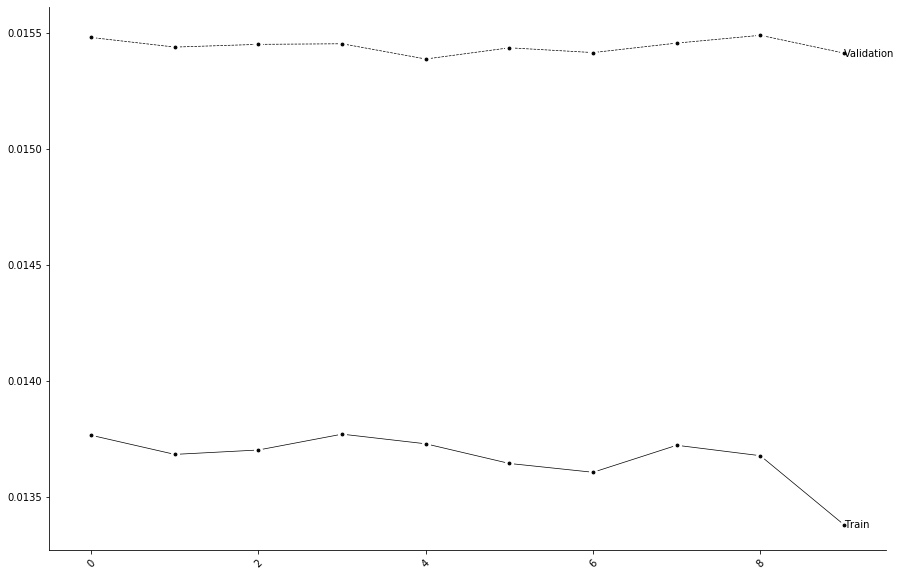

In [445]:
# Trying different Custers third time
Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

save_file_aux = path_holdout + "log_loss_clusters_cat_v3_ml1_aux.csv"
save_file_final = path_holdout + "log_loss_clusters_cat_v3_ml1_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

categorical_varibles_5 = categorical_varibles_4.copy()
categorical_varibles_5 = np.delete(categorical_varibles_5, np.where(categorical_varibles_5 == 'MiniBatchKMeans_c_var_30'))
categorical_varibles_5 = np.delete(categorical_varibles_5, np.where(categorical_varibles_5 == 'Birch_c_var_30'))
categorical_varibles_5

cluster_var_keep = ['MiniBatchKMeans_c_var_30', 'Birch_c_var_30']
train_x_v2 = train_x.join(train_x_with_clusters[cluster_var_keep]).copy()
test_x_v2 = test_x.join(test_x_with_clusters[cluster_var_keep]).copy()

for col in cluster_var_keep:
    train_x_v2[col] = train_x_v2[col].astype('category')
    train_x_v2 = pd.get_dummies(train_x_v2, columns = [col])
    test_x_v2[col] = test_x_v2[col].astype('category')
    test_x_v2 = pd.get_dummies(test_x_v2, columns = [col])
# Not necessarily the development database has all the clusters presented in train.
# Therefore, we need to create new columns in the development database and set them to zero.
for col in train_x_v2.columns:
    if col not in test_x_v2.columns:
        test_x_v2[col] = 0       
        
for parameter in tqdm(categorical_varibles_5):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        train_x_cat = train_x_v2.join(train_x_with_clusters[parameter]).copy()
        test_x_cat = test_x_v2.join(test_x_with_clusters[parameter]).copy()
        
        train_x_cat[parameter] = train_x_cat[parameter].astype('category')
        train_x_cat = pd.get_dummies(train_x_cat, columns = [parameter])
        test_x_cat[parameter] = test_x_cat[parameter].astype('category')
        test_x_cat = pd.get_dummies(test_x_cat, columns = [parameter])
        
        # Not necessarily the development database has all the clusters presented in train.
        # Therefore, we need to create new columns in the development database and set them to zero.
        for col in train_x_cat.columns:
            if col not in test_x_cat.columns:
                test_x_cat[col] = 0
        
        
        X_train = train_x_cat.to_numpy(copy = True)
        X_dev = test_x_cat.to_numpy(copy = True)      
        
        
        n_epochs = 290               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
        dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.1 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(categorical_varibles_5))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

# Log loss train: 0.0.013741143284714997  - Without considering clusters and categorical variables
# Log loss dev: 0.015452641402845552    - Without considering clusters and categorical variables

In [446]:
log_loss_clusters_cat_v3_ml1_hp = log_loss_hp.copy()
log_loss_control = log_loss_clusters_cat_v2_ml1_aux['log_loss_validation'][np.in1d(log_loss_clusters_cat_v2_ml1_aux['parameter'],'Birch_c_var_30')].values[0]
log_loss_clusters_cat_v3_ml1_hp['control_dif'] = log_loss_control - log_loss_clusters_cat_v3_ml1_hp['log_loss_validation']
log_loss_clusters_cat_v3_ml1_hp[log_loss_clusters_cat_v3_ml1_hp['control_dif'] > 0].sort_values(by = 'control_dif', ascending=False)

,parameter_index,parameter,log_loss_train,log_loss_validation,control_dif
4,4,Birch_c_var_15,0.0137274,0.0153863,1.15231e-05


With the unsupervised learning we were able to add three different classifications:\
'MiniBatchKMeans_c_var_30';\
'Birch_c_var_30'; and\
'Birch_c_var_15'.\
We could try to find better parameters for the clustering algorithm.\
However, the gains in doing so may not justify the time needed.\
Another idea to increase our performance is to use the train_targets_nonscored.\
This database has other mechanism of action for our drugs in the train database.\
Considering that these new MoAs are correlated with the MoAs that we need to model, it may be a good idea to model them and add the predictions as new variables. (We will do that in another notebook). 

In [15]:
#A last try with Gaussian mixture model.
start = time.time()
mask_g = train_x.columns.str.contains('^g-*')
train_g_variables = train_x.loc[:,mask_g].copy()
test_g_variables = test_x.loc[:,mask_g].copy()

mask_c = train_x.columns.str.contains('^c-[0-99]')
train_c_variables = train_x.loc[:,mask_c].copy()
test_c_variables = test_x.loc[:,mask_c].copy()

# We will run the other clustering algorithms with differents number of cluster.
# n_cluster_variables = [15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 206, 250, 300, 350, 400]

# GaussianMixture_cluster_dictionary = {}
# BayesianGaussianMixture_cluster_dictionary = {}

#Load
n_cluster_variables = [206, 250, 300, 350, 400]
with open(path_holdout + 'GaussianMixture_cluster_dictionary_aux.txt', 'rb') as handle:
    GaussianMixture_cluster_dictionary = pickle.loads(handle.read())
with open(path_holdout + 'BayesianGaussianMixture_cluster_dictionary_aux.txt', 'rb') as handle:
    BayesianGaussianMixture_cluster_dictionary = pickle.loads(handle.read())
    
    
for n_cluster in tqdm(n_cluster_variables):
    clf_GaussianMixture = GaussianMixture(n_components = n_cluster, covariance_type = 'full')
    clf_BayesianGaussianMixture = BayesianGaussianMixture(n_components = n_cluster, covariance_type = 'full')
    
    # All variables
    fit_GaussianMixture_train_all_variables = clf_GaussianMixture.fit(X = train_x)  
    fit_BayesianGaussianMixture_train_all_variables = clf_BayesianGaussianMixture.fit(X = train_x) 
    GaussianMixture_cluster_dictionary['train_all_' + str(n_cluster)] = clf_GaussianMixture.predict_proba(train_x)
    BayesianGaussianMixture_cluster_dictionary['train_all_' + str(n_cluster)] = clf_BayesianGaussianMixture.predict_proba(train_x)
    GaussianMixture_cluster_dictionary['test_all_' + str(n_cluster)] = clf_GaussianMixture.predict_proba(test_x)
    BayesianGaussianMixture_cluster_dictionary['test_all_' + str(n_cluster)] = clf_BayesianGaussianMixture.predict_proba(test_x)
    
    # genes variables
    fit_GaussianMixture_train_g_variables = clf_GaussianMixture.fit(X = train_g_variables)  
    fit_BayesianGaussianMixture_train_g_variables = clf_BayesianGaussianMixture.fit(X = train_g_variables) 
    GaussianMixture_cluster_dictionary['train_g_' + str(n_cluster)] = clf_GaussianMixture.predict_proba(train_g_variables)
    BayesianGaussianMixture_cluster_dictionary['train_g_' + str(n_cluster)] = clf_BayesianGaussianMixture.predict_proba(train_g_variables)
    GaussianMixture_cluster_dictionary['test_g_' + str(n_cluster)] = clf_GaussianMixture.predict_proba(test_g_variables)
    BayesianGaussianMixture_cluster_dictionary['test_g_' + str(n_cluster)] = clf_BayesianGaussianMixture.predict_proba(test_g_variables)
    
    # cell variables
    fit_GaussianMixture_train_c_variables = clf_GaussianMixture.fit(X = train_c_variables)  
    fit_BayesianGaussianMixture_train_c_variables = clf_BayesianGaussianMixture.fit(X = train_c_variables) 
    GaussianMixture_cluster_dictionary['train_c_' + str(n_cluster)] = clf_GaussianMixture.predict_proba(train_c_variables)
    BayesianGaussianMixture_cluster_dictionary['train_c_' + str(n_cluster)] = clf_BayesianGaussianMixture.predict_proba(train_c_variables)
    GaussianMixture_cluster_dictionary['test_c_' + str(n_cluster)] = clf_GaussianMixture.predict_proba(test_c_variables)
    BayesianGaussianMixture_cluster_dictionary['test_c_' + str(n_cluster)] = clf_BayesianGaussianMixture.predict_proba(test_c_variables)
    
    # Saves prediction
    with open(path_holdout + 'GaussianMixture_cluster_dictionary_aux.txt', 'wb') as handle:
        pickle.dump(GaussianMixture_cluster_dictionary, handle)

    with open(path_holdout + 'BayesianGaussianMixture_cluster_dictionary_aux.txt', 'wb') as handle:
        pickle.dump(BayesianGaussianMixture_cluster_dictionary, handle)

# Saves prediction
with open(path_holdout + 'GaussianMixture_cluster_dictionary.txt', 'wb') as handle:
    pickle.dump(GaussianMixture_cluster_dictionary, handle)
    
with open(path_holdout + 'BayesianGaussianMixture_cluster_dictionary.txt', 'wb') as handle:
    pickle.dump(BayesianGaussianMixture_cluster_dictionary, handle)

 20%|██        | 1/5 [43:19<2:53:16, 2599.20s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
100%|██████████| 5/5 [5:21:42<00:00, 3860.44s/it]  


In [31]:
# Make a dictionary with pandas' data sets with these new variables

n_cluster_variables = [15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 206, 250, 300, 350, 400]
train_mixture_dict = {}
test_mixture_dict = {}
for n_cluster in n_cluster_variables:    
    # All variables
    # Gaussian Mixture
    train_all_var_Gaussian_db = pd.DataFrame(data = GaussianMixture_cluster_dictionary['train_all_' + str(n_cluster)])
    train_all_var_Gaussian_db.columns = ['Gauss_all_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    train_mixture_dict['Gauss_all_var_' + str(n_cluster)] = train_all_var_Gaussian_db.copy()
    
    test_all_var_Gaussian_db = pd.DataFrame(data = GaussianMixture_cluster_dictionary['test_all_' + str(n_cluster)])
    test_all_var_Gaussian_db.columns = ['Gauss_all_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    test_mixture_dict['Gauss_all_var_' + str(n_cluster)] = test_all_var_Gaussian_db.copy()
    
    # Bayesian Gaussian Mixture
    train_all_var_Bayesian_db = pd.DataFrame(data = BayesianGaussianMixture_cluster_dictionary['train_all_' + str(n_cluster)])
    train_all_var_Bayesian_db.columns = ['Bayes_all_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    train_mixture_dict['Bayes_all_var_' + str(n_cluster)] = train_all_var_Bayesian_db.copy()
    
    test_all_var_Bayesian_db = pd.DataFrame(data = BayesianGaussianMixture_cluster_dictionary['test_all_' + str(n_cluster)])
    test_all_var_Bayesian_db.columns = ['Bayes_all_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    test_mixture_dict['Bayes_all_var_' + str(n_cluster)] = test_all_var_Bayesian_db.copy()
    
    # Genes variables
    # Gaussian Mixture
    train_g_var_Gaussian_db = pd.DataFrame(data = GaussianMixture_cluster_dictionary['train_g_' + str(n_cluster)])
    train_g_var_Gaussian_db.columns = ['Gauss_g_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    train_mixture_dict['Gauss_g_var_' + str(n_cluster)] = train_g_var_Gaussian_db.copy()
    
    test_g_var_Gaussian_db = pd.DataFrame(data = GaussianMixture_cluster_dictionary['test_g_' + str(n_cluster)])
    test_g_var_Gaussian_db.columns = ['Gauss_g_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    test_mixture_dict['Gauss_g_var_' + str(n_cluster)] = test_g_var_Gaussian_db.copy()
    
    # Bayesian Gaussian Mixture
    train_g_var_Bayesian_db = pd.DataFrame(data = BayesianGaussianMixture_cluster_dictionary['train_g_' + str(n_cluster)])
    train_g_var_Bayesian_db.columns = ['Bayes_g_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    train_mixture_dict['Bayes_g_var_' + str(n_cluster)] = train_g_var_Bayesian_db.copy()
    
    test_g_var_Bayesian_db = pd.DataFrame(data = BayesianGaussianMixture_cluster_dictionary['test_g_' + str(n_cluster)])
    test_g_var_Bayesian_db.columns = ['Bayes_g_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    test_mixture_dict['Bayes_g_var_' + str(n_cluster)] = test_g_var_Bayesian_db.copy()
    
    # Cell variables
    # Gaussian Mixture
    train_c_var_Gaussian_db = pd.DataFrame(data = GaussianMixture_cluster_dictionary['train_c_' + str(n_cluster)])
    train_c_var_Gaussian_db.columns = ['Gauss_c_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    train_mixture_dict['Gauss_c_var_' + str(n_cluster)] = train_c_var_Gaussian_db.copy()
    
    test_c_var_Gaussian_db = pd.DataFrame(data = GaussianMixture_cluster_dictionary['test_c_' + str(n_cluster)])
    test_c_var_Gaussian_db.columns = ['Gauss_c_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    test_mixture_dict['Gauss_c_var_' + str(n_cluster)] = test_c_var_Gaussian_db.copy()
    
    # Bayesian Gaussian Mixture
    train_c_var_Bayesian_db = pd.DataFrame(data = BayesianGaussianMixture_cluster_dictionary['train_c_' + str(n_cluster)])
    train_c_var_Bayesian_db.columns = ['Bayes_c_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    train_mixture_dict['Bayes_c_var_' + str(n_cluster)] = train_c_var_Bayesian_db.copy()
    
    test_c_var_Bayesian_db = pd.DataFrame(data = BayesianGaussianMixture_cluster_dictionary['test_c_' + str(n_cluster)])
    test_c_var_Bayesian_db.columns = ['Bayes_c_var_' + str(n_cluster) + '_' + str(x) for x in range(1, n_cluster + 1)]
    test_mixture_dict['Bayes_c_var_' + str(n_cluster)] = test_c_var_Bayesian_db.copy()
    
    
with open(path_holdout + 'train_mixture_dict.txt', 'wb') as handle:
    pickle.dump(train_mixture_dict, handle)
    
with open(path_holdout + 'test_mixture_dict.txt', 'wb') as handle:
    pickle.dump(test_mixture_dict, handle)
    
    
# Load
# with open(path_holdout + 'train_mixture_dict.txt', 'rb') as handle:
#     train_mixture_dict = pickle.loads(handle.read())
# with open(path_holdout + 'test_mixture_dict.txt', 'rb') as handle:
#     test_mixture_dict = pickle.loads(handle.read())

  1%|          | 1/96 [05:06<8:04:40, 306.11s/it]


0.0208
Elapsed: 00:09:59
Total run time: 07:59:58
Time to finish: 07:49:59



  3%|▎         | 3/96 [14:52<7:44:24, 299.62s/it]


0.0417
Elapsed: 00:19:48
Total run time: 07:54:49
Time to finish: 07:35:01



  5%|▌         | 5/96 [24:46<7:32:27, 298.32s/it]


0.0625
Elapsed: 00:29:42
Total run time: 07:55:12
Time to finish: 07:25:30



  7%|▋         | 7/96 [34:47<7:24:49, 299.88s/it]


0.0833
Elapsed: 00:39:50
Total run time: 07:58:11
Time to finish: 07:18:21



  9%|▉         | 9/96 [44:52<7:16:57, 301.36s/it]


0.1042
Elapsed: 00:49:59
Total run time: 07:59:41
Time to finish: 07:09:42



 11%|█▏        | 11/96 [55:02<7:09:13, 302.98s/it]


0.125
Elapsed: 01:00:12
Total run time: 08:01:36
Time to finish: 07:01:24



 14%|█▎        | 13/96 [1:05:18<7:02:21, 305.32s/it]


0.1458
Elapsed: 01:10:15
Total run time: 08:01:49
Time to finish: 06:51:34



 16%|█▌        | 15/96 [1:15:19<6:49:30, 303.33s/it]


0.1667
Elapsed: 01:20:24
Total run time: 08:02:18
Time to finish: 06:41:54



 18%|█▊        | 17/96 [1:25:29<6:40:36, 304.25s/it]


0.1875
Elapsed: 01:30:36
Total run time: 08:03:12
Time to finish: 06:32:36



 20%|█▉        | 19/96 [1:35:42<6:31:52, 305.36s/it]


0.2083
Elapsed: 01:40:42
Total run time: 08:03:26
Time to finish: 06:22:44



 22%|██▏       | 21/96 [1:45:48<6:20:33, 304.44s/it]


0.2292
Elapsed: 01:50:49
Total run time: 08:03:30
Time to finish: 06:12:41



 24%|██▍       | 23/96 [1:55:54<6:09:54, 304.04s/it]


0.25
Elapsed: 02:00:59
Total run time: 08:03:56
Time to finish: 06:02:57



 26%|██▌       | 25/96 [2:06:07<6:01:29, 305.49s/it]


0.2708
Elapsed: 02:11:17
Total run time: 08:04:48
Time to finish: 05:53:31



 28%|██▊       | 27/96 [2:16:21<5:51:53, 305.99s/it]


0.2917
Elapsed: 02:21:32
Total run time: 08:05:12
Time to finish: 05:43:40



 30%|███       | 29/96 [2:26:38<5:43:02, 307.21s/it]


0.3125
Elapsed: 02:31:49
Total run time: 08:05:49
Time to finish: 05:34:00



 32%|███▏      | 31/96 [2:37:04<5:36:05, 310.24s/it]


0.3333
Elapsed: 02:42:22
Total run time: 08:07:09
Time to finish: 05:24:47



 34%|███▍      | 33/96 [2:47:25<5:25:15, 309.76s/it]


0.3542
Elapsed: 02:52:42
Total run time: 08:07:35
Time to finish: 05:14:53



 36%|███▋      | 35/96 [2:57:51<5:16:08, 310.96s/it]


0.375
Elapsed: 03:03:06
Total run time: 08:08:16
Time to finish: 05:05:10



 39%|███▊      | 37/96 [3:08:13<5:05:26, 310.61s/it]


0.3958
Elapsed: 03:13:25
Total run time: 08:08:40
Time to finish: 04:55:15



 41%|████      | 39/96 [3:18:32<4:54:19, 309.82s/it]


0.4167
Elapsed: 03:23:48
Total run time: 08:09:05
Time to finish: 04:45:17



 43%|████▎     | 41/96 [3:28:56<4:44:54, 310.81s/it]


0.4375
Elapsed: 03:34:13
Total run time: 08:09:38
Time to finish: 04:35:25



 45%|████▍     | 43/96 [3:39:21<4:35:03, 311.38s/it]


0.4583
Elapsed: 03:44:34
Total run time: 08:10:00
Time to finish: 04:25:26



 47%|████▋     | 45/96 [3:49:43<4:24:16, 310.91s/it]


0.4792
Elapsed: 03:54:56
Total run time: 08:10:16
Time to finish: 04:15:20



 49%|████▉     | 47/96 [4:00:06<4:14:10, 311.23s/it]


0.5
Elapsed: 04:05:22
Total run time: 08:10:44
Time to finish: 04:05:22



 51%|█████     | 49/96 [4:10:55<4:09:43, 318.79s/it]


0.5208
Elapsed: 04:16:27
Total run time: 08:12:25
Time to finish: 03:55:58



 53%|█████▎    | 51/96 [4:21:59<4:04:13, 325.63s/it]


0.5417
Elapsed: 04:27:32
Total run time: 08:13:53
Time to finish: 03:46:21



 55%|█████▌    | 53/96 [4:33:12<3:57:29, 331.38s/it]


0.5625
Elapsed: 04:38:52
Total run time: 08:15:46
Time to finish: 03:36:54



 57%|█████▋    | 55/96 [4:44:44<3:51:55, 339.41s/it]


0.5833
Elapsed: 04:50:33
Total run time: 08:18:07
Time to finish: 03:27:34



 59%|█████▉    | 57/96 [4:56:19<3:43:20, 343.61s/it]


0.6042
Elapsed: 05:02:09
Total run time: 08:20:05
Time to finish: 03:17:56



 61%|██████▏   | 59/96 [5:08:11<3:36:12, 350.61s/it]


0.625
Elapsed: 05:14:02
Total run time: 08:22:27
Time to finish: 03:08:25



 64%|██████▎   | 61/96 [5:20:12<3:27:56, 356.46s/it]


0.6458
Elapsed: 05:26:19
Total run time: 08:25:17
Time to finish: 02:58:58



 66%|██████▌   | 63/96 [5:32:28<3:19:25, 362.58s/it]


0.6667
Elapsed: 05:38:35
Total run time: 08:27:51
Time to finish: 02:49:16



 68%|██████▊   | 65/96 [5:45:35<3:16:39, 380.63s/it]


0.6875
Elapsed: 05:51:42
Total run time: 08:31:34
Time to finish: 02:39:52



 70%|██████▉   | 67/96 [5:57:48<3:00:30, 373.45s/it]


0.7083
Elapsed: 06:03:51
Total run time: 08:33:42
Time to finish: 02:29:51



 72%|███████▏  | 69/96 [6:09:54<2:45:37, 368.07s/it]


0.7292
Elapsed: 06:16:02
Total run time: 08:35:41
Time to finish: 02:19:39



 74%|███████▍  | 71/96 [6:22:45<2:37:43, 378.54s/it]


0.75
Elapsed: 06:29:54
Total run time: 08:39:52
Time to finish: 02:09:58



 76%|███████▌  | 73/96 [6:36:21<2:30:09, 391.73s/it]


0.7708
Elapsed: 06:42:55
Total run time: 08:42:44
Time to finish: 01:59:49



 78%|███████▊  | 75/96 [6:49:26<2:17:16, 392.22s/it]


0.7917
Elapsed: 06:55:56
Total run time: 08:45:22
Time to finish: 01:49:26



 80%|████████  | 77/96 [7:04:14<2:14:02, 423.26s/it]


0.8125
Elapsed: 07:10:45
Total run time: 08:50:09
Time to finish: 01:39:24



 82%|████████▏ | 79/96 [7:17:33<1:56:45, 412.06s/it]


0.8333
Elapsed: 07:24:26
Total run time: 08:53:20
Time to finish: 01:28:54



 84%|████████▍ | 81/96 [7:31:11<1:42:31, 410.08s/it]


0.8542
Elapsed: 07:37:58
Total run time: 08:56:08
Time to finish: 01:18:10



 86%|████████▋ | 83/96 [7:46:46<1:36:25, 445.01s/it]


0.875
Elapsed: 07:53:37
Total run time: 09:01:17
Time to finish: 01:07:40



 89%|████████▊ | 85/96 [8:00:45<1:19:21, 432.87s/it]


0.8958
Elapsed: 08:07:56
Total run time: 09:04:41
Time to finish: 00:56:45



 91%|█████████ | 87/96 [8:15:01<1:04:31, 430.20s/it]


0.9167
Elapsed: 08:22:10
Total run time: 09:07:48
Time to finish: 00:45:38



 93%|█████████▎| 89/96 [8:32:10<56:06, 480.89s/it]  


0.9375
Elapsed: 08:42:06
Total run time: 09:16:54
Time to finish: 00:34:48



 95%|█████████▍| 91/96 [8:49:35<41:17, 495.43s/it]


0.9583
Elapsed: 08:57:02
Total run time: 09:20:24
Time to finish: 00:23:22



 97%|█████████▋| 93/96 [9:04:35<23:37, 472.56s/it]


0.9792
Elapsed: 09:12:04
Total run time: 09:23:48
Time to finish: 00:11:44



 99%|█████████▉| 95/96 [9:22:35<08:35, 515.13s/it]


1.0
Elapsed: 09:33:01
Total run time: 09:33:01
Time to finish: 00:00:00



100%|██████████| 96/96 [9:33:00<00:00, 358.13s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: Gauss_c_var_15


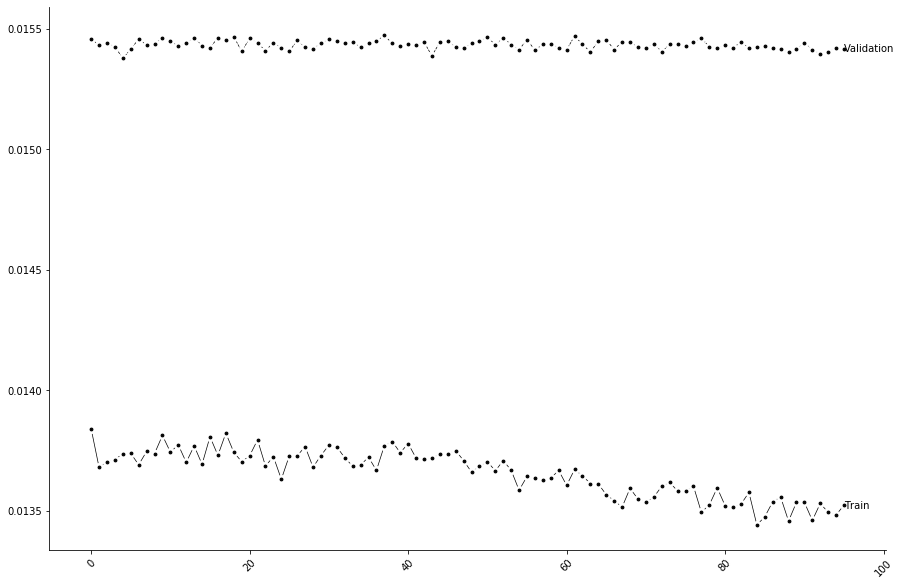

In [38]:
# Trying different Custers mixture
Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

save_file_aux = path_holdout + "log_loss_mixture_ml1_aux.csv"
save_file_final = path_holdout + "log_loss_mixture_ml1_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

for parameter in tqdm(train_mixture_dict):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        train_x_mix = train_x.join(train_mixture_dict[parameter]).copy()
        test_x_mix = test_x.join(test_mixture_dict[parameter]).copy()
  
        X_train = train_x_mix.to_numpy(copy = True)
        X_dev = test_x_mix.to_numpy(copy = True)      
        
        
        n_epochs = 290               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
        dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.1 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(train_mixture_dict))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

# Log loss train: 0.0.013741143284714997  - Without considering clusters and categorical variables
# Log loss dev: 0.015452641402845552    - Without considering clusters and categorical variables

In [175]:
log_loss_mixture_ml1_hp = log_loss_hp.copy()
log_loss_control = 0.015452641402845552
log_loss_mixture_ml1_hp['control_dif'] = log_loss_control - log_loss_mixture_ml1_hp['log_loss_validation']
cluster_to_keep = log_loss_mixture_ml1_hp[log_loss_mixture_ml1_hp['control_dif'] > 0].sort_values(by = 'control_dif', ascending=False)['parameter'].tolist()
log_loss_mixture_ml1_hp[log_loss_mixture_ml1_hp['control_dif'] > 0].sort_values(by = 'control_dif', ascending=False)

,parameter_index,parameter,log_loss_train,log_loss_validation,control_dif
4,4,Gauss_c_var_15,0.0137372,0.0153783,7.43107e-05
43,43,Bayes_all_var_50,0.0137189,0.0153881,6.45799e-05
92,92,Gauss_g_var_400,0.0135313,0.0153972,5.5402e-05
88,88,Gauss_c_var_350,0.0134581,0.0154023,5.0314e-05
63,63,Bayes_g_var_200,0.013614,0.0154044,4.81995e-05
...,...,...,...,...,...
64,64,Gauss_c_var_200,0.0136123,0.0154495,3.17618e-06
45,45,Bayes_g_var_50,0.0137371,0.0154499,2.72426e-06
36,36,Gauss_all_var_45,0.0136685,0.0154502,2.4e-06
31,31,Bayes_all_var_40,0.0137659,0.0154503,2.32993e-06


In [176]:
#Before runnig our model again, lets add the variables 'MiniBatchKMeans_c_var_30', 'Birch_c_var_30', and 'Birch_c_var_15'.

Birch_cluster_dictionary= {}
# 'Birch_c_var_30'
brc = Birch(n_clusters = 30)    
clustering = brc.fit(train_c_variables)
Birch_cluster_dictionary['train_c_variables_30'] = clustering.predict(X = train_c_variables)
Birch_cluster_dictionary['dev_c_variables_30'] = clustering.predict(X = test_c_variables)

Birch_cluster_dictionary['train_c_variables_30'] = pd.DataFrame(data = Birch_cluster_dictionary['train_c_variables_30'].transpose())
Birch_cluster_dictionary['train_c_variables_30'] = Birch_cluster_dictionary['train_c_variables_30'].astype('category')
Birch_cluster_dictionary['train_c_variables_30'] = pd.get_dummies(Birch_cluster_dictionary['train_c_variables_30'])


Birch_cluster_dictionary['dev_c_variables_30'] = pd.DataFrame(data = Birch_cluster_dictionary['dev_c_variables_30'].transpose())
Birch_cluster_dictionary['dev_c_variables_30'] = Birch_cluster_dictionary['dev_c_variables_30'].astype('category')
Birch_cluster_dictionary['dev_c_variables_30'] = pd.get_dummies(Birch_cluster_dictionary['dev_c_variables_30'])
# Not necessarily the development database has all the clusters presented in train.
# Therefore, we need to create new columns in the development database and set them to zero.
for col in Birch_cluster_dictionary['train_c_variables_30'].columns:
    if col not in Birch_cluster_dictionary['dev_c_variables_30'].columns:
        Birch_cluster_dictionary['dev_c_variables_30'][col] = 0
        
#Name columns
Birch_cluster_dictionary['train_c_variables_30'].columns = ['Birch_c_var_30' + '_' + str(x) for x in range(1, 30 + 1)]
Birch_cluster_dictionary['dev_c_variables_30'].columns = ['Birch_c_var_30' + '_' + str(x) for x in range(1, 30 + 1)]

#Add in our dictionary
train_mixture_dict['Birch_c_var_30'] = Birch_cluster_dictionary['train_c_variables_30']
test_mixture_dict['Birch_c_var_30'] = Birch_cluster_dictionary['dev_c_variables_30']
#Add in our cluster_to_keep vector to test in our model
cluster_to_keep.append('Birch_c_var_30')

# 'Birch_c_var_15'
brc = Birch(n_clusters = 15)    
clustering = brc.fit(train_c_variables)
Birch_cluster_dictionary['train_c_variables_15'] = clustering.predict(X = train_c_variables)
Birch_cluster_dictionary['dev_c_variables_15'] = clustering.predict(X = test_c_variables)

Birch_cluster_dictionary['train_c_variables_15'] = pd.DataFrame(data = Birch_cluster_dictionary['train_c_variables_15'].transpose())
Birch_cluster_dictionary['train_c_variables_15'] = Birch_cluster_dictionary['train_c_variables_15'].astype('category')
Birch_cluster_dictionary['train_c_variables_15'] = pd.get_dummies(Birch_cluster_dictionary['train_c_variables_15'])


Birch_cluster_dictionary['dev_c_variables_15'] = pd.DataFrame(data = Birch_cluster_dictionary['dev_c_variables_15'].transpose())
Birch_cluster_dictionary['dev_c_variables_15'] = Birch_cluster_dictionary['dev_c_variables_15'].astype('category')
Birch_cluster_dictionary['dev_c_variables_15'] = pd.get_dummies(Birch_cluster_dictionary['dev_c_variables_15'])
for col in Birch_cluster_dictionary['train_c_variables_15'].columns:
    if col not in Birch_cluster_dictionary['dev_c_variables_15'].columns:
        Birch_cluster_dictionary['dev_c_variables_15'][col] = 0

#Name columns
Birch_cluster_dictionary['train_c_variables_15'].columns = ['Birch_c_var_15' + '_' + str(x) for x in range(1, 15 + 1)]
Birch_cluster_dictionary['dev_c_variables_15'].columns = ['Birch_c_var_15' + '_' + str(x) for x in range(1, 15 + 1)]

#Add in our dictionary
train_mixture_dict['Birch_c_var_15'] = Birch_cluster_dictionary['train_c_variables_15']
test_mixture_dict['Birch_c_var_15'] = Birch_cluster_dictionary['dev_c_variables_15']
#Add in our cluster_to_keep vector to test in our model
cluster_to_keep.append('Birch_c_var_15')

MiniBatchKMeans_cluster_dictionary = {}
# 'MiniBatchKMeans_c_var_30'
clustering = MiniBatchKMeans(n_clusters = 30, random_state = 1, batch_size = 32, max_iter = 100000).fit(train_c_variables)
MiniBatchKMeans_cluster_dictionary['train_c_variables_30'] = clustering.predict(X = train_c_variables)
MiniBatchKMeans_cluster_dictionary['dev_c_variables_30'] = clustering.predict(X = test_c_variables)

MiniBatchKMeans_cluster_dictionary['train_c_variables_30'] = pd.DataFrame(data = MiniBatchKMeans_cluster_dictionary['train_c_variables_30'].transpose())
MiniBatchKMeans_cluster_dictionary['train_c_variables_30'] = MiniBatchKMeans_cluster_dictionary['train_c_variables_30'].astype('category')
MiniBatchKMeans_cluster_dictionary['train_c_variables_30'] = pd.get_dummies(MiniBatchKMeans_cluster_dictionary['train_c_variables_30'])

MiniBatchKMeans_cluster_dictionary['dev_c_variables_30'] = pd.DataFrame(data = MiniBatchKMeans_cluster_dictionary['dev_c_variables_30'].transpose())
MiniBatchKMeans_cluster_dictionary['dev_c_variables_30'] = MiniBatchKMeans_cluster_dictionary['dev_c_variables_30'].astype('category')
MiniBatchKMeans_cluster_dictionary['dev_c_variables_30'] = pd.get_dummies(MiniBatchKMeans_cluster_dictionary['dev_c_variables_30'])
for col in MiniBatchKMeans_cluster_dictionary['train_c_variables_30'].columns:
    if col not in MiniBatchKMeans_cluster_dictionary['dev_c_variables_30'].columns:
        MiniBatchKMeans_cluster_dictionary['dev_c_variables_30'][col] = 0
        
#Name columns
MiniBatchKMeans_cluster_dictionary['train_c_variables_30'].columns = ['MiniBatchKMeans_c_var_30' + '_' + str(x) for x in range(1, 30 + 1)]
MiniBatchKMeans_cluster_dictionary['dev_c_variables_30'].columns = ['MiniBatchKMeans_c_var_30' + '_' + str(x) for x in range(1, 30 + 1)]

#Add in our dictionary
train_mixture_dict['MiniBatchKMeans_c_var_30'] = MiniBatchKMeans_cluster_dictionary['train_c_variables_30']
test_mixture_dict['MiniBatchKMeans_c_var_30'] = MiniBatchKMeans_cluster_dictionary['dev_c_variables_30']
#Add in our cluster_to_keep vector to test in our model
cluster_to_keep.append('MiniBatchKMeans_c_var_30')

  1%|          | 1/81 [05:54<7:53:12, 354.91s/it]


0.0247
Elapsed: 00:13:44
Total run time: 09:16:00
Time to finish: 09:02:16



  4%|▎         | 3/81 [24:00<9:54:25, 457.25s/it]


0.0494
Elapsed: 00:30:17
Total run time: 10:13:01
Time to finish: 09:42:44



  6%|▌         | 5/81 [37:07<9:00:00, 426.32s/it]


0.0741
Elapsed: 00:44:53
Total run time: 10:05:43
Time to finish: 09:20:50



  9%|▊         | 7/81 [50:18<8:18:31, 404.22s/it]


0.0988
Elapsed: 00:55:47
Total run time: 09:24:37
Time to finish: 08:28:50



 11%|█         | 9/81 [1:01:15<7:18:51, 365.72s/it]


0.1235
Elapsed: 01:07:33
Total run time: 09:06:58
Time to finish: 07:59:25



 14%|█▎        | 11/81 [1:14:05<7:19:05, 376.36s/it]


0.1481
Elapsed: 01:22:02
Total run time: 09:13:54
Time to finish: 07:51:52



 16%|█▌        | 13/81 [1:28:45<7:39:25, 405.37s/it]


0.1728
Elapsed: 01:35:00
Total run time: 09:09:46
Time to finish: 07:34:46



 19%|█▊        | 15/81 [1:40:29<6:53:43, 376.11s/it]


0.1975
Elapsed: 01:47:58
Total run time: 09:06:40
Time to finish: 07:18:42



 21%|██        | 17/81 [1:58:35<8:20:55, 469.62s/it]


0.2222
Elapsed: 02:04:10
Total run time: 09:18:48
Time to finish: 07:14:38



 23%|██▎       | 19/81 [2:15:12<8:35:57, 499.31s/it]


0.2469
Elapsed: 02:21:06
Total run time: 09:31:29
Time to finish: 07:10:23



 26%|██▌       | 21/81 [2:26:32<6:56:52, 416.88s/it]


0.2716
Elapsed: 02:32:07
Total run time: 09:20:05
Time to finish: 06:47:58



 28%|██▊       | 23/81 [2:39:29<6:33:37, 407.19s/it]


0.2963
Elapsed: 02:46:47
Total run time: 09:22:53
Time to finish: 06:36:06



 31%|███       | 25/81 [2:57:54<7:38:48, 491.58s/it]


0.321
Elapsed: 03:05:11
Total run time: 09:36:54
Time to finish: 06:31:43



 33%|███▎      | 27/81 [3:11:34<6:42:54, 447.68s/it]


0.3457
Elapsed: 03:18:50
Total run time: 09:35:10
Time to finish: 06:16:20



 36%|███▌      | 29/81 [3:26:26<6:28:08, 447.86s/it]


0.3704
Elapsed: 03:32:00
Total run time: 09:32:21
Time to finish: 06:00:21



 38%|███▊      | 31/81 [3:38:37<5:40:32, 408.65s/it]


0.3951
Elapsed: 03:44:00
Total run time: 09:26:57
Time to finish: 05:42:57



 41%|████      | 33/81 [3:49:31<4:53:57, 367.45s/it]


0.4198
Elapsed: 03:54:40
Total run time: 09:19:00
Time to finish: 05:24:20



 43%|████▎     | 35/81 [4:01:38<4:43:55, 370.34s/it]


0.4444
Elapsed: 04:08:51
Total run time: 09:19:58
Time to finish: 05:11:07



 46%|████▌     | 37/81 [4:14:19<4:31:57, 370.85s/it]


0.4691
Elapsed: 04:19:44
Total run time: 09:13:41
Time to finish: 04:53:57



 48%|████▊     | 39/81 [4:26:20<4:18:06, 368.72s/it]


0.4938
Elapsed: 04:31:39
Total run time: 09:10:07
Time to finish: 04:38:28



 51%|█████     | 41/81 [4:38:52<4:11:41, 377.55s/it]


0.5185
Elapsed: 04:45:56
Total run time: 09:11:28
Time to finish: 04:25:32



 53%|█████▎    | 43/81 [4:51:09<3:53:00, 367.90s/it]


0.5432
Elapsed: 04:56:26
Total run time: 09:05:43
Time to finish: 04:09:17



 56%|█████▌    | 45/81 [5:02:17<3:31:16, 352.14s/it]


0.5679
Elapsed: 05:07:47
Total run time: 09:01:58
Time to finish: 03:54:11



 58%|█████▊    | 47/81 [5:13:30<3:15:26, 344.88s/it]


0.5926
Elapsed: 05:20:06
Total run time: 09:00:10
Time to finish: 03:40:04



 60%|██████    | 49/81 [5:26:16<3:13:38, 363.09s/it]


0.6173
Elapsed: 05:31:40
Total run time: 08:57:17
Time to finish: 03:25:37



 63%|██████▎   | 51/81 [5:38:16<3:02:24, 364.82s/it]


0.642
Elapsed: 05:44:19
Total run time: 08:56:19
Time to finish: 03:12:00



 65%|██████▌   | 53/81 [5:49:32<2:42:48, 348.89s/it]


0.6667
Elapsed: 05:55:50
Total run time: 08:53:43
Time to finish: 02:57:53



 68%|██████▊   | 55/81 [6:03:16<2:46:29, 384.21s/it]


0.6914
Elapsed: 06:08:33
Total run time: 08:53:03
Time to finish: 02:44:30



 70%|███████   | 57/81 [6:13:56<2:20:39, 351.64s/it]


0.716
Elapsed: 06:19:18
Total run time: 08:49:45
Time to finish: 02:30:27



 73%|███████▎  | 59/81 [6:24:31<2:02:24, 333.85s/it]


0.7407
Elapsed: 06:29:46
Total run time: 08:46:13
Time to finish: 02:16:27



 75%|███████▌  | 61/81 [6:35:24<1:50:22, 331.12s/it]


0.7654
Elapsed: 06:40:37
Total run time: 08:43:24
Time to finish: 02:02:47



 78%|███████▊  | 63/81 [6:48:10<1:49:13, 364.07s/it]


0.7901
Elapsed: 06:53:20
Total run time: 08:43:08
Time to finish: 01:49:48



 80%|████████  | 65/81 [6:58:39<1:30:29, 339.34s/it]


0.8148
Elapsed: 07:07:20
Total run time: 08:44:28
Time to finish: 01:37:08



 83%|████████▎ | 67/81 [7:12:33<1:26:15, 369.66s/it]


0.8395
Elapsed: 07:21:40
Total run time: 08:46:06
Time to finish: 01:24:26



 85%|████████▌ | 69/81 [7:26:59<1:18:20, 391.69s/it]


0.8642
Elapsed: 07:33:12
Total run time: 08:44:25
Time to finish: 01:11:13



 88%|████████▊ | 71/81 [7:38:40<1:01:27, 368.72s/it]


0.8889
Elapsed: 07:45:04
Total run time: 08:43:12
Time to finish: 00:58:08



 90%|█████████ | 73/81 [7:50:45<48:29, 363.69s/it]  


0.9136
Elapsed: 07:57:48
Total run time: 08:42:59
Time to finish: 00:45:11



 93%|█████████▎| 75/81 [8:03:15<36:31, 365.26s/it]


0.9383
Elapsed: 08:08:35
Total run time: 08:40:43
Time to finish: 00:32:08



 95%|█████████▌| 77/81 [8:13:48<22:40, 340.19s/it]


0.963
Elapsed: 08:19:04
Total run time: 08:38:14
Time to finish: 00:19:10



 98%|█████████▊| 79/81 [8:24:22<10:56, 328.28s/it]


0.9877
Elapsed: 08:29:32
Total run time: 08:35:53
Time to finish: 00:06:21



100%|██████████| 81/81 [8:34:49<00:00, 381.35s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: Gauss_g_var_250


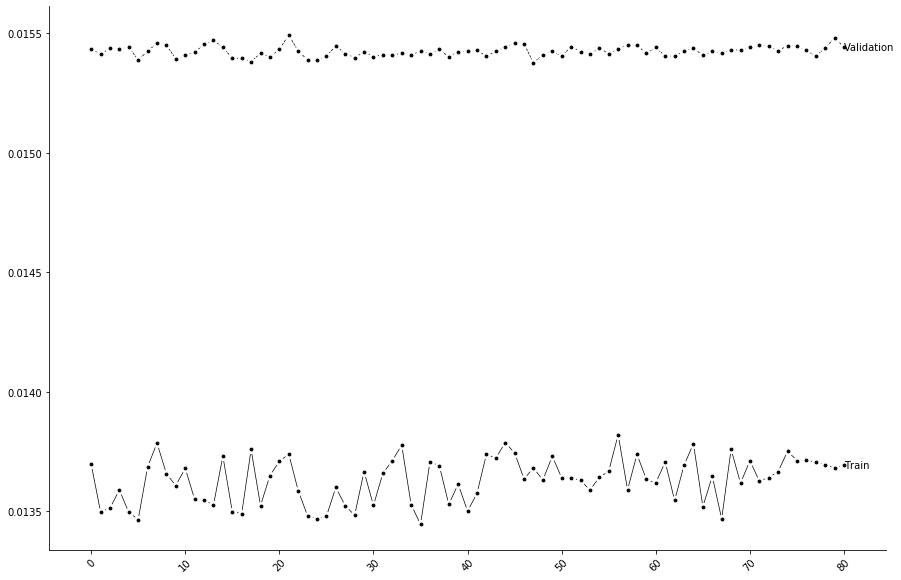

In [185]:
# Trying different Custers mixture - second run
Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

save_file_aux = path_holdout + "log_loss_mixture_v2_ml1_aux.csv"
save_file_final = path_holdout + "log_loss_mixture_v2_ml1_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []


#Add variable: Gauss_c_var_15
train_x_v2 = train_x.copy()
train_x_v2 = train_x_v2.join(train_mixture_dict['Gauss_c_var_15'])
test_x_v2 = test_x.copy()
test_x_v2 = test_x_v2.join(test_mixture_dict['Gauss_c_var_15'])

#Delete Gauss_c_var_15 from cluster_to_keep so we don't test our model with it.
cluster_to_keep = np.delete(cluster_to_keep,0)

for parameter in tqdm(cluster_to_keep):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        train_x_mix = train_x_v2.join(train_mixture_dict[parameter]).copy()
        test_x_mix = test_x_v2.join(test_mixture_dict[parameter]).copy()
  
        X_train = train_x_mix.to_numpy(copy = True)
        X_dev = test_x_mix.to_numpy(copy = True)      
        
        
        n_epochs = 290               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
        dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.1 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(cluster_to_keep))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

# Log loss train: 0.0.013741143284714997  - Without considering clusters and categorical variables
# Log loss dev: 0.015452641402845552    - Without considering clusters and categorical variables

In [186]:
log_loss_mixture_v2_ml1_hp = log_loss_hp.copy()
log_loss_control = log_loss_mixture_ml1_hp['log_loss_validation'][np.in1d(log_loss_mixture_ml1_hp['parameter'],'Gauss_c_var_15')].values[0]
log_loss_mixture_v2_ml1_hp['control_dif'] = log_loss_control - log_loss_mixture_v2_ml1_hp['log_loss_validation']
cluster_to_keep_v2 = log_loss_mixture_v2_ml1_hp[log_loss_mixture_v2_ml1_hp['control_dif'] > 0].sort_values(by = 'control_dif', ascending=False)['parameter'].tolist()
log_loss_mixture_v2_ml1_hp[log_loss_mixture_v2_ml1_hp['control_dif'] > 0].sort_values(by = 'control_dif', ascending=False)

,parameter_index,parameter,log_loss_train,log_loss_validation,control_dif
47,47,Gauss_g_var_250,0.0136814,0.0153778,5.58673e-07


It was a good idea to use Gaussian mixture.
Intead of using the other clustering algorithms, we will use only the variable Gauss_c_var_15.